<a href="https://colab.research.google.com/github/Shivendramaurya6/Coffee-Mug-/blob/main/Main_Lane_pavement_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install --upgrade ffmpeg

  Preparing metadata (setup.py) ... done
  Created wheel for ffmpeg: filename=ffmpeg-1.4-py3-none-any.whl size=6083 sha256=6bbb01b2b08cb6228b76c4285e0ffc5924c722c2602401a2eb59d3c0f54fcc4c
  Stored in directory: /root/.cache/pip/wheels/8e/7a/69/cd6aeb83b126a7f04cbe7c9d929028dc52a6e7d525ff56003a
Successfully built ffmpeg


In [3]:
import numpy as np
import pandas as pd
import cv2
import os
import glob
import matplotlib.pyplot as plt
import pickle
import cv2 as cv

%matplotlib inline


## Target Video resolution and frame extraction

Video resolution: [1280, 720]
Frame 200 saved as /content/test_image.jpg
Resolution of saved image: (1280, 720)


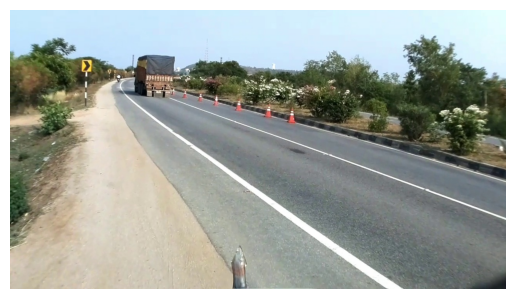

In [4]:
from moviepy.editor import VideoFileClip
import matplotlib.pyplot as plt
import cv2
import os

def get_resolution(video_path):
    # Open the video file
    video = VideoFileClip(video_path)
    resolution = video.size
    video.close()
    return resolution

def capture_frame_and_resolution(video_path, frame_number, output_image_path):
    # Open the video file
    cap = cv2.VideoCapture(video_path)

    # Check if the video opened successfully
    if not cap.isOpened():
        print("Error: Could not open video.")
        return

    # Set the frame position
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)

    # Read the frame
    ret, frame = cap.read()

    # Check if the frame was read successfully
    if not ret:
        print("Error: Could not read frame.")
        return

    # Save the frame as a PNG image
    cv2.imwrite(output_image_path, frame)
    print(f"Frame {frame_number} saved as {output_image_path}")

    # Get and print resolution of the saved frame
    saved_image = cv2.imread(output_image_path)
    saved_resolution = (saved_image.shape[1], saved_image.shape[0])
    print(f"Resolution of saved image: {saved_resolution}")

    # Release the video capture object
    cap.release()

# Example usage
video_path = '/content/drive/MyDrive/Start to End Hyderabad Part 3 720P (1).mp4'
frame_number = 200  # Specify the frame number you want to capture
output_image_path = '/content/test_image.jpg'

# Get and print video resolution
video_resolution = get_resolution(video_path)
print("Video resolution:", video_resolution)

# Capture frame and print its resolution
capture_frame_and_resolution(video_path, frame_number, output_image_path)

# Display the captured frame
image = cv2.imread(output_image_path)
img_org = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(img_org)
plt.axis('off')
plt.show()


## Calibration & Distortion Correction

In [16]:
import cv2
import numpy as np
import glob
import pickle
import matplotlib.pyplot as plt

def undistort_img():
    # Prepare object points 0,0,0 ... 8,5,0
    obj_pts = np.zeros((6*9,3), np.float32)
    obj_pts[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

    # Stores all object points & img points from all images
    objpoints = []
    imgpoints = []

    # Get directory for all calibration images
    images = glob.glob('/content/drive/MyDrive/Camera calibration/*.jpg')

    for indx, fname in enumerate(images):
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

        if ret == True:
            objpoints.append(obj_pts)

            # Refining corner positions for better accuracy
            corners2 = cv2.cornerSubPix(gray, corners, (11,11), (-1,-1), criteria=(cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001))

            # Append corners2 only once
            imgpoints.append(corners2)

            # Draw the corners on the image
            pattern_img = cv2.drawChessboardCorners(img.copy(), (9,6), corners2, ret)

            # Create a Matplotlib figure and axis
            plt.figure(figsize=(8,8))
            ax = plt.gca()

            # Display the pattern image on the axis
            ax.imshow(cv2.cvtColor(pattern_img, cv2.COLOR_BGR2RGB))
            plt.show()

            cv2.waitKey(500)

            # Print the name of the image
            print("Image Name:", fname)

    if len(objpoints) != len(images):
        print("Error: Number of images with detected corners does not match the total number of images.")
        return

    # Test undistortion on img
    img_size = (img.shape[1], img.shape[0])

    # Calibrate camera
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None,None)

    # Get optimal new camera matrix and ROI
    h, w = img.shape[:2]
    newcameramtx, roi = cv2.getOptimalNewCameraMatrix(mtx, dist, (w,h), 1, (w,h))

    # Undistort the image
    dst = cv2.undistort(img, mtx, dist, None, newcameramtx)

    # Crop the image
    x, y, w, h = roi
    dst = dst[y:y+h, x:x+w]

    # Save camera calibration for later use
    dist_pickle = {}
    dist_pickle['mtx'] = mtx
    dist_pickle['dist'] = dist
    pickle.dump(dist_pickle, open('/content/drive/MyDrive/Camera calibration/cal_pickle.p', 'wb'))

def undistort(img, cal_dir='/content/drive/MyDrive/Camera calibration/cal_pickle.p'):
    # Load camera calibration parameters
    with open(cal_dir, mode='rb') as f:
        file = pickle.load(f)
    mtx = file['mtx']
    dist = file['dist']

    # Get optimal new camera matrix and ROI
    h, w = img.shape[:2]
    newcameramtx, roi = cv2.getOptimalNewCameraMatrix(mtx, dist, (w,h), 1, (w,h))

    # Undistort the image
    dst = cv2.undistort(img, mtx, dist, None, newcameramtx)

    # Crop the image
    x, y, w, h = roi
    dst = dst[y:y+h, x:x+w]

    return dst


In [17]:
# Call the undistort_img function to perform calibration and corner detection
undistort_img()

Error: Number of images with detected corners does not match the total number of images.


Text(0.5, 1.0, 'Undistorted Image')

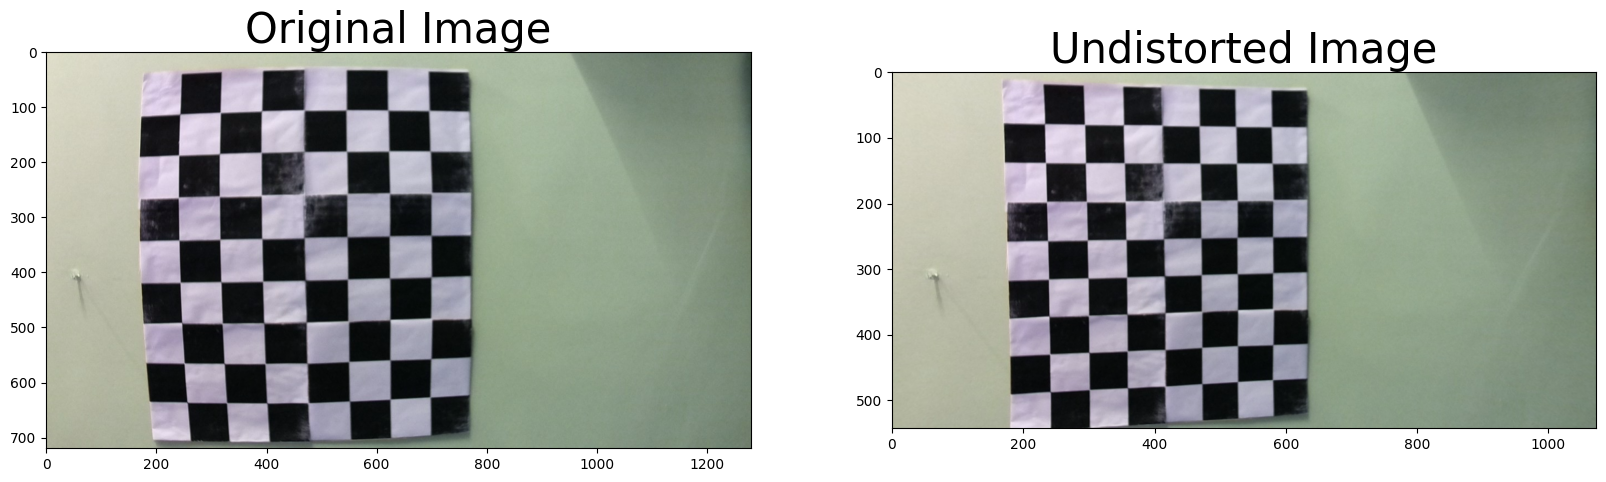

In [18]:
img = cv2.imread('/content/drive/MyDrive/Camera calibration/Cam_Cal (8).jpg')
dst = undistort(img)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)


Text(0.5, 1.0, 'Undistorted Image')

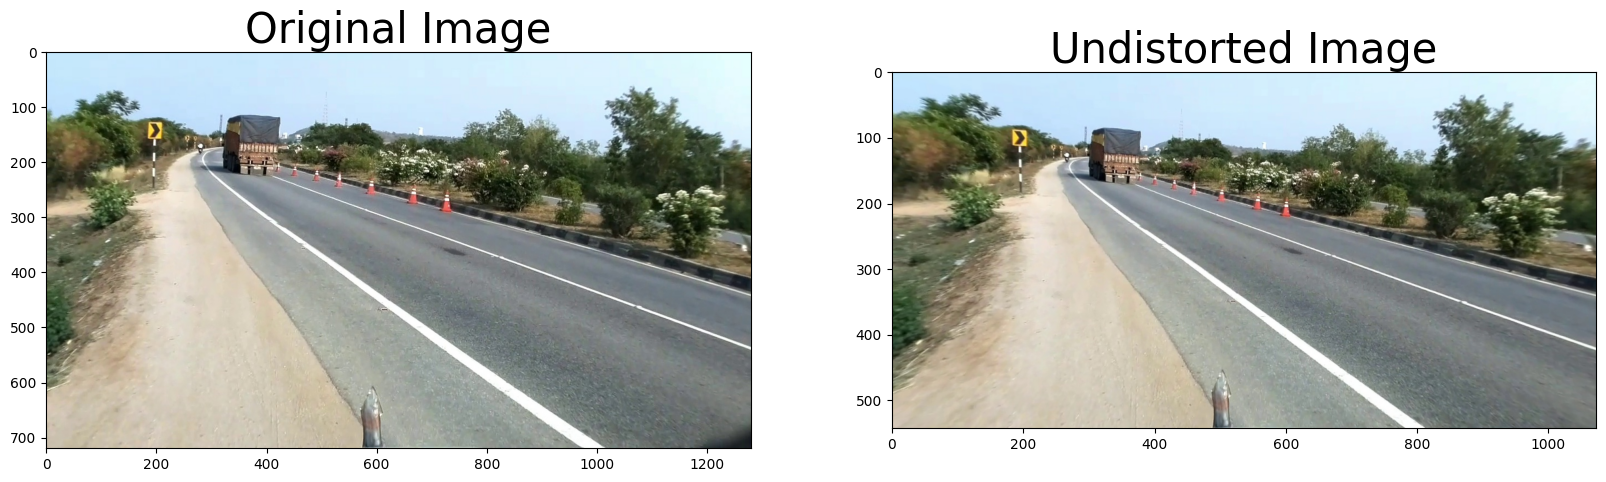

In [19]:
img = cv2.imread('/content/test_image.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
dst = undistort(img)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

## Pipeline and Perspective warp

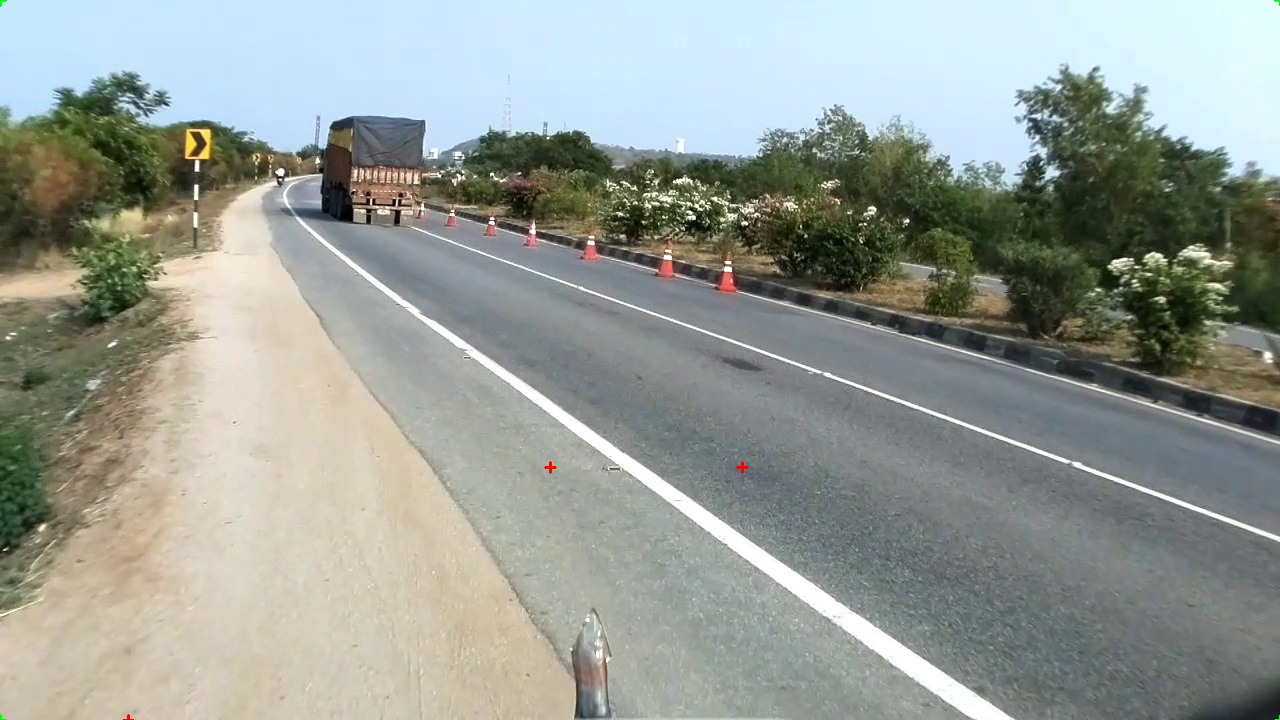

In [20]:
from google.colab.patches import cv2_imshow
import cv2
import numpy as np

def draw_points_on_image(image, src_points, dst_points):
    """
    Function to draw source and destination points on the image.
    """
    # Convert points to integer
    src_points_int = np.int32(src_points * np.array(image.shape[:2])[::-1])
    dst_points_int = np.int32(dst_points * np.array(image.shape[:2])[::-1])

    # Draw source points as red crosses and destination points as green crosses
    for point in src_points_int:
        cv2.drawMarker(image, tuple(point), (0, 0, 255), cv2.MARKER_CROSS, markerSize=10, thickness=2)
    for point in dst_points_int:
        cv2.drawMarker(image, tuple(point), (0, 255, 0), cv2.MARKER_CROSS, markerSize=10, thickness=2)

    return image

# Load your original image
image = cv2.imread("/content/test_image.jpg")  # Replace "your_image.jpg" with your image file path

# Define source and destination points
src_points = np.float32([(0.43,0.65),(0.58,0.65),(0.1,1),(1,1)])
dst_points = np.float32([(0, 0), (1, 0), (0, 1), (1, 1)])

# Draw points on the image
image_with_points = draw_points_on_image(image.copy(), src_points, dst_points)

# Display the image with points
cv2_imshow(image_with_points)


In [21]:
def pipeline(img, s_thresh=(100, 255), sx_thresh=(15, 255)):
    img = undistort(img)
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float32)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    h_channel = hls[:,:,0]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 1) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1

    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1

    color_binary = np.dstack((np.zeros_like(sxbinary), sxbinary, s_binary)) * 255

    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    return combined_binary

def perspective_warp(img,
                     dst_size=(1280,720),             #Enter the exact resolution of original image
                     src=np.float32([(0.43,0.65),(0.58,0.65),(0.1,1),(1,1)]),
                     dst=np.float32([(0,0), (1, 0), (0,1), (1,1)])):
    img_size = np.float32([(img.shape[1],img.shape[0])])
    src = src* img_size
    # For destination points, I'm arbitrarily choosing some points to be
    # a nice fit for displaying our warped result
    # again, not exact, but close enough for our purposes
    dst = dst * np.float32(dst_size)
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(img, M, dst_size)
    return warped

def inv_perspective_warp(img,
                     dst_size=(1280,720),              #Enter the exact resolution of original image
                     src=np.float32([(0,0), (1, 0), (0,1), (1,1)]),
                     dst=np.float32([(0.43,0.65),(0.58,0.65),(0.1,1),(1,1)])):
    img_size = np.float32([(img.shape[1],img.shape[0])])
    src = src* img_size
    # For destination points, I'm arbitrarily choosing some points to be
    # a nice fit for displaying our warped result
    # again, not exact, but close enough for our purposes
    dst = dst * np.float32(dst_size)
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(img, M, dst_size)
    return warped

def get_hist(img):
    hist = np.sum(img[img.shape[0]//2:,:], axis=0)
    return hist


Text(0.5, 1.0, 'Warped Image')

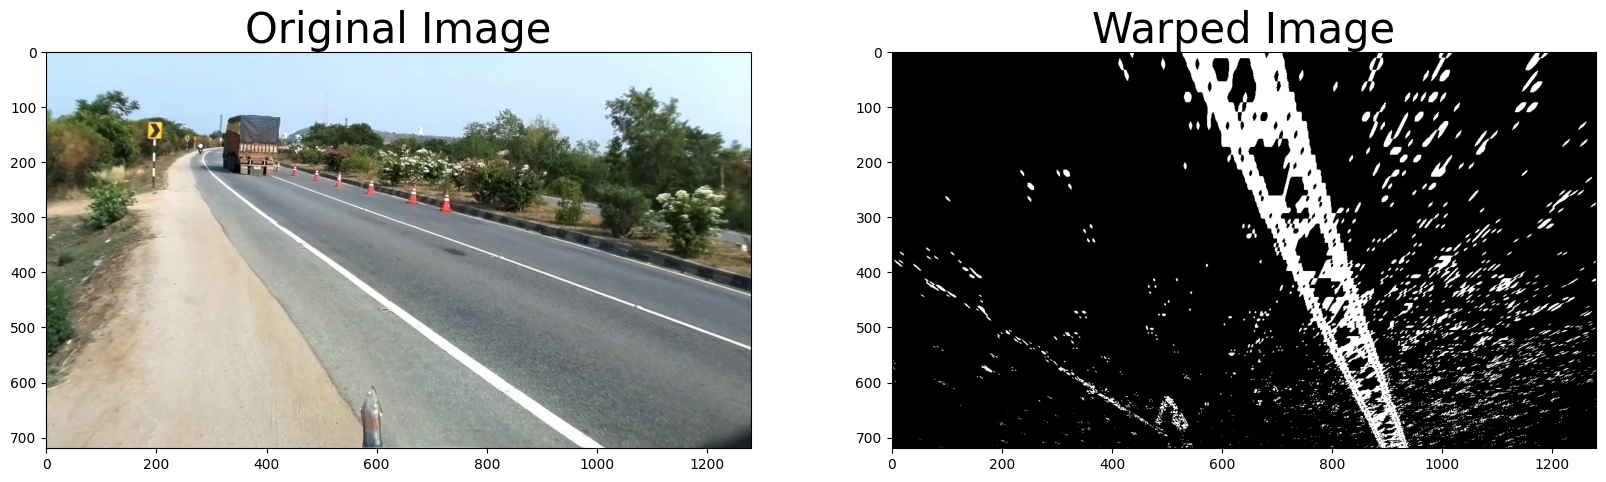

In [22]:
img = cv2.imread('/content/test_image.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
dst = pipeline(img)
dst = perspective_warp(dst, dst_size=(1280,720))        #Enter the exact resolution of original image

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst, cmap='gray')
ax2.set_title('Warped Image', fontsize=30)


## Sliding Window Algorithm and Curve Plotting

In [23]:
left_a, left_b, left_c = [],[],[]
right_a, right_b, right_c = [],[],[]

def sliding_window(img, nwindows=9, margin=150, minpix = 1, draw_windows=True):
    global left_a, left_b, left_c,right_a, right_b, right_c
    left_fit_= np.empty(3)
    right_fit_ = np.empty(3)
    out_img = np.dstack((img, img, img))*255

    histogram = get_hist(img)
    # find peaks of left and right halves
    midpoint = int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint


    # Set height of windows
    window_height = np.int32(img.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base


    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img.shape[0] - (window+1)*window_height
        win_y_high = img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        if draw_windows == True:
            cv2.rectangle(out_img,(int(win_xleft_low),int(win_y_low)),(int(win_xleft_high),int(win_y_high)), (100,255,255), 3)
            cv2.rectangle(out_img,(int(win_xright_low),int(win_y_low)),(int(win_xright_high),int(win_y_high)), (100,255,255), 3)

        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int32(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int32(np.mean(nonzerox[good_right_inds]))


#        if len(good_right_inds) > minpix:
#            rightx_current = np.int32(np.mean([leftx_current +900, np.mean(nonzerox[good_right_inds])]))
#        elif len(good_left_inds) > minpix:
#            rightx_current = np.int32(np.mean([np.mean(nonzerox[good_left_inds]) +900, rightx_current]))
#        if len(good_left_inds) > minpix:
#            leftx_current = np.int32(np.mean([rightx_current -900, np.mean(nonzerox[good_left_inds])]))
#        elif len(good_right_inds) > minpix:
#            leftx_current = np.int32(np.mean([np.mean(nonzerox[good_right_inds]) -900, leftx_current]))


    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    left_a.append(left_fit[0])
    left_b.append(left_fit[1])
    left_c.append(left_fit[2])

    right_a.append(right_fit[0])
    right_b.append(right_fit[1])
    right_c.append(right_fit[2])

    left_fit_[0] = np.mean(left_a[-10:])
    left_fit_[1] = np.mean(left_b[-10:])
    left_fit_[2] = np.mean(left_c[-10:])

    right_fit_[0] = np.mean(right_a[-10:])
    right_fit_[1] = np.mean(right_b[-10:])
    right_fit_[2] = np.mean(right_c[-10:])

    # Generate x and y values for plotting
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
    left_fitx = left_fit_[0]*ploty**2 + left_fit_[1]*ploty + left_fit_[2]
    right_fitx = right_fit_[0]*ploty**2 + right_fit_[1]*ploty + right_fit_[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 100]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 100, 255]

    print("Size of ploty:", len(ploty))      # Print the length of ploty


    return out_img, (left_fitx, right_fitx), (left_fit_, right_fit_), ploty

def get_curve(img, leftx, rightx):
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0])
    y_eval = np.max(ploty)
    ym_per_pix = 30.5/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/720 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

    car_pos = img.shape[1]/2
    l_fit_x_int = left_fit_cr[0]*img.shape[0]**2 + left_fit_cr[1]*img.shape[0] + left_fit_cr[2]
    r_fit_x_int = right_fit_cr[0]*img.shape[0]**2 + right_fit_cr[1]*img.shape[0] + right_fit_cr[2]
    lane_center_position = (r_fit_x_int + l_fit_x_int) /2
    center = (car_pos - lane_center_position) * xm_per_pix / 10
    # Now our radius of curvature is in meters
    return (left_curverad, right_curverad, center)

def calculate_lane_width(left_fit, right_fit, image_height):
    # Calculate x-coordinate of left and right lane lines at the bottom of the image
    left_x = left_fit[0] * image_height**2 + left_fit[1] * image_height + left_fit[2]
    right_x = right_fit[0] * image_height**2 + right_fit[1] * image_height + right_fit[2]

    # Convert pixel values to meters
    xm_per_pix = 3.7/720  # meters per pixel in x dimension
    left_x_meters = left_x * xm_per_pix
    right_x_meters = right_x * xm_per_pix

    # Calculate lane width in meters
    lane_width_meters = right_x_meters - left_x_meters
    return lane_width_meters


def draw_lanes(img, left_fit, right_fit):
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0])
    color_img = np.zeros_like(img)

    left = np.array([np.transpose(np.vstack([left_fit, ploty]))])
    right = np.array([np.flipud(np.transpose(np.vstack([right_fit, ploty])))])
    points = np.hstack((left, right))

    cv2.fillPoly(color_img, np.int32(points), (0,200,255))
    inv_perspective = inv_perspective_warp(color_img)
    inv_perspective = cv2.addWeighted(img, 1, inv_perspective, 0.7, 0)
    return inv_perspective


Size of ploty: 720
Shape of both tuple: (2, 720)
(154.80162820093057, 1219.4974385591156, -0.054230330155000894)
Lane Width: 480166.94695340726


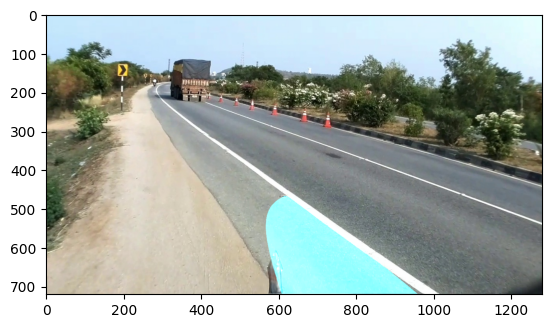

In [24]:
#%matplotlib gtk
out_img, curves, lanes, ploty = sliding_window(dst)
#plt.imshow(out_img)
#plt.plot(curves[0], ploty, color='yellow', linewidth=1)
#plt.plot(curves[1], ploty, color='yellow', linewidth=1)

print("Shape of both tuple:",np.asarray(curves).shape)
curverad=get_curve(img, curves[0],curves[1])
print(curverad)

# After obtaining the lane fits and curvature
lane_width = calculate_lane_width(curves[0], curves[1], img.shape[0])

# Print lane width and turn direction
print("Lane Width:", lane_width)

# Plot the image with lane drawn
img_ = draw_lanes(img, curves[0], curves[1])
plt.imshow(img_, cmap='hsv')


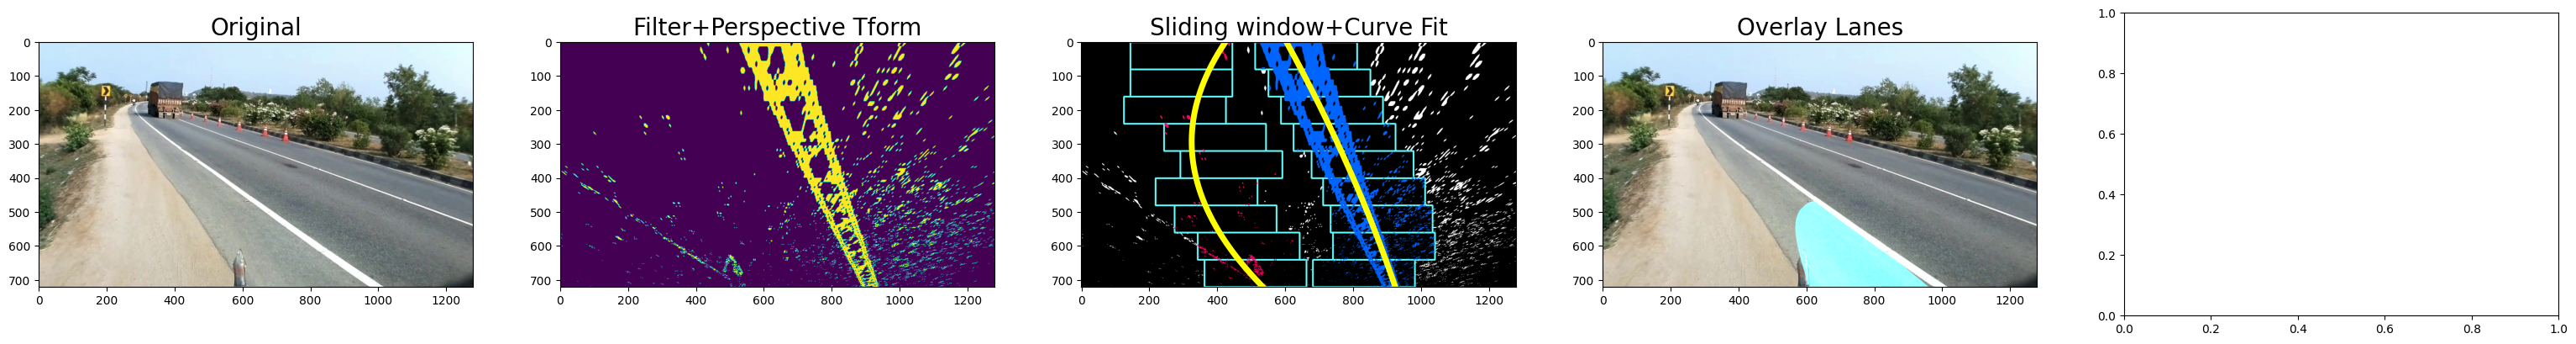

In [25]:
f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(30,4))  # Adjust figsize here
#f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original', fontsize=20)  # Adjust fontsize as needed
ax2.imshow(dst)
ax2.set_title('Filter+Perspective Tform', fontsize=20)  # Adjust fontsize as needed
ax3.imshow(out_img)
ax3.plot(curves[0], ploty, color='yellow', linewidth=5)  # Adjust linewidth as needed
ax3.plot(curves[1], ploty, color='yellow', linewidth=5)  # Adjust linewidth as needed
ax3.set_title('Sliding window+Curve Fit', fontsize=20)  # Adjust fontsize as needed
ax4.imshow(img_)
ax4.set_title('Overlay Lanes', fontsize=20)  # Adjust fontsize as needed
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()


## Video Pipeline

In [26]:
def vid_pipeline(img):
    global running_avg
    global index
    img_ = pipeline(img)
    img_ = perspective_warp(img_)
    out_img, curves, lanes, ploty = sliding_window(img_, draw_windows=False)
    curverad =get_curve(img, curves[0], curves[1])
    lane_curve = np.mean([curverad[0], curverad[1]])
    img = draw_lanes(img, curves[0], curves[1])

    font = cv2.FONT_HERSHEY_SIMPLEX
    fontColor = (0, 0, 0)
    fontSize=0.5
    cv2.putText(img, 'Lane Curvature: {:.0f} m'.format(lane_curve), (570, 620), font, fontSize, fontColor, 2)
    cv2.putText(img, 'Vehicle offset: {:.4f} m'.format(curverad[2]), (570, 650), font, fontSize, fontColor, 2)
    return img


In [27]:
right_curves, left_curves = [],[]
from moviepy.editor import VideoFileClip

myclip = VideoFileClip('/content/drive/MyDrive/Start to End Hyderabad Part 3 720P (1).mp4')#.subclip(40,43)
output_vid = '/content/drive/MyDrive/output24Start to End Hyderabad Part 3 720P (1).mp4'
clip = myclip.fl_image(vid_pipeline)
clip.write_videofile(output_vid, audio=False)


Size of ploty: 720
Moviepy - Building video /content/drive/MyDrive/output24Start to End Hyderabad Part 3 720P (1).mp4.
Moviepy - Writing video /content/drive/MyDrive/output24Start to End Hyderabad Part 3 720P (1).mp4



t:   0%|          | 0/9898 [00:00<?, ?it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   0%|          | 3/9898 [00:00<10:03, 16.40it/s, now=None]

Size of ploty: 720


t:   0%|          | 5/9898 [00:00<12:13, 13.49it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   0%|          | 7/9898 [00:00<13:17, 12.40it/s, now=None]

Size of ploty: 720
Size of ploty: 720
Size of ploty: 720


t:   0%|          | 9/9898 [00:00<14:28, 11.39it/s, now=None]

Size of ploty: 720


t:   0%|          | 11/9898 [00:00<14:25, 11.42it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   0%|          | 13/9898 [00:01<14:05, 11.69it/s, now=None]

Size of ploty: 720
Size of ploty: 720
Size of ploty: 720


t:   0%|          | 15/9898 [00:01<14:59, 10.99it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   0%|          | 19/9898 [00:01<21:09,  7.78it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   0%|          | 21/9898 [00:02<23:08,  7.11it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   0%|          | 22/9898 [00:02<23:11,  7.10it/s, now=None]

Size of ploty: 720
Size of ploty: 720
Size of ploty: 720


t:   0%|          | 26/9898 [00:02<17:46,  9.26it/s, now=None]

Size of ploty: 720
Size of ploty: 720
Size of ploty: 720


t:   0%|          | 30/9898 [00:03<15:40, 10.49it/s, now=None]

Size of ploty: 720
Size of ploty: 720
Size of ploty: 720


t:   0%|          | 32/9898 [00:03<15:02, 10.93it/s, now=None]

Size of ploty: 720
Size of ploty: 720
Size of ploty: 720


t:   0%|          | 36/9898 [00:03<14:21, 11.45it/s, now=None]

Size of ploty: 720
Size of ploty: 720
Size of ploty: 720


t:   0%|          | 38/9898 [00:03<14:27, 11.37it/s, now=None]

Size of ploty: 720
Size of ploty: 720
Size of ploty: 720


t:   0%|          | 42/9898 [00:04<14:28, 11.34it/s, now=None]

Size of ploty: 720
Size of ploty: 720
Size of ploty: 720


t:   0%|          | 44/9898 [00:04<15:24, 10.66it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   0%|          | 46/9898 [00:04<18:43,  8.77it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   0%|          | 48/9898 [00:04<19:47,  8.30it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   1%|          | 50/9898 [00:05<22:33,  7.27it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   1%|          | 52/9898 [00:05<22:02,  7.44it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   1%|          | 54/9898 [00:05<24:32,  6.68it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   1%|          | 56/9898 [00:06<25:41,  6.38it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   1%|          | 57/9898 [00:06<29:42,  5.52it/s, now=None]

Size of ploty: 720


t:   1%|          | 58/9898 [00:06<32:48,  5.00it/s, now=None]

Size of ploty: 720


t:   1%|          | 60/9898 [00:07<32:59,  4.97it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   1%|          | 61/9898 [00:07<37:21,  4.39it/s, now=None]

Size of ploty: 720


t:   1%|          | 62/9898 [00:07<36:40,  4.47it/s, now=None]

Size of ploty: 720


t:   1%|          | 64/9898 [00:12<2:50:51,  1.04s/it, now=None]

Size of ploty: 720
Size of ploty: 720


t:   1%|          | 66/9898 [00:12<1:36:00,  1.71it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   1%|          | 68/9898 [00:12<57:29,  2.85it/s, now=None]  

Size of ploty: 720
Size of ploty: 720


t:   1%|          | 70/9898 [00:12<39:34,  4.14it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   1%|          | 72/9898 [00:13<30:44,  5.33it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   1%|          | 74/9898 [00:13<25:52,  6.33it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   1%|          | 76/9898 [00:13<22:07,  7.40it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   1%|          | 78/9898 [00:13<21:15,  7.70it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   1%|          | 80/9898 [00:14<22:08,  7.39it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   1%|          | 82/9898 [00:14<22:21,  7.32it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   1%|          | 84/9898 [00:14<20:21,  8.03it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   1%|          | 86/9898 [00:14<21:15,  7.69it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   1%|          | 88/9898 [00:15<21:13,  7.70it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   1%|          | 90/9898 [00:15<21:38,  7.55it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   1%|          | 92/9898 [00:15<21:16,  7.68it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   1%|          | 94/9898 [00:15<21:33,  7.58it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   1%|          | 96/9898 [00:16<20:45,  7.87it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   1%|          | 98/9898 [00:16<19:21,  8.44it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   1%|          | 100/9898 [00:16<21:31,  7.59it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   1%|          | 102/9898 [00:16<20:07,  8.11it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   1%|          | 103/9898 [00:17<21:36,  7.56it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   1%|          | 106/9898 [00:17<22:40,  7.20it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   1%|          | 108/9898 [00:17<21:53,  7.45it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   1%|          | 110/9898 [00:18<21:13,  7.68it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   1%|          | 112/9898 [00:18<20:25,  7.98it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   1%|          | 114/9898 [00:18<21:44,  7.50it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   1%|          | 116/9898 [00:18<20:05,  8.12it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   1%|          | 118/9898 [00:19<19:42,  8.27it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   1%|          | 120/9898 [00:19<19:49,  8.22it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   1%|          | 122/9898 [00:19<20:36,  7.90it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   1%|▏         | 124/9898 [00:19<22:27,  7.26it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   1%|▏         | 126/9898 [00:20<22:07,  7.36it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   1%|▏         | 128/9898 [00:20<22:35,  7.21it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   1%|▏         | 130/9898 [00:20<23:19,  6.98it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   1%|▏         | 132/9898 [00:21<23:36,  6.90it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   1%|▏         | 134/9898 [00:21<23:48,  6.84it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   1%|▏         | 135/9898 [00:21<27:18,  5.96it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   1%|▏         | 137/9898 [00:21<31:10,  5.22it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   1%|▏         | 138/9898 [00:22<30:50,  5.27it/s, now=None]

Size of ploty: 720


t:   1%|▏         | 140/9898 [00:22<39:09,  4.15it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   1%|▏         | 142/9898 [00:23<36:26,  4.46it/s, now=None]

Size of ploty: 720


t:   1%|▏         | 143/9898 [00:23<42:20,  3.84it/s, now=None]

Size of ploty: 720


t:   1%|▏         | 144/9898 [00:23<41:47,  3.89it/s, now=None]

Size of ploty: 720


t:   1%|▏         | 145/9898 [00:24<40:47,  3.99it/s, now=None]

Size of ploty: 720


t:   1%|▏         | 146/9898 [00:24<47:15,  3.44it/s, now=None]

Size of ploty: 720


t:   1%|▏         | 147/9898 [00:24<44:15,  3.67it/s, now=None]

Size of ploty: 720
Size of ploty:

t:   1%|▏         | 148/9898 [00:24<40:57,  3.97it/s, now=None]

 720


t:   2%|▏         | 149/9898 [00:25<43:55,  3.70it/s, now=None]

Size of ploty: 720


t:   2%|▏         | 150/9898 [00:25<42:21,  3.84it/s, now=None]

Size of ploty: 720


t:   2%|▏         | 151/9898 [00:25<40:38,  4.00it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   2%|▏         | 153/9898 [00:26<39:48,  4.08it/s, now=None]

Size of ploty: 720


t:   2%|▏         | 154/9898 [00:26<38:28,  4.22it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   2%|▏         | 155/9898 [00:26<35:23,  4.59it/s, now=None]

Size of ploty: 720


t:   2%|▏         | 157/9898 [00:27<38:56,  4.17it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   2%|▏         | 160/9898 [00:27<27:45,  5.85it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   2%|▏         | 162/9898 [00:27<24:53,  6.52it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   2%|▏         | 164/9898 [00:27<23:28,  6.91it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   2%|▏         | 166/9898 [00:28<22:38,  7.16it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   2%|▏         | 168/9898 [00:28<22:52,  7.09it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   2%|▏         | 169/9898 [00:28<22:08,  7.32it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   2%|▏         | 172/9898 [00:29<23:22,  6.94it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   2%|▏         | 174/9898 [00:29<21:58,  7.37it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   2%|▏         | 176/9898 [00:29<23:14,  6.97it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   2%|▏         | 178/9898 [00:29<22:15,  7.28it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   2%|▏         | 180/9898 [00:30<21:24,  7.57it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   2%|▏         | 182/9898 [00:30<21:10,  7.65it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   2%|▏         | 184/9898 [00:30<21:09,  7.65it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   2%|▏         | 186/9898 [00:31<23:30,  6.88it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   2%|▏         | 188/9898 [00:31<24:04,  6.72it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   2%|▏         | 190/9898 [00:31<22:25,  7.22it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   2%|▏         | 192/9898 [00:31<23:25,  6.90it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   2%|▏         | 194/9898 [00:32<22:06,  7.32it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   2%|▏         | 196/9898 [00:32<23:15,  6.95it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   2%|▏         | 198/9898 [00:32<25:49,  6.26it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   2%|▏         | 200/9898 [00:33<26:02,  6.21it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   2%|▏         | 202/9898 [00:33<22:36,  7.15it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   2%|▏         | 204/9898 [00:33<24:54,  6.49it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   2%|▏         | 206/9898 [00:34<23:32,  6.86it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   2%|▏         | 208/9898 [00:34<24:03,  6.71it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   2%|▏         | 210/9898 [00:34<22:20,  7.23it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   2%|▏         | 212/9898 [00:34<23:48,  6.78it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   2%|▏         | 214/9898 [00:35<22:42,  7.11it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   2%|▏         | 216/9898 [00:35<23:52,  6.76it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   2%|▏         | 218/9898 [00:35<21:47,  7.40it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   2%|▏         | 220/9898 [00:36<22:35,  7.14it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   2%|▏         | 222/9898 [00:36<20:57,  7.70it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   2%|▏         | 224/9898 [00:36<21:49,  7.39it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   2%|▏         | 226/9898 [00:36<21:43,  7.42it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   2%|▏         | 227/9898 [00:36<22:23,  7.20it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   2%|▏         | 229/9898 [00:37<31:17,  5.15it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   2%|▏         | 231/9898 [00:37<32:51,  4.90it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   2%|▏         | 233/9898 [00:38<33:32,  4.80it/s, now=None]

Size of ploty: 720


t:   2%|▏         | 234/9898 [00:38<33:41,  4.78it/s, now=None]

Size of ploty: 720


t:   2%|▏         | 235/9898 [00:38<35:48,  4.50it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   2%|▏         | 238/9898 [00:39<31:30,  5.11it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   2%|▏         | 239/9898 [00:39<39:56,  4.03it/s, now=None]

Size of ploty: 720


t:   2%|▏         | 240/9898 [00:39<36:31,  4.41it/s, now=None]

Size of ploty: 720


t:   2%|▏         | 241/9898 [00:40<38:32,  4.18it/s, now=None]

Size of ploty: 720


t:   2%|▏         | 242/9898 [00:40<37:23,  4.30it/s, now=None]

Size of ploty: 720


t:   2%|▏         | 243/9898 [00:40<37:15,  4.32it/s, now=None]

Size of ploty: 720


t:   2%|▏         | 244/9898 [00:40<36:09,  4.45it/s, now=None]

Size of ploty: 720


t:   2%|▏         | 245/9898 [00:41<35:39,  4.51it/s, now=None]

Size of ploty: 720


t:   2%|▏         | 246/9898 [00:41<39:16,  4.10it/s, now=None]

Size of ploty: 720


t:   2%|▏         | 247/9898 [00:41<38:24,  4.19it/s, now=None]

Size of ploty: 720


t:   3%|▎         | 248/9898 [00:41<39:45,  4.04it/s, now=None]

Size of ploty: 720


t:   3%|▎         | 249/9898 [00:42<39:18,  4.09it/s, now=None]

Size of ploty: 720
Size of ploty:

t:   3%|▎         | 250/9898 [00:42<37:10,  4.33it/s, now=None]

 720


t:   3%|▎         | 251/9898 [00:42<37:35,  4.28it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   3%|▎         | 253/9898 [00:42<37:13,  4.32it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   3%|▎         | 255/9898 [00:43<34:03,  4.72it/s, now=None]

Size of ploty: 720


t:   3%|▎         | 257/9898 [00:43<29:42,  5.41it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   3%|▎         | 259/9898 [00:43<26:02,  6.17it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   3%|▎         | 261/9898 [00:44<24:15,  6.62it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   3%|▎         | 263/9898 [00:44<23:57,  6.70it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   3%|▎         | 265/9898 [00:44<22:30,  7.13it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   3%|▎         | 267/9898 [00:45<22:03,  7.28it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   3%|▎         | 269/9898 [00:45<22:47,  7.04it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   3%|▎         | 271/9898 [00:45<24:15,  6.61it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   3%|▎         | 273/9898 [00:45<24:25,  6.57it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   3%|▎         | 275/9898 [00:46<23:52,  6.72it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   3%|▎         | 276/9898 [00:46<23:17,  6.89it/s, now=None]

Size of ploty: 720


t:   3%|▎         | 278/9898 [00:46<25:54,  6.19it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   3%|▎         | 280/9898 [00:47<23:24,  6.85it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   3%|▎         | 281/9898 [00:47<23:16,  6.88it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   3%|▎         | 284/9898 [00:47<25:05,  6.38it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   3%|▎         | 286/9898 [00:47<25:06,  6.38it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   3%|▎         | 288/9898 [00:48<24:46,  6.46it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   3%|▎         | 290/9898 [00:48<25:38,  6.25it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   3%|▎         | 292/9898 [00:48<23:33,  6.79it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   3%|▎         | 294/9898 [00:49<23:41,  6.75it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   3%|▎         | 296/9898 [00:49<23:03,  6.94it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   3%|▎         | 298/9898 [00:49<23:30,  6.81it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   3%|▎         | 300/9898 [00:50<23:48,  6.72it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   3%|▎         | 302/9898 [00:50<23:01,  6.95it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   3%|▎         | 304/9898 [00:50<24:14,  6.59it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   3%|▎         | 306/9898 [00:50<24:09,  6.62it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   3%|▎         | 308/9898 [00:51<24:46,  6.45it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   3%|▎         | 310/9898 [00:51<24:04,  6.64it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   3%|▎         | 312/9898 [00:51<25:08,  6.36it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   3%|▎         | 314/9898 [00:52<24:32,  6.51it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   3%|▎         | 316/9898 [00:52<22:58,  6.95it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   3%|▎         | 318/9898 [00:52<24:59,  6.39it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   3%|▎         | 320/9898 [00:53<23:14,  6.87it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   3%|▎         | 321/9898 [00:53<24:58,  6.39it/s, now=None]

Size of ploty: 720


t:   3%|▎         | 322/9898 [00:53<27:03,  5.90it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   3%|▎         | 324/9898 [00:53<28:54,  5.52it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   3%|▎         | 326/9898 [00:54<32:16,  4.94it/s, now=None]

Size of ploty: 720


t:   3%|▎         | 327/9898 [00:54<35:52,  4.45it/s, now=None]

Size of ploty: 720


t:   3%|▎         | 328/9898 [00:54<35:57,  4.44it/s, now=None]

Size of ploty: 720


t:   3%|▎         | 329/9898 [00:55<35:20,  4.51it/s, now=None]

Size of ploty: 720


t:   3%|▎         | 330/9898 [00:55<35:18,  4.52it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   3%|▎         | 332/9898 [00:55<34:34,  4.61it/s, now=None]

Size of ploty: 720


t:   3%|▎         | 333/9898 [00:55<37:29,  4.25it/s, now=None]

Size of ploty: 720


t:   3%|▎         | 334/9898 [00:56<36:45,  4.34it/s, now=None]

Size of ploty: 720


t:   3%|▎         | 335/9898 [00:56<40:27,  3.94it/s, now=None]

Size of ploty: 720


t:   3%|▎         | 336/9898 [00:56<40:23,  3.95it/s, now=None]

Size of ploty: 720


t:   3%|▎         | 337/9898 [00:57<40:23,  3.94it/s, now=None]

Size of ploty: 720


t:   3%|▎         | 338/9898 [00:57<43:13,  3.69it/s, now=None]

Size of ploty: 720


t:   3%|▎         | 339/9898 [00:57<41:23,  3.85it/s, now=None]

Size of ploty: 720


t:   3%|▎         | 340/9898 [00:57<40:52,  3.90it/s, now=None]

Size of ploty: 720


t:   3%|▎         | 341/9898 [00:58<38:22,  4.15it/s, now=None]

Size of ploty: 720


t:   3%|▎         | 342/9898 [00:58<36:53,  4.32it/s, now=None]

Size of ploty: 720


t:   3%|▎         | 343/9898 [00:58<39:15,  4.06it/s, now=None]

Size of ploty: 720


t:   3%|▎         | 344/9898 [00:58<42:24,  3.75it/s, now=None]

Size of ploty: 720


t:   3%|▎         | 345/9898 [00:59<38:58,  4.09it/s, now=None]

Size of ploty: 720


t:   3%|▎         | 346/9898 [00:59<38:43,  4.11it/s, now=None]

Size of ploty: 720


t:   4%|▎         | 347/9898 [00:59<37:49,  4.21it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   4%|▎         | 350/9898 [00:59<29:23,  5.41it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   4%|▎         | 351/9898 [01:00<28:27,  5.59it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   4%|▎         | 354/9898 [01:00<24:53,  6.39it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   4%|▎         | 356/9898 [01:00<24:01,  6.62it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   4%|▎         | 358/9898 [01:01<25:51,  6.15it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   4%|▎         | 360/9898 [01:01<24:31,  6.48it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   4%|▎         | 362/9898 [01:01<24:41,  6.44it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   4%|▎         | 364/9898 [01:02<25:23,  6.26it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   4%|▎         | 366/9898 [01:02<22:57,  6.92it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   4%|▎         | 367/9898 [01:02<24:17,  6.54it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   4%|▎         | 370/9898 [01:03<25:17,  6.28it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   4%|▍         | 372/9898 [01:03<25:04,  6.33it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   4%|▍         | 374/9898 [01:03<24:41,  6.43it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   4%|▍         | 376/9898 [01:04<23:46,  6.68it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   4%|▍         | 378/9898 [01:04<22:28,  7.06it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   4%|▍         | 380/9898 [01:04<24:21,  6.51it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   4%|▍         | 382/9898 [01:04<23:46,  6.67it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   4%|▍         | 384/9898 [01:05<24:04,  6.59it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   4%|▍         | 386/9898 [01:05<25:15,  6.28it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   4%|▍         | 388/9898 [01:05<24:53,  6.37it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   4%|▍         | 390/9898 [01:06<24:05,  6.58it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   4%|▍         | 391/9898 [01:06<23:28,  6.75it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   4%|▍         | 394/9898 [01:06<25:42,  6.16it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   4%|▍         | 396/9898 [01:07<25:59,  6.09it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   4%|▍         | 398/9898 [01:07<25:46,  6.14it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   4%|▍         | 400/9898 [01:07<25:39,  6.17it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   4%|▍         | 402/9898 [01:08<24:28,  6.46it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   4%|▍         | 403/9898 [01:08<26:02,  6.08it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   4%|▍         | 406/9898 [01:08<27:23,  5.78it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   4%|▍         | 408/9898 [01:09<28:13,  5.60it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   4%|▍         | 409/9898 [01:09<28:03,  5.64it/s, now=None]

Size of ploty: 720


t:   4%|▍         | 410/9898 [01:09<30:51,  5.13it/s, now=None]

Size of ploty: 720


t:   4%|▍         | 411/9898 [01:09<33:35,  4.71it/s, now=None]

Size of ploty: 720


t:   4%|▍         | 412/9898 [01:10<36:10,  4.37it/s, now=None]

Size of ploty: 720


t:   4%|▍         | 413/9898 [01:10<39:24,  4.01it/s, now=None]

Size of ploty: 720


t:   4%|▍         | 414/9898 [01:10<37:24,  4.23it/s, now=None]

Size of ploty: 720


t:   4%|▍         | 415/9898 [01:10<36:18,  4.35it/s, now=None]

Size of ploty: 720


t:   4%|▍         | 416/9898 [01:11<37:52,  4.17it/s, now=None]

Size of ploty: 720


t:   4%|▍         | 417/9898 [01:11<38:23,  4.12it/s, now=None]

Size of ploty: 720


t:   4%|▍         | 418/9898 [01:11<37:54,  4.17it/s, now=None]

Size of ploty: 720


t:   4%|▍         | 419/9898 [01:11<38:46,  4.07it/s, now=None]

Size of ploty: 720


t:   4%|▍         | 420/9898 [01:12<37:32,  4.21it/s, now=None]

Size of ploty: 720


t:   4%|▍         | 421/9898 [01:12<37:37,  4.20it/s, now=None]

Size of ploty: 720


t:   4%|▍         | 422/9898 [01:12<38:41,  4.08it/s, now=None]

Size of ploty: 720


t:   4%|▍         | 423/9898 [01:12<43:14,  3.65it/s, now=None]

Size of ploty: 720


t:   4%|▍         | 424/9898 [01:13<42:11,  3.74it/s, now=None]

Size of ploty: 720


t:   4%|▍         | 425/9898 [01:13<41:46,  3.78it/s, now=None]

Size of ploty: 720


t:   4%|▍         | 426/9898 [01:13<40:27,  3.90it/s, now=None]

Size of ploty: 720


t:   4%|▍         | 427/9898 [01:13<43:39,  3.62it/s, now=None]

Size of ploty: 720


t:   4%|▍         | 428/9898 [01:14<44:48,  3.52it/s, now=None]

Size of ploty: 720


t:   4%|▍         | 429/9898 [01:14<42:41,  3.70it/s, now=None]

Size of ploty: 720


t:   4%|▍         | 430/9898 [01:14<42:04,  3.75it/s, now=None]

Size of ploty: 720


t:   4%|▍         | 431/9898 [01:15<45:29,  3.47it/s, now=None]

Size of ploty: 720


t:   4%|▍         | 432/9898 [01:15<47:49,  3.30it/s, now=None]

Size of ploty: 720


t:   4%|▍         | 434/9898 [01:15<38:20,  4.11it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   4%|▍         | 436/9898 [01:16<32:16,  4.88it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   4%|▍         | 438/9898 [01:16<27:37,  5.71it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   4%|▍         | 440/9898 [01:16<25:38,  6.15it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   4%|▍         | 441/9898 [01:16<26:24,  5.97it/s, now=None]

Size of ploty: 720


t:   4%|▍         | 443/9898 [01:17<27:57,  5.64it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   4%|▍         | 445/9898 [01:17<25:30,  6.18it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   5%|▍         | 446/9898 [01:17<24:27,  6.44it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   5%|▍         | 449/9898 [01:18<25:46,  6.11it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   5%|▍         | 451/9898 [01:18<24:23,  6.45it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   5%|▍         | 453/9898 [01:18<25:12,  6.24it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   5%|▍         | 455/9898 [01:19<26:06,  6.03it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   5%|▍         | 456/9898 [01:19<26:38,  5.91it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   5%|▍         | 459/9898 [01:19<24:56,  6.31it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   5%|▍         | 461/9898 [01:20<24:33,  6.40it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   5%|▍         | 463/9898 [01:20<24:35,  6.39it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   5%|▍         | 464/9898 [01:20<24:14,  6.49it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   5%|▍         | 466/9898 [01:20<24:46,  6.34it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   5%|▍         | 469/9898 [01:21<25:16,  6.22it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   5%|▍         | 471/9898 [01:21<23:46,  6.61it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   5%|▍         | 473/9898 [01:22<24:00,  6.54it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   5%|▍         | 475/9898 [01:22<23:20,  6.73it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   5%|▍         | 477/9898 [01:22<23:34,  6.66it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   5%|▍         | 479/9898 [01:23<24:56,  6.29it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   5%|▍         | 481/9898 [01:23<25:06,  6.25it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   5%|▍         | 483/9898 [01:23<25:09,  6.24it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   5%|▍         | 484/9898 [01:23<23:23,  6.71it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   5%|▍         | 487/9898 [01:24<25:34,  6.13it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   5%|▍         | 488/9898 [01:24<25:00,  6.27it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   5%|▍         | 491/9898 [01:24<25:45,  6.09it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   5%|▍         | 492/9898 [01:25<25:39,  6.11it/s, now=None]

Size of ploty: 720


t:   5%|▍         | 494/9898 [01:25<28:14,  5.55it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   5%|▌         | 495/9898 [01:25<29:57,  5.23it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   5%|▌         | 497/9898 [01:26<29:54,  5.24it/s, now=None]

Size of ploty: 720


t:   5%|▌         | 498/9898 [01:26<30:51,  5.08it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   5%|▌         | 500/9898 [01:26<37:53,  4.13it/s, now=None]

Size of ploty: 720


t:   5%|▌         | 501/9898 [01:27<38:05,  4.11it/s, now=None]

Size of ploty: 720


t:   5%|▌         | 502/9898 [01:27<38:43,  4.04it/s, now=None]

Size of ploty: 720


t:   5%|▌         | 503/9898 [01:27<36:28,  4.29it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   5%|▌         | 505/9898 [01:28<40:10,  3.90it/s, now=None]

Size of ploty: 720


t:   5%|▌         | 506/9898 [01:28<37:17,  4.20it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   5%|▌         | 507/9898 [01:28<34:57,  4.48it/s, now=None]

Size of ploty: 720


t:   5%|▌         | 509/9898 [01:29<41:03,  3.81it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   5%|▌         | 510/9898 [01:29<37:42,  4.15it/s, now=None]

Size of ploty: 720


t:   5%|▌         | 512/9898 [01:29<41:10,  3.80it/s, now=None]

Size of ploty: 720


t:   5%|▌         | 513/9898 [01:30<41:11,  3.80it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   5%|▌         | 514/9898 [01:30<36:59,  4.23it/s, now=None]

Size of ploty: 720


t:   5%|▌         | 516/9898 [01:31<42:14,  3.70it/s, now=None]

Size of ploty: 720


t:   5%|▌         | 517/9898 [01:31<41:03,  3.81it/s, now=None]

Size of ploty: 720


t:   5%|▌         | 518/9898 [01:31<38:51,  4.02it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   5%|▌         | 521/9898 [01:32<32:03,  4.87it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   5%|▌         | 523/9898 [01:32<27:22,  5.71it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   5%|▌         | 524/9898 [01:32<26:05,  5.99it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   5%|▌         | 526/9898 [01:32<26:41,  5.85it/s, now=None]

Size of ploty: 720


t:   5%|▌         | 528/9898 [01:33<27:22,  5.71it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   5%|▌         | 530/9898 [01:33<24:55,  6.26it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   5%|▌         | 532/9898 [01:33<24:13,  6.44it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   5%|▌         | 534/9898 [01:34<22:44,  6.86it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   5%|▌         | 536/9898 [01:34<22:08,  7.05it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   5%|▌         | 538/9898 [01:34<21:54,  7.12it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   5%|▌         | 540/9898 [01:34<24:00,  6.49it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   5%|▌         | 542/9898 [01:35<24:22,  6.40it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   5%|▌         | 544/9898 [01:35<24:28,  6.37it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   6%|▌         | 546/9898 [01:35<22:40,  6.88it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   6%|▌         | 548/9898 [01:36<22:23,  6.96it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   6%|▌         | 550/9898 [01:36<21:46,  7.16it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   6%|▌         | 551/9898 [01:36<22:07,  7.04it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   6%|▌         | 554/9898 [01:37<22:07,  7.04it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   6%|▌         | 555/9898 [01:37<23:31,  6.62it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   6%|▌         | 558/9898 [01:37<22:51,  6.81it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   6%|▌         | 560/9898 [01:37<24:14,  6.42it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   6%|▌         | 562/9898 [01:38<22:13,  7.00it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   6%|▌         | 564/9898 [01:38<23:29,  6.62it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   6%|▌         | 565/9898 [01:38<23:48,  6.53it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   6%|▌         | 568/9898 [01:39<24:48,  6.27it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   6%|▌         | 570/9898 [01:39<25:09,  6.18it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   6%|▌         | 571/9898 [01:39<35:37,  4.36it/s, now=None]

Size of ploty: 720


t:   6%|▌         | 572/9898 [01:40<36:00,  4.32it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   6%|▌         | 574/9898 [01:40<32:06,  4.84it/s, now=None]

Size of ploty: 720


t:   6%|▌         | 575/9898 [01:40<40:19,  3.85it/s, now=None]

Size of ploty: 720


t:   6%|▌         | 576/9898 [01:41<42:35,  3.65it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   6%|▌         | 578/9898 [01:41<35:13,  4.41it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   6%|▌         | 580/9898 [01:42<33:50,  4.59it/s, now=None]

Size of ploty: 720


t:   6%|▌         | 581/9898 [01:42<32:58,  4.71it/s, now=None]

Size of ploty: 720


t:   6%|▌         | 582/9898 [01:42<34:31,  4.50it/s, now=None]

Size of ploty: 720


t:   6%|▌         | 583/9898 [01:42<34:05,  4.55it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   6%|▌         | 585/9898 [01:43<36:04,  4.30it/s, now=None]

Size of ploty: 720


t:   6%|▌         | 587/9898 [01:43<31:29,  4.93it/s, now=None]

Size of ploty: 720
Size of ploty: 720
Size of ploty: 720


t:   6%|▌         | 589/9898 [01:44<40:43,  3.81it/s, now=None]

Size of ploty: 720


t:   6%|▌         | 590/9898 [01:44<39:50,  3.89it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   6%|▌         | 592/9898 [01:45<42:01,  3.69it/s, now=None]

Size of ploty: 720


t:   6%|▌         | 593/9898 [01:45<39:33,  3.92it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   6%|▌         | 595/9898 [01:45<37:09,  4.17it/s, now=None]

Size of ploty: 720


t:   6%|▌         | 596/9898 [01:45<37:52,  4.09it/s, now=None]

Size of ploty: 720


t:   6%|▌         | 597/9898 [01:46<36:20,  4.27it/s, now=None]

Size of ploty: 720
Size of ploty: 

t:   6%|▌         | 598/9898 [01:46<39:21,  3.94it/s, now=None]

720


t:   6%|▌         | 599/9898 [01:46<38:56,  3.98it/s, now=None]

Size of ploty: 720


t:   6%|▌         | 600/9898 [01:46<41:41,  3.72it/s, now=None]

Size of ploty: 720


t:   6%|▌         | 601/9898 [01:47<39:17,  3.94it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   6%|▌         | 603/9898 [01:47<35:42,  4.34it/s, now=None]

Size of ploty: 720


t:   6%|▌         | 605/9898 [01:47<32:06,  4.82it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   6%|▌         | 607/9898 [01:48<28:15,  5.48it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   6%|▌         | 609/9898 [01:48<25:15,  6.13it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   6%|▌         | 610/9898 [01:48<25:46,  6.01it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   6%|▌         | 612/9898 [01:49<26:34,  5.82it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   6%|▌         | 615/9898 [01:49<24:28,  6.32it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   6%|▌         | 617/9898 [01:49<25:45,  6.01it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   6%|▋         | 619/9898 [01:50<22:45,  6.80it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   6%|▋         | 620/9898 [01:50<23:14,  6.65it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   6%|▋         | 623/9898 [01:50<23:51,  6.48it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   6%|▋         | 625/9898 [01:51<21:47,  7.09it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   6%|▋         | 626/9898 [01:51<23:03,  6.70it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   6%|▋         | 629/9898 [01:51<24:34,  6.28it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   6%|▋         | 631/9898 [01:52<23:21,  6.61it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   6%|▋         | 633/9898 [01:52<23:43,  6.51it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   6%|▋         | 635/9898 [01:52<22:21,  6.91it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   6%|▋         | 637/9898 [01:52<24:10,  6.38it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   6%|▋         | 639/9898 [01:53<23:19,  6.62it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   6%|▋         | 641/9898 [01:53<24:12,  6.37it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   6%|▋         | 643/9898 [01:53<23:46,  6.49it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   7%|▋         | 645/9898 [01:54<23:00,  6.70it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   7%|▋         | 646/9898 [01:54<22:15,  6.93it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   7%|▋         | 649/9898 [01:54<25:02,  6.15it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   7%|▋         | 651/9898 [01:55<24:01,  6.41it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   7%|▋         | 653/9898 [01:55<23:02,  6.69it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   7%|▋         | 654/9898 [01:55<24:03,  6.40it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   7%|▋         | 657/9898 [01:56<22:36,  6.81it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   7%|▋         | 659/9898 [01:56<23:44,  6.48it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   7%|▋         | 661/9898 [01:56<24:43,  6.23it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   7%|▋         | 662/9898 [01:56<24:53,  6.19it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   7%|▋         | 665/9898 [01:57<25:28,  6.04it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   7%|▋         | 667/9898 [01:57<24:53,  6.18it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   7%|▋         | 668/9898 [01:57<25:20,  6.07it/s, now=None]

Size of ploty: 720


t:   7%|▋         | 669/9898 [01:58<27:55,  5.51it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   7%|▋         | 671/9898 [01:58<32:00,  4.81it/s, now=None]

Size of ploty: 720


t:   7%|▋         | 672/9898 [01:58<33:47,  4.55it/s, now=None]

Size of ploty: 720


t:   7%|▋         | 673/9898 [01:59<35:59,  4.27it/s, now=None]

Size of ploty: 720


t:   7%|▋         | 674/9898 [01:59<37:57,  4.05it/s, now=None]

Size of ploty: 720


t:   7%|▋         | 675/9898 [01:59<40:06,  3.83it/s, now=None]

Size of ploty: 720


t:   7%|▋         | 676/9898 [01:59<38:27,  4.00it/s, now=None]

Size of ploty: 720


t:   7%|▋         | 677/9898 [02:00<43:16,  3.55it/s, now=None]

Size of ploty: 720


t:   7%|▋         | 678/9898 [02:00<42:17,  3.63it/s, now=None]

Size of ploty: 720


t:   7%|▋         | 679/9898 [02:00<42:59,  3.57it/s, now=None]

Size of ploty: 720


t:   7%|▋         | 680/9898 [02:01<41:14,  3.73it/s, now=None]

Size of ploty: 720


t:   7%|▋         | 681/9898 [02:01<43:38,  3.52it/s, now=None]

Size of ploty: 720


t:   7%|▋         | 682/9898 [02:01<41:18,  3.72it/s, now=None]

Size of ploty: 720


t:   7%|▋         | 683/9898 [02:01<39:52,  3.85it/s, now=None]

Size of ploty: 720


t:   7%|▋         | 684/9898 [02:02<40:29,  3.79it/s, now=None]

Size of ploty: 720


t:   7%|▋         | 685/9898 [02:02<41:02,  3.74it/s, now=None]

Size of ploty: 720


t:   7%|▋         | 686/9898 [02:02<39:20,  3.90it/s, now=None]

Size of ploty: 720


t:   7%|▋         | 687/9898 [02:02<38:37,  3.97it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   7%|▋         | 689/9898 [02:03<42:03,  3.65it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   7%|▋         | 691/9898 [02:03<37:03,  4.14it/s, now=None]

Size of ploty: 720


t:   7%|▋         | 692/9898 [02:04<38:37,  3.97it/s, now=None]

Size of ploty: 720


t:   7%|▋         | 694/9898 [02:04<33:35,  4.57it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   7%|▋         | 696/9898 [02:04<27:33,  5.57it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   7%|▋         | 698/9898 [02:05<26:28,  5.79it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   7%|▋         | 700/9898 [02:05<26:29,  5.79it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   7%|▋         | 702/9898 [02:05<23:34,  6.50it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   7%|▋         | 704/9898 [02:06<23:37,  6.49it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   7%|▋         | 706/9898 [02:06<23:31,  6.51it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   7%|▋         | 708/9898 [02:06<22:13,  6.89it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   7%|▋         | 710/9898 [02:06<22:36,  6.77it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   7%|▋         | 711/9898 [02:07<23:51,  6.42it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   7%|▋         | 713/9898 [02:07<25:21,  6.04it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   7%|▋         | 715/9898 [02:07<25:31,  6.00it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   7%|▋         | 718/9898 [02:08<22:45,  6.72it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   7%|▋         | 720/9898 [02:08<23:05,  6.62it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   7%|▋         | 721/9898 [02:08<23:49,  6.42it/s, now=None]

Size of ploty: 720


t:   7%|▋         | 722/9898 [02:08<25:25,  6.01it/s, now=None]

Size of ploty: 720
Size of ploty:

t:   7%|▋         | 724/9898 [02:09<26:16,  5.82it/s, now=None]

 720
Size of ploty: 720


t:   7%|▋         | 726/9898 [02:09<26:01,  5.87it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   7%|▋         | 728/9898 [02:09<25:41,  5.95it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   7%|▋         | 730/9898 [02:10<23:08,  6.60it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   7%|▋         | 731/9898 [02:10<24:21,  6.27it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   7%|▋         | 734/9898 [02:10<26:45,  5.71it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   7%|▋         | 736/9898 [02:11<25:41,  5.94it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   7%|▋         | 738/9898 [02:11<25:47,  5.92it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   7%|▋         | 740/9898 [02:11<24:45,  6.17it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   7%|▋         | 742/9898 [02:12<25:37,  5.95it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   8%|▊         | 744/9898 [02:12<23:47,  6.41it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   8%|▊         | 745/9898 [02:12<24:51,  6.14it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   8%|▊         | 748/9898 [02:13<23:14,  6.56it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   8%|▊         | 750/9898 [02:13<23:48,  6.40it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   8%|▊         | 752/9898 [02:13<24:11,  6.30it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   8%|▊         | 754/9898 [02:14<24:51,  6.13it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   8%|▊         | 755/9898 [02:14<26:22,  5.78it/s, now=None]

Size of ploty: 720


t:   8%|▊         | 756/9898 [02:14<27:54,  5.46it/s, now=None]

Size of ploty: 720


t:   8%|▊         | 757/9898 [02:14<30:23,  5.01it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   8%|▊         | 758/9898 [02:15<32:06,  4.74it/s, now=None]

Size of ploty: 720


t:   8%|▊         | 760/9898 [02:15<37:25,  4.07it/s, now=None]

Size of ploty: 720


t:   8%|▊         | 761/9898 [02:15<38:12,  3.99it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   8%|▊         | 762/9898 [02:16<37:07,  4.10it/s, now=None]

Size of ploty: 720


t:   8%|▊         | 764/9898 [02:16<41:27,  3.67it/s, now=None]

Size of ploty: 720


t:   8%|▊         | 765/9898 [02:16<39:36,  3.84it/s, now=None]

Size of ploty: 720


t:   8%|▊         | 766/9898 [02:17<40:57,  3.72it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   8%|▊         | 768/9898 [02:17<44:26,  3.42it/s, now=None]

Size of ploty: 720


t:   8%|▊         | 769/9898 [02:18<41:08,  3.70it/s, now=None]

Size of ploty: 720


t:   8%|▊         | 770/9898 [02:18<40:17,  3.78it/s, now=None]

Size of ploty: 720


t:   8%|▊         | 771/9898 [02:18<38:54,  3.91it/s, now=None]

Size of ploty: 720


t:   8%|▊         | 772/9898 [02:18<41:05,  3.70it/s, now=None]

Size of ploty: 720


t:   8%|▊         | 773/9898 [02:19<43:01,  3.53it/s, now=None]

Size of ploty: 720


t:   8%|▊         | 774/9898 [02:19<41:36,  3.65it/s, now=None]

Size of ploty: 720


t:   8%|▊         | 775/9898 [02:19<38:24,  3.96it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   8%|▊         | 777/9898 [02:20<40:41,  3.74it/s, now=None]

Size of ploty: 720
Size of ploty:

t:   8%|▊         | 779/9898 [02:20<32:27,  4.68it/s, now=None]

 720
Size of ploty: 720


t:   8%|▊         | 781/9898 [02:20<28:31,  5.33it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   8%|▊         | 783/9898 [02:21<26:42,  5.69it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   8%|▊         | 784/9898 [02:21<27:23,  5.55it/s, now=None]

Size of ploty: 720


t:   8%|▊         | 786/9898 [02:21<27:08,  5.60it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   8%|▊         | 788/9898 [02:22<28:40,  5.30it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   8%|▊         | 790/9898 [02:22<24:52,  6.10it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   8%|▊         | 792/9898 [02:22<25:11,  6.02it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   8%|▊         | 794/9898 [02:23<26:11,  5.79it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   8%|▊         | 796/9898 [02:23<26:14,  5.78it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   8%|▊         | 798/9898 [02:23<23:49,  6.37it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   8%|▊         | 800/9898 [02:24<24:09,  6.28it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   8%|▊         | 802/9898 [02:24<22:36,  6.71it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   8%|▊         | 804/9898 [02:24<24:44,  6.13it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   8%|▊         | 806/9898 [02:25<23:26,  6.47it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   8%|▊         | 807/9898 [02:25<24:42,  6.13it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   8%|▊         | 810/9898 [02:25<24:45,  6.12it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   8%|▊         | 812/9898 [02:26<25:48,  5.87it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   8%|▊         | 814/9898 [02:26<24:39,  6.14it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   8%|▊         | 816/9898 [02:26<23:45,  6.37it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   8%|▊         | 818/9898 [02:27<24:10,  6.26it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   8%|▊         | 819/9898 [02:27<25:24,  5.96it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   8%|▊         | 821/9898 [02:27<25:04,  6.03it/s, now=None]

Size of ploty: 720


t:   8%|▊         | 822/9898 [02:27<27:31,  5.49it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   8%|▊         | 824/9898 [02:28<26:29,  5.71it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   8%|▊         | 827/9898 [02:28<26:32,  5.70it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   8%|▊         | 829/9898 [02:28<23:38,  6.39it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   8%|▊         | 830/9898 [02:29<24:04,  6.28it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   8%|▊         | 833/9898 [02:29<24:52,  6.07it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   8%|▊         | 835/9898 [02:29<24:50,  6.08it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   8%|▊         | 837/9898 [02:30<24:43,  6.11it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   8%|▊         | 838/9898 [02:30<25:38,  5.89it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   8%|▊         | 840/9898 [02:30<29:44,  5.07it/s, now=None]

Size of ploty: 720


t:   8%|▊         | 841/9898 [02:31<30:47,  4.90it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   9%|▊         | 843/9898 [02:31<42:20,  3.56it/s, now=None]

Size of ploty: 720


t:   9%|▊         | 844/9898 [02:32<39:13,  3.85it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   9%|▊         | 846/9898 [02:32<35:59,  4.19it/s, now=None]

Size of ploty: 720


t:   9%|▊         | 847/9898 [02:32<37:37,  4.01it/s, now=None]

Size of ploty: 720


t:   9%|▊         | 848/9898 [02:33<38:51,  3.88it/s, now=None]

Size of ploty: 720


t:   9%|▊         | 849/9898 [02:33<43:13,  3.49it/s, now=None]

Size of ploty: 720


t:   9%|▊         | 850/9898 [02:33<42:51,  3.52it/s, now=None]

Size of ploty: 720


t:   9%|▊         | 851/9898 [02:33<42:29,  3.55it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   9%|▊         | 852/9898 [02:34<37:40,  4.00it/s, now=None]

Size of ploty: 720


t:   9%|▊         | 854/9898 [02:34<41:14,  3.66it/s, now=None]

Size of ploty: 720
Size of ploty:

t:   9%|▊         | 855/9898 [02:34<38:22,  3.93it/s, now=None]

 720
Size of ploty: 720


t:   9%|▊         | 856/9898 [02:35<35:50,  4.20it/s, now=None]

Size of ploty: 720


t:   9%|▊         | 858/9898 [02:35<44:24,  3.39it/s, now=None]

Size of ploty: 720


t:   9%|▊         | 859/9898 [02:36<45:08,  3.34it/s, now=None]

Size of ploty: 720


t:   9%|▊         | 860/9898 [02:36<41:10,  3.66it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   9%|▊         | 862/9898 [02:36<34:51,  4.32it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   9%|▊         | 865/9898 [02:37<28:51,  5.22it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   9%|▊         | 866/9898 [02:37<28:32,  5.27it/s, now=None]

Size of ploty: 720


t:   9%|▉         | 867/9898 [02:37<30:13,  4.98it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   9%|▉         | 870/9898 [02:38<26:22,  5.70it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   9%|▉         | 871/9898 [02:38<28:34,  5.26it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   9%|▉         | 874/9898 [02:38<26:07,  5.76it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   9%|▉         | 876/9898 [02:39<25:23,  5.92it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   9%|▉         | 878/9898 [02:39<24:35,  6.11it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   9%|▉         | 880/9898 [02:39<22:57,  6.55it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   9%|▉         | 881/9898 [02:40<22:49,  6.59it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   9%|▉         | 884/9898 [02:40<23:43,  6.33it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   9%|▉         | 886/9898 [02:40<23:53,  6.29it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   9%|▉         | 888/9898 [02:41<23:33,  6.37it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   9%|▉         | 890/9898 [02:41<24:31,  6.12it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   9%|▉         | 892/9898 [02:41<24:55,  6.02it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   9%|▉         | 893/9898 [02:42<24:35,  6.10it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   9%|▉         | 896/9898 [02:42<24:59,  6.00it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   9%|▉         | 898/9898 [02:42<23:32,  6.37it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   9%|▉         | 900/9898 [02:43<25:16,  5.93it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   9%|▉         | 902/9898 [02:43<22:46,  6.58it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   9%|▉         | 904/9898 [02:43<24:44,  6.06it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   9%|▉         | 906/9898 [02:44<23:20,  6.42it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   9%|▉         | 908/9898 [02:44<22:49,  6.56it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   9%|▉         | 910/9898 [02:44<22:38,  6.62it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   9%|▉         | 912/9898 [02:45<22:15,  6.73it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   9%|▉         | 914/9898 [02:45<22:44,  6.58it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   9%|▉         | 916/9898 [02:45<22:31,  6.64it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   9%|▉         | 918/9898 [02:45<21:43,  6.89it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   9%|▉         | 920/9898 [02:46<20:42,  7.23it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   9%|▉         | 921/9898 [02:46<21:29,  6.96it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   9%|▉         | 923/9898 [02:46<25:34,  5.85it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   9%|▉         | 925/9898 [02:47<31:57,  4.68it/s, now=None]

Size of ploty: 720


t:   9%|▉         | 926/9898 [02:47<29:25,  5.08it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   9%|▉         | 928/9898 [02:47<32:46,  4.56it/s, now=None]

Size of ploty: 720


t:   9%|▉         | 929/9898 [02:48<35:37,  4.20it/s, now=None]

Size of ploty: 720


t:   9%|▉         | 930/9898 [02:48<32:55,  4.54it/s, now=None]

Size of ploty: 720


t:   9%|▉         | 931/9898 [02:48<33:45,  4.43it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   9%|▉         | 932/9898 [02:48<32:53,  4.54it/s, now=None]

Size of ploty: 720


t:   9%|▉         | 934/9898 [02:49<37:56,  3.94it/s, now=None]

Size of ploty: 720


t:   9%|▉         | 935/9898 [02:49<38:09,  3.92it/s, now=None]

Size of ploty: 720


t:   9%|▉         | 936/9898 [02:49<36:24,  4.10it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:   9%|▉         | 938/9898 [02:50<38:19,  3.90it/s, now=None]

Size of ploty: 720


t:   9%|▉         | 939/9898 [02:50<38:23,  3.89it/s, now=None]

Size of ploty: 720


t:   9%|▉         | 940/9898 [02:50<34:40,  4.31it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  10%|▉         | 942/9898 [02:51<35:18,  4.23it/s, now=None]

Size of ploty: 720


t:  10%|▉         | 943/9898 [02:51<35:59,  4.15it/s, now=None]

Size of ploty: 720


t:  10%|▉         | 944/9898 [02:51<33:04,  4.51it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  10%|▉         | 946/9898 [02:52<35:03,  4.26it/s, now=None]

Size of ploty: 720


t:  10%|▉         | 947/9898 [02:52<36:20,  4.10it/s, now=None]

Size of ploty: 720


t:  10%|▉         | 949/9898 [02:52<28:32,  5.22it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  10%|▉         | 950/9898 [02:53<26:24,  5.65it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  10%|▉         | 953/9898 [02:53<24:33,  6.07it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  10%|▉         | 955/9898 [02:53<23:37,  6.31it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  10%|▉         | 956/9898 [02:53<22:06,  6.74it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  10%|▉         | 959/9898 [02:54<24:20,  6.12it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  10%|▉         | 961/9898 [02:54<24:00,  6.21it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  10%|▉         | 963/9898 [02:55<24:00,  6.20it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  10%|▉         | 965/9898 [02:55<23:29,  6.34it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  10%|▉         | 967/9898 [02:55<21:29,  6.92it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  10%|▉         | 969/9898 [02:55<22:04,  6.74it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  10%|▉         | 971/9898 [02:56<21:35,  6.89it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  10%|▉         | 973/9898 [02:56<21:34,  6.90it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  10%|▉         | 975/9898 [02:56<21:33,  6.90it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  10%|▉         | 976/9898 [02:56<20:44,  7.17it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  10%|▉         | 979/9898 [02:57<22:13,  6.69it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  10%|▉         | 980/9898 [02:57<21:24,  6.94it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  10%|▉         | 983/9898 [02:58<22:00,  6.75it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  10%|▉         | 985/9898 [02:58<21:59,  6.75it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  10%|▉         | 986/9898 [02:58<23:57,  6.20it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  10%|▉         | 989/9898 [02:58<21:23,  6.94it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  10%|█         | 990/9898 [02:59<24:15,  6.12it/s, now=None]

Size of ploty: 720


t:  10%|█         | 991/9898 [02:59<24:51,  5.97it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  10%|█         | 994/9898 [02:59<24:08,  6.15it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  10%|█         | 996/9898 [03:00<24:19,  6.10it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  10%|█         | 998/9898 [03:00<23:06,  6.42it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  10%|█         | 1000/9898 [03:00<23:21,  6.35it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  10%|█         | 1002/9898 [03:01<21:29,  6.90it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  10%|█         | 1004/9898 [03:01<21:17,  6.96it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  10%|█         | 1006/9898 [03:01<20:09,  7.35it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  10%|█         | 1008/9898 [03:01<21:11,  6.99it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  10%|█         | 1009/9898 [03:02<21:16,  6.96it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  10%|█         | 1011/9898 [03:02<24:34,  6.03it/s, now=None]

Size of ploty: 720


t:  10%|█         | 1012/9898 [03:02<25:32,  5.80it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  10%|█         | 1014/9898 [03:03<29:50,  4.96it/s, now=None]

Size of ploty: 720


t:  10%|█         | 1016/9898 [03:03<27:40,  5.35it/s, now=None]

Size of ploty: 720
Size of ploty: 720
Size of ploty: 720


t:  10%|█         | 1018/9898 [03:04<33:21,  4.44it/s, now=None]

Size of ploty: 720


t:  10%|█         | 1019/9898 [03:04<32:51,  4.50it/s, now=None]

Size of ploty: 720


t:  10%|█         | 1020/9898 [03:04<31:20,  4.72it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  10%|█         | 1022/9898 [03:04<32:47,  4.51it/s, now=None]

Size of ploty: 720


t:  10%|█         | 1023/9898 [03:05<33:32,  4.41it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  10%|█         | 1024/9898 [03:05<31:23,  4.71it/s, now=None]

Size of ploty: 720


t:  10%|█         | 1026/9898 [03:05<34:59,  4.23it/s, now=None]

Size of ploty: 720


t:  10%|█         | 1027/9898 [03:06<36:29,  4.05it/s, now=None]

Size of ploty: 720


t:  10%|█         | 1028/9898 [03:06<33:58,  4.35it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  10%|█         | 1030/9898 [03:06<32:58,  4.48it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  10%|█         | 1032/9898 [03:07<32:30,  4.55it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  10%|█         | 1034/9898 [03:07<34:39,  4.26it/s, now=None]

Size of ploty: 720


t:  10%|█         | 1035/9898 [03:07<35:41,  4.14it/s, now=None]

Size of ploty: 720


t:  10%|█         | 1036/9898 [03:08<34:52,  4.23it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  10%|█         | 1038/9898 [03:08<36:47,  4.01it/s, now=None]

Size of ploty: 720


t:  10%|█         | 1039/9898 [03:09<36:28,  4.05it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  11%|█         | 1041/9898 [03:09<30:26,  4.85it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  11%|█         | 1043/9898 [03:09<25:55,  5.69it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  11%|█         | 1045/9898 [03:10<27:55,  5.28it/s, now=None]

Size of ploty: 720


t:  11%|█         | 1047/9898 [03:10<23:30,  6.27it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  11%|█         | 1048/9898 [03:10<22:34,  6.53it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  11%|█         | 1051/9898 [03:10<20:39,  7.14it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  11%|█         | 1052/9898 [03:11<20:57,  7.04it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  11%|█         | 1055/9898 [03:11<21:21,  6.90it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  11%|█         | 1057/9898 [03:11<21:16,  6.92it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  11%|█         | 1059/9898 [03:12<19:51,  7.42it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  11%|█         | 1060/9898 [03:12<21:37,  6.81it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  11%|█         | 1062/9898 [03:12<21:03,  6.99it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  11%|█         | 1064/9898 [03:12<23:27,  6.28it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  11%|█         | 1067/9898 [03:13<21:48,  6.75it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  11%|█         | 1068/9898 [03:13<23:45,  6.19it/s, now=None]

Size of ploty: 720


t:  11%|█         | 1070/9898 [03:13<22:48,  6.45it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  11%|█         | 1072/9898 [03:14<21:37,  6.80it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  11%|█         | 1074/9898 [03:14<20:15,  7.26it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  11%|█         | 1075/9898 [03:14<22:25,  6.56it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  11%|█         | 1078/9898 [03:14<21:31,  6.83it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  11%|█         | 1080/9898 [03:15<21:21,  6.88it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  11%|█         | 1082/9898 [03:15<22:33,  6.52it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  11%|█         | 1084/9898 [03:15<21:48,  6.74it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  11%|█         | 1086/9898 [03:16<21:08,  6.95it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  11%|█         | 1088/9898 [03:16<21:12,  6.92it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  11%|█         | 1090/9898 [03:16<20:02,  7.32it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  11%|█         | 1091/9898 [03:16<21:10,  6.93it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  11%|█         | 1093/9898 [03:17<25:11,  5.82it/s, now=None]

Size of ploty: 720
Size of ploty: 

t:  11%|█         | 1094/9898 [03:17<24:48,  5.92it/s, now=None]

720
Size of ploty: 720


t:  11%|█         | 1096/9898 [03:17<23:50,  6.15it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  11%|█         | 1098/9898 [03:18<22:54,  6.40it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  11%|█         | 1100/9898 [03:18<25:08,  5.83it/s, now=None]

Size of ploty: 720


t:  11%|█         | 1102/9898 [03:18<22:42,  6.46it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  11%|█         | 1104/9898 [03:18<22:03,  6.65it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  11%|█         | 1105/9898 [03:19<24:32,  5.97it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  11%|█         | 1107/9898 [03:19<31:26,  4.66it/s, now=None]

Size of ploty: 720


t:  11%|█         | 1108/9898 [03:19<30:55,  4.74it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  11%|█         | 1110/9898 [03:20<28:30,  5.14it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  11%|█         | 1112/9898 [03:20<33:33,  4.36it/s, now=None]

Size of ploty: 720


t:  11%|█         | 1113/9898 [03:21<33:44,  4.34it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  11%|█▏        | 1114/9898 [03:21<32:05,  4.56it/s, now=None]

Size of ploty: 720


t:  11%|█▏        | 1116/9898 [03:21<34:08,  4.29it/s, now=None]

Size of ploty: 720


t:  11%|█▏        | 1117/9898 [03:21<33:03,  4.43it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  11%|█▏        | 1118/9898 [03:22<30:29,  4.80it/s, now=None]

Size of ploty: 720


t:  11%|█▏        | 1120/9898 [03:22<35:38,  4.10it/s, now=None]

Size of ploty: 720


t:  11%|█▏        | 1121/9898 [03:22<36:24,  4.02it/s, now=None]

Size of ploty: 720


t:  11%|█▏        | 1122/9898 [03:23<34:04,  4.29it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  11%|█▏        | 1124/9898 [03:23<37:09,  3.94it/s, now=None]

Size of ploty: 720


t:  11%|█▏        | 1125/9898 [03:23<36:20,  4.02it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  11%|█▏        | 1127/9898 [03:24<34:27,  4.24it/s, now=None]

Size of ploty: 720


t:  11%|█▏        | 1128/9898 [03:24<34:08,  4.28it/s, now=None]

Size of ploty: 720


t:  11%|█▏        | 1129/9898 [03:24<35:03,  4.17it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  11%|█▏        | 1131/9898 [03:25<34:43,  4.21it/s, now=None]

Size of ploty: 720


t:  11%|█▏        | 1132/9898 [03:25<33:11,  4.40it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  11%|█▏        | 1135/9898 [03:26<27:35,  5.29it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  11%|█▏        | 1137/9898 [03:26<23:28,  6.22it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  11%|█▏        | 1138/9898 [03:26<21:52,  6.68it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  12%|█▏        | 1140/9898 [03:26<23:44,  6.15it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  12%|█▏        | 1143/9898 [03:27<22:11,  6.57it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  12%|█▏        | 1144/9898 [03:27<22:03,  6.61it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  12%|█▏        | 1146/9898 [03:27<23:42,  6.15it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  12%|█▏        | 1149/9898 [03:28<23:04,  6.32it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  12%|█▏        | 1151/9898 [03:28<21:56,  6.65it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  12%|█▏        | 1152/9898 [03:28<24:39,  5.91it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  12%|█▏        | 1154/9898 [03:29<23:52,  6.10it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  12%|█▏        | 1157/9898 [03:29<23:25,  6.22it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  12%|█▏        | 1158/9898 [03:29<24:38,  5.91it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  12%|█▏        | 1160/9898 [03:30<26:53,  5.42it/s, now=None]

Size of ploty: 720


t:  12%|█▏        | 1162/9898 [03:30<25:06,  5.80it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  12%|█▏        | 1163/9898 [03:30<24:06,  6.04it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  12%|█▏        | 1166/9898 [03:31<22:48,  6.38it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  12%|█▏        | 1167/9898 [03:31<23:29,  6.19it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  12%|█▏        | 1170/9898 [03:31<22:37,  6.43it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  12%|█▏        | 1171/9898 [03:31<22:54,  6.35it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  12%|█▏        | 1174/9898 [03:32<24:33,  5.92it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  12%|█▏        | 1175/9898 [03:32<23:08,  6.28it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  12%|█▏        | 1178/9898 [03:32<22:49,  6.37it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  12%|█▏        | 1180/9898 [03:33<21:42,  6.69it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  12%|█▏        | 1182/9898 [03:33<22:06,  6.57it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  12%|█▏        | 1183/9898 [03:33<23:46,  6.11it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  12%|█▏        | 1185/9898 [03:34<24:17,  5.98it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  12%|█▏        | 1188/9898 [03:34<23:19,  6.22it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  12%|█▏        | 1190/9898 [03:34<20:53,  6.95it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  12%|█▏        | 1191/9898 [03:35<20:50,  6.96it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  12%|█▏        | 1194/9898 [03:35<22:11,  6.54it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  12%|█▏        | 1195/9898 [03:35<25:05,  5.78it/s, now=None]

Size of ploty: 720


t:  12%|█▏        | 1196/9898 [03:35<28:51,  5.03it/s, now=None]

Size of ploty: 720


t:  12%|█▏        | 1197/9898 [03:36<29:18,  4.95it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  12%|█▏        | 1199/9898 [03:36<32:01,  4.53it/s, now=None]

Size of ploty: 720


t:  12%|█▏        | 1200/9898 [03:36<34:27,  4.21it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  12%|█▏        | 1202/9898 [03:37<35:11,  4.12it/s, now=None]

Size of ploty: 720


t:  12%|█▏        | 1203/9898 [03:37<32:47,  4.42it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  12%|█▏        | 1205/9898 [03:38<30:26,  4.76it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  12%|█▏        | 1207/9898 [03:38<33:32,  4.32it/s, now=None]

Size of ploty: 720


t:  12%|█▏        | 1208/9898 [03:38<33:22,  4.34it/s, now=None]

Size of ploty: 720


t:  12%|█▏        | 1209/9898 [03:38<31:52,  4.54it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  12%|█▏        | 1211/9898 [03:39<35:30,  4.08it/s, now=None]

Size of ploty: 720


t:  12%|█▏        | 1212/9898 [03:39<36:54,  3.92it/s, now=None]

Size of ploty: 720


t:  12%|█▏        | 1213/9898 [03:40<34:38,  4.18it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  12%|█▏        | 1215/9898 [03:40<35:19,  4.10it/s, now=None]

Size of ploty: 720


t:  12%|█▏        | 1216/9898 [03:40<33:03,  4.38it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  12%|█▏        | 1217/9898 [03:40<30:27,  4.75it/s, now=None]

Size of ploty: 720


t:  12%|█▏        | 1219/9898 [03:41<35:57,  4.02it/s, now=None]

Size of ploty: 720


t:  12%|█▏        | 1220/9898 [03:41<35:00,  4.13it/s, now=None]

Size of ploty: 720


t:  12%|█▏        | 1221/9898 [03:41<31:36,  4.58it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  12%|█▏        | 1223/9898 [03:42<33:41,  4.29it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  12%|█▏        | 1225/9898 [03:42<28:21,  5.10it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  12%|█▏        | 1227/9898 [03:43<26:42,  5.41it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  12%|█▏        | 1230/9898 [03:43<23:06,  6.25it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  12%|█▏        | 1231/9898 [03:43<22:21,  6.46it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  12%|█▏        | 1233/9898 [03:43<22:06,  6.53it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  12%|█▏        | 1235/9898 [03:44<22:57,  6.29it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  13%|█▎        | 1238/9898 [03:44<21:44,  6.64it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  13%|█▎        | 1240/9898 [03:45<21:46,  6.63it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  13%|█▎        | 1242/9898 [03:45<21:48,  6.61it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  13%|█▎        | 1244/9898 [03:45<23:00,  6.27it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  13%|█▎        | 1246/9898 [03:45<21:37,  6.67it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  13%|█▎        | 1247/9898 [03:46<22:43,  6.34it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  13%|█▎        | 1250/9898 [03:46<20:14,  7.12it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  13%|█▎        | 1252/9898 [03:46<20:37,  6.99it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  13%|█▎        | 1253/9898 [03:46<19:48,  7.28it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  13%|█▎        | 1256/9898 [03:47<22:49,  6.31it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  13%|█▎        | 1258/9898 [03:47<20:33,  7.00it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  13%|█▎        | 1259/9898 [03:47<22:09,  6.50it/s, now=None]

Size of ploty: 720


t:  13%|█▎        | 1261/9898 [03:48<21:31,  6.69it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  13%|█▎        | 1262/9898 [03:48<22:15,  6.47it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  13%|█▎        | 1265/9898 [03:48<20:40,  6.96it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  13%|█▎        | 1266/9898 [03:49<21:16,  6.76it/s, now=None]

Size of ploty: 720


t:  13%|█▎        | 1268/9898 [03:49<21:41,  6.63it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  13%|█▎        | 1269/9898 [03:49<21:14,  6.77it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  13%|█▎        | 1272/9898 [03:49<20:30,  7.01it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  13%|█▎        | 1273/9898 [03:50<22:19,  6.44it/s, now=None]

Size of ploty: 720


t:  13%|█▎        | 1275/9898 [03:50<22:18,  6.44it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  13%|█▎        | 1277/9898 [03:50<20:26,  7.03it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  13%|█▎        | 1278/9898 [03:50<22:38,  6.34it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  13%|█▎        | 1280/9898 [03:51<20:55,  6.87it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  13%|█▎        | 1283/9898 [03:51<20:33,  6.98it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  13%|█▎        | 1285/9898 [03:51<21:07,  6.79it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  13%|█▎        | 1287/9898 [03:52<21:21,  6.72it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  13%|█▎        | 1289/9898 [03:52<21:54,  6.55it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  13%|█▎        | 1291/9898 [03:52<23:44,  6.04it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  13%|█▎        | 1292/9898 [03:53<30:02,  4.77it/s, now=None]

Size of ploty: 720


t:  13%|█▎        | 1293/9898 [03:53<30:12,  4.75it/s, now=None]

Size of ploty: 720


t:  13%|█▎        | 1294/9898 [03:53<31:26,  4.56it/s, now=None]

Size of ploty: 720


t:  13%|█▎        | 1295/9898 [03:53<34:51,  4.11it/s, now=None]

Size of ploty: 720


t:  13%|█▎        | 1296/9898 [03:54<37:06,  3.86it/s, now=None]

Size of ploty: 720


t:  13%|█▎        | 1297/9898 [03:54<36:32,  3.92it/s, now=None]

Size of ploty: 720


t:  13%|█▎        | 1298/9898 [03:54<34:50,  4.11it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  13%|█▎        | 1300/9898 [03:55<29:09,  4.91it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  13%|█▎        | 1302/9898 [03:55<31:18,  4.58it/s, now=None]

Size of ploty: 720


t:  13%|█▎        | 1303/9898 [03:55<31:41,  4.52it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  13%|█▎        | 1305/9898 [03:56<34:59,  4.09it/s, now=None]

Size of ploty: 720


t:  13%|█▎        | 1306/9898 [03:56<34:22,  4.17it/s, now=None]

Size of ploty: 720


t:  13%|█▎        | 1307/9898 [03:56<33:47,  4.24it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  13%|█▎        | 1309/9898 [03:57<34:29,  4.15it/s, now=None]

Size of ploty: 720


t:  13%|█▎        | 1310/9898 [03:57<35:01,  4.09it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  13%|█▎        | 1312/9898 [03:57<30:50,  4.64it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  13%|█▎        | 1314/9898 [03:58<37:25,  3.82it/s, now=None]

Size of ploty: 720


t:  13%|█▎        | 1315/9898 [03:58<35:27,  4.03it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  13%|█▎        | 1318/9898 [03:59<30:18,  4.72it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  13%|█▎        | 1320/9898 [03:59<26:46,  5.34it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  13%|█▎        | 1321/9898 [03:59<25:01,  5.71it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  13%|█▎        | 1324/9898 [04:00<21:44,  6.57it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  13%|█▎        | 1325/9898 [04:00<21:58,  6.50it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  13%|█▎        | 1328/9898 [04:00<21:00,  6.80it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  13%|█▎        | 1329/9898 [04:00<22:43,  6.28it/s, now=None]

Size of ploty: 720


t:  13%|█▎        | 1330/9898 [04:01<23:21,  6.11it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  13%|█▎        | 1333/9898 [04:01<22:13,  6.42it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  13%|█▎        | 1335/9898 [04:01<20:05,  7.11it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  13%|█▎        | 1336/9898 [04:02<22:52,  6.24it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  14%|█▎        | 1339/9898 [04:02<22:24,  6.37it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  14%|█▎        | 1341/9898 [04:02<22:09,  6.43it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  14%|█▎        | 1343/9898 [04:03<21:52,  6.52it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  14%|█▎        | 1345/9898 [04:03<20:11,  7.06it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  14%|█▎        | 1347/9898 [04:03<20:40,  6.89it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  14%|█▎        | 1348/9898 [04:03<22:09,  6.43it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  14%|█▎        | 1351/9898 [04:04<20:56,  6.80it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  14%|█▎        | 1352/9898 [04:04<24:04,  5.92it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  14%|█▎        | 1355/9898 [04:05<23:25,  6.08it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  14%|█▎        | 1357/9898 [04:05<21:55,  6.49it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  14%|█▎        | 1359/9898 [04:05<21:15,  6.70it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  14%|█▎        | 1360/9898 [04:05<22:13,  6.40it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  14%|█▍        | 1363/9898 [04:06<20:33,  6.92it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  14%|█▍        | 1364/9898 [04:06<21:54,  6.49it/s, now=None]

Size of ploty: 720


t:  14%|█▍        | 1366/9898 [04:06<21:14,  6.69it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  14%|█▍        | 1368/9898 [04:07<21:23,  6.65it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  14%|█▍        | 1369/9898 [04:07<22:40,  6.27it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  14%|█▍        | 1372/9898 [04:07<22:07,  6.42it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  14%|█▍        | 1374/9898 [04:07<21:55,  6.48it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  14%|█▍        | 1376/9898 [04:08<21:22,  6.64it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  14%|█▍        | 1377/9898 [04:08<22:05,  6.43it/s, now=None]

Size of ploty: 720


t:  14%|█▍        | 1379/9898 [04:08<21:53,  6.49it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  14%|█▍        | 1380/9898 [04:08<20:54,  6.79it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  14%|█▍        | 1382/9898 [04:09<26:52,  5.28it/s, now=None]

Size of ploty: 720


t:  14%|█▍        | 1383/9898 [04:09<27:22,  5.19it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  14%|█▍        | 1385/9898 [04:10<32:02,  4.43it/s, now=None]

Size of ploty: 720


t:  14%|█▍        | 1386/9898 [04:10<31:47,  4.46it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  14%|█▍        | 1388/9898 [04:10<31:50,  4.45it/s, now=None]

Size of ploty: 720


t:  14%|█▍        | 1389/9898 [04:10<31:01,  4.57it/s, now=None]

Size of ploty: 720


t:  14%|█▍        | 1390/9898 [04:11<31:33,  4.49it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  14%|█▍        | 1392/9898 [04:11<31:43,  4.47it/s, now=None]

Size of ploty: 720


t:  14%|█▍        | 1393/9898 [04:11<35:08,  4.03it/s, now=None]

Size of ploty: 720


t:  14%|█▍        | 1394/9898 [04:12<35:06,  4.04it/s, now=None]

Size of ploty: 720


t:  14%|█▍        | 1395/9898 [04:12<33:24,  4.24it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  14%|█▍        | 1397/9898 [04:12<37:35,  3.77it/s, now=None]

Size of ploty: 720


t:  14%|█▍        | 1398/9898 [04:13<38:31,  3.68it/s, now=None]

Size of ploty: 720


t:  14%|█▍        | 1399/9898 [04:13<35:07,  4.03it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  14%|█▍        | 1401/9898 [04:14<36:06,  3.92it/s, now=None]

Size of ploty: 720


t:  14%|█▍        | 1402/9898 [04:14<36:13,  3.91it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  14%|█▍        | 1404/9898 [04:14<38:52,  3.64it/s, now=None]

Size of ploty: 720


t:  14%|█▍        | 1405/9898 [04:15<35:05,  4.03it/s, now=None]

Size of ploty: 720


t:  14%|█▍        | 1406/9898 [04:15<36:06,  3.92it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  14%|█▍        | 1409/9898 [04:15<27:34,  5.13it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  14%|█▍        | 1411/9898 [04:16<24:58,  5.67it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  14%|█▍        | 1413/9898 [04:16<22:42,  6.23it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  14%|█▍        | 1415/9898 [04:16<22:37,  6.25it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  14%|█▍        | 1417/9898 [04:17<22:13,  6.36it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  14%|█▍        | 1419/9898 [04:17<22:06,  6.39it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  14%|█▍        | 1421/9898 [04:17<20:21,  6.94it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  14%|█▍        | 1423/9898 [04:17<21:46,  6.49it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  14%|█▍        | 1424/9898 [04:18<22:27,  6.29it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  14%|█▍        | 1427/9898 [04:18<20:24,  6.92it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  14%|█▍        | 1428/9898 [04:18<22:46,  6.20it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  14%|█▍        | 1431/9898 [04:19<20:49,  6.77it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  14%|█▍        | 1433/9898 [04:19<21:46,  6.48it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  14%|█▍        | 1435/9898 [04:19<20:30,  6.88it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  15%|█▍        | 1437/9898 [04:20<21:32,  6.55it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  15%|█▍        | 1438/9898 [04:20<22:38,  6.23it/s, now=None]

Size of ploty: 720


t:  15%|█▍        | 1440/9898 [04:20<22:15,  6.33it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  15%|█▍        | 1442/9898 [04:20<21:22,  6.59it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  15%|█▍        | 1444/9898 [04:21<21:45,  6.48it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  15%|█▍        | 1446/9898 [04:21<20:24,  6.90it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  15%|█▍        | 1448/9898 [04:21<21:32,  6.54it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  15%|█▍        | 1449/9898 [04:21<22:18,  6.31it/s, now=None]

Size of ploty: 720


t:  15%|█▍        | 1451/9898 [04:22<22:56,  6.14it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  15%|█▍        | 1453/9898 [04:22<21:32,  6.53it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  15%|█▍        | 1455/9898 [04:22<19:59,  7.04it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  15%|█▍        | 1456/9898 [04:23<23:01,  6.11it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  15%|█▍        | 1459/9898 [04:23<20:28,  6.87it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  15%|█▍        | 1460/9898 [04:23<21:42,  6.48it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  15%|█▍        | 1462/9898 [04:23<23:45,  5.92it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  15%|█▍        | 1465/9898 [04:24<22:28,  6.26it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  15%|█▍        | 1467/9898 [04:24<21:54,  6.41it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  15%|█▍        | 1469/9898 [04:25<21:51,  6.43it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  15%|█▍        | 1471/9898 [04:25<20:36,  6.81it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  15%|█▍        | 1472/9898 [04:25<22:34,  6.22it/s, now=None]

Size of ploty: 720


t:  15%|█▍        | 1473/9898 [04:25<25:56,  5.41it/s, now=None]

Size of ploty: 720


t:  15%|█▍        | 1474/9898 [04:26<27:50,  5.04it/s, now=None]

Size of ploty: 720


t:  15%|█▍        | 1475/9898 [04:26<26:11,  5.36it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  15%|█▍        | 1477/9898 [04:26<33:28,  4.19it/s, now=None]

Size of ploty: 720


t:  15%|█▍        | 1478/9898 [04:27<34:31,  4.07it/s, now=None]

Size of ploty: 720


t:  15%|█▍        | 1479/9898 [04:27<31:28,  4.46it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  15%|█▍        | 1481/9898 [04:27<33:23,  4.20it/s, now=None]

Size of ploty: 720


t:  15%|█▍        | 1482/9898 [04:27<33:00,  4.25it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  15%|█▍        | 1484/9898 [04:28<33:17,  4.21it/s, now=None]

Size of ploty: 720


t:  15%|█▌        | 1485/9898 [04:28<31:37,  4.43it/s, now=None]

Size of ploty: 720


t:  15%|█▌        | 1486/9898 [04:28<31:38,  4.43it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  15%|█▌        | 1488/9898 [04:29<35:40,  3.93it/s, now=None]

Size of ploty: 720


t:  15%|█▌        | 1489/9898 [04:29<33:58,  4.13it/s, now=None]

Size of ploty: 720


t:  15%|█▌        | 1490/9898 [04:29<33:45,  4.15it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  15%|█▌        | 1492/9898 [04:30<32:09,  4.36it/s, now=None]

Size of ploty: 720


t:  15%|█▌        | 1493/9898 [04:30<30:42,  4.56it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  15%|█▌        | 1495/9898 [04:30<32:47,  4.27it/s, now=None]

Size of ploty: 720


t:  15%|█▌        | 1496/9898 [04:31<34:57,  4.01it/s, now=None]

Size of ploty: 720


t:  15%|█▌        | 1497/9898 [04:31<33:04,  4.23it/s, now=None]

Size of ploty: 720


t:  15%|█▌        | 1498/9898 [04:31<30:29,  4.59it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  15%|█▌        | 1500/9898 [04:32<32:41,  4.28it/s, now=None]

Size of ploty: 720


t:  15%|█▌        | 1502/9898 [04:32<25:49,  5.42it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  15%|█▌        | 1503/9898 [04:32<27:00,  5.18it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  15%|█▌        | 1506/9898 [04:33<23:41,  5.90it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  15%|█▌        | 1508/9898 [04:33<20:09,  6.94it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  15%|█▌        | 1510/9898 [04:33<20:19,  6.88it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  15%|█▌        | 1512/9898 [04:33<19:35,  7.14it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  15%|█▌        | 1513/9898 [04:34<19:00,  7.35it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  15%|█▌        | 1515/9898 [04:34<22:17,  6.27it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  15%|█▌        | 1517/9898 [04:34<23:45,  5.88it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  15%|█▌        | 1520/9898 [04:35<22:08,  6.31it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  15%|█▌        | 1521/9898 [04:35<21:42,  6.43it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  15%|█▌        | 1524/9898 [04:35<21:48,  6.40it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  15%|█▌        | 1525/9898 [04:35<21:51,  6.38it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  15%|█▌        | 1528/9898 [04:36<19:15,  7.24it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  15%|█▌        | 1529/9898 [04:36<21:12,  6.58it/s, now=None]

Size of ploty: 720


t:  15%|█▌        | 1531/9898 [04:36<21:59,  6.34it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  15%|█▌        | 1533/9898 [04:37<20:54,  6.67it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  16%|█▌        | 1535/9898 [04:37<20:54,  6.66it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  16%|█▌        | 1536/9898 [04:37<23:28,  5.94it/s, now=None]

Size of ploty: 720


t:  16%|█▌        | 1538/9898 [04:38<22:33,  6.17it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  16%|█▌        | 1540/9898 [04:38<21:27,  6.49it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  16%|█▌        | 1542/9898 [04:38<21:47,  6.39it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  16%|█▌        | 1543/9898 [04:38<22:34,  6.17it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  16%|█▌        | 1545/9898 [04:39<24:05,  5.78it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  16%|█▌        | 1548/9898 [04:39<20:57,  6.64it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  16%|█▌        | 1550/9898 [04:39<20:57,  6.64it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  16%|█▌        | 1552/9898 [04:40<18:52,  7.37it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  16%|█▌        | 1554/9898 [04:40<18:40,  7.45it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  16%|█▌        | 1556/9898 [04:40<18:52,  7.37it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  16%|█▌        | 1558/9898 [04:41<19:10,  7.25it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  16%|█▌        | 1559/9898 [04:41<21:27,  6.48it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  16%|█▌        | 1562/9898 [04:41<21:15,  6.53it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  16%|█▌        | 1564/9898 [04:41<20:41,  6.72it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  16%|█▌        | 1565/9898 [04:42<20:38,  6.73it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  16%|█▌        | 1567/9898 [04:42<26:33,  5.23it/s, now=None]

Size of ploty: 720


t:  16%|█▌        | 1568/9898 [04:42<26:56,  5.15it/s, now=None]

Size of ploty: 720


t:  16%|█▌        | 1569/9898 [04:43<29:44,  4.67it/s, now=None]

Size of ploty: 720


t:  16%|█▌        | 1570/9898 [04:43<29:34,  4.69it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  16%|█▌        | 1572/9898 [04:43<29:17,  4.74it/s, now=None]

Size of ploty: 720


t:  16%|█▌        | 1573/9898 [04:43<31:04,  4.47it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  16%|█▌        | 1575/9898 [04:44<34:10,  4.06it/s, now=None]

Size of ploty: 720


t:  16%|█▌        | 1576/9898 [04:44<31:55,  4.35it/s, now=None]

Size of ploty: 720


t:  16%|█▌        | 1577/9898 [04:44<31:31,  4.40it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  16%|█▌        | 1579/9898 [04:45<33:14,  4.17it/s, now=None]

Size of ploty: 720


t:  16%|█▌        | 1580/9898 [04:45<33:14,  4.17it/s, now=None]

Size of ploty: 720


t:  16%|█▌        | 1582/9898 [04:45<28:25,  4.88it/s, now=None]

Size of ploty: 720
Size of ploty: 720
Size of ploty: 720


t:  16%|█▌        | 1584/9898 [04:46<34:25,  4.03it/s, now=None]

Size of ploty: 720


t:  16%|█▌        | 1585/9898 [04:46<34:42,  3.99it/s, now=None]

Size of ploty: 720


t:  16%|█▌        | 1586/9898 [04:47<32:58,  4.20it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  16%|█▌        | 1588/9898 [04:47<33:41,  4.11it/s, now=None]

Size of ploty: 720


t:  16%|█▌        | 1590/9898 [04:47<30:19,  4.57it/s, now=None]

Size of ploty: 720
Size of ploty: 720
Size of ploty: 720


t:  16%|█▌        | 1592/9898 [04:48<36:23,  3.80it/s, now=None]

Size of ploty: 720


t:  16%|█▌        | 1594/9898 [04:48<31:12,  4.44it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  16%|█▌        | 1596/9898 [04:49<25:41,  5.39it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  16%|█▌        | 1598/9898 [04:49<25:03,  5.52it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  16%|█▌        | 1600/9898 [04:49<21:48,  6.34it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  16%|█▌        | 1602/9898 [04:50<22:17,  6.20it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  16%|█▌        | 1604/9898 [04:50<21:05,  6.56it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  16%|█▌        | 1606/9898 [04:50<22:35,  6.12it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  16%|█▌        | 1608/9898 [04:51<21:37,  6.39it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  16%|█▋        | 1610/9898 [04:51<20:51,  6.62it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  16%|█▋        | 1612/9898 [04:51<21:26,  6.44it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  16%|█▋        | 1614/9898 [04:52<20:27,  6.75it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  16%|█▋        | 1616/9898 [04:52<20:52,  6.61it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  16%|█▋        | 1618/9898 [04:52<22:20,  6.18it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  16%|█▋        | 1620/9898 [04:52<20:35,  6.70it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  16%|█▋        | 1622/9898 [04:53<22:11,  6.21it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  16%|█▋        | 1624/9898 [04:53<20:21,  6.78it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  16%|█▋        | 1626/9898 [04:53<19:55,  6.92it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  16%|█▋        | 1628/9898 [04:54<18:42,  7.37it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  16%|█▋        | 1630/9898 [04:54<19:34,  7.04it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  16%|█▋        | 1631/9898 [04:54<21:37,  6.37it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  17%|█▋        | 1634/9898 [04:55<19:39,  7.01it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  17%|█▋        | 1636/9898 [04:55<20:38,  6.67it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  17%|█▋        | 1637/9898 [04:55<21:49,  6.31it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  17%|█▋        | 1639/9898 [04:55<23:11,  5.93it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  17%|█▋        | 1642/9898 [04:56<21:17,  6.46it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  17%|█▋        | 1643/9898 [04:56<22:38,  6.08it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  17%|█▋        | 1646/9898 [04:57<22:06,  6.22it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  17%|█▋        | 1648/9898 [04:57<20:56,  6.57it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  17%|█▋        | 1650/9898 [04:57<21:33,  6.37it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  17%|█▋        | 1652/9898 [04:57<21:32,  6.38it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  17%|█▋        | 1654/9898 [04:58<20:31,  6.69it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  17%|█▋        | 1655/9898 [04:58<22:00,  6.24it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  17%|█▋        | 1657/9898 [04:58<20:55,  6.56it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  17%|█▋        | 1659/9898 [04:59<26:46,  5.13it/s, now=None]

Size of ploty: 720


t:  17%|█▋        | 1660/9898 [04:59<28:38,  4.79it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  17%|█▋        | 1662/9898 [04:59<29:47,  4.61it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  17%|█▋        | 1664/9898 [05:00<32:06,  4.27it/s, now=None]

Size of ploty: 720


t:  17%|█▋        | 1665/9898 [05:00<32:03,  4.28it/s, now=None]

Size of ploty: 720


t:  17%|█▋        | 1666/9898 [05:00<33:56,  4.04it/s, now=None]

Size of ploty: 720


t:  17%|█▋        | 1667/9898 [05:01<34:23,  3.99it/s, now=None]

Size of ploty: 720


t:  17%|█▋        | 1668/9898 [05:01<34:49,  3.94it/s, now=None]

Size of ploty: 720


t:  17%|█▋        | 1669/9898 [05:01<35:16,  3.89it/s, now=None]

Size of ploty: 720


t:  17%|█▋        | 1670/9898 [05:02<38:11,  3.59it/s, now=None]

Size of ploty: 720


t:  17%|█▋        | 1671/9898 [05:02<36:02,  3.80it/s, now=None]

Size of ploty: 720


t:  17%|█▋        | 1672/9898 [05:02<37:08,  3.69it/s, now=None]

Size of ploty: 720


t:  17%|█▋        | 1673/9898 [05:02<34:39,  3.96it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  17%|█▋        | 1675/9898 [05:03<35:07,  3.90it/s, now=None]

Size of ploty: 720


t:  17%|█▋        | 1676/9898 [05:03<33:42,  4.06it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  17%|█▋        | 1677/9898 [05:03<31:53,  4.30it/s, now=None]

Size of ploty: 720


t:  17%|█▋        | 1679/9898 [05:04<35:07,  3.90it/s, now=None]

Size of ploty: 720


t:  17%|█▋        | 1680/9898 [05:04<34:48,  3.93it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  17%|█▋        | 1682/9898 [05:05<34:33,  3.96it/s, now=None]

Size of ploty: 720


t:  17%|█▋        | 1683/9898 [05:05<34:10,  4.01it/s, now=None]

Size of ploty: 720
Size of ploty:

t:  17%|█▋        | 1684/9898 [05:05<32:07,  4.26it/s, now=None]

 720
Size of ploty: 720


t:  17%|█▋        | 1687/9898 [05:06<26:08,  5.23it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  17%|█▋        | 1689/9898 [05:06<24:36,  5.56it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  17%|█▋        | 1691/9898 [05:06<22:52,  5.98it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  17%|█▋        | 1693/9898 [05:06<21:37,  6.33it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  17%|█▋        | 1695/9898 [05:07<21:01,  6.50it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  17%|█▋        | 1697/9898 [05:07<20:05,  6.81it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  17%|█▋        | 1698/9898 [05:07<22:35,  6.05it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  17%|█▋        | 1701/9898 [05:08<21:18,  6.41it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  17%|█▋        | 1702/9898 [05:08<22:44,  6.01it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  17%|█▋        | 1704/9898 [05:08<23:08,  5.90it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  17%|█▋        | 1707/9898 [05:09<21:48,  6.26it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  17%|█▋        | 1708/9898 [05:09<20:46,  6.57it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  17%|█▋        | 1711/9898 [05:09<21:15,  6.42it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  17%|█▋        | 1712/9898 [05:10<19:57,  6.84it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  17%|█▋        | 1715/9898 [05:10<20:05,  6.79it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  17%|█▋        | 1716/9898 [05:10<21:25,  6.36it/s, now=None]

Size of ploty: 720


t:  17%|█▋        | 1718/9898 [05:10<21:17,  6.40it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  17%|█▋        | 1720/9898 [05:11<21:08,  6.44it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  17%|█▋        | 1722/9898 [05:11<20:13,  6.74it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  17%|█▋        | 1723/9898 [05:11<20:04,  6.78it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  17%|█▋        | 1726/9898 [05:12<20:27,  6.66it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  17%|█▋        | 1728/9898 [05:12<21:55,  6.21it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  17%|█▋        | 1730/9898 [05:12<20:30,  6.64it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  17%|█▋        | 1731/9898 [05:13<21:49,  6.24it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  18%|█▊        | 1734/9898 [05:13<20:54,  6.51it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  18%|█▊        | 1736/9898 [05:13<20:40,  6.58it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  18%|█▊        | 1737/9898 [05:13<21:41,  6.27it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  18%|█▊        | 1740/9898 [05:14<21:26,  6.34it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  18%|█▊        | 1742/9898 [05:14<19:48,  6.86it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  18%|█▊        | 1744/9898 [05:15<21:10,  6.42it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  18%|█▊        | 1746/9898 [05:15<21:33,  6.30it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  18%|█▊        | 1748/9898 [05:15<23:35,  5.76it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  18%|█▊        | 1749/9898 [05:16<28:50,  4.71it/s, now=None]

Size of ploty: 720


t:  18%|█▊        | 1750/9898 [05:16<28:28,  4.77it/s, now=None]

Size of ploty: 720


t:  18%|█▊        | 1751/9898 [05:16<28:17,  4.80it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  18%|█▊        | 1752/9898 [05:16<29:04,  4.67it/s, now=None]

Size of ploty: 720


t:  18%|█▊        | 1754/9898 [05:17<32:56,  4.12it/s, now=None]

Size of ploty: 720


t:  18%|█▊        | 1755/9898 [05:17<33:52,  4.01it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  18%|█▊        | 1756/9898 [05:17<30:38,  4.43it/s, now=None]

Size of ploty: 720


t:  18%|█▊        | 1758/9898 [05:18<34:10,  3.97it/s, now=None]

Size of ploty: 720


t:  18%|█▊        | 1759/9898 [05:18<31:57,  4.25it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  18%|█▊        | 1761/9898 [05:18<33:01,  4.11it/s, now=None]

Size of ploty: 720


t:  18%|█▊        | 1762/9898 [05:19<37:05,  3.66it/s, now=None]

Size of ploty: 720


t:  18%|█▊        | 1763/9898 [05:19<34:25,  3.94it/s, now=None]

Size of ploty: 720


t:  18%|█▊        | 1764/9898 [05:19<36:22,  3.73it/s, now=None]

Size of ploty: 720


t:  18%|█▊        | 1765/9898 [05:19<33:48,  4.01it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  18%|█▊        | 1767/9898 [05:20<30:12,  4.49it/s, now=None]

Size of ploty: 720


t:  18%|█▊        | 1768/9898 [05:20<29:30,  4.59it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  18%|█▊        | 1770/9898 [05:21<32:01,  4.23it/s, now=None]

Size of ploty: 720


t:  18%|█▊        | 1771/9898 [05:21<31:35,  4.29it/s, now=None]

Size of ploty: 720


t:  18%|█▊        | 1772/9898 [05:21<31:51,  4.25it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  18%|█▊        | 1775/9898 [05:22<24:34,  5.51it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  18%|█▊        | 1777/9898 [05:22<21:50,  6.20it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  18%|█▊        | 1779/9898 [05:22<21:34,  6.27it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  18%|█▊        | 1781/9898 [05:22<18:53,  7.16it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  18%|█▊        | 1782/9898 [05:23<20:50,  6.49it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  18%|█▊        | 1785/9898 [05:23<20:06,  6.73it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  18%|█▊        | 1787/9898 [05:23<19:45,  6.84it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  18%|█▊        | 1789/9898 [05:24<20:56,  6.46it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  18%|█▊        | 1791/9898 [05:24<19:45,  6.84it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  18%|█▊        | 1793/9898 [05:24<19:21,  6.98it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  18%|█▊        | 1795/9898 [05:24<19:36,  6.89it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  18%|█▊        | 1796/9898 [05:25<20:10,  6.69it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  18%|█▊        | 1799/9898 [05:25<21:12,  6.36it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  18%|█▊        | 1801/9898 [05:25<18:53,  7.15it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  18%|█▊        | 1803/9898 [05:26<19:25,  6.94it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  18%|█▊        | 1805/9898 [05:26<17:41,  7.63it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  18%|█▊        | 1807/9898 [05:26<19:37,  6.87it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  18%|█▊        | 1809/9898 [05:27<19:17,  6.99it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  18%|█▊        | 1811/9898 [05:27<18:33,  7.26it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  18%|█▊        | 1812/9898 [05:27<20:32,  6.56it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  18%|█▊        | 1815/9898 [05:27<19:04,  7.06it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  18%|█▊        | 1816/9898 [05:28<20:22,  6.61it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  18%|█▊        | 1819/9898 [05:28<19:32,  6.89it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  18%|█▊        | 1821/9898 [05:28<18:48,  7.16it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  18%|█▊        | 1822/9898 [05:28<19:44,  6.82it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  18%|█▊        | 1825/9898 [05:29<19:25,  6.93it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  18%|█▊        | 1826/9898 [05:29<18:32,  7.26it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  18%|█▊        | 1829/9898 [05:30<19:31,  6.89it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  18%|█▊        | 1831/9898 [05:30<18:53,  7.12it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  19%|█▊        | 1833/9898 [05:30<19:21,  6.94it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  19%|█▊        | 1834/9898 [05:30<20:21,  6.60it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  19%|█▊        | 1837/9898 [05:31<20:42,  6.49it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  19%|█▊        | 1839/9898 [05:31<19:31,  6.88it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  19%|█▊        | 1840/9898 [05:31<21:25,  6.27it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  19%|█▊        | 1842/9898 [05:32<23:09,  5.80it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  19%|█▊        | 1844/9898 [05:32<29:04,  4.62it/s, now=None]

Size of ploty: 720


t:  19%|█▊        | 1845/9898 [05:32<28:01,  4.79it/s, now=None]

Size of ploty: 720


t:  19%|█▊        | 1846/9898 [05:32<27:44,  4.84it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  19%|█▊        | 1848/9898 [05:33<29:36,  4.53it/s, now=None]

Size of ploty: 720


t:  19%|█▊        | 1849/9898 [05:33<29:27,  4.55it/s, now=None]

Size of ploty: 720


t:  19%|█▊        | 1850/9898 [05:33<29:41,  4.52it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  19%|█▊        | 1852/9898 [05:34<29:22,  4.56it/s, now=None]

Size of ploty: 720


t:  19%|█▊        | 1853/9898 [05:34<29:06,  4.61it/s, now=None]

Size of ploty: 720


t:  19%|█▊        | 1854/9898 [05:34<29:09,  4.60it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  19%|█▊        | 1855/9898 [05:34<30:48,  4.35it/s, now=None]

Size of ploty: 720


t:  19%|█▉        | 1857/9898 [05:35<33:28,  4.00it/s, now=None]

Size of ploty: 720


t:  19%|█▉        | 1858/9898 [05:35<33:19,  4.02it/s, now=None]

Size of ploty: 720


t:  19%|█▉        | 1859/9898 [05:35<31:52,  4.20it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  19%|█▉        | 1861/9898 [05:36<33:26,  4.01it/s, now=None]

Size of ploty: 720


t:  19%|█▉        | 1862/9898 [05:36<31:54,  4.20it/s, now=None]

Size of ploty: 720


t:  19%|█▉        | 1863/9898 [05:36<30:41,  4.36it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  19%|█▉        | 1865/9898 [05:37<34:38,  3.87it/s, now=None]

Size of ploty: 720


t:  19%|█▉        | 1866/9898 [05:37<31:42,  4.22it/s, now=None]

Size of ploty: 720


t:  19%|█▉        | 1867/9898 [05:37<30:15,  4.42it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  19%|█▉        | 1869/9898 [05:38<31:59,  4.18it/s, now=None]

Size of ploty: 720


t:  19%|█▉        | 1871/9898 [05:38<25:21,  5.27it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  19%|█▉        | 1872/9898 [05:38<23:05,  5.79it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  19%|█▉        | 1875/9898 [05:39<22:13,  6.02it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  19%|█▉        | 1877/9898 [05:39<20:42,  6.46it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  19%|█▉        | 1879/9898 [05:39<19:36,  6.82it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  19%|█▉        | 1881/9898 [05:40<19:51,  6.73it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  19%|█▉        | 1883/9898 [05:40<20:15,  6.59it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  19%|█▉        | 1885/9898 [05:40<20:47,  6.42it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  19%|█▉        | 1886/9898 [05:40<20:44,  6.44it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  19%|█▉        | 1889/9898 [05:41<21:12,  6.29it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  19%|█▉        | 1891/9898 [05:41<20:31,  6.50it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  19%|█▉        | 1893/9898 [05:42<19:25,  6.87it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  19%|█▉        | 1895/9898 [05:42<18:28,  7.22it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  19%|█▉        | 1896/9898 [05:42<19:27,  6.86it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  19%|█▉        | 1899/9898 [05:42<19:03,  7.00it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  19%|█▉        | 1901/9898 [05:43<19:09,  6.95it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  19%|█▉        | 1903/9898 [05:43<18:55,  7.04it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  19%|█▉        | 1905/9898 [05:43<19:04,  6.98it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  19%|█▉        | 1906/9898 [05:43<20:29,  6.50it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  19%|█▉        | 1909/9898 [05:44<18:20,  7.26it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  19%|█▉        | 1910/9898 [05:44<21:08,  6.30it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  19%|█▉        | 1913/9898 [05:44<19:44,  6.74it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  19%|█▉        | 1914/9898 [05:45<21:14,  6.26it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  19%|█▉        | 1917/9898 [05:45<19:47,  6.72it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  19%|█▉        | 1918/9898 [05:45<19:33,  6.80it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  19%|█▉        | 1921/9898 [05:46<20:20,  6.54it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  19%|█▉        | 1922/9898 [05:46<19:04,  6.97it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  19%|█▉        | 1925/9898 [05:46<19:50,  6.70it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  19%|█▉        | 1927/9898 [05:47<19:53,  6.68it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  19%|█▉        | 1929/9898 [05:47<20:13,  6.57it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  20%|█▉        | 1931/9898 [05:47<20:11,  6.57it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  20%|█▉        | 1932/9898 [05:47<21:28,  6.18it/s, now=None]

Size of ploty: 720


t:  20%|█▉        | 1934/9898 [05:48<21:17,  6.24it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  20%|█▉        | 1935/9898 [05:48<22:36,  5.87it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  20%|█▉        | 1937/9898 [05:48<27:19,  4.86it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  20%|█▉        | 1938/9898 [05:49<26:29,  5.01it/s, now=None]

Size of ploty: 720


t:  20%|█▉        | 1940/9898 [05:49<29:57,  4.43it/s, now=None]

Size of ploty: 720


t:  20%|█▉        | 1941/9898 [05:49<29:24,  4.51it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  20%|█▉        | 1943/9898 [05:50<33:44,  3.93it/s, now=None]

Size of ploty: 720


t:  20%|█▉        | 1944/9898 [05:50<32:38,  4.06it/s, now=None]

Size of ploty: 720


t:  20%|█▉        | 1945/9898 [05:50<32:14,  4.11it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  20%|█▉        | 1946/9898 [05:51<32:49,  4.04it/s, now=None]

Size of ploty: 720


t:  20%|█▉        | 1948/9898 [05:51<34:55,  3.79it/s, now=None]

Size of ploty: 720


t:  20%|█▉        | 1949/9898 [05:51<32:18,  4.10it/s, now=None]

Size of ploty: 720


t:  20%|█▉        | 1950/9898 [05:52<31:28,  4.21it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  20%|█▉        | 1952/9898 [05:52<33:50,  3.91it/s, now=None]

Size of ploty: 720


t:  20%|█▉        | 1953/9898 [05:52<32:44,  4.04it/s, now=None]

Size of ploty: 720


t:  20%|█▉        | 1955/9898 [05:53<27:37,  4.79it/s, now=None]

Size of ploty: 720
Size of ploty: 720
Size of ploty: 720


t:  20%|█▉        | 1957/9898 [05:53<34:12,  3.87it/s, now=None]

Size of ploty: 720


t:  20%|█▉        | 1958/9898 [05:54<31:34,  4.19it/s, now=None]

Size of ploty: 720


t:  20%|█▉        | 1959/9898 [05:54<29:12,  4.53it/s, now=None]

Size of ploty: 720


t:  20%|█▉        | 1960/9898 [05:54<32:54,  4.02it/s, now=None]

Size of ploty: 720


t:  20%|█▉        | 1961/9898 [05:54<32:20,  4.09it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  20%|█▉        | 1964/9898 [05:55<23:56,  5.52it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  20%|█▉        | 1966/9898 [05:55<21:28,  6.15it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  20%|█▉        | 1968/9898 [05:55<20:23,  6.48it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  20%|█▉        | 1970/9898 [05:56<19:34,  6.75it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  20%|█▉        | 1971/9898 [05:56<20:25,  6.47it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  20%|█▉        | 1974/9898 [05:56<19:50,  6.66it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  20%|█▉        | 1975/9898 [05:56<20:26,  6.46it/s, now=None]

Size of ploty: 720


t:  20%|█▉        | 1977/9898 [05:57<20:55,  6.31it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  20%|█▉        | 1979/9898 [05:57<20:12,  6.53it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  20%|██        | 1981/9898 [05:57<20:16,  6.51it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  20%|██        | 1982/9898 [05:58<21:48,  6.05it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  20%|██        | 1984/9898 [05:58<21:52,  6.03it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  20%|██        | 1986/9898 [05:58<21:39,  6.09it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  20%|██        | 1989/9898 [05:59<21:12,  6.22it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  20%|██        | 1991/9898 [05:59<20:51,  6.32it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  20%|██        | 1993/9898 [05:59<21:31,  6.12it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  20%|██        | 1995/9898 [06:00<20:46,  6.34it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  20%|██        | 1997/9898 [06:00<21:28,  6.13it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  20%|██        | 1999/9898 [06:00<20:37,  6.38it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  20%|██        | 2001/9898 [06:01<20:03,  6.56it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  20%|██        | 2003/9898 [06:01<20:28,  6.43it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  20%|██        | 2005/9898 [06:01<20:06,  6.54it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  20%|██        | 2006/9898 [06:01<21:02,  6.25it/s, now=None]

Size of ploty: 720


t:  20%|██        | 2008/9898 [06:02<21:29,  6.12it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  20%|██        | 2010/9898 [06:02<22:03,  5.96it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  20%|██        | 2012/9898 [06:03<22:09,  5.93it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  20%|██        | 2014/9898 [06:03<21:58,  5.98it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  20%|██        | 2016/9898 [06:03<21:21,  6.15it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  20%|██        | 2018/9898 [06:03<20:18,  6.47it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  20%|██        | 2019/9898 [06:04<19:44,  6.65it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  20%|██        | 2022/9898 [06:04<21:09,  6.20it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  20%|██        | 2023/9898 [06:04<21:39,  6.06it/s, now=None]

Size of ploty: 720


t:  20%|██        | 2024/9898 [06:05<23:23,  5.61it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  20%|██        | 2026/9898 [06:05<26:51,  4.88it/s, now=None]

Size of ploty: 720


t:  20%|██        | 2027/9898 [06:05<30:06,  4.36it/s, now=None]

Size of ploty: 720


t:  20%|██        | 2028/9898 [06:05<30:25,  4.31it/s, now=None]

Size of ploty: 720


t:  20%|██        | 2029/9898 [06:06<28:58,  4.53it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  21%|██        | 2031/9898 [06:06<33:10,  3.95it/s, now=None]

Size of ploty: 720


t:  21%|██        | 2032/9898 [06:07<34:01,  3.85it/s, now=None]

Size of ploty: 720


t:  21%|██        | 2033/9898 [06:07<32:17,  4.06it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  21%|██        | 2035/9898 [06:07<35:29,  3.69it/s, now=None]

Size of ploty: 720


t:  21%|██        | 2036/9898 [06:08<34:10,  3.83it/s, now=None]

Size of ploty: 720


t:  21%|██        | 2037/9898 [06:08<34:11,  3.83it/s, now=None]

Size of ploty: 720


t:  21%|██        | 2038/9898 [06:08<33:01,  3.97it/s, now=None]

Size of ploty: 720


t:  21%|██        | 2039/9898 [06:08<35:07,  3.73it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  21%|██        | 2041/9898 [06:09<37:28,  3.49it/s, now=None]

Size of ploty: 720


t:  21%|██        | 2042/9898 [06:09<36:07,  3.62it/s, now=None]

Size of ploty: 720


t:  21%|██        | 2043/9898 [06:10<36:33,  3.58it/s, now=None]

Size of ploty: 720


t:  21%|██        | 2044/9898 [06:10<39:14,  3.34it/s, now=None]

Size of ploty: 720


t:  21%|██        | 2045/9898 [06:10<38:18,  3.42it/s, now=None]

Size of ploty: 720


t:  21%|██        | 2046/9898 [06:10<35:06,  3.73it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  21%|██        | 2049/9898 [06:11<29:10,  4.48it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  21%|██        | 2051/9898 [06:11<24:05,  5.43it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  21%|██        | 2053/9898 [06:12<22:01,  5.94it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  21%|██        | 2055/9898 [06:12<21:46,  6.00it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  21%|██        | 2056/9898 [06:12<21:45,  6.01it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  21%|██        | 2059/9898 [06:13<20:32,  6.36it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  21%|██        | 2060/9898 [06:13<20:04,  6.51it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  21%|██        | 2063/9898 [06:13<20:30,  6.37it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  21%|██        | 2065/9898 [06:14<20:00,  6.52it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  21%|██        | 2067/9898 [06:14<20:31,  6.36it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  21%|██        | 2068/9898 [06:14<21:11,  6.16it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  21%|██        | 2070/9898 [06:14<23:43,  5.50it/s, now=None]

Size of ploty: 720


t:  21%|██        | 2072/9898 [06:15<23:02,  5.66it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  21%|██        | 2073/9898 [06:15<23:45,  5.49it/s, now=None]

Size of ploty: 720


t:  21%|██        | 2074/9898 [06:15<24:57,  5.22it/s, now=None]

Size of ploty: 720


t:  21%|██        | 2076/9898 [06:16<24:00,  5.43it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  21%|██        | 2078/9898 [06:16<22:30,  5.79it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  21%|██        | 2080/9898 [06:16<23:23,  5.57it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  21%|██        | 2082/9898 [06:17<23:16,  5.60it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  21%|██        | 2084/9898 [06:17<21:45,  5.99it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  21%|██        | 2085/9898 [06:17<22:55,  5.68it/s, now=None]

Size of ploty: 720


t:  21%|██        | 2087/9898 [06:18<24:24,  5.33it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  21%|██        | 2089/9898 [06:18<21:44,  5.99it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  21%|██        | 2090/9898 [06:18<22:36,  5.75it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  21%|██        | 2092/9898 [06:18<22:42,  5.73it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  21%|██        | 2094/9898 [06:19<23:19,  5.58it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  21%|██        | 2097/9898 [06:19<21:49,  5.96it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  21%|██        | 2098/9898 [06:19<21:55,  5.93it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  21%|██        | 2101/9898 [06:20<20:51,  6.23it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  21%|██        | 2102/9898 [06:20<20:51,  6.23it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  21%|██▏       | 2105/9898 [06:21<21:16,  6.10it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  21%|██▏       | 2106/9898 [06:21<22:08,  5.87it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  21%|██▏       | 2108/9898 [06:21<24:42,  5.25it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  21%|██▏       | 2110/9898 [06:22<26:53,  4.83it/s, now=None]

Size of ploty: 720


t:  21%|██▏       | 2111/9898 [06:22<27:01,  4.80it/s, now=None]

Size of ploty: 720


t:  21%|██▏       | 2112/9898 [06:22<32:45,  3.96it/s, now=None]

Size of ploty: 720


t:  21%|██▏       | 2113/9898 [06:22<32:15,  4.02it/s, now=None]

Size of ploty: 720


t:  21%|██▏       | 2114/9898 [06:23<31:17,  4.15it/s, now=None]

Size of ploty: 720


t:  21%|██▏       | 2115/9898 [06:23<32:17,  4.02it/s, now=None]

Size of ploty: 720


t:  21%|██▏       | 2116/9898 [06:23<31:35,  4.11it/s, now=None]

Size of ploty: 720


t:  21%|██▏       | 2117/9898 [06:23<31:38,  4.10it/s, now=None]

Size of ploty: 720


t:  21%|██▏       | 2118/9898 [06:24<31:36,  4.10it/s, now=None]

Size of ploty: 720


t:  21%|██▏       | 2119/9898 [06:24<30:27,  4.26it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  21%|██▏       | 2121/9898 [06:24<34:15,  3.78it/s, now=None]

Size of ploty: 720


t:  21%|██▏       | 2122/9898 [06:25<33:32,  3.86it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  21%|██▏       | 2124/9898 [06:25<32:45,  3.95it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  21%|██▏       | 2126/9898 [06:26<35:09,  3.69it/s, now=None]

Size of ploty: 720


t:  21%|██▏       | 2127/9898 [06:26<33:20,  3.89it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  22%|██▏       | 2129/9898 [06:27<38:14,  3.39it/s, now=None]

Size of ploty: 720


t:  22%|██▏       | 2130/9898 [06:27<34:51,  3.71it/s, now=None]

Size of ploty: 720


t:  22%|██▏       | 2131/9898 [06:27<33:12,  3.90it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  22%|██▏       | 2134/9898 [06:28<27:18,  4.74it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  22%|██▏       | 2136/9898 [06:28<23:35,  5.48it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  22%|██▏       | 2138/9898 [06:28<22:29,  5.75it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  22%|██▏       | 2139/9898 [06:29<22:10,  5.83it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  22%|██▏       | 2141/9898 [06:29<23:10,  5.58it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  22%|██▏       | 2144/9898 [06:29<22:10,  5.83it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  22%|██▏       | 2146/9898 [06:30<20:40,  6.25it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  22%|██▏       | 2148/9898 [06:30<21:00,  6.15it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  22%|██▏       | 2150/9898 [06:30<20:23,  6.33it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  22%|██▏       | 2152/9898 [06:31<20:29,  6.30it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  22%|██▏       | 2154/9898 [06:31<20:46,  6.21it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  22%|██▏       | 2155/9898 [06:31<21:16,  6.06it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  22%|██▏       | 2158/9898 [06:32<19:57,  6.46it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  22%|██▏       | 2159/9898 [06:32<20:10,  6.39it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  22%|██▏       | 2162/9898 [06:32<21:36,  5.97it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  22%|██▏       | 2164/9898 [06:33<21:22,  6.03it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  22%|██▏       | 2166/9898 [06:33<20:32,  6.27it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  22%|██▏       | 2168/9898 [06:33<19:11,  6.71it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  22%|██▏       | 2170/9898 [06:34<20:28,  6.29it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  22%|██▏       | 2172/9898 [06:34<20:44,  6.21it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  22%|██▏       | 2174/9898 [06:34<20:44,  6.21it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  22%|██▏       | 2176/9898 [06:35<20:23,  6.31it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  22%|██▏       | 2177/9898 [06:35<21:58,  5.86it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  22%|██▏       | 2179/9898 [06:35<22:08,  5.81it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  22%|██▏       | 2182/9898 [06:36<20:57,  6.14it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  22%|██▏       | 2183/9898 [06:36<21:14,  6.05it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  22%|██▏       | 2186/9898 [06:36<22:30,  5.71it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  22%|██▏       | 2188/9898 [06:37<20:53,  6.15it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  22%|██▏       | 2190/9898 [06:37<20:58,  6.13it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  22%|██▏       | 2192/9898 [06:37<21:46,  5.90it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  22%|██▏       | 2193/9898 [06:38<21:53,  5.87it/s, now=None]

Size of ploty: 720


t:  22%|██▏       | 2194/9898 [06:38<24:00,  5.35it/s, now=None]

Size of ploty: 720


t:  22%|██▏       | 2195/9898 [06:38<27:06,  4.74it/s, now=None]

Size of ploty: 720


t:  22%|██▏       | 2196/9898 [06:38<28:43,  4.47it/s, now=None]

Size of ploty: 720


t:  22%|██▏       | 2198/9898 [06:39<26:31,  4.84it/s, now=None]

Size of ploty: 720
Size of ploty: 720
Size of ploty: 720


t:  22%|██▏       | 2200/9898 [06:39<33:07,  3.87it/s, now=None]

Size of ploty: 720


t:  22%|██▏       | 2201/9898 [06:40<32:44,  3.92it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  22%|██▏       | 2203/9898 [06:40<35:17,  3.63it/s, now=None]

Size of ploty: 720


t:  22%|██▏       | 2204/9898 [06:40<33:23,  3.84it/s, now=None]

Size of ploty: 720


t:  22%|██▏       | 2205/9898 [06:41<32:44,  3.92it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  22%|██▏       | 2206/9898 [06:41<29:25,  4.36it/s, now=None]

Size of ploty: 720


t:  22%|██▏       | 2208/9898 [06:41<31:54,  4.02it/s, now=None]

Size of ploty: 720


t:  22%|██▏       | 2209/9898 [06:42<30:47,  4.16it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  22%|██▏       | 2210/9898 [06:42<29:59,  4.27it/s, now=None]

Size of ploty: 720


t:  22%|██▏       | 2212/9898 [06:42<34:47,  3.68it/s, now=None]

Size of ploty: 720


t:  22%|██▏       | 2213/9898 [06:43<35:55,  3.57it/s, now=None]

Size of ploty: 720


t:  22%|██▏       | 2214/9898 [06:43<32:44,  3.91it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  22%|██▏       | 2216/9898 [06:44<34:44,  3.69it/s, now=None]

Size of ploty: 720


t:  22%|██▏       | 2217/9898 [06:44<33:43,  3.80it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  22%|██▏       | 2219/9898 [06:44<32:55,  3.89it/s, now=None]

Size of ploty: 720


t:  22%|██▏       | 2220/9898 [06:44<29:54,  4.28it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  22%|██▏       | 2223/9898 [06:45<24:05,  5.31it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  22%|██▏       | 2225/9898 [06:45<22:18,  5.73it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  22%|██▏       | 2226/9898 [06:45<21:31,  5.94it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  23%|██▎       | 2228/9898 [06:46<23:14,  5.50it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  23%|██▎       | 2231/9898 [06:46<21:48,  5.86it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  23%|██▎       | 2233/9898 [06:47<21:35,  5.92it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  23%|██▎       | 2234/9898 [06:47<21:39,  5.90it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  23%|██▎       | 2237/9898 [06:47<20:50,  6.12it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  23%|██▎       | 2238/9898 [06:47<20:55,  6.10it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  23%|██▎       | 2240/9898 [06:48<22:01,  5.80it/s, now=None]

Size of ploty: 720


t:  23%|██▎       | 2242/9898 [06:48<22:34,  5.65it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  23%|██▎       | 2244/9898 [06:49<21:16,  5.99it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  23%|██▎       | 2245/9898 [06:49<21:23,  5.96it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  23%|██▎       | 2247/9898 [06:49<22:32,  5.66it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  23%|██▎       | 2250/9898 [06:50<21:29,  5.93it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  23%|██▎       | 2252/9898 [06:50<20:15,  6.29it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  23%|██▎       | 2254/9898 [06:50<19:46,  6.44it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  23%|██▎       | 2256/9898 [06:50<20:01,  6.36it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  23%|██▎       | 2258/9898 [06:51<20:31,  6.21it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  23%|██▎       | 2259/9898 [06:51<22:07,  5.76it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  23%|██▎       | 2262/9898 [06:52<21:05,  6.04it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  23%|██▎       | 2263/9898 [06:52<21:31,  5.91it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  23%|██▎       | 2266/9898 [06:52<19:32,  6.51it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  23%|██▎       | 2267/9898 [06:52<20:41,  6.15it/s, now=None]

Size of ploty: 720


t:  23%|██▎       | 2268/9898 [06:53<21:34,  5.89it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  23%|██▎       | 2271/9898 [06:53<21:40,  5.87it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  23%|██▎       | 2272/9898 [06:53<21:25,  5.93it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  23%|██▎       | 2275/9898 [06:54<21:09,  6.00it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  23%|██▎       | 2277/9898 [06:54<20:42,  6.13it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  23%|██▎       | 2278/9898 [06:54<20:57,  6.06it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  23%|██▎       | 2280/9898 [06:55<24:23,  5.20it/s, now=None]

Size of ploty: 720


t:  23%|██▎       | 2281/9898 [06:55<24:42,  5.14it/s, now=None]

Size of ploty: 720


t:  23%|██▎       | 2282/9898 [06:55<26:42,  4.75it/s, now=None]

Size of ploty: 720


t:  23%|██▎       | 2283/9898 [06:55<28:36,  4.44it/s, now=None]

Size of ploty: 720


t:  23%|██▎       | 2284/9898 [06:56<32:52,  3.86it/s, now=None]

Size of ploty: 720


t:  23%|██▎       | 2285/9898 [06:56<31:11,  4.07it/s, now=None]

Size of ploty: 720


t:  23%|██▎       | 2286/9898 [06:56<31:50,  3.99it/s, now=None]

Size of ploty: 720


t:  23%|██▎       | 2287/9898 [06:56<31:44,  4.00it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  23%|██▎       | 2289/9898 [06:57<31:56,  3.97it/s, now=None]

Size of ploty: 720


t:  23%|██▎       | 2290/9898 [06:57<31:27,  4.03it/s, now=None]

Size of ploty: 720


t:  23%|██▎       | 2291/9898 [06:57<30:41,  4.13it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  23%|██▎       | 2293/9898 [06:58<34:39,  3.66it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  23%|██▎       | 2295/9898 [06:59<39:25,  3.21it/s, now=None]

Size of ploty: 720


t:  23%|██▎       | 2296/9898 [06:59<35:49,  3.54it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  23%|██▎       | 2298/9898 [06:59<33:29,  3.78it/s, now=None]

Size of ploty: 720


t:  23%|██▎       | 2299/9898 [07:00<31:06,  4.07it/s, now=None]

Size of ploty: 720


t:  23%|██▎       | 2300/9898 [07:00<29:15,  4.33it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  23%|██▎       | 2302/9898 [07:00<33:54,  3.73it/s, now=None]

Size of ploty: 720


t:  23%|██▎       | 2303/9898 [07:01<32:25,  3.90it/s, now=None]

Size of ploty: 720


t:  23%|██▎       | 2304/9898 [07:01<32:06,  3.94it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  23%|██▎       | 2307/9898 [07:01<25:03,  5.05it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  23%|██▎       | 2309/9898 [07:02<22:05,  5.73it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  23%|██▎       | 2310/9898 [07:02<23:25,  5.40it/s, now=None]

Size of ploty: 720


t:  23%|██▎       | 2312/9898 [07:02<21:46,  5.81it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  23%|██▎       | 2313/9898 [07:02<23:07,  5.47it/s, now=None]

Size of ploty: 720


t:  23%|██▎       | 2314/9898 [07:03<23:50,  5.30it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  23%|██▎       | 2317/9898 [07:03<20:36,  6.13it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  23%|██▎       | 2318/9898 [07:03<20:10,  6.26it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  23%|██▎       | 2321/9898 [07:04<20:36,  6.13it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  23%|██▎       | 2323/9898 [07:04<20:10,  6.26it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  23%|██▎       | 2325/9898 [07:04<19:13,  6.57it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  24%|██▎       | 2327/9898 [07:05<18:19,  6.88it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  24%|██▎       | 2328/9898 [07:05<20:48,  6.06it/s, now=None]

Size of ploty: 720


t:  24%|██▎       | 2330/9898 [07:05<19:32,  6.45it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  24%|██▎       | 2331/9898 [07:05<19:40,  6.41it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  24%|██▎       | 2334/9898 [07:06<19:03,  6.62it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  24%|██▎       | 2335/9898 [07:06<19:24,  6.49it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  24%|██▎       | 2337/9898 [07:06<23:59,  5.25it/s, now=None]

Size of ploty: 720


t:  24%|██▎       | 2339/9898 [07:07<22:55,  5.50it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  24%|██▎       | 2341/9898 [07:07<20:33,  6.13it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  24%|██▎       | 2343/9898 [07:07<20:07,  6.26it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  24%|██▎       | 2345/9898 [07:08<19:50,  6.34it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  24%|██▎       | 2346/9898 [07:08<20:20,  6.19it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  24%|██▎       | 2349/9898 [07:08<20:05,  6.26it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  24%|██▍       | 2351/9898 [07:09<20:51,  6.03it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  24%|██▍       | 2352/9898 [07:09<19:41,  6.38it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  24%|██▍       | 2355/9898 [07:09<19:52,  6.33it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  24%|██▍       | 2356/9898 [07:10<22:11,  5.66it/s, now=None]

Size of ploty: 720


t:  24%|██▍       | 2357/9898 [07:10<22:04,  5.69it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  24%|██▍       | 2359/9898 [07:10<22:09,  5.67it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  24%|██▍       | 2362/9898 [07:11<20:42,  6.06it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  24%|██▍       | 2363/9898 [07:11<21:46,  5.77it/s, now=None]

Size of ploty: 720


t:  24%|██▍       | 2364/9898 [07:11<25:00,  5.02it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  24%|██▍       | 2366/9898 [07:12<25:50,  4.86it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  24%|██▍       | 2368/9898 [07:12<29:46,  4.22it/s, now=None]

Size of ploty: 720


t:  24%|██▍       | 2369/9898 [07:12<30:42,  4.09it/s, now=None]

Size of ploty: 720


t:  24%|██▍       | 2370/9898 [07:13<30:05,  4.17it/s, now=None]

Size of ploty: 720


t:  24%|██▍       | 2371/9898 [07:13<29:48,  4.21it/s, now=None]

Size of ploty: 720


t:  24%|██▍       | 2372/9898 [07:13<32:51,  3.82it/s, now=None]

Size of ploty: 720


t:  24%|██▍       | 2373/9898 [07:13<30:42,  4.08it/s, now=None]

Size of ploty: 720


t:  24%|██▍       | 2374/9898 [07:14<31:28,  3.98it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  24%|██▍       | 2375/9898 [07:14<29:36,  4.23it/s, now=None]

Size of ploty: 720


t:  24%|██▍       | 2377/9898 [07:14<32:34,  3.85it/s, now=None]

Size of ploty: 720


t:  24%|██▍       | 2378/9898 [07:15<31:56,  3.92it/s, now=None]

Size of ploty: 720


t:  24%|██▍       | 2379/9898 [07:15<33:02,  3.79it/s, now=None]

Size of ploty: 720


t:  24%|██▍       | 2380/9898 [07:15<35:41,  3.51it/s, now=None]

Size of ploty: 720


t:  24%|██▍       | 2381/9898 [07:15<32:52,  3.81it/s, now=None]

Size of ploty: 720


t:  24%|██▍       | 2382/9898 [07:16<33:12,  3.77it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  24%|██▍       | 2384/9898 [07:16<32:45,  3.82it/s, now=None]

Size of ploty: 720


t:  24%|██▍       | 2385/9898 [07:16<31:20,  3.99it/s, now=None]

Size of ploty: 720


t:  24%|██▍       | 2386/9898 [07:17<32:30,  3.85it/s, now=None]

Size of ploty: 720


t:  24%|██▍       | 2387/9898 [07:17<30:54,  4.05it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  24%|██▍       | 2389/9898 [07:18<35:36,  3.51it/s, now=None]

Size of ploty: 720


t:  24%|██▍       | 2390/9898 [07:18<35:36,  3.51it/s, now=None]

Size of ploty: 720


t:  24%|██▍       | 2391/9898 [07:18<32:26,  3.86it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  24%|██▍       | 2393/9898 [07:18<26:56,  4.64it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  24%|██▍       | 2395/9898 [07:19<24:45,  5.05it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  24%|██▍       | 2397/9898 [07:19<23:29,  5.32it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  24%|██▍       | 2400/9898 [07:20<21:28,  5.82it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  24%|██▍       | 2402/9898 [07:20<21:27,  5.82it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  24%|██▍       | 2404/9898 [07:20<20:31,  6.09it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  24%|██▍       | 2406/9898 [07:21<20:41,  6.04it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  24%|██▍       | 2408/9898 [07:21<19:18,  6.46it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  24%|██▍       | 2410/9898 [07:21<20:50,  5.99it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  24%|██▍       | 2412/9898 [07:22<20:56,  5.96it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  24%|██▍       | 2414/9898 [07:22<21:17,  5.86it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  24%|██▍       | 2415/9898 [07:22<20:42,  6.02it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  24%|██▍       | 2418/9898 [07:23<20:54,  5.96it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  24%|██▍       | 2419/9898 [07:23<21:02,  5.92it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  24%|██▍       | 2422/9898 [07:23<20:23,  6.11it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  24%|██▍       | 2424/9898 [07:24<20:40,  6.03it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  24%|██▍       | 2425/9898 [07:24<21:00,  5.93it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  25%|██▍       | 2428/9898 [07:24<19:57,  6.24it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  25%|██▍       | 2429/9898 [07:25<20:05,  6.20it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  25%|██▍       | 2432/9898 [07:25<19:33,  6.36it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  25%|██▍       | 2433/9898 [07:25<19:40,  6.32it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  25%|██▍       | 2436/9898 [07:26<20:49,  5.97it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  25%|██▍       | 2438/9898 [07:26<19:19,  6.43it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  25%|██▍       | 2439/9898 [07:26<19:20,  6.43it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  25%|██▍       | 2441/9898 [07:26<21:07,  5.88it/s, now=None]

Size of ploty: 720


t:  25%|██▍       | 2443/9898 [07:27<20:54,  5.94it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  25%|██▍       | 2445/9898 [07:27<19:04,  6.51it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  25%|██▍       | 2447/9898 [07:27<18:43,  6.63it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  25%|██▍       | 2448/9898 [07:28<21:14,  5.84it/s, now=None]

Size of ploty: 720


t:  25%|██▍       | 2449/9898 [07:28<21:15,  5.84it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  25%|██▍       | 2451/9898 [07:28<21:55,  5.66it/s, now=None]

Size of ploty: 720


t:  25%|██▍       | 2452/9898 [07:29<28:54,  4.29it/s, now=None]

Size of ploty: 720


t:  25%|██▍       | 2453/9898 [07:29<29:05,  4.26it/s, now=None]

Size of ploty: 720


t:  25%|██▍       | 2454/9898 [07:29<28:57,  4.28it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  25%|██▍       | 2456/9898 [07:30<32:28,  3.82it/s, now=None]

Size of ploty: 720


t:  25%|██▍       | 2458/9898 [07:30<26:40,  4.65it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  25%|██▍       | 2459/9898 [07:30<29:29,  4.20it/s, now=None]

Size of ploty: 720


t:  25%|██▍       | 2460/9898 [07:30<28:08,  4.41it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  25%|██▍       | 2462/9898 [07:31<31:22,  3.95it/s, now=None]

Size of ploty: 720


t:  25%|██▍       | 2463/9898 [07:31<30:03,  4.12it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  25%|██▍       | 2465/9898 [07:32<33:17,  3.72it/s, now=None]

Size of ploty: 720


t:  25%|██▍       | 2466/9898 [07:32<30:16,  4.09it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  25%|██▍       | 2468/9898 [07:32<26:52,  4.61it/s, now=None]

Size of ploty: 720


t:  25%|██▍       | 2469/9898 [07:33<30:49,  4.02it/s, now=None]

Size of ploty: 720


t:  25%|██▍       | 2470/9898 [07:33<28:41,  4.31it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  25%|██▍       | 2472/9898 [07:33<29:27,  4.20it/s, now=None]

Size of ploty: 720


t:  25%|██▍       | 2473/9898 [07:34<29:30,  4.19it/s, now=None]

Size of ploty: 720


t:  25%|██▍       | 2474/9898 [07:34<27:13,  4.54it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  25%|██▌       | 2476/9898 [07:34<32:09,  3.85it/s, now=None]

Size of ploty: 720


t:  25%|██▌       | 2477/9898 [07:35<31:04,  3.98it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  25%|██▌       | 2479/9898 [07:35<30:26,  4.06it/s, now=None]

Size of ploty: 720


t:  25%|██▌       | 2480/9898 [07:35<28:20,  4.36it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  25%|██▌       | 2483/9898 [07:36<22:14,  5.55it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  25%|██▌       | 2484/9898 [07:36<21:38,  5.71it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  25%|██▌       | 2487/9898 [07:36<19:27,  6.35it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  25%|██▌       | 2488/9898 [07:37<22:22,  5.52it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  25%|██▌       | 2490/9898 [07:37<21:47,  5.67it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  25%|██▌       | 2493/9898 [07:37<20:20,  6.07it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  25%|██▌       | 2495/9898 [07:38<19:43,  6.25it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  25%|██▌       | 2497/9898 [07:38<18:51,  6.54it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  25%|██▌       | 2498/9898 [07:38<19:09,  6.44it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  25%|██▌       | 2500/9898 [07:39<20:02,  6.15it/s, now=None]

Size of ploty: 720


t:  25%|██▌       | 2502/9898 [07:39<20:12,  6.10it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  25%|██▌       | 2504/9898 [07:39<19:05,  6.46it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  25%|██▌       | 2506/9898 [07:40<19:19,  6.38it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  25%|██▌       | 2508/9898 [07:40<19:31,  6.31it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  25%|██▌       | 2510/9898 [07:40<19:28,  6.32it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  25%|██▌       | 2512/9898 [07:40<19:33,  6.29it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  25%|██▌       | 2514/9898 [07:41<19:14,  6.39it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  25%|██▌       | 2515/9898 [07:41<19:31,  6.30it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  25%|██▌       | 2518/9898 [07:42<20:31,  5.99it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  25%|██▌       | 2520/9898 [07:42<20:00,  6.15it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  25%|██▌       | 2522/9898 [07:42<20:38,  5.95it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  25%|██▌       | 2523/9898 [07:42<19:56,  6.16it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  26%|██▌       | 2526/9898 [07:43<20:16,  6.06it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  26%|██▌       | 2528/9898 [07:43<18:30,  6.64it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  26%|██▌       | 2529/9898 [07:43<19:01,  6.45it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  26%|██▌       | 2532/9898 [07:44<19:17,  6.36it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  26%|██▌       | 2534/9898 [07:44<17:53,  6.86it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  26%|██▌       | 2535/9898 [07:44<20:18,  6.04it/s, now=None]

Size of ploty: 720


t:  26%|██▌       | 2537/9898 [07:45<19:44,  6.22it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  26%|██▌       | 2538/9898 [07:45<18:32,  6.61it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  26%|██▌       | 2540/9898 [07:45<19:35,  6.26it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  26%|██▌       | 2542/9898 [07:46<23:39,  5.18it/s, now=None]

Size of ploty: 720


t:  26%|██▌       | 2543/9898 [07:46<25:33,  4.80it/s, now=None]

Size of ploty: 720


t:  26%|██▌       | 2544/9898 [07:46<26:46,  4.58it/s, now=None]

Size of ploty: 720


t:  26%|██▌       | 2545/9898 [07:46<30:15,  4.05it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  26%|██▌       | 2547/9898 [07:47<32:01,  3.82it/s, now=None]

Size of ploty: 720


t:  26%|██▌       | 2548/9898 [07:47<30:18,  4.04it/s, now=None]

Size of ploty: 720


t:  26%|██▌       | 2549/9898 [07:47<29:06,  4.21it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  26%|██▌       | 2551/9898 [07:48<26:26,  4.63it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  26%|██▌       | 2553/9898 [07:48<30:17,  4.04it/s, now=None]

Size of ploty: 720


t:  26%|██▌       | 2554/9898 [07:48<27:20,  4.48it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  26%|██▌       | 2556/9898 [07:49<32:56,  3.72it/s, now=None]

Size of ploty: 720


t:  26%|██▌       | 2557/9898 [07:49<31:53,  3.84it/s, now=None]

Size of ploty: 720


t:  26%|██▌       | 2558/9898 [07:50<29:03,  4.21it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  26%|██▌       | 2560/9898 [07:50<32:43,  3.74it/s, now=None]

Size of ploty: 720


t:  26%|██▌       | 2562/9898 [07:51<27:17,  4.48it/s, now=None]

Size of ploty: 720
Size of ploty: 720
Size of ploty: 720


t:  26%|██▌       | 2564/9898 [07:51<32:43,  3.74it/s, now=None]

Size of ploty: 720


t:  26%|██▌       | 2565/9898 [07:51<33:35,  3.64it/s, now=None]

Size of ploty: 720


t:  26%|██▌       | 2566/9898 [07:52<31:02,  3.94it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  26%|██▌       | 2568/9898 [07:52<31:52,  3.83it/s, now=None]

Size of ploty: 720


t:  26%|██▌       | 2569/9898 [07:52<29:13,  4.18it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  26%|██▌       | 2571/9898 [07:53<25:25,  4.80it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  26%|██▌       | 2574/9898 [07:53<23:03,  5.29it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  26%|██▌       | 2575/9898 [07:53<22:52,  5.34it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  26%|██▌       | 2578/9898 [07:54<20:54,  5.84it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  26%|██▌       | 2579/9898 [07:54<22:36,  5.40it/s, now=None]

Size of ploty: 720


t:  26%|██▌       | 2580/9898 [07:54<23:15,  5.25it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  26%|██▌       | 2583/9898 [07:55<20:57,  5.82it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  26%|██▌       | 2584/9898 [07:55<22:33,  5.40it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  26%|██▌       | 2587/9898 [07:56<20:26,  5.96it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  26%|██▌       | 2589/9898 [07:56<20:00,  6.09it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  26%|██▌       | 2590/9898 [07:56<19:34,  6.22it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  26%|██▌       | 2592/9898 [07:56<19:30,  6.24it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  26%|██▌       | 2594/9898 [07:57<20:42,  5.88it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  26%|██▌       | 2596/9898 [07:57<21:17,  5.72it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  26%|██▋       | 2599/9898 [07:58<20:16,  6.00it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  26%|██▋       | 2601/9898 [07:58<19:51,  6.13it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  26%|██▋       | 2602/9898 [07:58<20:08,  6.04it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  26%|██▋       | 2604/9898 [07:58<20:28,  5.94it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  26%|██▋       | 2607/9898 [07:59<20:08,  6.03it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  26%|██▋       | 2609/9898 [07:59<18:56,  6.41it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  26%|██▋       | 2610/9898 [07:59<20:06,  6.04it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  26%|██▋       | 2613/9898 [08:00<18:05,  6.71it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  26%|██▋       | 2614/9898 [08:00<19:46,  6.14it/s, now=None]

Size of ploty: 720


t:  26%|██▋       | 2615/9898 [08:00<20:32,  5.91it/s, now=None]

Size of ploty: 720


t:  26%|██▋       | 2616/9898 [08:01<22:48,  5.32it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  26%|██▋       | 2619/9898 [08:01<19:52,  6.10it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  26%|██▋       | 2620/9898 [08:01<20:15,  5.99it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  26%|██▋       | 2622/9898 [08:01<19:53,  6.10it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  27%|██▋       | 2625/9898 [08:02<18:49,  6.44it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  27%|██▋       | 2626/9898 [08:02<20:06,  6.03it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  27%|██▋       | 2628/9898 [08:03<24:21,  4.98it/s, now=None]

Size of ploty: 720


t:  27%|██▋       | 2629/9898 [08:03<25:30,  4.75it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  27%|██▋       | 2631/9898 [08:03<31:14,  3.88it/s, now=None]

Size of ploty: 720


t:  27%|██▋       | 2632/9898 [08:04<31:10,  3.88it/s, now=None]

Size of ploty: 720


t:  27%|██▋       | 2633/9898 [08:04<31:11,  3.88it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  27%|██▋       | 2635/9898 [08:05<30:27,  3.97it/s, now=None]

Size of ploty: 720


t:  27%|██▋       | 2636/9898 [08:05<30:36,  3.95it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  27%|██▋       | 2637/9898 [08:05<28:41,  4.22it/s, now=None]

Size of ploty: 720


t:  27%|██▋       | 2639/9898 [08:06<32:54,  3.68it/s, now=None]

Size of ploty: 720


t:  27%|██▋       | 2640/9898 [08:06<34:08,  3.54it/s, now=None]

Size of ploty: 720


t:  27%|██▋       | 2641/9898 [08:06<31:02,  3.90it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  27%|██▋       | 2643/9898 [08:07<33:47,  3.58it/s, now=None]

Size of ploty: 720


t:  27%|██▋       | 2644/9898 [08:07<33:04,  3.66it/s, now=None]

Size of ploty: 720


t:  27%|██▋       | 2645/9898 [08:07<31:11,  3.88it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  27%|██▋       | 2647/9898 [08:08<33:16,  3.63it/s, now=None]

Size of ploty: 720


t:  27%|██▋       | 2648/9898 [08:08<33:16,  3.63it/s, now=None]

Size of ploty: 720


t:  27%|██▋       | 2649/9898 [08:08<32:20,  3.74it/s, now=None]

Size of ploty: 720


t:  27%|██▋       | 2650/9898 [08:09<35:06,  3.44it/s, now=None]

Size of ploty: 720


t:  27%|██▋       | 2651/9898 [08:09<35:39,  3.39it/s, now=None]

Size of ploty: 720


t:  27%|██▋       | 2653/9898 [08:09<27:33,  4.38it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  27%|██▋       | 2654/9898 [08:10<26:06,  4.63it/s, now=None]

Size of ploty: 720


t:  27%|██▋       | 2655/9898 [08:10<24:54,  4.85it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  27%|██▋       | 2658/9898 [08:10<21:24,  5.64it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  27%|██▋       | 2659/9898 [08:10<22:13,  5.43it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  27%|██▋       | 2662/9898 [08:11<19:35,  6.16it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  27%|██▋       | 2664/9898 [08:11<19:40,  6.13it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  27%|██▋       | 2665/9898 [08:11<20:03,  6.01it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  27%|██▋       | 2668/9898 [08:12<21:51,  5.51it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  27%|██▋       | 2669/9898 [08:12<21:16,  5.66it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  27%|██▋       | 2672/9898 [08:13<20:03,  6.01it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  27%|██▋       | 2674/9898 [08:13<19:05,  6.31it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  27%|██▋       | 2676/9898 [08:13<19:58,  6.03it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  27%|██▋       | 2677/9898 [08:14<22:37,  5.32it/s, now=None]

Size of ploty: 720


t:  27%|██▋       | 2678/9898 [08:14<21:43,  5.54it/s, now=None]

Size of ploty: 720


t:  27%|██▋       | 2680/9898 [08:14<21:37,  5.56it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  27%|██▋       | 2682/9898 [08:14<20:47,  5.79it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  27%|██▋       | 2684/9898 [08:15<19:24,  6.19it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  27%|██▋       | 2685/9898 [08:15<20:15,  5.94it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  27%|██▋       | 2688/9898 [08:15<19:24,  6.19it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  27%|██▋       | 2690/9898 [08:16<17:30,  6.86it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  27%|██▋       | 2691/9898 [08:16<19:40,  6.10it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  27%|██▋       | 2694/9898 [08:16<19:13,  6.25it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  27%|██▋       | 2696/9898 [08:17<18:29,  6.49it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  27%|██▋       | 2698/9898 [08:17<16:51,  7.12it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  27%|██▋       | 2699/9898 [08:17<19:48,  6.06it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  27%|██▋       | 2701/9898 [08:17<19:23,  6.18it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  27%|██▋       | 2703/9898 [08:18<21:17,  5.63it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  27%|██▋       | 2706/9898 [08:18<20:29,  5.85it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  27%|██▋       | 2707/9898 [08:19<20:32,  5.83it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  27%|██▋       | 2709/9898 [08:19<20:54,  5.73it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  27%|██▋       | 2711/9898 [08:19<22:46,  5.26it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  27%|██▋       | 2713/9898 [08:20<27:29,  4.36it/s, now=None]

Size of ploty: 720


t:  27%|██▋       | 2714/9898 [08:20<26:34,  4.51it/s, now=None]

Size of ploty: 720


t:  27%|██▋       | 2715/9898 [08:20<29:32,  4.05it/s, now=None]

Size of ploty: 720


t:  27%|██▋       | 2716/9898 [08:21<29:43,  4.03it/s, now=None]

Size of ploty: 720


t:  27%|██▋       | 2717/9898 [08:21<30:35,  3.91it/s, now=None]

Size of ploty: 720


t:  27%|██▋       | 2718/9898 [08:21<33:13,  3.60it/s, now=None]

Size of ploty: 720


t:  27%|██▋       | 2719/9898 [08:21<34:44,  3.44it/s, now=None]

Size of ploty: 720


t:  27%|██▋       | 2720/9898 [08:22<30:47,  3.89it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  28%|██▊       | 2722/9898 [08:22<32:19,  3.70it/s, now=None]

Size of ploty: 720


t:  28%|██▊       | 2723/9898 [08:23<37:27,  3.19it/s, now=None]

Size of ploty: 720


t:  28%|██▊       | 2724/9898 [08:23<33:31,  3.57it/s, now=None]

Size of ploty: 720


t:  28%|██▊       | 2725/9898 [08:23<35:42,  3.35it/s, now=None]

Size of ploty: 720


t:  28%|██▊       | 2726/9898 [08:23<34:13,  3.49it/s, now=None]

Size of ploty: 720


t:  28%|██▊       | 2727/9898 [08:24<32:18,  3.70it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  28%|██▊       | 2729/9898 [08:24<32:10,  3.71it/s, now=None]

Size of ploty: 720


t:  28%|██▊       | 2730/9898 [08:24<31:49,  3.75it/s, now=None]

Size of ploty: 720


t:  28%|██▊       | 2731/9898 [08:25<31:09,  3.83it/s, now=None]

Size of ploty: 720


t:  28%|██▊       | 2732/9898 [08:25<30:15,  3.95it/s, now=None]

Size of ploty: 720


t:  28%|██▊       | 2733/9898 [08:25<33:50,  3.53it/s, now=None]

Size of ploty: 720


t:  28%|██▊       | 2734/9898 [08:26<37:15,  3.20it/s, now=None]

Size of ploty: 720


t:  28%|██▊       | 2735/9898 [08:26<33:16,  3.59it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  28%|██▊       | 2737/9898 [08:26<28:42,  4.16it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  28%|██▊       | 2740/9898 [08:27<21:23,  5.58it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  28%|██▊       | 2742/9898 [08:27<20:35,  5.79it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  28%|██▊       | 2743/9898 [08:27<22:12,  5.37it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  28%|██▊       | 2745/9898 [08:28<21:45,  5.48it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  28%|██▊       | 2748/9898 [08:28<20:11,  5.90it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  28%|██▊       | 2750/9898 [08:28<18:55,  6.29it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  28%|██▊       | 2751/9898 [08:29<20:18,  5.87it/s, now=None]

Size of ploty: 720


t:  28%|██▊       | 2752/9898 [08:29<20:15,  5.88it/s, now=None]

Size of ploty: 720


t:  28%|██▊       | 2754/9898 [08:29<20:53,  5.70it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  28%|██▊       | 2756/9898 [08:29<19:18,  6.17it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  28%|██▊       | 2758/9898 [08:30<20:31,  5.80it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  28%|██▊       | 2760/9898 [08:30<19:46,  6.02it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  28%|██▊       | 2762/9898 [08:31<19:59,  5.95it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  28%|██▊       | 2763/9898 [08:31<19:18,  6.16it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  28%|██▊       | 2766/9898 [08:31<19:19,  6.15it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  28%|██▊       | 2767/9898 [08:31<20:31,  5.79it/s, now=None]

Size of ploty: 720


t:  28%|██▊       | 2769/9898 [08:32<20:05,  5.91it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  28%|██▊       | 2770/9898 [08:32<19:11,  6.19it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  28%|██▊       | 2773/9898 [08:32<20:59,  5.66it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  28%|██▊       | 2775/9898 [08:33<20:03,  5.92it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  28%|██▊       | 2776/9898 [08:33<20:13,  5.87it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  28%|██▊       | 2778/9898 [08:33<21:04,  5.63it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  28%|██▊       | 2780/9898 [08:34<22:11,  5.35it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  28%|██▊       | 2782/9898 [08:34<21:53,  5.42it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  28%|██▊       | 2785/9898 [08:35<20:15,  5.85it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  28%|██▊       | 2787/9898 [08:35<18:20,  6.46it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  28%|██▊       | 2788/9898 [08:35<20:03,  5.91it/s, now=None]

Size of ploty: 720


t:  28%|██▊       | 2790/9898 [08:35<19:53,  5.96it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  28%|██▊       | 2791/9898 [08:36<21:03,  5.63it/s, now=None]

Size of ploty: 720


t:  28%|██▊       | 2792/9898 [08:36<21:12,  5.58it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  28%|██▊       | 2794/9898 [08:36<21:23,  5.53it/s, now=None]

Size of ploty: 720


t:  28%|██▊       | 2795/9898 [08:36<24:35,  4.81it/s, now=None]

Size of ploty: 720


t:  28%|██▊       | 2796/9898 [08:37<30:36,  3.87it/s, now=None]

Size of ploty: 720


t:  28%|██▊       | 2797/9898 [08:37<30:39,  3.86it/s, now=None]

Size of ploty: 720


t:  28%|██▊       | 2798/9898 [08:37<28:08,  4.20it/s, now=None]

Size of ploty: 720


t:  28%|██▊       | 2799/9898 [08:38<31:08,  3.80it/s, now=None]

Size of ploty: 720


t:  28%|██▊       | 2800/9898 [08:38<29:28,  4.01it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  28%|██▊       | 2802/9898 [08:38<26:47,  4.41it/s, now=None]

Size of ploty: 720


t:  28%|██▊       | 2803/9898 [08:38<28:04,  4.21it/s, now=None]

Size of ploty: 720


t:  28%|██▊       | 2804/9898 [08:39<28:27,  4.15it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  28%|██▊       | 2806/9898 [08:39<32:38,  3.62it/s, now=None]

Size of ploty: 720


t:  28%|██▊       | 2808/9898 [08:40<27:07,  4.36it/s, now=None]

Size of ploty: 720
Size of ploty: 720
Size of ploty: 720


t:  28%|██▊       | 2810/9898 [08:40<32:42,  3.61it/s, now=None]

Size of ploty: 720


t:  28%|██▊       | 2811/9898 [08:41<31:33,  3.74it/s, now=None]

Size of ploty: 720


t:  28%|██▊       | 2812/9898 [08:41<29:47,  3.96it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  28%|██▊       | 2814/9898 [08:42<33:01,  3.57it/s, now=None]

Size of ploty: 720


t:  28%|██▊       | 2815/9898 [08:42<32:33,  3.63it/s, now=None]

Size of ploty: 720


t:  28%|██▊       | 2816/9898 [08:42<30:55,  3.82it/s, now=None]

Size of ploty: 720


t:  28%|██▊       | 2817/9898 [08:42<35:46,  3.30it/s, now=None]

Size of ploty: 720


t:  28%|██▊       | 2818/9898 [08:43<33:31,  3.52it/s, now=None]

Size of ploty: 720


t:  28%|██▊       | 2820/9898 [08:43<27:56,  4.22it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  29%|██▊       | 2821/9898 [08:43<26:15,  4.49it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  29%|██▊       | 2823/9898 [08:44<24:20,  4.85it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  29%|██▊       | 2825/9898 [08:44<22:27,  5.25it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  29%|██▊       | 2827/9898 [08:44<21:37,  5.45it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  29%|██▊       | 2830/9898 [08:45<19:52,  5.93it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  29%|██▊       | 2832/9898 [08:45<20:26,  5.76it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  29%|██▊       | 2834/9898 [08:45<18:48,  6.26it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  29%|██▊       | 2836/9898 [08:46<18:24,  6.39it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  29%|██▊       | 2837/9898 [08:46<20:55,  5.62it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  29%|██▊       | 2840/9898 [08:47<20:21,  5.78it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  29%|██▊       | 2842/9898 [08:47<19:16,  6.10it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  29%|██▊       | 2844/9898 [08:47<19:26,  6.05it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  29%|██▊       | 2845/9898 [08:47<20:17,  5.79it/s, now=None]

Size of ploty: 720


t:  29%|██▉       | 2846/9898 [08:48<21:29,  5.47it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  29%|██▉       | 2849/9898 [08:48<21:30,  5.46it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  29%|██▉       | 2850/9898 [08:48<21:20,  5.50it/s, now=None]

Size of ploty: 720


t:  29%|██▉       | 2852/9898 [08:49<21:01,  5.58it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  29%|██▉       | 2853/9898 [08:49<21:42,  5.41it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  29%|██▉       | 2856/9898 [08:49<20:45,  5.65it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  29%|██▉       | 2858/9898 [08:50<18:27,  6.36it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  29%|██▉       | 2859/9898 [08:50<20:19,  5.77it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  29%|██▉       | 2862/9898 [08:50<18:53,  6.21it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  29%|██▉       | 2864/9898 [08:51<18:00,  6.51it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  29%|██▉       | 2865/9898 [08:51<18:58,  6.18it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  29%|██▉       | 2868/9898 [08:51<19:08,  6.12it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  29%|██▉       | 2869/9898 [08:52<19:56,  5.87it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  29%|██▉       | 2871/9898 [08:52<18:20,  6.38it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  29%|██▉       | 2874/9898 [08:52<19:10,  6.11it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  29%|██▉       | 2876/9898 [08:53<18:20,  6.38it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  29%|██▉       | 2877/9898 [08:53<19:19,  6.05it/s, now=None]

Size of ploty: 720


t:  29%|██▉       | 2878/9898 [08:53<23:23,  5.00it/s, now=None]

Size of ploty: 720


t:  29%|██▉       | 2879/9898 [08:53<24:28,  4.78it/s, now=None]

Size of ploty: 720


t:  29%|██▉       | 2880/9898 [08:54<25:35,  4.57it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  29%|██▉       | 2882/9898 [08:54<26:26,  4.42it/s, now=None]

Size of ploty: 720


t:  29%|██▉       | 2883/9898 [08:54<27:26,  4.26it/s, now=None]

Size of ploty: 720


t:  29%|██▉       | 2884/9898 [08:55<28:32,  4.09it/s, now=None]

Size of ploty: 720


t:  29%|██▉       | 2885/9898 [08:55<30:14,  3.86it/s, now=None]

Size of ploty: 720


t:  29%|██▉       | 2886/9898 [08:55<29:23,  3.98it/s, now=None]

Size of ploty: 720


t:  29%|██▉       | 2887/9898 [08:55<28:11,  4.14it/s, now=None]

Size of ploty: 720


t:  29%|██▉       | 2888/9898 [08:56<26:27,  4.41it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  29%|██▉       | 2890/9898 [08:56<28:01,  4.17it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  29%|██▉       | 2892/9898 [08:56<24:47,  4.71it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  29%|██▉       | 2894/9898 [08:57<30:58,  3.77it/s, now=None]

Size of ploty: 720


t:  29%|██▉       | 2895/9898 [08:57<29:37,  3.94it/s, now=None]

Size of ploty: 720


t:  29%|██▉       | 2896/9898 [08:58<29:03,  4.02it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  29%|██▉       | 2898/9898 [08:58<31:55,  3.66it/s, now=None]

Size of ploty: 720


t:  29%|██▉       | 2899/9898 [08:58<30:51,  3.78it/s, now=None]

Size of ploty: 720
Size of ploty:

t:  29%|██▉       | 2900/9898 [08:59<30:25,  3.83it/s, now=None]

 720
Size of ploty: 720


t:  29%|██▉       | 2902/9898 [08:59<34:51,  3.34it/s, now=None]

Size of ploty: 720


t:  29%|██▉       | 2903/9898 [09:00<35:55,  3.25it/s, now=None]

Size of ploty: 720


t:  29%|██▉       | 2904/9898 [09:00<32:23,  3.60it/s, now=None]

Size of ploty: 720


t:  29%|██▉       | 2905/9898 [09:00<34:29,  3.38it/s, now=None]

Size of ploty: 720


t:  29%|██▉       | 2906/9898 [09:00<31:11,  3.74it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  29%|██▉       | 2908/9898 [09:01<25:20,  4.60it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  29%|██▉       | 2910/9898 [09:01<24:12,  4.81it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  29%|██▉       | 2912/9898 [09:02<21:17,  5.47it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  29%|██▉       | 2914/9898 [09:02<21:35,  5.39it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  29%|██▉       | 2917/9898 [09:02<19:24,  6.00it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  29%|██▉       | 2918/9898 [09:03<20:05,  5.79it/s, now=None]

Size of ploty: 720


t:  30%|██▉       | 2920/9898 [09:03<20:03,  5.80it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  30%|██▉       | 2922/9898 [09:03<19:45,  5.88it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  30%|██▉       | 2924/9898 [09:04<18:17,  6.36it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  30%|██▉       | 2926/9898 [09:04<18:20,  6.33it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  30%|██▉       | 2927/9898 [09:04<20:14,  5.74it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  30%|██▉       | 2929/9898 [09:04<21:04,  5.51it/s, now=None]

Size of ploty: 720


t:  30%|██▉       | 2930/9898 [09:05<20:49,  5.58it/s, now=None]

Size of ploty: 720


t:  30%|██▉       | 2932/9898 [09:05<21:31,  5.39it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  30%|██▉       | 2933/9898 [09:05<20:28,  5.67it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  30%|██▉       | 2936/9898 [09:06<17:50,  6.50it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  30%|██▉       | 2937/9898 [09:06<19:48,  5.86it/s, now=None]

Size of ploty: 720


t:  30%|██▉       | 2939/9898 [09:06<20:14,  5.73it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  30%|██▉       | 2940/9898 [09:06<21:04,  5.50it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  30%|██▉       | 2943/9898 [09:07<18:39,  6.21it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  30%|██▉       | 2944/9898 [09:07<20:03,  5.78it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  30%|██▉       | 2947/9898 [09:08<20:24,  5.68it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  30%|██▉       | 2948/9898 [09:08<20:29,  5.65it/s, now=None]

Size of ploty: 720


t:  30%|██▉       | 2949/9898 [09:08<20:48,  5.56it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  30%|██▉       | 2952/9898 [09:09<19:52,  5.82it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  30%|██▉       | 2954/9898 [09:09<19:01,  6.08it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  30%|██▉       | 2955/9898 [09:09<18:51,  6.13it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  30%|██▉       | 2957/9898 [09:09<20:20,  5.69it/s, now=None]

Size of ploty: 720


t:  30%|██▉       | 2958/9898 [09:10<20:19,  5.69it/s, now=None]

Size of ploty: 720


t:  30%|██▉       | 2960/9898 [09:10<19:14,  6.01it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  30%|██▉       | 2961/9898 [09:10<19:27,  5.94it/s, now=None]

Size of ploty: 720


t:  30%|██▉       | 2962/9898 [09:10<20:57,  5.52it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  30%|██▉       | 2964/9898 [09:11<22:20,  5.17it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  30%|██▉       | 2967/9898 [09:11<23:45,  4.86it/s, now=None]

Size of ploty: 720
Size of ploty: 720
Size of ploty: 720


t:  30%|██▉       | 2969/9898 [09:12<27:43,  4.17it/s, now=None]

Size of ploty: 720


t:  30%|███       | 2970/9898 [09:12<28:10,  4.10it/s, now=None]

Size of ploty: 720


t:  30%|███       | 2971/9898 [09:12<28:22,  4.07it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  30%|███       | 2973/9898 [09:13<26:09,  4.41it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  30%|███       | 2975/9898 [09:13<25:34,  4.51it/s, now=None]

Size of ploty: 720


t:  30%|███       | 2976/9898 [09:14<28:00,  4.12it/s, now=None]

Size of ploty: 720


t:  30%|███       | 2977/9898 [09:14<29:58,  3.85it/s, now=None]

Size of ploty: 720


t:  30%|███       | 2978/9898 [09:14<29:50,  3.87it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  30%|███       | 2980/9898 [09:15<29:48,  3.87it/s, now=None]

Size of ploty: 720


t:  30%|███       | 2981/9898 [09:15<30:18,  3.80it/s, now=None]

Size of ploty: 720


t:  30%|███       | 2982/9898 [09:15<30:37,  3.76it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  30%|███       | 2984/9898 [09:16<29:05,  3.96it/s, now=None]

Size of ploty: 720


t:  30%|███       | 2985/9898 [09:16<27:58,  4.12it/s, now=None]

Size of ploty: 720


t:  30%|███       | 2986/9898 [09:16<29:05,  3.96it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  30%|███       | 2988/9898 [09:17<30:12,  3.81it/s, now=None]

Size of ploty: 720


t:  30%|███       | 2989/9898 [09:17<31:57,  3.60it/s, now=None]

Size of ploty: 720


t:  30%|███       | 2990/9898 [09:17<31:34,  3.65it/s, now=None]

Size of ploty: 720


t:  30%|███       | 2991/9898 [09:18<31:02,  3.71it/s, now=None]

Size of ploty: 720


t:  30%|███       | 2992/9898 [09:18<32:13,  3.57it/s, now=None]

Size of ploty: 720


t:  30%|███       | 2993/9898 [09:18<28:48,  4.00it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  30%|███       | 2995/9898 [09:18<24:52,  4.62it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  30%|███       | 2997/9898 [09:19<21:38,  5.31it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  30%|███       | 3000/9898 [09:19<19:36,  5.86it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  30%|███       | 3002/9898 [09:20<18:39,  6.16it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  30%|███       | 3003/9898 [09:20<18:11,  6.32it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  30%|███       | 3005/9898 [09:20<19:37,  5.85it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  30%|███       | 3007/9898 [09:20<17:41,  6.49it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  30%|███       | 3010/9898 [09:21<18:53,  6.08it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  30%|███       | 3011/9898 [09:21<19:49,  5.79it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  30%|███       | 3013/9898 [09:21<19:44,  5.81it/s, now=None]

Size of ploty: 720


t:  30%|███       | 3015/9898 [09:22<19:03,  6.02it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  30%|███       | 3016/9898 [09:22<19:43,  5.81it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  31%|███       | 3019/9898 [09:22<19:39,  5.83it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  31%|███       | 3021/9898 [09:23<18:57,  6.05it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  31%|███       | 3023/9898 [09:23<19:16,  5.94it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  31%|███       | 3025/9898 [09:23<19:07,  5.99it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  31%|███       | 3027/9898 [09:24<17:33,  6.52it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  31%|███       | 3028/9898 [09:24<18:47,  6.09it/s, now=None]

Size of ploty: 720


t:  31%|███       | 3029/9898 [09:24<19:58,  5.73it/s, now=None]

Size of ploty: 720
Size of ploty:

t:  31%|███       | 3031/9898 [09:24<19:53,  5.76it/s, now=None]

 720
Size of ploty: 720


t:  31%|███       | 3033/9898 [09:25<19:18,  5.93it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  31%|███       | 3034/9898 [09:25<19:30,  5.86it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  31%|███       | 3036/9898 [09:25<20:15,  5.64it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  31%|███       | 3039/9898 [09:26<17:56,  6.37it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  31%|███       | 3040/9898 [09:26<21:47,  5.25it/s, now=None]

Size of ploty: 720


t:  31%|███       | 3041/9898 [09:26<20:23,  5.60it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  31%|███       | 3043/9898 [09:27<19:58,  5.72it/s, now=None]

Size of ploty: 720


t:  31%|███       | 3044/9898 [09:27<25:07,  4.55it/s, now=None]

Size of ploty: 720


t:  31%|███       | 3045/9898 [09:27<25:36,  4.46it/s, now=None]

Size of ploty: 720


t:  31%|███       | 3047/9898 [09:27<22:58,  4.97it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  31%|███       | 3049/9898 [09:28<21:52,  5.22it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  31%|███       | 3050/9898 [09:28<24:16,  4.70it/s, now=None]

Size of ploty: 720


t:  31%|███       | 3051/9898 [09:28<24:58,  4.57it/s, now=None]

Size of ploty: 720


t:  31%|███       | 3052/9898 [09:29<26:12,  4.35it/s, now=None]

Size of ploty: 720


t:  31%|███       | 3053/9898 [09:29<27:06,  4.21it/s, now=None]

Size of ploty: 720


t:  31%|███       | 3054/9898 [09:29<27:25,  4.16it/s, now=None]

Size of ploty: 720


t:  31%|███       | 3055/9898 [09:29<28:28,  4.01it/s, now=None]

Size of ploty: 720


t:  31%|███       | 3056/9898 [09:30<31:22,  3.63it/s, now=None]

Size of ploty: 720


t:  31%|███       | 3058/9898 [09:30<26:27,  4.31it/s, now=None]

Size of ploty: 720
Size of ploty: 720
Size of ploty: 720


t:  31%|███       | 3060/9898 [09:31<29:20,  3.88it/s, now=None]

Size of ploty: 720


t:  31%|███       | 3061/9898 [09:31<28:53,  3.94it/s, now=None]

Size of ploty: 720


t:  31%|███       | 3062/9898 [09:31<27:18,  4.17it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  31%|███       | 3064/9898 [09:32<32:39,  3.49it/s, now=None]

Size of ploty: 720


t:  31%|███       | 3065/9898 [09:32<31:51,  3.58it/s, now=None]

Size of ploty: 720


t:  31%|███       | 3066/9898 [09:32<29:08,  3.91it/s, now=None]

Size of ploty: 720
Size of ploty: 

t:  31%|███       | 3067/9898 [09:33<29:54,  3.81it/s, now=None]

720


t:  31%|███       | 3068/9898 [09:33<31:46,  3.58it/s, now=None]

Size of ploty: 720


t:  31%|███       | 3069/9898 [09:33<30:58,  3.67it/s, now=None]

Size of ploty: 720


t:  31%|███       | 3070/9898 [09:33<28:24,  4.01it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  31%|███       | 3072/9898 [09:34<32:29,  3.50it/s, now=None]

Size of ploty: 720


t:  31%|███       | 3073/9898 [09:34<32:23,  3.51it/s, now=None]

Size of ploty: 720


t:  31%|███       | 3074/9898 [09:34<28:57,  3.93it/s, now=None]

Size of ploty: 720


t:  31%|███       | 3075/9898 [09:35<32:27,  3.50it/s, now=None]

Size of ploty: 720


t:  31%|███       | 3077/9898 [09:35<25:48,  4.41it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  31%|███       | 3078/9898 [09:35<23:30,  4.84it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  31%|███       | 3080/9898 [09:36<23:01,  4.94it/s, now=None]

Size of ploty: 720


t:  31%|███       | 3081/9898 [09:36<22:57,  4.95it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  31%|███       | 3084/9898 [09:36<20:53,  5.44it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  31%|███       | 3086/9898 [09:37<19:32,  5.81it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  31%|███       | 3088/9898 [09:37<19:14,  5.90it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  31%|███       | 3089/9898 [09:37<20:06,  5.64it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  31%|███       | 3091/9898 [09:38<19:25,  5.84it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  31%|███▏      | 3094/9898 [09:38<19:41,  5.76it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  31%|███▏      | 3096/9898 [09:38<18:25,  6.15it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  31%|███▏      | 3098/9898 [09:39<17:03,  6.64it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  31%|███▏      | 3099/9898 [09:39<20:32,  5.52it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  31%|███▏      | 3102/9898 [09:39<17:50,  6.35it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  31%|███▏      | 3103/9898 [09:40<18:32,  6.11it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  31%|███▏      | 3105/9898 [09:40<20:15,  5.59it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  31%|███▏      | 3108/9898 [09:40<17:03,  6.63it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  31%|███▏      | 3110/9898 [09:41<16:51,  6.71it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  31%|███▏      | 3111/9898 [09:41<19:54,  5.68it/s, now=None]

Size of ploty: 720


t:  31%|███▏      | 3112/9898 [09:41<19:57,  5.67it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  31%|███▏      | 3114/9898 [09:42<21:28,  5.26it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  31%|███▏      | 3116/9898 [09:42<20:48,  5.43it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  32%|███▏      | 3119/9898 [09:42<20:19,  5.56it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  32%|███▏      | 3121/9898 [09:43<19:07,  5.91it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  32%|███▏      | 3123/9898 [09:43<19:47,  5.70it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  32%|███▏      | 3125/9898 [09:43<18:45,  6.02it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  32%|███▏      | 3126/9898 [09:44<19:59,  5.65it/s, now=None]

Size of ploty: 720


t:  32%|███▏      | 3128/9898 [09:44<18:57,  5.95it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  32%|███▏      | 3130/9898 [09:44<20:17,  5.56it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  32%|███▏      | 3132/9898 [09:45<16:57,  6.65it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  32%|███▏      | 3133/9898 [09:45<18:55,  5.96it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  32%|███▏      | 3135/9898 [09:45<21:40,  5.20it/s, now=None]

Size of ploty: 720


t:  32%|███▏      | 3136/9898 [09:45<21:34,  5.22it/s, now=None]

Size of ploty: 720


t:  32%|███▏      | 3137/9898 [09:46<23:06,  4.88it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  32%|███▏      | 3139/9898 [09:46<29:02,  3.88it/s, now=None]

Size of ploty: 720


t:  32%|███▏      | 3140/9898 [09:46<27:40,  4.07it/s, now=None]

Size of ploty: 720


t:  32%|███▏      | 3141/9898 [09:47<28:15,  3.99it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  32%|███▏      | 3143/9898 [09:47<27:26,  4.10it/s, now=None]

Size of ploty: 720


t:  32%|███▏      | 3144/9898 [09:48<29:49,  3.77it/s, now=None]

Size of ploty: 720


t:  32%|███▏      | 3146/9898 [09:48<25:20,  4.44it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  32%|███▏      | 3147/9898 [09:48<27:39,  4.07it/s, now=None]

Size of ploty: 720


t:  32%|███▏      | 3148/9898 [09:48<26:46,  4.20it/s, now=None]

Size of ploty: 720


t:  32%|███▏      | 3149/9898 [09:49<26:47,  4.20it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  32%|███▏      | 3150/9898 [09:49<25:27,  4.42it/s, now=None]

Size of ploty: 720


t:  32%|███▏      | 3152/9898 [09:49<28:15,  3.98it/s, now=None]

Size of ploty: 720


t:  32%|███▏      | 3153/9898 [09:50<28:39,  3.92it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  32%|███▏      | 3155/9898 [09:50<27:02,  4.16it/s, now=None]

Size of ploty: 720


t:  32%|███▏      | 3156/9898 [09:50<28:02,  4.01it/s, now=None]

Size of ploty: 720


t:  32%|███▏      | 3157/9898 [09:51<27:56,  4.02it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  32%|███▏      | 3159/9898 [09:51<26:12,  4.29it/s, now=None]

Size of ploty: 720


t:  32%|███▏      | 3160/9898 [09:51<29:49,  3.76it/s, now=None]

Size of ploty: 720


t:  32%|███▏      | 3161/9898 [09:52<30:44,  3.65it/s, now=None]

Size of ploty: 720


t:  32%|███▏      | 3162/9898 [09:52<27:34,  4.07it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  32%|███▏      | 3164/9898 [09:52<28:54,  3.88it/s, now=None]

Size of ploty: 720


t:  32%|███▏      | 3166/9898 [09:53<23:22,  4.80it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  32%|███▏      | 3167/9898 [09:53<23:13,  4.83it/s, now=None]

Size of ploty: 720


t:  32%|███▏      | 3168/9898 [09:53<22:41,  4.94it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  32%|███▏      | 3171/9898 [09:54<19:28,  5.76it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  32%|███▏      | 3173/9898 [09:54<18:21,  6.11it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  32%|███▏      | 3174/9898 [09:54<18:56,  5.91it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  32%|███▏      | 3177/9898 [09:55<17:58,  6.23it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  32%|███▏      | 3179/9898 [09:55<18:12,  6.15it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  32%|███▏      | 3180/9898 [09:55<19:26,  5.76it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  32%|███▏      | 3183/9898 [09:56<16:41,  6.71it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  32%|███▏      | 3185/9898 [09:56<16:36,  6.74it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  32%|███▏      | 3186/9898 [09:56<18:20,  6.10it/s, now=None]

Size of ploty: 720


t:  32%|███▏      | 3188/9898 [09:56<18:21,  6.09it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  32%|███▏      | 3190/9898 [09:57<18:48,  5.95it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  32%|███▏      | 3191/9898 [09:57<18:33,  6.03it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  32%|███▏      | 3193/9898 [09:57<18:05,  6.18it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  32%|███▏      | 3195/9898 [09:58<19:19,  5.78it/s, now=None]

Size of ploty: 720


t:  32%|███▏      | 3197/9898 [09:58<19:56,  5.60it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  32%|███▏      | 3198/9898 [09:58<20:21,  5.49it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  32%|███▏      | 3200/9898 [09:59<20:21,  5.48it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  32%|███▏      | 3203/9898 [09:59<19:59,  5.58it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  32%|███▏      | 3205/9898 [09:59<19:40,  5.67it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  32%|███▏      | 3206/9898 [10:00<19:31,  5.71it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  32%|███▏      | 3208/9898 [10:00<19:31,  5.71it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  32%|███▏      | 3211/9898 [10:01<20:08,  5.54it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  32%|███▏      | 3212/9898 [10:01<20:02,  5.56it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  32%|███▏      | 3214/9898 [10:01<21:10,  5.26it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  33%|███▎      | 3217/9898 [10:02<18:45,  5.93it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  33%|███▎      | 3219/9898 [10:02<18:15,  6.10it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  33%|███▎      | 3221/9898 [10:02<17:53,  6.22it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  33%|███▎      | 3222/9898 [10:02<16:56,  6.57it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  33%|███▎      | 3224/9898 [10:03<20:34,  5.40it/s, now=None]

Size of ploty: 720


t:  33%|███▎      | 3225/9898 [10:03<22:19,  4.98it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  33%|███▎      | 3227/9898 [10:04<26:07,  4.26it/s, now=None]

Size of ploty: 720


t:  33%|███▎      | 3228/9898 [10:04<29:06,  3.82it/s, now=None]

Size of ploty: 720


t:  33%|███▎      | 3229/9898 [10:04<27:09,  4.09it/s, now=None]

Size of ploty: 720


t:  33%|███▎      | 3230/9898 [10:04<26:47,  4.15it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  33%|███▎      | 3232/9898 [10:05<27:03,  4.11it/s, now=None]

Size of ploty: 720


t:  33%|███▎      | 3233/9898 [10:05<25:21,  4.38it/s, now=None]

Size of ploty: 720


t:  33%|███▎      | 3234/9898 [10:05<24:59,  4.44it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  33%|███▎      | 3236/9898 [10:06<28:11,  3.94it/s, now=None]

Size of ploty: 720


t:  33%|███▎      | 3237/9898 [10:06<28:20,  3.92it/s, now=None]

Size of ploty: 720
Size of ploty: 

t:  33%|███▎      | 3238/9898 [10:06<27:20,  4.06it/s, now=None]

720


t:  33%|███▎      | 3239/9898 [10:07<26:42,  4.16it/s, now=None]

Size of ploty: 720


t:  33%|███▎      | 3240/9898 [10:07<28:35,  3.88it/s, now=None]

Size of ploty: 720


t:  33%|███▎      | 3241/9898 [10:07<28:46,  3.86it/s, now=None]

Size of ploty: 720


t:  33%|███▎      | 3242/9898 [10:07<27:30,  4.03it/s, now=None]

Size of ploty: 720


t:  33%|███▎      | 3243/9898 [10:08<30:25,  3.64it/s, now=None]

Size of ploty: 720


t:  33%|███▎      | 3244/9898 [10:08<29:29,  3.76it/s, now=None]

Size of ploty: 720


t:  33%|███▎      | 3245/9898 [10:08<28:35,  3.88it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  33%|███▎      | 3247/9898 [10:09<29:08,  3.80it/s, now=None]

Size of ploty: 720


t:  33%|███▎      | 3248/9898 [10:09<28:45,  3.86it/s, now=None]

Size of ploty: 720


t:  33%|███▎      | 3249/9898 [10:09<28:40,  3.86it/s, now=None]

Size of ploty: 720


t:  33%|███▎      | 3250/9898 [10:09<28:20,  3.91it/s, now=None]

Size of ploty: 720


t:  33%|███▎      | 3251/9898 [10:10<28:20,  3.91it/s, now=None]

Size of ploty: 720


t:  33%|███▎      | 3252/9898 [10:10<26:05,  4.25it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  33%|███▎      | 3255/9898 [10:10<20:54,  5.30it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  33%|███▎      | 3257/9898 [10:11<18:59,  5.83it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  33%|███▎      | 3258/9898 [10:11<20:22,  5.43it/s, now=None]

Size of ploty: 720


t:  33%|███▎      | 3260/9898 [10:11<20:09,  5.49it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  33%|███▎      | 3261/9898 [10:11<19:15,  5.74it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  33%|███▎      | 3264/9898 [10:12<18:05,  6.11it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  33%|███▎      | 3265/9898 [10:12<18:49,  5.87it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  33%|███▎      | 3267/9898 [10:12<17:35,  6.28it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  33%|███▎      | 3269/9898 [10:13<19:02,  5.80it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  33%|███▎      | 3271/9898 [10:13<20:10,  5.48it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  33%|███▎      | 3273/9898 [10:13<19:44,  5.59it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  33%|███▎      | 3276/9898 [10:14<19:54,  5.54it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  33%|███▎      | 3278/9898 [10:14<19:24,  5.68it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  33%|███▎      | 3280/9898 [10:15<17:37,  6.26it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  33%|███▎      | 3282/9898 [10:15<17:41,  6.23it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  33%|███▎      | 3283/9898 [10:15<18:08,  6.08it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  33%|███▎      | 3286/9898 [10:16<16:45,  6.58it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  33%|███▎      | 3287/9898 [10:16<16:31,  6.67it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  33%|███▎      | 3290/9898 [10:16<16:52,  6.53it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  33%|███▎      | 3291/9898 [10:17<20:14,  5.44it/s, now=None]

Size of ploty: 720


t:  33%|███▎      | 3293/9898 [10:17<18:52,  5.83it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  33%|███▎      | 3294/9898 [10:17<19:29,  5.65it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  33%|███▎      | 3296/9898 [10:17<19:20,  5.69it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  33%|███▎      | 3299/9898 [10:18<17:24,  6.32it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  33%|███▎      | 3301/9898 [10:18<17:26,  6.31it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  33%|███▎      | 3303/9898 [10:18<17:38,  6.23it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  33%|███▎      | 3305/9898 [10:19<16:42,  6.58it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  33%|███▎      | 3307/9898 [10:19<16:52,  6.51it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  33%|███▎      | 3308/9898 [10:19<17:38,  6.23it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  33%|███▎      | 3310/9898 [10:20<20:54,  5.25it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  33%|███▎      | 3312/9898 [10:20<26:01,  4.22it/s, now=None]

Size of ploty: 720


t:  33%|███▎      | 3313/9898 [10:20<25:44,  4.26it/s, now=None]

Size of ploty: 720


t:  33%|███▎      | 3314/9898 [10:21<26:27,  4.15it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  34%|███▎      | 3316/9898 [10:21<28:09,  3.89it/s, now=None]

Size of ploty: 720


t:  34%|███▎      | 3317/9898 [10:22<28:13,  3.89it/s, now=None]

Size of ploty: 720


t:  34%|███▎      | 3318/9898 [10:22<25:02,  4.38it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  34%|███▎      | 3320/9898 [10:22<28:02,  3.91it/s, now=None]

Size of ploty: 720


t:  34%|███▎      | 3321/9898 [10:22<26:58,  4.06it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  34%|███▎      | 3322/9898 [10:23<24:52,  4.41it/s, now=None]

Size of ploty: 720


t:  34%|███▎      | 3324/9898 [10:23<29:20,  3.73it/s, now=None]

Size of ploty: 720


t:  34%|███▎      | 3325/9898 [10:24<28:28,  3.85it/s, now=None]

Size of ploty: 720


t:  34%|███▎      | 3326/9898 [10:24<27:33,  3.97it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  34%|███▎      | 3328/9898 [10:24<28:24,  3.85it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  34%|███▎      | 3330/9898 [10:25<24:03,  4.55it/s, now=None]

Size of ploty: 720


t:  34%|███▎      | 3331/9898 [10:25<28:46,  3.80it/s, now=None]

Size of ploty: 720


t:  34%|███▎      | 3332/9898 [10:25<27:02,  4.05it/s, now=None]

Size of ploty: 720


t:  34%|███▎      | 3333/9898 [10:26<29:26,  3.72it/s, now=None]

Size of ploty: 720


t:  34%|███▎      | 3334/9898 [10:26<28:42,  3.81it/s, now=None]

Size of ploty: 720


t:  34%|███▎      | 3335/9898 [10:26<28:54,  3.78it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  34%|███▎      | 3337/9898 [10:27<28:08,  3.89it/s, now=None]

Size of ploty: 720


t:  34%|███▎      | 3339/9898 [10:27<22:48,  4.79it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  34%|███▍      | 3341/9898 [10:27<19:55,  5.49it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  34%|███▍      | 3343/9898 [10:28<18:36,  5.87it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  34%|███▍      | 3345/9898 [10:28<17:20,  6.30it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  34%|███▍      | 3346/9898 [10:28<18:23,  5.93it/s, now=None]

Size of ploty: 720


t:  34%|███▍      | 3348/9898 [10:28<18:17,  5.97it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  34%|███▍      | 3350/9898 [10:29<18:02,  6.05it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  34%|███▍      | 3352/9898 [10:29<17:06,  6.38it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  34%|███▍      | 3354/9898 [10:29<17:30,  6.23it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  34%|███▍      | 3356/9898 [10:30<17:45,  6.14it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  34%|███▍      | 3358/9898 [10:30<16:49,  6.48it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  34%|███▍      | 3360/9898 [10:30<16:25,  6.64it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  34%|███▍      | 3361/9898 [10:30<17:56,  6.07it/s, now=None]

Size of ploty: 720


t:  34%|███▍      | 3362/9898 [10:31<18:41,  5.83it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  34%|███▍      | 3365/9898 [10:31<17:32,  6.21it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  34%|███▍      | 3367/9898 [10:31<16:32,  6.58it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  34%|███▍      | 3368/9898 [10:32<16:45,  6.50it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  34%|███▍      | 3370/9898 [10:32<18:11,  5.98it/s, now=None]

Size of ploty: 720


t:  34%|███▍      | 3372/9898 [10:32<17:58,  6.05it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  34%|███▍      | 3373/9898 [10:32<18:15,  5.96it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  34%|███▍      | 3376/9898 [10:33<18:21,  5.92it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  34%|███▍      | 3378/9898 [10:33<16:37,  6.53it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  34%|███▍      | 3379/9898 [10:33<18:34,  5.85it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  34%|███▍      | 3381/9898 [10:34<17:40,  6.15it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  34%|███▍      | 3384/9898 [10:34<17:37,  6.16it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  34%|███▍      | 3386/9898 [10:35<17:08,  6.33it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  34%|███▍      | 3388/9898 [10:35<17:17,  6.28it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  34%|███▍      | 3389/9898 [10:35<18:30,  5.86it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  34%|███▍      | 3392/9898 [10:36<17:08,  6.33it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  34%|███▍      | 3394/9898 [10:36<16:34,  6.54it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  34%|███▍      | 3396/9898 [10:36<15:52,  6.82it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  34%|███▍      | 3397/9898 [10:36<18:11,  5.96it/s, now=None]

Size of ploty: 720
Size of ploty:

t:  34%|███▍      | 3398/9898 [10:36<17:21,  6.24it/s, now=None]

 720
Size of ploty: 720


t:  34%|███▍      | 3400/9898 [10:37<19:34,  5.53it/s, now=None]

Size of ploty: 720


t:  34%|███▍      | 3401/9898 [10:37<21:56,  4.93it/s, now=None]

Size of ploty: 720


t:  34%|███▍      | 3402/9898 [10:37<23:18,  4.65it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  34%|███▍      | 3404/9898 [10:38<24:57,  4.34it/s, now=None]

Size of ploty: 720


t:  34%|███▍      | 3406/9898 [10:38<23:30,  4.60it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  34%|███▍      | 3407/9898 [10:39<23:51,  4.53it/s, now=None]

Size of ploty: 720


t:  34%|███▍      | 3408/9898 [10:39<26:15,  4.12it/s, now=None]

Size of ploty: 720


t:  34%|███▍      | 3409/9898 [10:39<26:52,  4.02it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  34%|███▍      | 3411/9898 [10:40<26:22,  4.10it/s, now=None]

Size of ploty: 720


t:  34%|███▍      | 3412/9898 [10:40<26:40,  4.05it/s, now=None]

Size of ploty: 720


t:  34%|███▍      | 3413/9898 [10:40<26:56,  4.01it/s, now=None]

Size of ploty: 720


t:  34%|███▍      | 3414/9898 [10:40<24:31,  4.41it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  35%|███▍      | 3416/9898 [10:41<27:01,  4.00it/s, now=None]

Size of ploty: 720


t:  35%|███▍      | 3417/9898 [10:41<26:22,  4.10it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  35%|███▍      | 3419/9898 [10:42<27:30,  3.93it/s, now=None]

Size of ploty: 720


t:  35%|███▍      | 3420/9898 [10:42<26:58,  4.00it/s, now=None]

Size of ploty: 720


t:  35%|███▍      | 3421/9898 [10:42<26:45,  4.04it/s, now=None]

Size of ploty: 720


t:  35%|███▍      | 3422/9898 [10:42<24:51,  4.34it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  35%|███▍      | 3424/9898 [10:43<27:31,  3.92it/s, now=None]

Size of ploty: 720


t:  35%|███▍      | 3425/9898 [10:43<27:27,  3.93it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  35%|███▍      | 3427/9898 [10:44<25:58,  4.15it/s, now=None]

Size of ploty: 720


t:  35%|███▍      | 3428/9898 [10:44<24:32,  4.39it/s, now=None]

Size of ploty: 720


t:  35%|███▍      | 3430/9898 [10:44<21:45,  4.95it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  35%|███▍      | 3431/9898 [10:44<21:45,  4.96it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  35%|███▍      | 3434/9898 [10:45<16:59,  6.34it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  35%|███▍      | 3435/9898 [10:45<19:16,  5.59it/s, now=None]

Size of ploty: 720


t:  35%|███▍      | 3436/9898 [10:45<18:52,  5.70it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  35%|███▍      | 3439/9898 [10:46<18:02,  5.97it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  35%|███▍      | 3440/9898 [10:46<17:36,  6.11it/s, now=None]

Size of ploty: 720


t:  35%|███▍      | 3442/9898 [10:46<17:37,  6.11it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  35%|███▍      | 3444/9898 [10:46<16:05,  6.68it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  35%|███▍      | 3446/9898 [10:47<16:20,  6.58it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  35%|███▍      | 3447/9898 [10:47<17:23,  6.18it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  35%|███▍      | 3450/9898 [10:47<16:53,  6.36it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  35%|███▍      | 3451/9898 [10:48<18:05,  5.94it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  35%|███▍      | 3454/9898 [10:48<16:44,  6.42it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  35%|███▍      | 3455/9898 [10:48<16:08,  6.65it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  35%|███▍      | 3458/9898 [10:49<18:08,  5.92it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  35%|███▍      | 3459/9898 [10:49<17:35,  6.10it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  35%|███▍      | 3462/9898 [10:49<16:06,  6.66it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  35%|███▍      | 3464/9898 [10:50<16:08,  6.64it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  35%|███▌      | 3466/9898 [10:50<15:11,  7.05it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  35%|███▌      | 3467/9898 [10:50<16:36,  6.45it/s, now=None]

Size of ploty: 720


t:  35%|███▌      | 3468/9898 [10:50<19:36,  5.47it/s, now=None]

Size of ploty: 720


t:  35%|███▌      | 3469/9898 [10:51<21:00,  5.10it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  35%|███▌      | 3471/9898 [10:51<20:08,  5.32it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  35%|███▌      | 3473/9898 [10:51<20:28,  5.23it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  35%|███▌      | 3476/9898 [10:52<19:43,  5.42it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  35%|███▌      | 3477/9898 [10:52<19:52,  5.39it/s, now=None]

Size of ploty: 720


t:  35%|███▌      | 3479/9898 [10:52<20:16,  5.27it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  35%|███▌      | 3481/9898 [10:53<19:09,  5.58it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  35%|███▌      | 3483/9898 [10:53<18:46,  5.70it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  35%|███▌      | 3484/9898 [10:53<18:37,  5.74it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  35%|███▌      | 3487/9898 [10:54<16:21,  6.53it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  35%|███▌      | 3488/9898 [10:54<18:35,  5.75it/s, now=None]

Size of ploty: 720


t:  35%|███▌      | 3489/9898 [10:54<19:28,  5.48it/s, now=None]

Size of ploty: 720


t:  35%|███▌      | 3491/9898 [10:55<19:14,  5.55it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  35%|███▌      | 3492/9898 [10:55<24:22,  4.38it/s, now=None]

Size of ploty: 720


t:  35%|███▌      | 3493/9898 [10:55<24:54,  4.29it/s, now=None]

Size of ploty: 720


t:  35%|███▌      | 3494/9898 [10:55<25:14,  4.23it/s, now=None]

Size of ploty: 720


t:  35%|███▌      | 3495/9898 [10:56<23:00,  4.64it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  35%|███▌      | 3497/9898 [10:56<26:59,  3.95it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  35%|███▌      | 3499/9898 [10:57<28:30,  3.74it/s, now=None]

Size of ploty: 720


t:  35%|███▌      | 3500/9898 [10:57<26:10,  4.07it/s, now=None]

Size of ploty: 720


t:  35%|███▌      | 3501/9898 [10:57<26:44,  3.99it/s, now=None]

Size of ploty: 720


t:  35%|███▌      | 3502/9898 [10:57<25:45,  4.14it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  35%|███▌      | 3504/9898 [10:58<26:15,  4.06it/s, now=None]

Size of ploty: 720


t:  35%|███▌      | 3505/9898 [10:58<27:23,  3.89it/s, now=None]

Size of ploty: 720


t:  35%|███▌      | 3506/9898 [10:58<27:14,  3.91it/s, now=None]

Size of ploty: 720


t:  35%|███▌      | 3507/9898 [10:59<28:49,  3.69it/s, now=None]

Size of ploty: 720


t:  35%|███▌      | 3508/9898 [10:59<27:24,  3.89it/s, now=None]

Size of ploty: 720


t:  35%|███▌      | 3509/9898 [10:59<25:44,  4.14it/s, now=None]

Size of ploty: 720


t:  35%|███▌      | 3510/9898 [10:59<27:49,  3.83it/s, now=None]

Size of ploty: 720


t:  35%|███▌      | 3511/9898 [11:00<25:39,  4.15it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  35%|███▌      | 3513/9898 [11:00<25:27,  4.18it/s, now=None]

Size of ploty: 720


t:  36%|███▌      | 3515/9898 [11:01<22:12,  4.79it/s, now=None]

Size of ploty: 720
Size of ploty: 720
Size of ploty: 720


t:  36%|███▌      | 3517/9898 [11:01<26:48,  3.97it/s, now=None]

Size of ploty: 720


t:  36%|███▌      | 3518/9898 [11:01<26:33,  4.00it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  36%|███▌      | 3520/9898 [11:02<23:13,  4.58it/s, now=None]

Size of ploty: 720


t:  36%|███▌      | 3522/9898 [11:02<19:23,  5.48it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  36%|███▌      | 3523/9898 [11:02<19:05,  5.57it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  36%|███▌      | 3525/9898 [11:03<18:13,  5.83it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  36%|███▌      | 3527/9898 [11:03<17:20,  6.12it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  36%|███▌      | 3529/9898 [11:03<18:41,  5.68it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  36%|███▌      | 3532/9898 [11:04<18:04,  5.87it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  36%|███▌      | 3533/9898 [11:04<18:27,  5.75it/s, now=None]

Size of ploty: 720


t:  36%|███▌      | 3535/9898 [11:04<18:55,  5.60it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  36%|███▌      | 3537/9898 [11:05<17:16,  6.14it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  36%|███▌      | 3539/9898 [11:05<17:48,  5.95it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  36%|███▌      | 3540/9898 [11:05<18:02,  5.88it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  36%|███▌      | 3543/9898 [11:06<17:25,  6.08it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  36%|███▌      | 3544/9898 [11:06<19:01,  5.57it/s, now=None]

Size of ploty: 720


t:  36%|███▌      | 3545/9898 [11:06<20:11,  5.24it/s, now=None]

Size of ploty: 720


t:  36%|███▌      | 3547/9898 [11:06<18:35,  5.70it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  36%|███▌      | 3548/9898 [11:07<17:43,  5.97it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  36%|███▌      | 3551/9898 [11:07<16:03,  6.59it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  36%|███▌      | 3552/9898 [11:07<16:48,  6.29it/s, now=None]

Size of ploty: 720


t:  36%|███▌      | 3554/9898 [11:08<17:24,  6.07it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  36%|███▌      | 3555/9898 [11:08<18:31,  5.71it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  36%|███▌      | 3557/9898 [11:08<18:46,  5.63it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  36%|███▌      | 3560/9898 [11:09<17:55,  5.89it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  36%|███▌      | 3562/9898 [11:09<17:02,  6.20it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  36%|███▌      | 3564/9898 [11:09<17:07,  6.17it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  36%|███▌      | 3566/9898 [11:10<17:28,  6.04it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  36%|███▌      | 3567/9898 [11:10<16:44,  6.30it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  36%|███▌      | 3570/9898 [11:10<17:39,  5.97it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  36%|███▌      | 3572/9898 [11:11<17:20,  6.08it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  36%|███▌      | 3573/9898 [11:11<17:29,  6.03it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  36%|███▌      | 3576/9898 [11:11<16:56,  6.22it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  36%|███▌      | 3577/9898 [11:11<17:10,  6.13it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  36%|███▌      | 3579/9898 [11:12<20:23,  5.16it/s, now=None]

Size of ploty: 720


t:  36%|███▌      | 3580/9898 [11:12<21:22,  4.93it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  36%|███▌      | 3582/9898 [11:13<24:03,  4.38it/s, now=None]

Size of ploty: 720


t:  36%|███▌      | 3583/9898 [11:13<23:33,  4.47it/s, now=None]

Size of ploty: 720


t:  36%|███▌      | 3584/9898 [11:13<23:54,  4.40it/s, now=None]

Size of ploty: 720


t:  36%|███▌      | 3585/9898 [11:13<22:49,  4.61it/s, now=None]

Size of ploty: 720


t:  36%|███▌      | 3586/9898 [11:14<26:03,  4.04it/s, now=None]

Size of ploty: 720


t:  36%|███▌      | 3587/9898 [11:14<24:19,  4.32it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  36%|███▋      | 3589/9898 [11:14<22:03,  4.77it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  36%|███▋      | 3591/9898 [11:15<25:21,  4.15it/s, now=None]

Size of ploty: 720


t:  36%|███▋      | 3592/9898 [11:15<25:18,  4.15it/s, now=None]

Size of ploty: 720


t:  36%|███▋      | 3593/9898 [11:15<24:45,  4.24it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  36%|███▋      | 3595/9898 [11:16<26:10,  4.01it/s, now=None]

Size of ploty: 720


t:  36%|███▋      | 3596/9898 [11:16<25:00,  4.20it/s, now=None]

Size of ploty: 720


t:  36%|███▋      | 3597/9898 [11:16<24:17,  4.32it/s, now=None]

Size of ploty: 720


t:  36%|███▋      | 3598/9898 [11:16<27:58,  3.75it/s, now=None]

Size of ploty: 720


t:  36%|███▋      | 3599/9898 [11:17<27:01,  3.89it/s, now=None]

Size of ploty: 720


t:  36%|███▋      | 3600/9898 [11:17<26:50,  3.91it/s, now=None]

Size of ploty: 720


t:  36%|███▋      | 3601/9898 [11:17<27:27,  3.82it/s, now=None]

Size of ploty: 720


t:  36%|███▋      | 3602/9898 [11:18<28:04,  3.74it/s, now=None]

Size of ploty: 720


t:  36%|███▋      | 3603/9898 [11:18<31:24,  3.34it/s, now=None]

Size of ploty: 720


t:  36%|███▋      | 3604/9898 [11:18<29:39,  3.54it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  36%|███▋      | 3606/9898 [11:19<29:01,  3.61it/s, now=None]

Size of ploty: 720


t:  36%|███▋      | 3608/9898 [11:19<24:11,  4.33it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  36%|███▋      | 3610/9898 [11:19<20:21,  5.15it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  36%|███▋      | 3612/9898 [11:20<18:20,  5.71it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  37%|███▋      | 3613/9898 [11:20<18:48,  5.57it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  37%|███▋      | 3616/9898 [11:20<17:50,  5.87it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  37%|███▋      | 3617/9898 [11:21<17:43,  5.90it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  37%|███▋      | 3620/9898 [11:21<17:10,  6.09it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  37%|███▋      | 3622/9898 [11:21<15:28,  6.76it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  37%|███▋      | 3623/9898 [11:21<16:20,  6.40it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  37%|███▋      | 3626/9898 [11:22<15:52,  6.59it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  37%|███▋      | 3627/9898 [11:22<16:26,  6.35it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  37%|███▋      | 3630/9898 [11:23<17:09,  6.09it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  37%|███▋      | 3632/9898 [11:23<15:49,  6.60it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  37%|███▋      | 3633/9898 [11:23<16:28,  6.34it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  37%|███▋      | 3635/9898 [11:23<17:09,  6.09it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  37%|███▋      | 3638/9898 [11:24<15:13,  6.86it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  37%|███▋      | 3639/9898 [11:24<16:38,  6.27it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  37%|███▋      | 3642/9898 [11:25<15:53,  6.56it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  37%|███▋      | 3643/9898 [11:25<17:57,  5.80it/s, now=None]

Size of ploty: 720


t:  37%|███▋      | 3645/9898 [11:25<16:02,  6.49it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  37%|███▋      | 3646/9898 [11:25<17:45,  5.87it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  37%|███▋      | 3649/9898 [11:26<17:35,  5.92it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  37%|███▋      | 3650/9898 [11:26<16:46,  6.21it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  37%|███▋      | 3653/9898 [11:26<15:57,  6.52it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  37%|███▋      | 3654/9898 [11:27<17:18,  6.01it/s, now=None]

Size of ploty: 720


t:  37%|███▋      | 3655/9898 [11:27<16:57,  6.14it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  37%|███▋      | 3657/9898 [11:27<16:37,  6.26it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  37%|███▋      | 3659/9898 [11:27<18:12,  5.71it/s, now=None]

Size of ploty: 720
Size of ploty:

t:  37%|███▋      | 3661/9898 [11:28<17:24,  5.97it/s, now=None]

 720
Size of ploty: 720


t:  37%|███▋      | 3663/9898 [11:28<16:14,  6.40it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  37%|███▋      | 3664/9898 [11:28<17:40,  5.88it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  37%|███▋      | 3667/9898 [11:29<16:40,  6.23it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  37%|███▋      | 3669/9898 [11:29<17:06,  6.07it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  37%|███▋      | 3670/9898 [11:29<19:53,  5.22it/s, now=None]

Size of ploty: 720


t:  37%|███▋      | 3671/9898 [11:30<20:24,  5.09it/s, now=None]

Size of ploty: 720


t:  37%|███▋      | 3672/9898 [11:30<20:48,  4.99it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  37%|███▋      | 3674/9898 [11:30<24:56,  4.16it/s, now=None]

Size of ploty: 720


t:  37%|███▋      | 3675/9898 [11:30<23:43,  4.37it/s, now=None]

Size of ploty: 720


t:  37%|███▋      | 3676/9898 [11:31<24:13,  4.28it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  37%|███▋      | 3678/9898 [11:31<25:49,  4.01it/s, now=None]

Size of ploty: 720


t:  37%|███▋      | 3679/9898 [11:31<25:11,  4.12it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  37%|███▋      | 3681/9898 [11:32<23:51,  4.34it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  37%|███▋      | 3683/9898 [11:32<24:23,  4.25it/s, now=None]

Size of ploty: 720


t:  37%|███▋      | 3684/9898 [11:33<26:11,  3.95it/s, now=None]

Size of ploty: 720


t:  37%|███▋      | 3685/9898 [11:33<26:25,  3.92it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  37%|███▋      | 3686/9898 [11:33<24:06,  4.29it/s, now=None]

Size of ploty: 720


t:  37%|███▋      | 3688/9898 [11:34<29:19,  3.53it/s, now=None]

Size of ploty: 720


t:  37%|███▋      | 3689/9898 [11:34<27:55,  3.71it/s, now=None]

Size of ploty: 720


t:  37%|███▋      | 3690/9898 [11:34<26:17,  3.93it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  37%|███▋      | 3692/9898 [11:35<27:02,  3.82it/s, now=None]

Size of ploty: 720


t:  37%|███▋      | 3693/9898 [11:35<25:16,  4.09it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  37%|███▋      | 3695/9898 [11:36<27:24,  3.77it/s, now=None]

Size of ploty: 720


t:  37%|███▋      | 3696/9898 [11:36<27:54,  3.70it/s, now=None]

Size of ploty: 720


t:  37%|███▋      | 3697/9898 [11:36<26:36,  3.88it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  37%|███▋      | 3699/9898 [11:36<23:13,  4.45it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  37%|███▋      | 3702/9898 [11:37<18:29,  5.59it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  37%|███▋      | 3703/9898 [11:37<18:29,  5.58it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  37%|███▋      | 3706/9898 [11:38<16:51,  6.12it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  37%|███▋      | 3707/9898 [11:38<17:34,  5.87it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  37%|███▋      | 3710/9898 [11:38<16:59,  6.07it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  37%|███▋      | 3711/9898 [11:38<17:13,  5.99it/s, now=None]

Size of ploty: 720


t:  38%|███▊      | 3713/9898 [11:39<17:42,  5.82it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  38%|███▊      | 3714/9898 [11:39<17:48,  5.79it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  38%|███▊      | 3716/9898 [11:39<16:47,  6.13it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  38%|███▊      | 3719/9898 [11:40<16:11,  6.36it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  38%|███▊      | 3720/9898 [11:40<16:05,  6.40it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  38%|███▊      | 3723/9898 [11:40<16:13,  6.34it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  38%|███▊      | 3724/9898 [11:41<16:29,  6.24it/s, now=None]

Size of ploty: 720


t:  38%|███▊      | 3726/9898 [11:41<16:14,  6.33it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  38%|███▊      | 3727/9898 [11:41<17:46,  5.79it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  38%|███▊      | 3730/9898 [11:42<17:40,  5.81it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  38%|███▊      | 3732/9898 [11:42<15:53,  6.47it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  38%|███▊      | 3734/9898 [11:42<15:34,  6.60it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  38%|███▊      | 3735/9898 [11:42<16:44,  6.13it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  38%|███▊      | 3737/9898 [11:43<18:13,  5.63it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  38%|███▊      | 3740/9898 [11:43<17:48,  5.76it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  38%|███▊      | 3741/9898 [11:43<18:13,  5.63it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  38%|███▊      | 3744/9898 [11:44<16:30,  6.21it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  38%|███▊      | 3746/9898 [11:44<17:01,  6.02it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  38%|███▊      | 3748/9898 [11:45<16:05,  6.37it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  38%|███▊      | 3750/9898 [11:45<16:20,  6.27it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  38%|███▊      | 3751/9898 [11:45<17:58,  5.70it/s, now=None]

Size of ploty: 720


t:  38%|███▊      | 3752/9898 [11:45<18:38,  5.49it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  38%|███▊      | 3755/9898 [11:46<17:22,  5.89it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  38%|███▊      | 3756/9898 [11:46<19:03,  5.37it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  38%|███▊      | 3758/9898 [11:46<20:22,  5.02it/s, now=None]

Size of ploty: 720


t:  38%|███▊      | 3759/9898 [11:47<21:56,  4.66it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  38%|███▊      | 3761/9898 [11:47<21:14,  4.82it/s, now=None]

Size of ploty: 720


t:  38%|███▊      | 3762/9898 [11:47<21:43,  4.71it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  38%|███▊      | 3764/9898 [11:48<23:31,  4.34it/s, now=None]

Size of ploty: 720


t:  38%|███▊      | 3765/9898 [11:48<23:57,  4.27it/s, now=None]

Size of ploty: 720


t:  38%|███▊      | 3766/9898 [11:48<22:36,  4.52it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  38%|███▊      | 3768/9898 [11:49<24:11,  4.22it/s, now=None]

Size of ploty: 720


t:  38%|███▊      | 3769/9898 [11:49<27:07,  3.77it/s, now=None]

Size of ploty: 720


t:  38%|███▊      | 3770/9898 [11:49<24:07,  4.23it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  38%|███▊      | 3772/9898 [11:50<25:31,  4.00it/s, now=None]

Size of ploty: 720


t:  38%|███▊      | 3773/9898 [11:50<25:19,  4.03it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  38%|███▊      | 3774/9898 [11:50<22:46,  4.48it/s, now=None]

Size of ploty: 720


t:  38%|███▊      | 3776/9898 [11:51<25:00,  4.08it/s, now=None]

Size of ploty: 720


t:  38%|███▊      | 3777/9898 [11:51<25:59,  3.92it/s, now=None]

Size of ploty: 720


t:  38%|███▊      | 3778/9898 [11:51<24:01,  4.25it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  38%|███▊      | 3780/9898 [11:52<24:23,  4.18it/s, now=None]

Size of ploty: 720


t:  38%|███▊      | 3782/9898 [11:52<21:27,  4.75it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  38%|███▊      | 3783/9898 [11:52<24:02,  4.24it/s, now=None]

Size of ploty: 720


t:  38%|███▊      | 3784/9898 [11:53<24:09,  4.22it/s, now=None]

Size of ploty: 720


t:  38%|███▊      | 3785/9898 [11:53<23:57,  4.25it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  38%|███▊      | 3786/9898 [11:53<21:20,  4.77it/s, now=None]

Size of ploty: 720


t:  38%|███▊      | 3788/9898 [11:54<25:59,  3.92it/s, now=None]

Size of ploty: 720


t:  38%|███▊      | 3790/9898 [11:54<21:00,  4.85it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  38%|███▊      | 3791/9898 [11:54<21:23,  4.76it/s, now=None]

Size of ploty: 720


t:  38%|███▊      | 3792/9898 [11:54<20:39,  4.92it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  38%|███▊      | 3794/9898 [11:55<18:20,  5.55it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  38%|███▊      | 3797/9898 [11:55<18:56,  5.37it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  38%|███▊      | 3799/9898 [11:56<16:29,  6.16it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  38%|███▊      | 3801/9898 [11:56<14:33,  6.98it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  38%|███▊      | 3803/9898 [11:56<14:55,  6.81it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  38%|███▊      | 3804/9898 [11:56<15:42,  6.47it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  38%|███▊      | 3807/9898 [11:57<14:36,  6.95it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  38%|███▊      | 3808/9898 [11:57<16:12,  6.26it/s, now=None]

Size of ploty: 720


t:  38%|███▊      | 3810/9898 [11:57<16:02,  6.33it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  39%|███▊      | 3811/9898 [11:57<15:44,  6.45it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  39%|███▊      | 3813/9898 [11:58<17:14,  5.88it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  39%|███▊      | 3815/9898 [11:58<17:59,  5.63it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  39%|███▊      | 3817/9898 [11:59<17:41,  5.73it/s, now=None]

Size of ploty: 720


t:  39%|███▊      | 3818/9898 [11:59<19:22,  5.23it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  39%|███▊      | 3821/9898 [11:59<18:33,  5.46it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  39%|███▊      | 3823/9898 [12:00<17:42,  5.72it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  39%|███▊      | 3824/9898 [12:00<17:31,  5.78it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  39%|███▊      | 3827/9898 [12:00<17:21,  5.83it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  39%|███▊      | 3828/9898 [12:01<18:05,  5.59it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  39%|███▊      | 3830/9898 [12:01<18:34,  5.44it/s, now=None]

Size of ploty: 720


t:  39%|███▊      | 3832/9898 [12:01<19:30,  5.18it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  39%|███▊      | 3834/9898 [12:02<17:31,  5.77it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  39%|███▊      | 3835/9898 [12:02<19:21,  5.22it/s, now=None]

Size of ploty: 720


t:  39%|███▉      | 3837/9898 [12:02<18:01,  5.60it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  39%|███▉      | 3839/9898 [12:02<16:12,  6.23it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  39%|███▉      | 3840/9898 [12:03<16:05,  6.28it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  39%|███▉      | 3842/9898 [12:03<19:26,  5.19it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  39%|███▉      | 3845/9898 [12:04<16:10,  6.24it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  39%|███▉      | 3846/9898 [12:04<15:44,  6.41it/s, now=None]

Size of ploty: 720


t:  39%|███▉      | 3847/9898 [12:04<17:38,  5.72it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  39%|███▉      | 3849/9898 [12:04<19:58,  5.05it/s, now=None]

Size of ploty: 720


t:  39%|███▉      | 3850/9898 [12:05<20:31,  4.91it/s, now=None]

Size of ploty: 720


t:  39%|███▉      | 3851/9898 [12:05<21:54,  4.60it/s, now=None]

Size of ploty: 720


t:  39%|███▉      | 3852/9898 [12:05<20:56,  4.81it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  39%|███▉      | 3854/9898 [12:06<25:18,  3.98it/s, now=None]

Size of ploty: 720


t:  39%|███▉      | 3855/9898 [12:06<25:33,  3.94it/s, now=None]

Size of ploty: 720


t:  39%|███▉      | 3856/9898 [12:06<25:40,  3.92it/s, now=None]

Size of ploty: 720


t:  39%|███▉      | 3857/9898 [12:06<28:23,  3.55it/s, now=None]

Size of ploty: 720


t:  39%|███▉      | 3858/9898 [12:07<27:31,  3.66it/s, now=None]

Size of ploty: 720


t:  39%|███▉      | 3859/9898 [12:07<28:42,  3.51it/s, now=None]

Size of ploty: 720


t:  39%|███▉      | 3860/9898 [12:07<27:55,  3.60it/s, now=None]

Size of ploty: 720


t:  39%|███▉      | 3861/9898 [12:08<26:34,  3.79it/s, now=None]

Size of ploty: 720


t:  39%|███▉      | 3862/9898 [12:08<25:59,  3.87it/s, now=None]

Size of ploty: 720


t:  39%|███▉      | 3863/9898 [12:08<26:47,  3.75it/s, now=None]

Size of ploty: 720


t:  39%|███▉      | 3864/9898 [12:08<30:57,  3.25it/s, now=None]

Size of ploty: 720


t:  39%|███▉      | 3865/9898 [12:09<30:55,  3.25it/s, now=None]

Size of ploty: 720


t:  39%|███▉      | 3866/9898 [12:09<33:29,  3.00it/s, now=None]

Size of ploty: 720


t:  39%|███▉      | 3867/9898 [12:09<31:43,  3.17it/s, now=None]

Size of ploty: 720


t:  39%|███▉      | 3868/9898 [12:10<29:28,  3.41it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  39%|███▉      | 3870/9898 [12:10<26:49,  3.75it/s, now=None]

Size of ploty: 720


t:  39%|███▉      | 3871/9898 [12:10<24:45,  4.06it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  39%|███▉      | 3873/9898 [12:11<29:04,  3.45it/s, now=None]

Size of ploty: 720


t:  39%|███▉      | 3874/9898 [12:11<28:33,  3.52it/s, now=None]

Size of ploty: 720


t:  39%|███▉      | 3875/9898 [12:11<25:43,  3.90it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  39%|███▉      | 3877/9898 [12:12<24:17,  4.13it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  39%|███▉      | 3879/9898 [12:12<19:26,  5.16it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  39%|███▉      | 3881/9898 [12:13<19:22,  5.18it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  39%|███▉      | 3884/9898 [12:13<17:30,  5.73it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  39%|███▉      | 3886/9898 [12:13<17:02,  5.88it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  39%|███▉      | 3887/9898 [12:14<17:51,  5.61it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  39%|███▉      | 3889/9898 [12:14<18:12,  5.50it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  39%|███▉      | 3892/9898 [12:15<16:36,  6.03it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  39%|███▉      | 3893/9898 [12:15<18:10,  5.50it/s, now=None]

Size of ploty: 720


t:  39%|███▉      | 3894/9898 [12:15<18:40,  5.36it/s, now=None]

Size of ploty: 720


t:  39%|███▉      | 3895/9898 [12:15<18:27,  5.42it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  39%|███▉      | 3898/9898 [12:16<17:51,  5.60it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  39%|███▉      | 3899/9898 [12:16<18:12,  5.49it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  39%|███▉      | 3902/9898 [12:16<16:40,  5.99it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  39%|███▉      | 3904/9898 [12:17<16:23,  6.10it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  39%|███▉      | 3905/9898 [12:17<17:47,  5.62it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  39%|███▉      | 3908/9898 [12:17<16:45,  5.95it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  39%|███▉      | 3909/9898 [12:18<16:20,  6.11it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  40%|███▉      | 3912/9898 [12:18<17:14,  5.79it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  40%|███▉      | 3914/9898 [12:18<17:10,  5.81it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  40%|███▉      | 3915/9898 [12:19<18:55,  5.27it/s, now=None]

Size of ploty: 720


t:  40%|███▉      | 3916/9898 [12:19<19:25,  5.13it/s, now=None]

Size of ploty: 720


t:  40%|███▉      | 3918/9898 [12:19<18:26,  5.40it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  40%|███▉      | 3920/9898 [12:20<15:53,  6.27it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  40%|███▉      | 3921/9898 [12:20<15:05,  6.60it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  40%|███▉      | 3924/9898 [12:20<15:40,  6.35it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  40%|███▉      | 3925/9898 [12:20<17:40,  5.63it/s, now=None]

Size of ploty: 720


t:  40%|███▉      | 3927/9898 [12:21<15:58,  6.23it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  40%|███▉      | 3928/9898 [12:21<17:42,  5.62it/s, now=None]

Size of ploty: 720


t:  40%|███▉      | 3929/9898 [12:21<17:37,  5.65it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  40%|███▉      | 3932/9898 [12:22<16:33,  6.01it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  40%|███▉      | 3933/9898 [12:22<17:16,  5.75it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  40%|███▉      | 3935/9898 [12:22<17:16,  5.75it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  40%|███▉      | 3937/9898 [12:23<20:52,  4.76it/s, now=None]

Size of ploty: 720


t:  40%|███▉      | 3938/9898 [12:23<21:43,  4.57it/s, now=None]

Size of ploty: 720


t:  40%|███▉      | 3939/9898 [12:23<21:51,  4.54it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  40%|███▉      | 3941/9898 [12:24<23:09,  4.29it/s, now=None]

Size of ploty: 720


t:  40%|███▉      | 3942/9898 [12:24<22:52,  4.34it/s, now=None]

Size of ploty: 720


t:  40%|███▉      | 3943/9898 [12:24<22:18,  4.45it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  40%|███▉      | 3945/9898 [12:24<22:45,  4.36it/s, now=None]

Size of ploty: 720


t:  40%|███▉      | 3946/9898 [12:25<23:05,  4.30it/s, now=None]

Size of ploty: 720


t:  40%|███▉      | 3947/9898 [12:25<23:13,  4.27it/s, now=None]

Size of ploty: 720


t:  40%|███▉      | 3948/9898 [12:25<23:04,  4.30it/s, now=None]

Size of ploty: 720


t:  40%|███▉      | 3949/9898 [12:25<22:43,  4.36it/s, now=None]

Size of ploty: 720


t:  40%|███▉      | 3950/9898 [12:26<23:29,  4.22it/s, now=None]

Size of ploty: 720


t:  40%|███▉      | 3951/9898 [12:26<22:56,  4.32it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  40%|███▉      | 3953/9898 [12:26<22:02,  4.49it/s, now=None]

Size of ploty: 720


t:  40%|███▉      | 3954/9898 [12:27<24:03,  4.12it/s, now=None]

Size of ploty: 720


t:  40%|███▉      | 3955/9898 [12:27<23:21,  4.24it/s, now=None]

Size of ploty: 720


t:  40%|███▉      | 3956/9898 [12:27<24:40,  4.01it/s, now=None]

Size of ploty: 720


t:  40%|███▉      | 3957/9898 [12:27<24:39,  4.02it/s, now=None]

Size of ploty: 720


t:  40%|███▉      | 3958/9898 [12:28<25:27,  3.89it/s, now=None]

Size of ploty: 720


t:  40%|███▉      | 3959/9898 [12:28<24:40,  4.01it/s, now=None]

Size of ploty: 720


t:  40%|████      | 3960/9898 [12:28<24:50,  3.98it/s, now=None]

Size of ploty: 720


t:  40%|████      | 3961/9898 [12:28<23:07,  4.28it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  40%|████      | 3963/9898 [12:29<25:11,  3.93it/s, now=None]

Size of ploty: 720


t:  40%|████      | 3964/9898 [12:29<25:28,  3.88it/s, now=None]

Size of ploty: 720


t:  40%|████      | 3965/9898 [12:29<26:18,  3.76it/s, now=None]

Size of ploty: 720


t:  40%|████      | 3966/9898 [12:30<23:37,  4.18it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  40%|████      | 3969/9898 [12:30<21:11,  4.66it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  40%|████      | 3971/9898 [12:31<18:13,  5.42it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  40%|████      | 3973/9898 [12:31<16:54,  5.84it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  40%|████      | 3974/9898 [12:31<17:12,  5.74it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  40%|████      | 3976/9898 [12:31<17:18,  5.70it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  40%|████      | 3979/9898 [12:32<16:01,  6.15it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  40%|████      | 3981/9898 [12:32<16:10,  6.10it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  40%|████      | 3982/9898 [12:32<16:43,  5.90it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  40%|████      | 3984/9898 [12:33<17:36,  5.60it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  40%|████      | 3987/9898 [12:33<15:59,  6.16it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  40%|████      | 3989/9898 [12:34<16:21,  6.02it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  40%|████      | 3991/9898 [12:34<15:11,  6.48it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  40%|████      | 3993/9898 [12:34<15:46,  6.24it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  40%|████      | 3994/9898 [12:34<16:51,  5.84it/s, now=None]

Size of ploty: 720


t:  40%|████      | 3995/9898 [12:35<16:39,  5.91it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  40%|████      | 3998/9898 [12:35<15:51,  6.20it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  40%|████      | 3999/9898 [12:35<16:15,  6.05it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  40%|████      | 4002/9898 [12:36<14:44,  6.67it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  40%|████      | 4003/9898 [12:36<17:04,  5.75it/s, now=None]

Size of ploty: 720


t:  40%|████      | 4004/9898 [12:36<17:57,  5.47it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  40%|████      | 4007/9898 [12:37<15:44,  6.24it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  40%|████      | 4008/9898 [12:37<15:44,  6.24it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  41%|████      | 4010/9898 [12:37<15:17,  6.42it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  41%|████      | 4013/9898 [12:38<15:41,  6.25it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  41%|████      | 4015/9898 [12:38<16:30,  5.94it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  41%|████      | 4017/9898 [12:38<16:09,  6.07it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  41%|████      | 4018/9898 [12:38<15:57,  6.14it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  41%|████      | 4020/9898 [12:39<15:55,  6.15it/s, now=None]

Size of ploty: 720


t:  41%|████      | 4021/9898 [12:39<18:29,  5.30it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  41%|████      | 4024/9898 [12:40<17:09,  5.70it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  41%|████      | 4025/9898 [12:40<18:06,  5.40it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  41%|████      | 4027/9898 [12:40<17:09,  5.70it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  41%|████      | 4029/9898 [12:40<19:04,  5.13it/s, now=None]

Size of ploty: 720


t:  41%|████      | 4030/9898 [12:41<19:35,  4.99it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  41%|████      | 4032/9898 [12:41<21:27,  4.56it/s, now=None]

Size of ploty: 720


t:  41%|████      | 4033/9898 [12:41<22:42,  4.30it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  41%|████      | 4034/9898 [12:42<21:16,  4.59it/s, now=None]

Size of ploty: 720


t:  41%|████      | 4036/9898 [12:42<25:25,  3.84it/s, now=None]

Size of ploty: 720


t:  41%|████      | 4037/9898 [12:42<24:16,  4.02it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  41%|████      | 4039/9898 [12:43<25:28,  3.83it/s, now=None]

Size of ploty: 720


t:  41%|████      | 4040/9898 [12:43<23:45,  4.11it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  41%|████      | 4042/9898 [12:44<20:50,  4.68it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  41%|████      | 4044/9898 [12:44<23:38,  4.13it/s, now=None]

Size of ploty: 720


t:  41%|████      | 4045/9898 [12:44<25:04,  3.89it/s, now=None]

Size of ploty: 720


t:  41%|████      | 4046/9898 [12:45<22:52,  4.26it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  41%|████      | 4048/9898 [12:45<22:58,  4.24it/s, now=None]

Size of ploty: 720


t:  41%|████      | 4049/9898 [12:45<23:06,  4.22it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  41%|████      | 4052/9898 [12:46<19:17,  5.05it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  41%|████      | 4053/9898 [12:46<20:33,  4.74it/s, now=None]

Size of ploty: 720


t:  41%|████      | 4054/9898 [12:46<19:56,  4.88it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  41%|████      | 4056/9898 [12:47<20:42,  4.70it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  41%|████      | 4058/9898 [12:47<22:22,  4.35it/s, now=None]

Size of ploty: 720


t:  41%|████      | 4059/9898 [12:47<22:33,  4.31it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  41%|████      | 4062/9898 [12:48<17:03,  5.70it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  41%|████      | 4064/9898 [12:48<16:37,  5.85it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  41%|████      | 4065/9898 [12:48<18:11,  5.35it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  41%|████      | 4068/9898 [12:49<16:46,  5.79it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  41%|████      | 4070/9898 [12:49<15:46,  6.16it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  41%|████      | 4071/9898 [12:49<15:19,  6.34it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  41%|████      | 4074/9898 [12:50<16:38,  5.83it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  41%|████      | 4075/9898 [12:50<17:14,  5.63it/s, now=None]

Size of ploty: 720


t:  41%|████      | 4076/9898 [12:50<17:43,  5.48it/s, now=None]

Size of ploty: 720


t:  41%|████      | 4078/9898 [12:51<16:50,  5.76it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  41%|████      | 4080/9898 [12:51<15:36,  6.21it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  41%|████      | 4082/9898 [12:51<15:37,  6.21it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  41%|████▏     | 4083/9898 [12:52<15:42,  6.17it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  41%|████▏     | 4086/9898 [12:52<15:42,  6.17it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  41%|████▏     | 4088/9898 [12:52<15:21,  6.31it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  41%|████▏     | 4090/9898 [12:53<16:24,  5.90it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  41%|████▏     | 4092/9898 [12:53<15:39,  6.18it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  41%|████▏     | 4094/9898 [12:53<14:49,  6.53it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  41%|████▏     | 4095/9898 [12:53<15:07,  6.39it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  41%|████▏     | 4097/9898 [12:54<15:55,  6.07it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  41%|████▏     | 4099/9898 [12:54<15:14,  6.34it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  41%|████▏     | 4102/9898 [12:55<15:16,  6.33it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  41%|████▏     | 4103/9898 [12:55<14:23,  6.71it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  41%|████▏     | 4105/9898 [12:55<15:41,  6.15it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  41%|████▏     | 4106/9898 [12:55<16:19,  5.92it/s, now=None]

Size of ploty: 720


t:  42%|████▏     | 4109/9898 [12:56<15:50,  6.09it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  42%|████▏     | 4111/9898 [12:56<15:07,  6.37it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  42%|████▏     | 4112/9898 [12:56<15:31,  6.21it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  42%|████▏     | 4115/9898 [12:57<15:14,  6.32it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  42%|████▏     | 4116/9898 [12:57<16:10,  5.96it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  42%|████▏     | 4118/9898 [12:57<16:44,  5.76it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  42%|████▏     | 4120/9898 [12:58<16:12,  5.94it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  42%|████▏     | 4122/9898 [12:58<17:40,  5.45it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  42%|████▏     | 4124/9898 [12:58<18:35,  5.17it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  42%|████▏     | 4126/9898 [12:59<20:25,  4.71it/s, now=None]

Size of ploty: 720


t:  42%|████▏     | 4127/9898 [12:59<20:08,  4.78it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  42%|████▏     | 4129/9898 [12:59<21:09,  4.54it/s, now=None]

Size of ploty: 720


t:  42%|████▏     | 4130/9898 [13:00<21:44,  4.42it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  42%|████▏     | 4132/9898 [13:00<23:07,  4.16it/s, now=None]

Size of ploty: 720


t:  42%|████▏     | 4133/9898 [13:00<24:01,  4.00it/s, now=None]

Size of ploty: 720


t:  42%|████▏     | 4134/9898 [13:01<23:44,  4.05it/s, now=None]

Size of ploty: 720


t:  42%|████▏     | 4135/9898 [13:01<22:31,  4.26it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  42%|████▏     | 4137/9898 [13:02<25:18,  3.80it/s, now=None]

Size of ploty: 720


t:  42%|████▏     | 4138/9898 [13:02<24:39,  3.89it/s, now=None]

Size of ploty: 720


t:  42%|████▏     | 4139/9898 [13:02<23:19,  4.12it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  42%|████▏     | 4141/9898 [13:03<24:40,  3.89it/s, now=None]

Size of ploty: 720


t:  42%|████▏     | 4142/9898 [13:03<24:53,  3.85it/s, now=None]

Size of ploty: 720


t:  42%|████▏     | 4143/9898 [13:03<22:58,  4.18it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  42%|████▏     | 4145/9898 [13:03<22:26,  4.27it/s, now=None]

Size of ploty: 720


t:  42%|████▏     | 4146/9898 [13:04<22:13,  4.31it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  42%|████▏     | 4148/9898 [13:04<21:46,  4.40it/s, now=None]

Size of ploty: 720


t:  42%|████▏     | 4149/9898 [13:04<24:46,  3.87it/s, now=None]

Size of ploty: 720


t:  42%|████▏     | 4150/9898 [13:05<23:55,  4.00it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  42%|████▏     | 4152/9898 [13:05<23:12,  4.13it/s, now=None]

Size of ploty: 720


t:  42%|████▏     | 4153/9898 [13:05<22:12,  4.31it/s, now=None]

Size of ploty: 720


t:  42%|████▏     | 4155/9898 [13:06<19:41,  4.86it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  42%|████▏     | 4156/9898 [13:06<18:20,  5.22it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  42%|████▏     | 4159/9898 [13:06<16:08,  5.92it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  42%|████▏     | 4161/9898 [13:07<15:03,  6.35it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  42%|████▏     | 4163/9898 [13:07<14:28,  6.60it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  42%|████▏     | 4164/9898 [13:07<15:59,  5.98it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  42%|████▏     | 4167/9898 [13:08<15:07,  6.31it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  42%|████▏     | 4168/9898 [13:08<16:02,  5.95it/s, now=None]

Size of ploty: 720


t:  42%|████▏     | 4169/9898 [13:08<16:30,  5.79it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  42%|████▏     | 4172/9898 [13:08<15:11,  6.28it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  42%|████▏     | 4173/9898 [13:09<15:37,  6.11it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  42%|████▏     | 4176/9898 [13:09<15:37,  6.10it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  42%|████▏     | 4177/9898 [13:09<16:11,  5.89it/s, now=None]

Size of ploty: 720


t:  42%|████▏     | 4179/9898 [13:10<16:00,  5.95it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  42%|████▏     | 4180/9898 [13:10<15:06,  6.31it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  42%|████▏     | 4182/9898 [13:10<16:25,  5.80it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  42%|████▏     | 4185/9898 [13:11<16:25,  5.80it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  42%|████▏     | 4187/9898 [13:11<16:22,  5.81it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  42%|████▏     | 4188/9898 [13:11<16:00,  5.94it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  42%|████▏     | 4191/9898 [13:12<14:00,  6.79it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  42%|████▏     | 4192/9898 [13:12<16:15,  5.85it/s, now=None]

Size of ploty: 720


t:  42%|████▏     | 4194/9898 [13:12<16:06,  5.90it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  42%|████▏     | 4196/9898 [13:13<15:33,  6.11it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  42%|████▏     | 4198/9898 [13:13<14:42,  6.46it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  42%|████▏     | 4199/9898 [13:13<15:16,  6.22it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  42%|████▏     | 4201/9898 [13:13<15:41,  6.05it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  42%|████▏     | 4204/9898 [13:14<13:52,  6.84it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  42%|████▏     | 4205/9898 [13:14<15:58,  5.94it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  43%|████▎     | 4208/9898 [13:14<14:30,  6.54it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  43%|████▎     | 4210/9898 [13:15<13:57,  6.79it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  43%|████▎     | 4211/9898 [13:15<13:50,  6.85it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  43%|████▎     | 4213/9898 [13:15<15:58,  5.93it/s, now=None]

Size of ploty: 720


t:  43%|████▎     | 4215/9898 [13:16<14:55,  6.35it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  43%|████▎     | 4216/9898 [13:16<18:14,  5.19it/s, now=None]

Size of ploty: 720


t:  43%|████▎     | 4217/9898 [13:16<19:02,  4.97it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  43%|████▎     | 4219/9898 [13:16<19:19,  4.90it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  43%|████▎     | 4221/9898 [13:17<21:06,  4.48it/s, now=None]

Size of ploty: 720


t:  43%|████▎     | 4222/9898 [13:17<22:03,  4.29it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  43%|████▎     | 4224/9898 [13:18<23:26,  4.03it/s, now=None]

Size of ploty: 720


t:  43%|████▎     | 4225/9898 [13:18<23:02,  4.10it/s, now=None]

Size of ploty: 720


t:  43%|████▎     | 4226/9898 [13:18<23:19,  4.05it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  43%|████▎     | 4228/9898 [13:19<23:02,  4.10it/s, now=None]

Size of ploty: 720


t:  43%|████▎     | 4229/9898 [13:19<21:37,  4.37it/s, now=None]

Size of ploty: 720


t:  43%|████▎     | 4230/9898 [13:19<22:33,  4.19it/s, now=None]

Size of ploty: 720


t:  43%|████▎     | 4231/9898 [13:19<21:00,  4.50it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  43%|████▎     | 4233/9898 [13:20<21:13,  4.45it/s, now=None]

Size of ploty: 720


t:  43%|████▎     | 4234/9898 [13:20<21:33,  4.38it/s, now=None]

Size of ploty: 720


t:  43%|████▎     | 4235/9898 [13:20<20:15,  4.66it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  43%|████▎     | 4237/9898 [13:21<21:57,  4.30it/s, now=None]

Size of ploty: 720


t:  43%|████▎     | 4238/9898 [13:21<23:59,  3.93it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  43%|████▎     | 4240/9898 [13:21<23:25,  4.03it/s, now=None]

Size of ploty: 720


t:  43%|████▎     | 4241/9898 [13:22<23:56,  3.94it/s, now=None]

Size of ploty: 720


t:  43%|████▎     | 4242/9898 [13:22<22:58,  4.10it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  43%|████▎     | 4244/9898 [13:22<21:54,  4.30it/s, now=None]

Size of ploty: 720


t:  43%|████▎     | 4245/9898 [13:23<25:24,  3.71it/s, now=None]

Size of ploty: 720


t:  43%|████▎     | 4246/9898 [13:23<24:39,  3.82it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  43%|████▎     | 4248/9898 [13:23<24:15,  3.88it/s, now=None]

Size of ploty: 720


t:  43%|████▎     | 4249/9898 [13:24<23:00,  4.09it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  43%|████▎     | 4251/9898 [13:24<18:58,  4.96it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  43%|████▎     | 4254/9898 [13:25<17:00,  5.53it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  43%|████▎     | 4255/9898 [13:25<16:58,  5.54it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  43%|████▎     | 4258/9898 [13:25<14:24,  6.53it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  43%|████▎     | 4259/9898 [13:25<15:46,  5.96it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  43%|████▎     | 4262/9898 [13:26<14:48,  6.34it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  43%|████▎     | 4263/9898 [13:26<16:07,  5.83it/s, now=None]

Size of ploty: 720


t:  43%|████▎     | 4264/9898 [13:26<16:39,  5.64it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  43%|████▎     | 4267/9898 [13:27<14:22,  6.53it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  43%|████▎     | 4268/9898 [13:27<15:28,  6.06it/s, now=None]

Size of ploty: 720


t:  43%|████▎     | 4270/9898 [13:27<15:20,  6.11it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  43%|████▎     | 4272/9898 [13:27<14:22,  6.52it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  43%|████▎     | 4273/9898 [13:28<17:16,  5.43it/s, now=None]

Size of ploty: 720


t:  43%|████▎     | 4275/9898 [13:28<15:31,  6.03it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  43%|████▎     | 4276/9898 [13:28<15:11,  6.17it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  43%|████▎     | 4279/9898 [13:29<15:05,  6.20it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  43%|████▎     | 4280/9898 [13:29<15:48,  5.92it/s, now=None]

Size of ploty: 720


t:  43%|████▎     | 4282/9898 [13:29<14:42,  6.37it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  43%|████▎     | 4283/9898 [13:29<15:00,  6.24it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  43%|████▎     | 4286/9898 [13:30<14:46,  6.33it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  43%|████▎     | 4288/9898 [13:30<14:28,  6.46it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  43%|████▎     | 4289/9898 [13:30<15:03,  6.21it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  43%|████▎     | 4291/9898 [13:31<15:05,  6.19it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  43%|████▎     | 4294/9898 [13:31<15:16,  6.11it/s, now=None]

Size of ploty: 720
Size of ploty: 720
Size of ploty: 720


t:  43%|████▎     | 4296/9898 [13:32<19:25,  4.81it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  43%|████▎     | 4299/9898 [13:32<16:27,  5.67it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  43%|████▎     | 4301/9898 [13:32<14:58,  6.23it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  43%|████▎     | 4303/9898 [13:33<13:22,  6.97it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  43%|████▎     | 4304/9898 [13:33<13:50,  6.74it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  44%|████▎     | 4306/9898 [13:33<15:50,  5.88it/s, now=None]

Size of ploty: 720


t:  44%|████▎     | 4308/9898 [13:34<16:02,  5.81it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  44%|████▎     | 4309/9898 [13:34<14:59,  6.22it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  44%|████▎     | 4311/9898 [13:34<17:30,  5.32it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  44%|████▎     | 4313/9898 [13:35<20:32,  4.53it/s, now=None]

Size of ploty: 720


t:  44%|████▎     | 4314/9898 [13:35<21:12,  4.39it/s, now=None]

Size of ploty: 720


t:  44%|████▎     | 4315/9898 [13:35<20:16,  4.59it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  44%|████▎     | 4317/9898 [13:36<22:44,  4.09it/s, now=None]

Size of ploty: 720


t:  44%|████▎     | 4318/9898 [13:36<22:44,  4.09it/s, now=None]

Size of ploty: 720
Size of ploty: 

t:  44%|████▎     | 4319/9898 [13:36<20:46,  4.48it/s, now=None]

720
Size of ploty: 720


t:  44%|████▎     | 4320/9898 [13:36<22:15,  4.18it/s, now=None]

Size of ploty: 720


t:  44%|████▎     | 4322/9898 [13:37<23:37,  3.93it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  44%|████▎     | 4324/9898 [13:37<24:27,  3.80it/s, now=None]

Size of ploty: 720


t:  44%|████▎     | 4325/9898 [13:38<22:40,  4.10it/s, now=None]

Size of ploty: 720


t:  44%|████▎     | 4326/9898 [13:38<22:43,  4.09it/s, now=None]

Size of ploty: 720
Size of ploty:

t:  44%|████▎     | 4327/9898 [13:38<22:27,  4.13it/s, now=None]

 720


t:  44%|████▎     | 4328/9898 [13:38<23:05,  4.02it/s, now=None]

Size of ploty: 720


t:  44%|████▎     | 4329/9898 [13:39<23:57,  3.87it/s, now=None]

Size of ploty: 720


t:  44%|████▎     | 4330/9898 [13:39<23:47,  3.90it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  44%|████▍     | 4331/9898 [13:39<21:18,  4.35it/s, now=None]

Size of ploty: 720


t:  44%|████▍     | 4333/9898 [13:40<23:57,  3.87it/s, now=None]

Size of ploty: 720


t:  44%|████▍     | 4334/9898 [13:40<23:05,  4.02it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  44%|████▍     | 4335/9898 [13:40<21:45,  4.26it/s, now=None]

Size of ploty: 720


t:  44%|████▍     | 4337/9898 [13:41<24:19,  3.81it/s, now=None]

Size of ploty: 720


t:  44%|████▍     | 4338/9898 [13:41<24:04,  3.85it/s, now=None]

Size of ploty: 720


t:  44%|████▍     | 4339/9898 [13:41<24:43,  3.75it/s, now=None]

Size of ploty: 720


t:  44%|████▍     | 4340/9898 [13:42<25:01,  3.70it/s, now=None]

Size of ploty: 720


t:  44%|████▍     | 4341/9898 [13:42<24:39,  3.76it/s, now=None]

Size of ploty: 720


t:  44%|████▍     | 4343/9898 [13:42<20:04,  4.61it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  44%|████▍     | 4344/9898 [13:42<20:09,  4.59it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  44%|████▍     | 4347/9898 [13:43<16:09,  5.72it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  44%|████▍     | 4348/9898 [13:43<16:04,  5.76it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  44%|████▍     | 4351/9898 [13:44<15:19,  6.03it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  44%|████▍     | 4352/9898 [13:44<15:52,  5.82it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  44%|████▍     | 4355/9898 [13:44<15:16,  6.05it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  44%|████▍     | 4356/9898 [13:44<14:52,  6.21it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  44%|████▍     | 4359/9898 [13:45<15:27,  5.97it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  44%|████▍     | 4360/9898 [13:45<15:34,  5.92it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  44%|████▍     | 4363/9898 [13:46<14:44,  6.26it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  44%|████▍     | 4364/9898 [13:46<15:19,  6.02it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  44%|████▍     | 4367/9898 [13:46<15:21,  6.00it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  44%|████▍     | 4368/9898 [13:46<15:45,  5.85it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  44%|████▍     | 4371/9898 [13:47<14:32,  6.33it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  44%|████▍     | 4372/9898 [13:47<15:04,  6.11it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  44%|████▍     | 4375/9898 [13:48<14:56,  6.16it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  44%|████▍     | 4376/9898 [13:48<14:47,  6.22it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  44%|████▍     | 4378/9898 [13:48<16:55,  5.44it/s, now=None]

Size of ploty: 720


t:  44%|████▍     | 4380/9898 [13:48<15:33,  5.91it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  44%|████▍     | 4381/9898 [13:49<15:36,  5.89it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  44%|████▍     | 4383/9898 [13:49<14:31,  6.33it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  44%|████▍     | 4385/9898 [13:49<15:17,  6.01it/s, now=None]

Size of ploty: 720


t:  44%|████▍     | 4387/9898 [13:50<14:58,  6.13it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  44%|████▍     | 4388/9898 [13:50<14:13,  6.46it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  44%|████▍     | 4391/9898 [13:50<15:34,  5.89it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  44%|████▍     | 4393/9898 [13:51<14:49,  6.19it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  44%|████▍     | 4395/9898 [13:51<13:46,  6.65it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  44%|████▍     | 4396/9898 [13:51<16:01,  5.72it/s, now=None]

Size of ploty: 720


t:  44%|████▍     | 4397/9898 [13:51<16:27,  5.57it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  44%|████▍     | 4399/9898 [13:52<14:44,  6.22it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  44%|████▍     | 4401/9898 [13:52<21:13,  4.32it/s, now=None]

Size of ploty: 720


t:  44%|████▍     | 4402/9898 [13:53<23:30,  3.90it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  44%|████▍     | 4403/9898 [13:53<21:08,  4.33it/s, now=None]

Size of ploty: 720


t:  45%|████▍     | 4405/9898 [13:53<23:34,  3.88it/s, now=None]

Size of ploty: 720


t:  45%|████▍     | 4406/9898 [13:54<23:22,  3.92it/s, now=None]

Size of ploty: 720


t:  45%|████▍     | 4407/9898 [13:54<22:17,  4.11it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  45%|████▍     | 4409/9898 [13:54<23:24,  3.91it/s, now=None]

Size of ploty: 720


t:  45%|████▍     | 4410/9898 [13:55<22:06,  4.14it/s, now=None]

Size of ploty: 720


t:  45%|████▍     | 4411/9898 [13:55<23:56,  3.82it/s, now=None]

Size of ploty: 720


t:  45%|████▍     | 4412/9898 [13:55<25:49,  3.54it/s, now=None]

Size of ploty: 720


t:  45%|████▍     | 4413/9898 [13:55<23:05,  3.96it/s, now=None]

Size of ploty: 720


t:  45%|████▍     | 4414/9898 [13:56<23:38,  3.87it/s, now=None]

Size of ploty: 720


t:  45%|████▍     | 4415/9898 [13:56<21:53,  4.17it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  45%|████▍     | 4416/9898 [13:56<22:12,  4.11it/s, now=None]

Size of ploty: 720


t:  45%|████▍     | 4419/9898 [13:57<20:21,  4.48it/s, now=None]

Size of ploty: 720
Size of ploty: 720
Size of ploty: 720


t:  45%|████▍     | 4421/9898 [13:57<21:36,  4.22it/s, now=None]

Size of ploty: 720


t:  45%|████▍     | 4422/9898 [13:58<22:40,  4.02it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  45%|████▍     | 4423/9898 [13:58<20:16,  4.50it/s, now=None]

Size of ploty: 720


t:  45%|████▍     | 4425/9898 [13:58<23:36,  3.86it/s, now=None]

Size of ploty: 720


t:  45%|████▍     | 4426/9898 [13:59<23:01,  3.96it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  45%|████▍     | 4428/9898 [13:59<23:52,  3.82it/s, now=None]

Size of ploty: 720


t:  45%|████▍     | 4429/9898 [13:59<22:30,  4.05it/s, now=None]

Size of ploty: 720


t:  45%|████▍     | 4430/9898 [14:00<21:44,  4.19it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  45%|████▍     | 4433/9898 [14:00<17:16,  5.27it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  45%|████▍     | 4435/9898 [14:00<16:02,  5.68it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  45%|████▍     | 4436/9898 [14:01<16:20,  5.57it/s, now=None]

Size of ploty: 720


t:  45%|████▍     | 4438/9898 [14:01<14:27,  6.29it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  45%|████▍     | 4439/9898 [14:01<14:38,  6.21it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  45%|████▍     | 4442/9898 [14:02<14:48,  6.14it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  45%|████▍     | 4444/9898 [14:02<15:14,  5.96it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  45%|████▍     | 4445/9898 [14:02<15:54,  5.71it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  45%|████▍     | 4448/9898 [14:03<15:51,  5.73it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  45%|████▍     | 4449/9898 [14:03<15:25,  5.89it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  45%|████▍     | 4451/9898 [14:03<16:58,  5.35it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  45%|████▍     | 4453/9898 [14:03<14:41,  6.18it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  45%|████▌     | 4456/9898 [14:04<15:34,  5.82it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  45%|████▌     | 4458/9898 [14:04<14:33,  6.23it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  45%|████▌     | 4460/9898 [14:05<14:26,  6.27it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  45%|████▌     | 4461/9898 [14:05<14:57,  6.06it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  45%|████▌     | 4463/9898 [14:05<15:10,  5.97it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  45%|████▌     | 4466/9898 [14:06<14:41,  6.16it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  45%|████▌     | 4468/9898 [14:06<14:07,  6.41it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  45%|████▌     | 4469/9898 [14:06<15:37,  5.79it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  45%|████▌     | 4471/9898 [14:07<15:37,  5.79it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  45%|████▌     | 4474/9898 [14:07<15:17,  5.91it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  45%|████▌     | 4476/9898 [14:07<14:02,  6.43it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  45%|████▌     | 4477/9898 [14:08<14:46,  6.11it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  45%|████▌     | 4479/9898 [14:08<15:49,  5.71it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  45%|████▌     | 4482/9898 [14:08<14:57,  6.03it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  45%|████▌     | 4484/9898 [14:09<14:54,  6.05it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  45%|████▌     | 4486/9898 [14:09<14:44,  6.12it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  45%|████▌     | 4488/9898 [14:09<14:28,  6.23it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  45%|████▌     | 4489/9898 [14:10<17:00,  5.30it/s, now=None]

Size of ploty: 720


t:  45%|████▌     | 4490/9898 [14:10<18:31,  4.86it/s, now=None]

Size of ploty: 720


t:  45%|████▌     | 4491/9898 [14:10<20:27,  4.41it/s, now=None]

Size of ploty: 720


t:  45%|████▌     | 4492/9898 [14:10<18:50,  4.78it/s, now=None]

Size of ploty: 720


t:  45%|████▌     | 4493/9898 [14:11<21:22,  4.21it/s, now=None]

Size of ploty: 720


t:  45%|████▌     | 4494/9898 [14:11<20:46,  4.33it/s, now=None]

Size of ploty: 720


t:  45%|████▌     | 4495/9898 [14:11<20:18,  4.43it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  45%|████▌     | 4497/9898 [14:12<22:25,  4.02it/s, now=None]

Size of ploty: 720


t:  45%|████▌     | 4498/9898 [14:12<21:03,  4.27it/s, now=None]

Size of ploty: 720


t:  45%|████▌     | 4499/9898 [14:12<21:02,  4.28it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  45%|████▌     | 4501/9898 [14:13<23:49,  3.77it/s, now=None]

Size of ploty: 720


t:  45%|████▌     | 4502/9898 [14:13<22:52,  3.93it/s, now=None]

Size of ploty: 720


t:  45%|████▌     | 4503/9898 [14:13<22:07,  4.06it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  46%|████▌     | 4504/9898 [14:13<19:37,  4.58it/s, now=None]

Size of ploty: 720


t:  46%|████▌     | 4506/9898 [14:14<23:21,  3.85it/s, now=None]

Size of ploty: 720


t:  46%|████▌     | 4507/9898 [14:14<22:57,  3.91it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  46%|████▌     | 4508/9898 [14:14<20:06,  4.47it/s, now=None]

Size of ploty: 720


t:  46%|████▌     | 4510/9898 [14:15<22:44,  3.95it/s, now=None]

Size of ploty: 720


t:  46%|████▌     | 4511/9898 [14:15<22:34,  3.98it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  46%|████▌     | 4513/9898 [14:15<20:47,  4.32it/s, now=None]

Size of ploty: 720


t:  46%|████▌     | 4514/9898 [14:16<23:21,  3.84it/s, now=None]

Size of ploty: 720


t:  46%|████▌     | 4515/9898 [14:16<23:08,  3.88it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  46%|████▌     | 4516/9898 [14:16<20:35,  4.36it/s, now=None]

Size of ploty: 720


t:  46%|████▌     | 4518/9898 [14:17<24:10,  3.71it/s, now=None]

Size of ploty: 720


t:  46%|████▌     | 4520/9898 [14:17<21:00,  4.27it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  46%|████▌     | 4521/9898 [14:17<19:56,  4.49it/s, now=None]

Size of ploty: 720


t:  46%|████▌     | 4523/9898 [14:18<16:49,  5.32it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  46%|████▌     | 4525/9898 [14:18<15:16,  5.86it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  46%|████▌     | 4526/9898 [14:18<16:34,  5.40it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  46%|████▌     | 4528/9898 [14:19<15:54,  5.62it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  46%|████▌     | 4530/9898 [14:19<13:58,  6.40it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  46%|████▌     | 4533/9898 [14:19<14:36,  6.12it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  46%|████▌     | 4534/9898 [14:20<15:41,  5.70it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  46%|████▌     | 4537/9898 [14:20<14:32,  6.14it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  46%|████▌     | 4538/9898 [14:20<13:49,  6.46it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  46%|████▌     | 4540/9898 [14:21<15:58,  5.59it/s, now=None]

Size of ploty: 720


t:  46%|████▌     | 4542/9898 [14:21<14:17,  6.25it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  46%|████▌     | 4543/9898 [14:21<15:04,  5.92it/s, now=None]

Size of ploty: 720


t:  46%|████▌     | 4544/9898 [14:21<16:18,  5.47it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  46%|████▌     | 4547/9898 [14:22<14:53,  5.99it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  46%|████▌     | 4548/9898 [14:22<14:13,  6.27it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  46%|████▌     | 4551/9898 [14:22<13:25,  6.64it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  46%|████▌     | 4552/9898 [14:23<14:35,  6.11it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  46%|████▌     | 4554/9898 [14:23<14:05,  6.32it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  46%|████▌     | 4556/9898 [14:23<16:13,  5.49it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  46%|████▌     | 4559/9898 [14:24<15:06,  5.89it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  46%|████▌     | 4560/9898 [14:24<15:16,  5.82it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  46%|████▌     | 4563/9898 [14:25<14:41,  6.05it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  46%|████▌     | 4564/9898 [14:25<14:13,  6.25it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  46%|████▌     | 4567/9898 [14:25<14:49,  5.99it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  46%|████▌     | 4569/9898 [14:26<13:46,  6.45it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  46%|████▌     | 4571/9898 [14:26<13:48,  6.43it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  46%|████▌     | 4572/9898 [14:26<15:15,  5.82it/s, now=None]

Size of ploty: 720


t:  46%|████▌     | 4574/9898 [14:26<13:55,  6.37it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  46%|████▌     | 4575/9898 [14:27<13:58,  6.35it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  46%|████▌     | 4577/9898 [14:27<15:23,  5.76it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  46%|████▋     | 4579/9898 [14:27<15:07,  5.86it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  46%|████▋     | 4581/9898 [14:28<18:20,  4.83it/s, now=None]

Size of ploty: 720


t:  46%|████▋     | 4582/9898 [14:28<17:24,  5.09it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  46%|████▋     | 4584/9898 [14:28<21:25,  4.13it/s, now=None]

Size of ploty: 720


t:  46%|████▋     | 4585/9898 [14:29<21:35,  4.10it/s, now=None]

Size of ploty: 720


t:  46%|████▋     | 4586/9898 [14:29<19:56,  4.44it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  46%|████▋     | 4588/9898 [14:29<21:18,  4.15it/s, now=None]

Size of ploty: 720


t:  46%|████▋     | 4589/9898 [14:30<20:23,  4.34it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  46%|████▋     | 4590/9898 [14:30<19:42,  4.49it/s, now=None]

Size of ploty: 720


t:  46%|████▋     | 4592/9898 [14:30<21:42,  4.07it/s, now=None]

Size of ploty: 720


t:  46%|████▋     | 4593/9898 [14:31<21:32,  4.10it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  46%|████▋     | 4595/9898 [14:31<20:42,  4.27it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  46%|████▋     | 4597/9898 [14:32<23:11,  3.81it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  46%|████▋     | 4599/9898 [14:32<22:07,  3.99it/s, now=None]

Size of ploty: 720


t:  46%|████▋     | 4600/9898 [14:32<23:38,  3.73it/s, now=None]

Size of ploty: 720


t:  46%|████▋     | 4601/9898 [14:33<23:20,  3.78it/s, now=None]

Size of ploty: 720


t:  46%|████▋     | 4602/9898 [14:33<21:57,  4.02it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  47%|████▋     | 4604/9898 [14:33<21:57,  4.02it/s, now=None]

Size of ploty: 720


t:  47%|████▋     | 4605/9898 [14:34<24:30,  3.60it/s, now=None]

Size of ploty: 720


t:  47%|████▋     | 4606/9898 [14:34<23:30,  3.75it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  47%|████▋     | 4608/9898 [14:34<21:51,  4.03it/s, now=None]

Size of ploty: 720


t:  47%|████▋     | 4609/9898 [14:35<21:35,  4.08it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  47%|████▋     | 4611/9898 [14:35<20:02,  4.40it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  47%|████▋     | 4614/9898 [14:36<16:24,  5.37it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  47%|████▋     | 4616/9898 [14:36<15:23,  5.72it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  47%|████▋     | 4618/9898 [14:36<14:27,  6.09it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  47%|████▋     | 4620/9898 [14:37<13:54,  6.33it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  47%|████▋     | 4622/9898 [14:37<13:44,  6.40it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  47%|████▋     | 4623/9898 [14:37<14:32,  6.04it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  47%|████▋     | 4626/9898 [14:38<14:34,  6.03it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  47%|████▋     | 4627/9898 [14:38<15:34,  5.64it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  47%|████▋     | 4630/9898 [14:38<14:06,  6.23it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  47%|████▋     | 4631/9898 [14:38<14:59,  5.86it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  47%|████▋     | 4633/9898 [14:39<15:19,  5.73it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  47%|████▋     | 4636/9898 [14:39<14:11,  6.18it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  47%|████▋     | 4638/9898 [14:40<13:52,  6.32it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  47%|████▋     | 4639/9898 [14:40<16:15,  5.39it/s, now=None]

Size of ploty: 720


t:  47%|████▋     | 4640/9898 [14:40<16:37,  5.27it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  47%|████▋     | 4642/9898 [14:40<14:22,  6.09it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  47%|████▋     | 4644/9898 [14:41<15:41,  5.58it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  47%|████▋     | 4646/9898 [14:41<15:29,  5.65it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  47%|████▋     | 4648/9898 [14:41<14:30,  6.03it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  47%|████▋     | 4651/9898 [14:42<13:42,  6.38it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  47%|████▋     | 4652/9898 [14:42<14:30,  6.03it/s, now=None]

Size of ploty: 720


t:  47%|████▋     | 4654/9898 [14:42<13:06,  6.67it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  47%|████▋     | 4655/9898 [14:43<14:34,  6.00it/s, now=None]

Size of ploty: 720


t:  47%|████▋     | 4656/9898 [14:43<14:18,  6.10it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  47%|████▋     | 4659/9898 [14:43<14:12,  6.14it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  47%|████▋     | 4660/9898 [14:43<15:39,  5.58it/s, now=None]

Size of ploty: 720


t:  47%|████▋     | 4661/9898 [14:44<16:02,  5.44it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  47%|████▋     | 4663/9898 [14:44<15:44,  5.54it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  47%|████▋     | 4665/9898 [14:44<16:15,  5.36it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  47%|████▋     | 4668/9898 [14:45<13:58,  6.23it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  47%|████▋     | 4669/9898 [14:45<15:09,  5.75it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  47%|████▋     | 4671/9898 [14:46<17:07,  5.09it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  47%|████▋     | 4673/9898 [14:46<16:00,  5.44it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  47%|████▋     | 4675/9898 [14:46<20:27,  4.25it/s, now=None]

Size of ploty: 720


t:  47%|████▋     | 4676/9898 [14:47<20:00,  4.35it/s, now=None]

Size of ploty: 720


t:  47%|████▋     | 4677/9898 [14:47<20:33,  4.23it/s, now=None]

Size of ploty: 720


t:  47%|████▋     | 4678/9898 [14:47<19:40,  4.42it/s, now=None]

Size of ploty: 720


t:  47%|████▋     | 4679/9898 [14:47<22:13,  3.91it/s, now=None]

Size of ploty: 720


t:  47%|████▋     | 4680/9898 [14:48<21:33,  4.03it/s, now=None]

Size of ploty: 720


t:  47%|████▋     | 4681/9898 [14:48<21:13,  4.10it/s, now=None]

Size of ploty: 720


t:  47%|████▋     | 4682/9898 [14:48<19:35,  4.44it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  47%|████▋     | 4684/9898 [14:49<22:06,  3.93it/s, now=None]

Size of ploty: 720


t:  47%|████▋     | 4685/9898 [14:49<21:08,  4.11it/s, now=None]

Size of ploty: 720


t:  47%|████▋     | 4686/9898 [14:49<20:36,  4.21it/s, now=None]

Size of ploty: 720


t:  47%|████▋     | 4687/9898 [14:49<21:24,  4.06it/s, now=None]

Size of ploty: 720


t:  47%|████▋     | 4688/9898 [14:50<21:23,  4.06it/s, now=None]

Size of ploty: 720


t:  47%|████▋     | 4689/9898 [14:50<20:46,  4.18it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  47%|████▋     | 4691/9898 [14:50<18:45,  4.63it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  47%|████▋     | 4693/9898 [14:51<21:36,  4.01it/s, now=None]

Size of ploty: 720


t:  47%|████▋     | 4694/9898 [14:51<19:26,  4.46it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  47%|████▋     | 4696/9898 [14:52<21:28,  4.04it/s, now=None]

Size of ploty: 720


t:  47%|████▋     | 4697/9898 [14:52<19:40,  4.41it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  47%|████▋     | 4699/9898 [14:52<19:55,  4.35it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  47%|████▋     | 4701/9898 [14:53<20:26,  4.24it/s, now=None]

Size of ploty: 720


t:  48%|████▊     | 4702/9898 [14:53<20:44,  4.18it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  48%|████▊     | 4704/9898 [14:53<19:26,  4.45it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  48%|████▊     | 4707/9898 [14:54<15:20,  5.64it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  48%|████▊     | 4708/9898 [14:54<14:51,  5.82it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  48%|████▊     | 4711/9898 [14:55<14:30,  5.96it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  48%|████▊     | 4712/9898 [14:55<14:14,  6.07it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  48%|████▊     | 4715/9898 [14:55<13:39,  6.32it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  48%|████▊     | 4716/9898 [14:55<14:42,  5.87it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  48%|████▊     | 4719/9898 [14:56<14:54,  5.79it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  48%|████▊     | 4721/9898 [14:56<12:48,  6.74it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  48%|████▊     | 4723/9898 [14:57<12:36,  6.84it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  48%|████▊     | 4724/9898 [14:57<13:31,  6.38it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  48%|████▊     | 4727/9898 [14:57<13:04,  6.59it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  48%|████▊     | 4728/9898 [14:57<14:48,  5.82it/s, now=None]

Size of ploty: 720


t:  48%|████▊     | 4729/9898 [14:58<15:50,  5.44it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  48%|████▊     | 4732/9898 [14:58<14:14,  6.04it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  48%|████▊     | 4734/9898 [14:58<14:05,  6.11it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  48%|████▊     | 4736/9898 [14:59<13:22,  6.43it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  48%|████▊     | 4737/9898 [14:59<15:17,  5.62it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  48%|████▊     | 4739/9898 [14:59<13:21,  6.43it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  48%|████▊     | 4742/9898 [15:00<13:53,  6.19it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  48%|████▊     | 4743/9898 [15:00<13:57,  6.16it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  48%|████▊     | 4746/9898 [15:00<13:40,  6.28it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  48%|████▊     | 4747/9898 [15:01<13:55,  6.16it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  48%|████▊     | 4750/9898 [15:01<13:15,  6.47it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  48%|████▊     | 4751/9898 [15:01<13:56,  6.16it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  48%|████▊     | 4754/9898 [15:02<14:04,  6.09it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  48%|████▊     | 4755/9898 [15:02<14:17,  6.00it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  48%|████▊     | 4758/9898 [15:02<13:24,  6.39it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  48%|████▊     | 4759/9898 [15:03<13:59,  6.12it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  48%|████▊     | 4761/9898 [15:03<14:30,  5.90it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  48%|████▊     | 4763/9898 [15:03<15:53,  5.39it/s, now=None]

Size of ploty: 720


t:  48%|████▊     | 4764/9898 [15:03<16:12,  5.28it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  48%|████▊     | 4766/9898 [15:04<19:50,  4.31it/s, now=None]

Size of ploty: 720


t:  48%|████▊     | 4767/9898 [15:04<20:13,  4.23it/s, now=None]

Size of ploty: 720


t:  48%|████▊     | 4768/9898 [15:04<19:23,  4.41it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  48%|████▊     | 4770/9898 [15:05<17:57,  4.76it/s, now=None]

Size of ploty: 720


t:  48%|████▊     | 4771/9898 [15:05<19:38,  4.35it/s, now=None]

Size of ploty: 720


t:  48%|████▊     | 4772/9898 [15:05<19:38,  4.35it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  48%|████▊     | 4774/9898 [15:06<20:07,  4.24it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  48%|████▊     | 4776/9898 [15:06<21:30,  3.97it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  48%|████▊     | 4778/9898 [15:07<20:40,  4.13it/s, now=None]

Size of ploty: 720


t:  48%|████▊     | 4779/9898 [15:07<22:17,  3.83it/s, now=None]

Size of ploty: 720


t:  48%|████▊     | 4780/9898 [15:07<21:02,  4.05it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  48%|████▊     | 4782/9898 [15:08<21:34,  3.95it/s, now=None]

Size of ploty: 720


t:  48%|████▊     | 4784/9898 [15:08<18:42,  4.56it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  48%|████▊     | 4785/9898 [15:09<21:22,  3.99it/s, now=None]

Size of ploty: 720


t:  48%|████▊     | 4786/9898 [15:09<20:57,  4.06it/s, now=None]

Size of ploty: 720


t:  48%|████▊     | 4787/9898 [15:09<21:31,  3.96it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  48%|████▊     | 4789/9898 [15:10<21:04,  4.04it/s, now=None]

Size of ploty: 720


t:  48%|████▊     | 4790/9898 [15:10<20:30,  4.15it/s, now=None]

Size of ploty: 720


t:  48%|████▊     | 4791/9898 [15:10<22:25,  3.79it/s, now=None]

Size of ploty: 720


t:  48%|████▊     | 4792/9898 [15:10<20:26,  4.16it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  48%|████▊     | 4794/9898 [15:11<19:59,  4.26it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  48%|████▊     | 4796/9898 [15:11<17:44,  4.79it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  48%|████▊     | 4798/9898 [15:11<16:16,  5.22it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  49%|████▊     | 4801/9898 [15:12<13:52,  6.12it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  49%|████▊     | 4803/9898 [15:12<12:47,  6.63it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  49%|████▊     | 4805/9898 [15:12<12:55,  6.57it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  49%|████▊     | 4807/9898 [15:13<12:41,  6.69it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  49%|████▊     | 4808/9898 [15:13<12:43,  6.66it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  49%|████▊     | 4810/9898 [15:13<13:46,  6.16it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  49%|████▊     | 4812/9898 [15:14<13:00,  6.51it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  49%|████▊     | 4814/9898 [15:14<14:30,  5.84it/s, now=None]

Size of ploty: 720


t:  49%|████▊     | 4816/9898 [15:14<14:15,  5.94it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  49%|████▊     | 4818/9898 [15:15<13:06,  6.46it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  49%|████▊     | 4820/9898 [15:15<12:55,  6.55it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  49%|████▊     | 4822/9898 [15:15<13:46,  6.14it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  49%|████▊     | 4824/9898 [15:16<12:42,  6.66it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  49%|████▊     | 4825/9898 [15:16<14:31,  5.82it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  49%|████▉     | 4828/9898 [15:16<13:08,  6.43it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  49%|████▉     | 4829/9898 [15:16<14:14,  5.93it/s, now=None]

Size of ploty: 720


t:  49%|████▉     | 4830/9898 [15:17<14:20,  5.89it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  49%|████▉     | 4833/9898 [15:17<13:04,  6.46it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  49%|████▉     | 4834/9898 [15:17<14:20,  5.88it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  49%|████▉     | 4837/9898 [15:18<13:51,  6.09it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  49%|████▉     | 4838/9898 [15:18<14:04,  5.99it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  49%|████▉     | 4841/9898 [15:18<13:54,  6.06it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  49%|████▉     | 4843/9898 [15:19<13:09,  6.40it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  49%|████▉     | 4844/9898 [15:19<12:59,  6.49it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  49%|████▉     | 4847/9898 [15:19<13:15,  6.35it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  49%|████▉     | 4848/9898 [15:19<12:53,  6.53it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  49%|████▉     | 4851/9898 [15:20<13:01,  6.46it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  49%|████▉     | 4852/9898 [15:20<13:11,  6.38it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  49%|████▉     | 4855/9898 [15:21<13:26,  6.26it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  49%|████▉     | 4857/9898 [15:21<13:13,  6.35it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  49%|████▉     | 4858/9898 [15:21<15:03,  5.58it/s, now=None]

Size of ploty: 720


t:  49%|████▉     | 4859/9898 [15:21<16:11,  5.19it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  49%|████▉     | 4861/9898 [15:22<19:14,  4.36it/s, now=None]

Size of ploty: 720


t:  49%|████▉     | 4862/9898 [15:22<19:32,  4.30it/s, now=None]

Size of ploty: 720


t:  49%|████▉     | 4863/9898 [15:22<18:47,  4.46it/s, now=None]

Size of ploty: 720


t:  49%|████▉     | 4864/9898 [15:23<21:22,  3.92it/s, now=None]

Size of ploty: 720


t:  49%|████▉     | 4865/9898 [15:23<18:37,  4.50it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  49%|████▉     | 4867/9898 [15:23<19:12,  4.37it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  49%|████▉     | 4869/9898 [15:24<18:23,  4.56it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  49%|████▉     | 4871/9898 [15:24<20:05,  4.17it/s, now=None]

Size of ploty: 720


t:  49%|████▉     | 4872/9898 [15:24<20:18,  4.13it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  49%|████▉     | 4873/9898 [15:25<19:35,  4.27it/s, now=None]

Size of ploty: 720


t:  49%|████▉     | 4875/9898 [15:25<21:48,  3.84it/s, now=None]

Size of ploty: 720


t:  49%|████▉     | 4876/9898 [15:26<21:23,  3.91it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  49%|████▉     | 4878/9898 [15:26<20:30,  4.08it/s, now=None]

Size of ploty: 720


t:  49%|████▉     | 4879/9898 [15:26<19:11,  4.36it/s, now=None]

Size of ploty: 720


t:  49%|████▉     | 4880/9898 [15:26<19:13,  4.35it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  49%|████▉     | 4882/9898 [15:27<19:18,  4.33it/s, now=None]

Size of ploty: 720


t:  49%|████▉     | 4883/9898 [15:27<18:55,  4.42it/s, now=None]

Size of ploty: 720


t:  49%|████▉     | 4884/9898 [15:27<17:55,  4.66it/s, now=None]

Size of ploty: 720


t:  49%|████▉     | 4885/9898 [15:28<19:50,  4.21it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  49%|████▉     | 4887/9898 [15:28<21:00,  3.98it/s, now=None]

Size of ploty: 720


t:  49%|████▉     | 4888/9898 [15:28<19:53,  4.20it/s, now=None]

Size of ploty: 720


t:  49%|████▉     | 4889/9898 [15:29<21:00,  3.97it/s, now=None]

Size of ploty: 720


t:  49%|████▉     | 4890/9898 [15:29<20:11,  4.13it/s, now=None]

Size of ploty: 720


t:  49%|████▉     | 4891/9898 [15:29<20:20,  4.10it/s, now=None]

Size of ploty: 720


t:  49%|████▉     | 4892/9898 [15:29<19:39,  4.24it/s, now=None]

Size of ploty: 720


t:  49%|████▉     | 4894/9898 [15:30<16:49,  4.96it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  49%|████▉     | 4895/9898 [15:30<16:16,  5.12it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  49%|████▉     | 4898/9898 [15:30<13:56,  5.98it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  49%|████▉     | 4899/9898 [15:30<14:02,  5.94it/s, now=None]

Size of ploty: 720


t:  50%|████▉     | 4901/9898 [15:31<14:05,  5.91it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  50%|████▉     | 4903/9898 [15:31<13:36,  6.12it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  50%|████▉     | 4905/9898 [15:31<12:51,  6.47it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  50%|████▉     | 4906/9898 [15:32<14:17,  5.82it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  50%|████▉     | 4908/9898 [15:32<16:05,  5.17it/s, now=None]

Size of ploty: 720


t:  50%|████▉     | 4910/9898 [15:32<14:18,  5.81it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  50%|████▉     | 4911/9898 [15:33<14:53,  5.58it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  50%|████▉     | 4914/9898 [15:33<12:59,  6.39it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  50%|████▉     | 4915/9898 [15:33<13:35,  6.11it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  50%|████▉     | 4917/9898 [15:34<13:49,  6.00it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  50%|████▉     | 4919/9898 [15:34<13:59,  5.93it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  50%|████▉     | 4922/9898 [15:34<13:47,  6.01it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  50%|████▉     | 4924/9898 [15:35<13:39,  6.07it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  50%|████▉     | 4926/9898 [15:35<13:19,  6.22it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  50%|████▉     | 4927/9898 [15:35<13:02,  6.36it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  50%|████▉     | 4930/9898 [15:36<13:25,  6.16it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  50%|████▉     | 4931/9898 [15:36<13:52,  5.96it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  50%|████▉     | 4934/9898 [15:36<12:23,  6.68it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  50%|████▉     | 4935/9898 [15:37<14:17,  5.79it/s, now=None]

Size of ploty: 720


t:  50%|████▉     | 4936/9898 [15:37<13:45,  6.01it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  50%|████▉     | 4939/9898 [15:37<14:04,  5.87it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  50%|████▉     | 4941/9898 [15:38<13:31,  6.11it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  50%|████▉     | 4943/9898 [15:38<12:09,  6.80it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  50%|████▉     | 4944/9898 [15:38<13:20,  6.18it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  50%|████▉     | 4946/9898 [15:38<12:32,  6.58it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  50%|████▉     | 4948/9898 [15:39<13:21,  6.17it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  50%|█████     | 4951/9898 [15:39<13:36,  6.06it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  50%|█████     | 4952/9898 [15:39<14:15,  5.78it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  50%|█████     | 4954/9898 [15:40<14:41,  5.61it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  50%|█████     | 4956/9898 [15:40<17:32,  4.70it/s, now=None]

Size of ploty: 720


t:  50%|█████     | 4957/9898 [15:40<18:49,  4.37it/s, now=None]

Size of ploty: 720


t:  50%|█████     | 4958/9898 [15:41<18:59,  4.34it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  50%|█████     | 4960/9898 [15:41<18:21,  4.48it/s, now=None]

Size of ploty: 720


t:  50%|█████     | 4961/9898 [15:41<19:09,  4.30it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  50%|█████     | 4963/9898 [15:42<19:18,  4.26it/s, now=None]

Size of ploty: 720


t:  50%|█████     | 4964/9898 [15:42<19:21,  4.25it/s, now=None]

Size of ploty: 720


t:  50%|█████     | 4965/9898 [15:42<18:38,  4.41it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  50%|█████     | 4967/9898 [15:43<19:22,  4.24it/s, now=None]

Size of ploty: 720


t:  50%|█████     | 4968/9898 [15:43<21:00,  3.91it/s, now=None]

Size of ploty: 720


t:  50%|█████     | 4969/9898 [15:43<21:29,  3.82it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  50%|█████     | 4971/9898 [15:44<20:07,  4.08it/s, now=None]

Size of ploty: 720


t:  50%|█████     | 4972/9898 [15:44<19:31,  4.20it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  50%|█████     | 4974/9898 [15:44<18:01,  4.55it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  50%|█████     | 4976/9898 [15:45<19:22,  4.23it/s, now=None]

Size of ploty: 720


t:  50%|█████     | 4977/9898 [15:45<18:46,  4.37it/s, now=None]

Size of ploty: 720


t:  50%|█████     | 4978/9898 [15:45<18:30,  4.43it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  50%|█████     | 4980/9898 [15:46<19:49,  4.14it/s, now=None]

Size of ploty: 720


t:  50%|█████     | 4981/9898 [15:46<19:54,  4.11it/s, now=None]

Size of ploty: 720


t:  50%|█████     | 4983/9898 [15:47<17:11,  4.76it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  50%|█████     | 4984/9898 [15:47<19:13,  4.26it/s, now=None]

Size of ploty: 720


t:  50%|█████     | 4985/9898 [15:47<18:27,  4.43it/s, now=None]

Size of ploty: 720


t:  50%|█████     | 4986/9898 [15:47<18:15,  4.48it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  50%|█████     | 4988/9898 [15:48<18:00,  4.54it/s, now=None]

Size of ploty: 720
Size of ploty:

t:  50%|█████     | 4989/9898 [15:48<15:55,  5.14it/s, now=None]

 720
Size of ploty: 720


t:  50%|█████     | 4992/9898 [15:48<14:25,  5.67it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  50%|█████     | 4994/9898 [15:49<13:31,  6.04it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  50%|█████     | 4995/9898 [15:49<12:53,  6.34it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  50%|█████     | 4998/9898 [15:49<13:36,  6.00it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  51%|█████     | 5000/9898 [15:50<12:56,  6.31it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  51%|█████     | 5001/9898 [15:50<13:25,  6.08it/s, now=None]

Size of ploty: 720


t:  51%|█████     | 5003/9898 [15:50<13:31,  6.03it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  51%|█████     | 5005/9898 [15:50<12:08,  6.72it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  51%|█████     | 5007/9898 [15:51<12:27,  6.54it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  51%|█████     | 5008/9898 [15:51<14:20,  5.68it/s, now=None]

Size of ploty: 720


t:  51%|█████     | 5009/9898 [15:51<13:49,  5.90it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  51%|█████     | 5011/9898 [15:51<13:58,  5.83it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  51%|█████     | 5014/9898 [15:52<13:42,  5.94it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  51%|█████     | 5016/9898 [15:52<13:45,  5.92it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  51%|█████     | 5018/9898 [15:53<13:01,  6.24it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  51%|█████     | 5020/9898 [15:53<12:38,  6.43it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  51%|█████     | 5021/9898 [15:53<14:16,  5.69it/s, now=None]

Size of ploty: 720


t:  51%|█████     | 5022/9898 [15:53<14:23,  5.65it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  51%|█████     | 5025/9898 [15:54<13:48,  5.88it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  51%|█████     | 5027/9898 [15:54<13:12,  6.14it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  51%|█████     | 5028/9898 [15:54<12:19,  6.58it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  51%|█████     | 5031/9898 [15:55<12:55,  6.28it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  51%|█████     | 5033/9898 [15:55<13:13,  6.13it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  51%|█████     | 5034/9898 [15:55<13:32,  5.98it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  51%|█████     | 5037/9898 [15:56<12:51,  6.30it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  51%|█████     | 5039/9898 [15:56<12:45,  6.35it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  51%|█████     | 5041/9898 [15:56<12:33,  6.45it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  51%|█████     | 5043/9898 [15:57<13:03,  6.20it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  51%|█████     | 5044/9898 [15:57<15:03,  5.37it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  51%|█████     | 5047/9898 [15:57<14:03,  5.75it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  51%|█████     | 5048/9898 [15:58<13:50,  5.84it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  51%|█████     | 5050/9898 [15:58<15:21,  5.26it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  51%|█████     | 5052/9898 [15:58<16:34,  4.87it/s, now=None]

Size of ploty: 720


t:  51%|█████     | 5053/9898 [15:59<19:17,  4.18it/s, now=None]

Size of ploty: 720


t:  51%|█████     | 5054/9898 [15:59<17:25,  4.63it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  51%|█████     | 5056/9898 [16:00<19:52,  4.06it/s, now=None]

Size of ploty: 720


t:  51%|█████     | 5057/9898 [16:00<19:04,  4.23it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  51%|█████     | 5059/9898 [16:00<18:16,  4.41it/s, now=None]

Size of ploty: 720


t:  51%|█████     | 5060/9898 [16:00<17:56,  4.49it/s, now=None]

Size of ploty: 720


t:  51%|█████     | 5061/9898 [16:01<18:05,  4.46it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  51%|█████     | 5063/9898 [16:01<19:00,  4.24it/s, now=None]

Size of ploty: 720


t:  51%|█████     | 5064/9898 [16:01<18:13,  4.42it/s, now=None]

Size of ploty: 720


t:  51%|█████     | 5065/9898 [16:02<18:26,  4.37it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  51%|█████     | 5067/9898 [16:02<19:22,  4.15it/s, now=None]

Size of ploty: 720


t:  51%|█████     | 5068/9898 [16:02<18:57,  4.25it/s, now=None]

Size of ploty: 720


t:  51%|█████     | 5069/9898 [16:02<18:58,  4.24it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  51%|█████     | 5071/9898 [16:03<19:31,  4.12it/s, now=None]

Size of ploty: 720


t:  51%|█████     | 5072/9898 [16:03<19:22,  4.15it/s, now=None]

Size of ploty: 720


t:  51%|█████▏    | 5073/9898 [16:03<18:35,  4.32it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  51%|█████▏    | 5075/9898 [16:04<18:45,  4.28it/s, now=None]

Size of ploty: 720


t:  51%|█████▏    | 5076/9898 [16:04<16:56,  4.74it/s, now=None]

Size of ploty: 720


t:  51%|█████▏    | 5077/9898 [16:04<18:31,  4.34it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  51%|█████▏    | 5079/9898 [16:05<20:28,  3.92it/s, now=None]

Size of ploty: 720


t:  51%|█████▏    | 5080/9898 [16:05<20:13,  3.97it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  51%|█████▏    | 5082/9898 [16:06<18:34,  4.32it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  51%|█████▏    | 5085/9898 [16:06<16:48,  4.77it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  51%|█████▏    | 5086/9898 [16:06<15:05,  5.32it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  51%|█████▏    | 5089/9898 [16:07<14:08,  5.67it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  51%|█████▏    | 5090/9898 [16:07<13:31,  5.92it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  51%|█████▏    | 5093/9898 [16:07<13:07,  6.10it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  51%|█████▏    | 5094/9898 [16:08<13:46,  5.82it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  51%|█████▏    | 5096/9898 [16:08<13:44,  5.82it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  52%|█████▏    | 5099/9898 [16:08<13:01,  6.14it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  52%|█████▏    | 5101/9898 [16:09<12:31,  6.38it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  52%|█████▏    | 5102/9898 [16:09<13:27,  5.94it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  52%|█████▏    | 5105/9898 [16:09<12:24,  6.44it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  52%|█████▏    | 5106/9898 [16:10<14:24,  5.54it/s, now=None]

Size of ploty: 720


t:  52%|█████▏    | 5108/9898 [16:10<13:08,  6.08it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  52%|█████▏    | 5109/9898 [16:10<13:30,  5.91it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  52%|█████▏    | 5111/9898 [16:11<14:25,  5.53it/s, now=None]

Size of ploty: 720


t:  52%|█████▏    | 5113/9898 [16:11<14:27,  5.52it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  52%|█████▏    | 5114/9898 [16:11<13:44,  5.81it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  52%|█████▏    | 5116/9898 [16:11<14:36,  5.45it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  52%|█████▏    | 5118/9898 [16:12<14:07,  5.64it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  52%|█████▏    | 5121/9898 [16:12<13:19,  5.98it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  52%|█████▏    | 5123/9898 [16:13<11:44,  6.78it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  52%|█████▏    | 5125/9898 [16:13<11:51,  6.71it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  52%|█████▏    | 5126/9898 [16:13<13:31,  5.88it/s, now=None]

Size of ploty: 720


t:  52%|█████▏    | 5128/9898 [16:13<13:39,  5.82it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  52%|█████▏    | 5130/9898 [16:14<12:59,  6.12it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  52%|█████▏    | 5131/9898 [16:14<13:31,  5.87it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  52%|█████▏    | 5133/9898 [16:14<14:07,  5.62it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  52%|█████▏    | 5136/9898 [16:15<12:45,  6.22it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  52%|█████▏    | 5137/9898 [16:15<13:21,  5.94it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  52%|█████▏    | 5140/9898 [16:15<13:14,  5.99it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  52%|█████▏    | 5142/9898 [16:16<12:10,  6.51it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  52%|█████▏    | 5143/9898 [16:16<13:22,  5.93it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  52%|█████▏    | 5145/9898 [16:16<15:49,  5.01it/s, now=None]

Size of ploty: 720


t:  52%|█████▏    | 5146/9898 [16:17<16:31,  4.79it/s, now=None]

Size of ploty: 720


t:  52%|█████▏    | 5148/9898 [16:17<15:44,  5.03it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  52%|█████▏    | 5149/9898 [16:17<18:05,  4.37it/s, now=None]

Size of ploty: 720


t:  52%|█████▏    | 5150/9898 [16:18<18:45,  4.22it/s, now=None]

Size of ploty: 720


t:  52%|█████▏    | 5151/9898 [16:18<18:45,  4.22it/s, now=None]

Size of ploty: 720


t:  52%|█████▏    | 5152/9898 [16:18<18:06,  4.37it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  52%|█████▏    | 5154/9898 [16:19<20:33,  3.85it/s, now=None]

Size of ploty: 720


t:  52%|█████▏    | 5155/9898 [16:19<19:35,  4.03it/s, now=None]

Size of ploty: 720


t:  52%|█████▏    | 5156/9898 [16:19<18:30,  4.27it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  52%|█████▏    | 5158/9898 [16:20<20:35,  3.84it/s, now=None]

Size of ploty: 720


t:  52%|█████▏    | 5159/9898 [16:20<19:45,  4.00it/s, now=None]

Size of ploty: 720


t:  52%|█████▏    | 5160/9898 [16:20<19:50,  3.98it/s, now=None]

Size of ploty: 720


t:  52%|█████▏    | 5161/9898 [16:20<19:17,  4.09it/s, now=None]

Size of ploty: 720


t:  52%|█████▏    | 5162/9898 [16:21<20:15,  3.90it/s, now=None]

Size of ploty: 720


t:  52%|█████▏    | 5163/9898 [16:21<20:04,  3.93it/s, now=None]

Size of ploty: 720


t:  52%|█████▏    | 5164/9898 [16:21<19:44,  4.00it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  52%|█████▏    | 5166/9898 [16:22<19:32,  4.04it/s, now=None]

Size of ploty: 720


t:  52%|█████▏    | 5167/9898 [16:22<18:55,  4.16it/s, now=None]

Size of ploty: 720


t:  52%|█████▏    | 5169/9898 [16:22<16:31,  4.77it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  52%|█████▏    | 5170/9898 [16:22<18:00,  4.38it/s, now=None]

Size of ploty: 720


t:  52%|█████▏    | 5171/9898 [16:23<18:44,  4.20it/s, now=None]

Size of ploty: 720


t:  52%|█████▏    | 5172/9898 [16:23<17:48,  4.42it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  52%|█████▏    | 5174/9898 [16:23<18:33,  4.24it/s, now=None]

Size of ploty: 720


t:  52%|█████▏    | 5175/9898 [16:24<20:03,  3.92it/s, now=None]

Size of ploty: 720


t:  52%|█████▏    | 5177/9898 [16:24<16:41,  4.71it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  52%|█████▏    | 5178/9898 [16:24<16:35,  4.74it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  52%|█████▏    | 5181/9898 [16:25<14:43,  5.34it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  52%|█████▏    | 5183/9898 [16:25<13:12,  5.95it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  52%|█████▏    | 5185/9898 [16:25<12:48,  6.14it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  52%|█████▏    | 5186/9898 [16:26<13:20,  5.88it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  52%|█████▏    | 5189/9898 [16:26<12:22,  6.34it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  52%|█████▏    | 5190/9898 [16:26<13:04,  6.00it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  52%|█████▏    | 5192/9898 [16:27<12:42,  6.17it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  52%|█████▏    | 5195/9898 [16:27<13:04,  6.00it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  53%|█████▎    | 5197/9898 [16:27<12:16,  6.38it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  53%|█████▎    | 5199/9898 [16:28<13:14,  5.91it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  53%|█████▎    | 5201/9898 [16:28<12:59,  6.03it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  53%|█████▎    | 5202/9898 [16:28<12:39,  6.18it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  53%|█████▎    | 5204/9898 [16:29<13:06,  5.97it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  53%|█████▎    | 5206/9898 [16:29<12:49,  6.10it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  53%|█████▎    | 5209/9898 [16:29<12:03,  6.48it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  53%|█████▎    | 5210/9898 [16:30<12:44,  6.13it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  53%|█████▎    | 5213/9898 [16:30<12:15,  6.37it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  53%|█████▎    | 5215/9898 [16:30<13:14,  5.90it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  53%|█████▎    | 5216/9898 [16:31<13:16,  5.88it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  53%|█████▎    | 5219/9898 [16:31<12:26,  6.26it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  53%|█████▎    | 5220/9898 [16:31<13:15,  5.88it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  53%|█████▎    | 5222/9898 [16:32<12:43,  6.12it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  53%|█████▎    | 5225/9898 [16:32<13:21,  5.83it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  53%|█████▎    | 5227/9898 [16:32<13:37,  5.71it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  53%|█████▎    | 5228/9898 [16:33<13:46,  5.65it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  53%|█████▎    | 5231/9898 [16:33<13:16,  5.86it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  53%|█████▎    | 5233/9898 [16:33<12:51,  6.04it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  53%|█████▎    | 5234/9898 [16:34<12:11,  6.37it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  53%|█████▎    | 5236/9898 [16:34<13:25,  5.79it/s, now=None]

Size of ploty: 720


t:  53%|█████▎    | 5237/9898 [16:34<16:59,  4.57it/s, now=None]

Size of ploty: 720


t:  53%|█████▎    | 5238/9898 [16:35<16:45,  4.63it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  53%|█████▎    | 5239/9898 [16:35<15:53,  4.88it/s, now=None]

Size of ploty: 720


t:  53%|█████▎    | 5241/9898 [16:35<18:43,  4.14it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  53%|█████▎    | 5243/9898 [16:36<18:22,  4.22it/s, now=None]

Size of ploty: 720


t:  53%|█████▎    | 5244/9898 [16:36<17:55,  4.33it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  53%|█████▎    | 5246/9898 [16:36<17:05,  4.54it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  53%|█████▎    | 5248/9898 [16:37<18:41,  4.15it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  53%|█████▎    | 5249/9898 [16:37<18:18,  4.23it/s, now=None]

Size of ploty: 720


t:  53%|█████▎    | 5252/9898 [16:38<17:54,  4.32it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  53%|█████▎    | 5253/9898 [16:38<18:17,  4.23it/s, now=None]

Size of ploty: 720


t:  53%|█████▎    | 5254/9898 [16:38<19:17,  4.01it/s, now=None]

Size of ploty: 720


t:  53%|█████▎    | 5256/9898 [16:39<16:53,  4.58it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  53%|█████▎    | 5257/9898 [16:39<19:20,  4.00it/s, now=None]

Size of ploty: 720


t:  53%|█████▎    | 5258/9898 [16:39<18:12,  4.25it/s, now=None]

Size of ploty: 720


t:  53%|█████▎    | 5259/9898 [16:40<18:05,  4.27it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  53%|█████▎    | 5261/9898 [16:40<18:28,  4.18it/s, now=None]

Size of ploty: 720


t:  53%|█████▎    | 5262/9898 [16:40<18:41,  4.13it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  53%|█████▎    | 5264/9898 [16:41<18:46,  4.11it/s, now=None]

Size of ploty: 720


t:  53%|█████▎    | 5265/9898 [16:41<18:43,  4.12it/s, now=None]

Size of ploty: 720


t:  53%|█████▎    | 5266/9898 [16:41<19:18,  4.00it/s, now=None]

Size of ploty: 720


t:  53%|█████▎    | 5267/9898 [16:41<18:58,  4.07it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  53%|█████▎    | 5269/9898 [16:42<19:50,  3.89it/s, now=None]

Size of ploty: 720


t:  53%|█████▎    | 5270/9898 [16:42<18:56,  4.07it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  53%|█████▎    | 5272/9898 [16:43<16:59,  4.54it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  53%|█████▎    | 5275/9898 [16:43<13:16,  5.81it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  53%|█████▎    | 5276/9898 [16:43<14:04,  5.47it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  53%|█████▎    | 5278/9898 [16:44<12:50,  6.00it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  53%|█████▎    | 5281/9898 [16:44<12:19,  6.24it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  53%|█████▎    | 5282/9898 [16:44<12:45,  6.03it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  53%|█████▎    | 5284/9898 [16:45<12:09,  6.33it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  53%|█████▎    | 5287/9898 [16:45<12:54,  5.95it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  53%|█████▎    | 5288/9898 [16:45<12:31,  6.13it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  53%|█████▎    | 5291/9898 [16:46<13:02,  5.88it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  53%|█████▎    | 5292/9898 [16:46<12:10,  6.31it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  53%|█████▎    | 5295/9898 [16:47<13:11,  5.82it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  54%|█████▎    | 5297/9898 [16:47<12:31,  6.12it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  54%|█████▎    | 5298/9898 [16:47<12:40,  6.05it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  54%|█████▎    | 5301/9898 [16:47<10:57,  6.99it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  54%|█████▎    | 5302/9898 [16:48<11:41,  6.55it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  54%|█████▎    | 5304/9898 [16:48<13:17,  5.76it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  54%|█████▎    | 5306/9898 [16:48<13:13,  5.79it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  54%|█████▎    | 5309/9898 [16:49<12:54,  5.93it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  54%|█████▎    | 5310/9898 [16:49<13:10,  5.80it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  54%|█████▎    | 5313/9898 [16:49<12:01,  6.35it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  54%|█████▎    | 5314/9898 [16:50<12:50,  5.95it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  54%|█████▎    | 5317/9898 [16:50<12:02,  6.34it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  54%|█████▎    | 5318/9898 [16:50<13:07,  5.82it/s, now=None]

Size of ploty: 720


t:  54%|█████▎    | 5319/9898 [16:51<13:16,  5.75it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  54%|█████▍    | 5321/9898 [16:51<12:16,  6.22it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  54%|█████▍    | 5324/9898 [16:51<12:40,  6.02it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  54%|█████▍    | 5325/9898 [16:52<13:16,  5.74it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  54%|█████▍    | 5327/9898 [16:52<13:19,  5.72it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  54%|█████▍    | 5330/9898 [16:52<12:21,  6.16it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  54%|█████▍    | 5331/9898 [16:53<13:31,  5.63it/s, now=None]

Size of ploty: 720


t:  54%|█████▍    | 5332/9898 [16:53<14:19,  5.31it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  54%|█████▍    | 5334/9898 [16:53<17:19,  4.39it/s, now=None]

Size of ploty: 720


t:  54%|█████▍    | 5335/9898 [16:54<17:51,  4.26it/s, now=None]

Size of ploty: 720


t:  54%|█████▍    | 5336/9898 [16:54<16:00,  4.75it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  54%|█████▍    | 5338/9898 [16:54<18:08,  4.19it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  54%|█████▍    | 5340/9898 [16:55<16:54,  4.49it/s, now=None]

Size of ploty: 720


t:  54%|█████▍    | 5341/9898 [16:55<18:26,  4.12it/s, now=None]

Size of ploty: 720


t:  54%|█████▍    | 5342/9898 [16:55<18:02,  4.21it/s, now=None]

Size of ploty: 720


t:  54%|█████▍    | 5343/9898 [16:55<17:46,  4.27it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  54%|█████▍    | 5345/9898 [16:56<17:29,  4.34it/s, now=None]

Size of ploty: 720


t:  54%|█████▍    | 5346/9898 [16:56<18:20,  4.14it/s, now=None]

Size of ploty: 720


t:  54%|█████▍    | 5347/9898 [16:56<19:46,  3.84it/s, now=None]

Size of ploty: 720


t:  54%|█████▍    | 5348/9898 [16:57<18:07,  4.18it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  54%|█████▍    | 5350/9898 [16:57<19:06,  3.97it/s, now=None]

Size of ploty: 720


t:  54%|█████▍    | 5351/9898 [16:57<19:23,  3.91it/s, now=None]

Size of ploty: 720


t:  54%|█████▍    | 5352/9898 [16:58<18:37,  4.07it/s, now=None]

Size of ploty: 720
Size of ploty: 

t:  54%|█████▍    | 5353/9898 [16:58<18:40,  4.06it/s, now=None]

720


t:  54%|█████▍    | 5354/9898 [16:58<17:29,  4.33it/s, now=None]

Size of ploty: 720


t:  54%|█████▍    | 5355/9898 [16:58<17:15,  4.39it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  54%|█████▍    | 5357/9898 [16:59<19:04,  3.97it/s, now=None]

Size of ploty: 720


t:  54%|█████▍    | 5358/9898 [16:59<18:58,  3.99it/s, now=None]

Size of ploty: 720


t:  54%|█████▍    | 5359/9898 [16:59<19:15,  3.93it/s, now=None]

Size of ploty: 720


t:  54%|█████▍    | 5360/9898 [17:00<19:29,  3.88it/s, now=None]

Size of ploty: 720


t:  54%|█████▍    | 5361/9898 [17:00<20:33,  3.68it/s, now=None]

Size of ploty: 720


t:  54%|█████▍    | 5362/9898 [17:00<20:16,  3.73it/s, now=None]

Size of ploty: 720


t:  54%|█████▍    | 5363/9898 [17:00<19:06,  3.95it/s, now=None]

Size of ploty: 720


t:  54%|█████▍    | 5364/9898 [17:01<18:13,  4.15it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  54%|█████▍    | 5367/9898 [17:01<14:34,  5.18it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  54%|█████▍    | 5368/9898 [17:01<13:22,  5.64it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  54%|█████▍    | 5370/9898 [17:02<13:23,  5.64it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  54%|█████▍    | 5373/9898 [17:02<12:25,  6.07it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  54%|█████▍    | 5374/9898 [17:02<13:18,  5.67it/s, now=None]

Size of ploty: 720


t:  54%|█████▍    | 5376/9898 [17:03<12:55,  5.83it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  54%|█████▍    | 5377/9898 [17:03<13:52,  5.43it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  54%|█████▍    | 5380/9898 [17:03<12:23,  6.08it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  54%|█████▍    | 5381/9898 [17:04<12:49,  5.87it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  54%|█████▍    | 5384/9898 [17:04<12:54,  5.83it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  54%|█████▍    | 5386/9898 [17:04<12:38,  5.95it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  54%|█████▍    | 5387/9898 [17:05<13:00,  5.78it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  54%|█████▍    | 5389/9898 [17:05<13:34,  5.54it/s, now=None]

Size of ploty: 720


t:  54%|█████▍    | 5390/9898 [17:05<13:41,  5.49it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  54%|█████▍    | 5393/9898 [17:06<12:29,  6.01it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  54%|█████▍    | 5394/9898 [17:06<13:11,  5.69it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  55%|█████▍    | 5397/9898 [17:06<13:07,  5.71it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  55%|█████▍    | 5399/9898 [17:07<12:21,  6.07it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  55%|█████▍    | 5400/9898 [17:07<12:16,  6.11it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  55%|█████▍    | 5403/9898 [17:07<12:22,  6.05it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  55%|█████▍    | 5405/9898 [17:08<12:32,  5.97it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  55%|█████▍    | 5407/9898 [17:08<11:59,  6.24it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  55%|█████▍    | 5408/9898 [17:08<13:08,  5.69it/s, now=None]

Size of ploty: 720


t:  55%|█████▍    | 5410/9898 [17:09<12:55,  5.79it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  55%|█████▍    | 5411/9898 [17:09<13:07,  5.70it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  55%|█████▍    | 5414/9898 [17:09<12:16,  6.09it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  55%|█████▍    | 5415/9898 [17:10<13:58,  5.34it/s, now=None]

Size of ploty: 720


t:  55%|█████▍    | 5416/9898 [17:10<14:12,  5.26it/s, now=None]

Size of ploty: 720
Size of ploty:

t:  55%|█████▍    | 5418/9898 [17:10<13:04,  5.71it/s, now=None]

 720
Size of ploty: 720


t:  55%|█████▍    | 5419/9898 [17:10<12:55,  5.78it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  55%|█████▍    | 5421/9898 [17:11<12:35,  5.93it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  55%|█████▍    | 5423/9898 [17:11<17:29,  4.26it/s, now=None]

Size of ploty: 720


t:  55%|█████▍    | 5424/9898 [17:11<16:53,  4.41it/s, now=None]

Size of ploty: 720
Size of ploty: 720

t:  55%|█████▍    | 5425/9898 [17:12<17:23,  4.29it/s, now=None]

t:  55%|█████▍    | 5426/9898 [17:12<17:37,  4.23it/s, now=None]

Size of ploty: 720


t:  55%|█████▍    | 5427/9898 [17:12<19:33,  3.81it/s, now=None]

Size of ploty: 720


t:  55%|█████▍    | 5428/9898 [17:12<18:24,  4.05it/s, now=None]

Size of ploty: 720


t:  55%|█████▍    | 5429/9898 [17:13<18:57,  3.93it/s, now=None]

Size of ploty: 720


t:  55%|█████▍    | 5430/9898 [17:13<18:45,  3.97it/s, now=None]

Size of ploty: 720


t:  55%|█████▍    | 5431/9898 [17:13<17:57,  4.14it/s, now=None]

Size of ploty: 720


t:  55%|█████▍    | 5432/9898 [17:13<19:14,  3.87it/s, now=None]

Size of ploty: 720


t:  55%|█████▍    | 5433/9898 [17:14<19:22,  3.84it/s, now=None]

Size of ploty: 720


t:  55%|█████▍    | 5434/9898 [17:14<17:56,  4.15it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  55%|█████▍    | 5436/9898 [17:14<17:48,  4.18it/s, now=None]

Size of ploty: 720


t:  55%|█████▍    | 5437/9898 [17:15<16:45,  4.44it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  55%|█████▍    | 5439/9898 [17:15<19:34,  3.80it/s, now=None]

Size of ploty: 720


t:  55%|█████▍    | 5440/9898 [17:15<18:54,  3.93it/s, now=None]

Size of ploty: 720


t:  55%|█████▍    | 5441/9898 [17:16<17:23,  4.27it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  55%|█████▍    | 5443/9898 [17:16<18:02,  4.11it/s, now=None]

Size of ploty: 720


t:  55%|█████▌    | 5444/9898 [17:16<17:46,  4.18it/s, now=None]

Size of ploty: 720


t:  55%|█████▌    | 5445/9898 [17:17<16:39,  4.45it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  55%|█████▌    | 5447/9898 [17:17<17:36,  4.21it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  55%|█████▌    | 5449/9898 [17:17<16:58,  4.37it/s, now=None]

Size of ploty: 720


t:  55%|█████▌    | 5450/9898 [17:18<19:05,  3.88it/s, now=None]

Size of ploty: 720


t:  55%|█████▌    | 5451/9898 [17:18<17:45,  4.17it/s, now=None]

Size of ploty: 720


t:  55%|█████▌    | 5452/9898 [17:18<18:52,  3.93it/s, now=None]

Size of ploty: 720


t:  55%|█████▌    | 5453/9898 [17:19<18:01,  4.11it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  55%|█████▌    | 5455/9898 [17:19<18:07,  4.08it/s, now=None]

Size of ploty: 720


t:  55%|█████▌    | 5457/9898 [17:19<15:36,  4.74it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  55%|█████▌    | 5459/9898 [17:20<14:03,  5.26it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  55%|█████▌    | 5461/9898 [17:20<13:32,  5.46it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  55%|█████▌    | 5463/9898 [17:20<13:08,  5.62it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  55%|█████▌    | 5465/9898 [17:21<11:49,  6.25it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  55%|█████▌    | 5466/9898 [17:21<12:22,  5.97it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  55%|█████▌    | 5469/9898 [17:21<11:50,  6.24it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  55%|█████▌    | 5470/9898 [17:22<12:32,  5.88it/s, now=None]

Size of ploty: 720


t:  55%|█████▌    | 5471/9898 [17:22<12:38,  5.83it/s, now=None]

Size of ploty: 720


t:  55%|█████▌    | 5473/9898 [17:22<13:27,  5.48it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  55%|█████▌    | 5475/9898 [17:23<12:35,  5.85it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  55%|█████▌    | 5476/9898 [17:23<12:59,  5.68it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  55%|█████▌    | 5479/9898 [17:23<12:46,  5.76it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  55%|█████▌    | 5481/9898 [17:24<12:33,  5.86it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  55%|█████▌    | 5483/9898 [17:24<11:56,  6.16it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  55%|█████▌    | 5484/9898 [17:24<13:04,  5.63it/s, now=None]

Size of ploty: 720


t:  55%|█████▌    | 5486/9898 [17:24<11:46,  6.24it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  55%|█████▌    | 5488/9898 [17:25<12:03,  6.09it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  55%|█████▌    | 5489/9898 [17:25<12:29,  5.88it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  55%|█████▌    | 5491/9898 [17:25<12:49,  5.73it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  56%|█████▌    | 5494/9898 [17:26<11:57,  6.14it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  56%|█████▌    | 5495/9898 [17:26<11:21,  6.46it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  56%|█████▌    | 5498/9898 [17:26<11:50,  6.19it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  56%|█████▌    | 5499/9898 [17:27<11:58,  6.12it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  56%|█████▌    | 5502/9898 [17:27<11:30,  6.37it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  56%|█████▌    | 5503/9898 [17:27<12:16,  5.97it/s, now=None]

Size of ploty: 720


t:  56%|█████▌    | 5504/9898 [17:27<13:26,  5.45it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  56%|█████▌    | 5506/9898 [17:28<13:19,  5.49it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  56%|█████▌    | 5508/9898 [17:28<13:38,  5.36it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  56%|█████▌    | 5510/9898 [17:28<12:52,  5.68it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  56%|█████▌    | 5513/9898 [17:29<11:53,  6.14it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  56%|█████▌    | 5514/9898 [17:29<14:18,  5.10it/s, now=None]

Size of ploty: 720


t:  56%|█████▌    | 5515/9898 [17:29<14:43,  4.96it/s, now=None]

Size of ploty: 720
Size of ploty:

t:  56%|█████▌    | 5516/9898 [17:30<15:47,  4.63it/s, now=None]

 720


t:  56%|█████▌    | 5517/9898 [17:30<16:52,  4.33it/s, now=None]

Size of ploty: 720


t:  56%|█████▌    | 5518/9898 [17:30<15:32,  4.70it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  56%|█████▌    | 5520/9898 [17:31<17:41,  4.12it/s, now=None]

Size of ploty: 720


t:  56%|█████▌    | 5521/9898 [17:31<17:16,  4.22it/s, now=None]

Size of ploty: 720


t:  56%|█████▌    | 5522/9898 [17:31<17:40,  4.12it/s, now=None]

Size of ploty: 720


t:  56%|█████▌    | 5523/9898 [17:31<16:39,  4.38it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  56%|█████▌    | 5525/9898 [17:32<19:15,  3.78it/s, now=None]

Size of ploty: 720


t:  56%|█████▌    | 5526/9898 [17:32<17:06,  4.26it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  56%|█████▌    | 5528/9898 [17:33<18:19,  3.98it/s, now=None]

Size of ploty: 720


t:  56%|█████▌    | 5529/9898 [17:33<18:32,  3.93it/s, now=None]

Size of ploty: 720


t:  56%|█████▌    | 5530/9898 [17:33<17:22,  4.19it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  56%|█████▌    | 5532/9898 [17:34<17:33,  4.15it/s, now=None]

Size of ploty: 720


t:  56%|█████▌    | 5533/9898 [17:34<17:58,  4.05it/s, now=None]

Size of ploty: 720


t:  56%|█████▌    | 5534/9898 [17:34<17:40,  4.12it/s, now=None]

Size of ploty: 720


t:  56%|█████▌    | 5535/9898 [17:34<19:21,  3.76it/s, now=None]

Size of ploty: 720


t:  56%|█████▌    | 5536/9898 [17:35<18:55,  3.84it/s, now=None]

Size of ploty: 720


t:  56%|█████▌    | 5537/9898 [17:35<19:38,  3.70it/s, now=None]

Size of ploty: 720


t:  56%|█████▌    | 5538/9898 [17:35<17:42,  4.10it/s, now=None]

Size of ploty: 720


t:  56%|█████▌    | 5539/9898 [17:35<18:52,  3.85it/s, now=None]

Size of ploty: 720


t:  56%|█████▌    | 5540/9898 [17:36<19:01,  3.82it/s, now=None]

Size of ploty: 720


t:  56%|█████▌    | 5541/9898 [17:36<19:14,  3.77it/s, now=None]

Size of ploty: 720


t:  56%|█████▌    | 5542/9898 [17:36<18:10,  4.00it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  56%|█████▌    | 5544/9898 [17:37<18:25,  3.94it/s, now=None]

Size of ploty: 720


t:  56%|█████▌    | 5545/9898 [17:37<18:54,  3.84it/s, now=None]

Size of ploty: 720


t:  56%|█████▌    | 5547/9898 [17:37<15:25,  4.70it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  56%|█████▌    | 5549/9898 [17:38<13:49,  5.24it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  56%|█████▌    | 5551/9898 [17:38<12:14,  5.92it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  56%|█████▌    | 5553/9898 [17:38<12:28,  5.80it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  56%|█████▌    | 5555/9898 [17:39<11:19,  6.39it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  56%|█████▌    | 5556/9898 [17:39<11:30,  6.29it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  56%|█████▌    | 5558/9898 [17:39<12:56,  5.59it/s, now=None]

Size of ploty: 720


t:  56%|█████▌    | 5560/9898 [17:40<11:59,  6.03it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  56%|█████▌    | 5562/9898 [17:40<11:51,  6.09it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  56%|█████▌    | 5563/9898 [17:40<12:42,  5.69it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  56%|█████▌    | 5566/9898 [17:41<11:40,  6.19it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  56%|█████▌    | 5567/9898 [17:41<11:33,  6.24it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  56%|█████▋    | 5570/9898 [17:41<11:45,  6.14it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  56%|█████▋    | 5571/9898 [17:41<13:25,  5.37it/s, now=None]

Size of ploty: 720


t:  56%|█████▋    | 5573/9898 [17:42<12:19,  5.85it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  56%|█████▋    | 5574/9898 [17:42<12:28,  5.77it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  56%|█████▋    | 5577/9898 [17:42<11:47,  6.11it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  56%|█████▋    | 5579/9898 [17:43<11:03,  6.51it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  56%|█████▋    | 5581/9898 [17:43<11:36,  6.19it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  56%|█████▋    | 5582/9898 [17:43<12:13,  5.88it/s, now=None]

Size of ploty: 720


t:  56%|█████▋    | 5583/9898 [17:43<12:37,  5.70it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  56%|█████▋    | 5586/9898 [17:44<11:15,  6.38it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  56%|█████▋    | 5588/9898 [17:44<10:50,  6.62it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  56%|█████▋    | 5589/9898 [17:44<12:01,  5.97it/s, now=None]

Size of ploty: 720


t:  56%|█████▋    | 5590/9898 [17:45<11:49,  6.08it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  57%|█████▋    | 5593/9898 [17:45<11:45,  6.11it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  57%|█████▋    | 5594/9898 [17:45<12:17,  5.84it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  57%|█████▋    | 5597/9898 [17:46<11:42,  6.12it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  57%|█████▋    | 5599/9898 [17:46<11:35,  6.18it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  57%|█████▋    | 5601/9898 [17:46<11:05,  6.46it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  57%|█████▋    | 5602/9898 [17:47<12:35,  5.69it/s, now=None]

Size of ploty: 720


t:  57%|█████▋    | 5604/9898 [17:47<11:47,  6.07it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  57%|█████▋    | 5605/9898 [17:47<14:25,  4.96it/s, now=None]

Size of ploty: 720


t:  57%|█████▋    | 5606/9898 [17:47<14:25,  4.96it/s, now=None]

Size of ploty: 720


t:  57%|█████▋    | 5607/9898 [17:48<15:33,  4.59it/s, now=None]

Size of ploty: 720


t:  57%|█████▋    | 5608/9898 [17:48<15:25,  4.64it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  57%|█████▋    | 5610/9898 [17:48<16:17,  4.38it/s, now=None]

Size of ploty: 720


t:  57%|█████▋    | 5611/9898 [17:49<17:23,  4.11it/s, now=None]

Size of ploty: 720


t:  57%|█████▋    | 5612/9898 [17:49<16:27,  4.34it/s, now=None]

Size of ploty: 720


t:  57%|█████▋    | 5613/9898 [17:49<16:54,  4.22it/s, now=None]

Size of ploty: 720


t:  57%|█████▋    | 5614/9898 [17:49<16:05,  4.44it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  57%|█████▋    | 5616/9898 [17:50<17:39,  4.04it/s, now=None]

Size of ploty: 720


t:  57%|█████▋    | 5618/9898 [17:50<15:34,  4.58it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  57%|█████▋    | 5619/9898 [17:51<17:25,  4.09it/s, now=None]

Size of ploty: 720


t:  57%|█████▋    | 5620/9898 [17:51<17:18,  4.12it/s, now=None]

Size of ploty: 720


t:  57%|█████▋    | 5621/9898 [17:51<17:20,  4.11it/s, now=None]

Size of ploty: 720


t:  57%|█████▋    | 5622/9898 [17:51<15:52,  4.49it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  57%|█████▋    | 5624/9898 [17:52<17:30,  4.07it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  57%|█████▋    | 5626/9898 [17:52<15:24,  4.62it/s, now=None]

Size of ploty: 720


t:  57%|█████▋    | 5627/9898 [17:53<18:10,  3.92it/s, now=None]

Size of ploty: 720


t:  57%|█████▋    | 5628/9898 [17:53<18:03,  3.94it/s, now=None]

Size of ploty: 720


t:  57%|█████▋    | 5629/9898 [17:53<18:37,  3.82it/s, now=None]

Size of ploty: 720


t:  57%|█████▋    | 5630/9898 [17:53<17:11,  4.14it/s, now=None]

Size of ploty: 720


t:  57%|█████▋    | 5631/9898 [17:54<19:44,  3.60it/s, now=None]

Size of ploty: 720


t:  57%|█████▋    | 5632/9898 [17:54<18:03,  3.94it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  57%|█████▋    | 5634/9898 [17:54<17:18,  4.11it/s, now=None]

Size of ploty: 720


t:  57%|█████▋    | 5635/9898 [17:54<17:08,  4.14it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  57%|█████▋    | 5636/9898 [17:55<15:24,  4.61it/s, now=None]

Size of ploty: 720


t:  57%|█████▋    | 5638/9898 [17:55<16:19,  4.35it/s, now=None]

Size of ploty: 720


t:  57%|█████▋    | 5640/9898 [17:55<13:46,  5.15it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  57%|█████▋    | 5641/9898 [17:56<13:49,  5.13it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  57%|█████▋    | 5644/9898 [17:56<11:41,  6.07it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  57%|█████▋    | 5645/9898 [17:56<13:00,  5.45it/s, now=None]

Size of ploty: 720


t:  57%|█████▋    | 5646/9898 [17:57<13:03,  5.43it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  57%|█████▋    | 5649/9898 [17:57<11:51,  5.97it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  57%|█████▋    | 5650/9898 [17:57<12:13,  5.79it/s, now=None]

Size of ploty: 720


t:  57%|█████▋    | 5651/9898 [17:57<12:40,  5.59it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  57%|█████▋    | 5653/9898 [17:58<12:36,  5.61it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  57%|█████▋    | 5656/9898 [17:58<11:57,  5.91it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  57%|█████▋    | 5658/9898 [17:59<11:43,  6.02it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  57%|█████▋    | 5660/9898 [17:59<11:07,  6.35it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  57%|█████▋    | 5661/9898 [17:59<13:01,  5.42it/s, now=None]

Size of ploty: 720


t:  57%|█████▋    | 5662/9898 [17:59<13:27,  5.25it/s, now=None]

Size of ploty: 720


t:  57%|█████▋    | 5664/9898 [18:00<12:14,  5.76it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  57%|█████▋    | 5665/9898 [18:00<12:46,  5.52it/s, now=None]

Size of ploty: 720


t:  57%|█████▋    | 5667/9898 [18:00<12:41,  5.55it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  57%|█████▋    | 5669/9898 [18:01<11:45,  6.00it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  57%|█████▋    | 5670/9898 [18:01<11:45,  5.99it/s, now=None]

Size of ploty: 720


t:  57%|█████▋    | 5672/9898 [18:01<12:12,  5.77it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  57%|█████▋    | 5674/9898 [18:01<11:11,  6.29it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  57%|█████▋    | 5676/9898 [18:02<10:54,  6.45it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  57%|█████▋    | 5677/9898 [18:02<11:21,  6.20it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  57%|█████▋    | 5680/9898 [18:02<11:34,  6.07it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  57%|█████▋    | 5682/9898 [18:03<11:40,  6.02it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  57%|█████▋    | 5684/9898 [18:03<11:22,  6.17it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  57%|█████▋    | 5685/9898 [18:03<12:16,  5.72it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  57%|█████▋    | 5687/9898 [18:04<12:19,  5.70it/s, now=None]

Size of ploty: 720


t:  57%|█████▋    | 5689/9898 [18:04<11:40,  6.00it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  57%|█████▋    | 5691/9898 [18:04<11:31,  6.08it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  58%|█████▊    | 5693/9898 [18:05<11:24,  6.15it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  58%|█████▊    | 5694/9898 [18:05<12:13,  5.73it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  58%|█████▊    | 5696/9898 [18:05<11:54,  5.88it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  58%|█████▊    | 5698/9898 [18:06<12:40,  5.52it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  58%|█████▊    | 5701/9898 [18:06<13:33,  5.16it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  58%|█████▊    | 5702/9898 [18:06<15:57,  4.38it/s, now=None]

Size of ploty: 720


t:  58%|█████▊    | 5703/9898 [18:07<15:55,  4.39it/s, now=None]

Size of ploty: 720


t:  58%|█████▊    | 5704/9898 [18:07<16:10,  4.32it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  58%|█████▊    | 5706/9898 [18:07<16:55,  4.13it/s, now=None]

Size of ploty: 720


t:  58%|█████▊    | 5707/9898 [18:08<16:41,  4.18it/s, now=None]

Size of ploty: 720


t:  58%|█████▊    | 5708/9898 [18:08<16:31,  4.23it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  58%|█████▊    | 5709/9898 [18:08<15:07,  4.62it/s, now=None]

Size of ploty: 720


t:  58%|█████▊    | 5711/9898 [18:09<17:49,  3.91it/s, now=None]

Size of ploty: 720


t:  58%|█████▊    | 5712/9898 [18:09<17:07,  4.08it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  58%|█████▊    | 5714/9898 [18:09<17:08,  4.07it/s, now=None]

Size of ploty: 720


t:  58%|█████▊    | 5715/9898 [18:10<18:20,  3.80it/s, now=None]

Size of ploty: 720


t:  58%|█████▊    | 5716/9898 [18:10<17:21,  4.02it/s, now=None]

Size of ploty: 720


t:  58%|█████▊    | 5717/9898 [18:10<16:38,  4.19it/s, now=None]

Size of ploty: 720


t:  58%|█████▊    | 5718/9898 [18:10<18:53,  3.69it/s, now=None]

Size of ploty: 720


t:  58%|█████▊    | 5719/9898 [18:11<18:43,  3.72it/s, now=None]

Size of ploty: 720


t:  58%|█████▊    | 5720/9898 [18:11<17:59,  3.87it/s, now=None]

Size of ploty: 720


t:  58%|█████▊    | 5721/9898 [18:11<17:31,  3.97it/s, now=None]

Size of ploty: 720


t:  58%|█████▊    | 5722/9898 [18:11<18:13,  3.82it/s, now=None]

Size of ploty: 720


t:  58%|█████▊    | 5723/9898 [18:12<18:19,  3.80it/s, now=None]

Size of ploty: 720


t:  58%|█████▊    | 5724/9898 [18:12<17:18,  4.02it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  58%|█████▊    | 5726/9898 [18:12<16:30,  4.21it/s, now=None]

Size of ploty: 720


t:  58%|█████▊    | 5727/9898 [18:13<17:51,  3.89it/s, now=None]

Size of ploty: 720


t:  58%|█████▊    | 5728/9898 [18:13<17:40,  3.93it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  58%|█████▊    | 5729/9898 [18:13<15:18,  4.54it/s, now=None]

Size of ploty: 720


t:  58%|█████▊    | 5731/9898 [18:14<17:22,  4.00it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  58%|█████▊    | 5734/9898 [18:14<12:38,  5.49it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  58%|█████▊    | 5735/9898 [18:14<13:33,  5.12it/s, now=None]

Size of ploty: 720


t:  58%|█████▊    | 5737/9898 [18:15<11:46,  5.89it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  58%|█████▊    | 5738/9898 [18:15<12:14,  5.66it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  58%|█████▊    | 5740/9898 [18:15<12:26,  5.57it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  58%|█████▊    | 5743/9898 [18:16<11:14,  6.16it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  58%|█████▊    | 5745/9898 [18:16<11:34,  5.98it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  58%|█████▊    | 5746/9898 [18:16<10:46,  6.42it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  58%|█████▊    | 5749/9898 [18:17<11:31,  6.00it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  58%|█████▊    | 5750/9898 [18:17<11:05,  6.24it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  58%|█████▊    | 5753/9898 [18:17<10:47,  6.40it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  58%|█████▊    | 5754/9898 [18:18<12:09,  5.68it/s, now=None]

Size of ploty: 720


t:  58%|█████▊    | 5755/9898 [18:18<11:45,  5.87it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  58%|█████▊    | 5757/9898 [18:18<11:50,  5.83it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  58%|█████▊    | 5759/9898 [18:18<12:24,  5.56it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  58%|█████▊    | 5761/9898 [18:19<11:47,  5.84it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  58%|█████▊    | 5763/9898 [18:19<11:40,  5.91it/s, now=None]

Size of ploty: 720


t:  58%|█████▊    | 5765/9898 [18:19<11:47,  5.84it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  58%|█████▊    | 5767/9898 [18:20<11:00,  6.25it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  58%|█████▊    | 5768/9898 [18:20<11:59,  5.74it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  58%|█████▊    | 5770/9898 [18:20<12:18,  5.59it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  58%|█████▊    | 5773/9898 [18:21<11:11,  6.14it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  58%|█████▊    | 5774/9898 [18:21<11:26,  6.01it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  58%|█████▊    | 5776/9898 [18:21<11:46,  5.84it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  58%|█████▊    | 5779/9898 [18:22<10:53,  6.30it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  58%|█████▊    | 5780/9898 [18:22<11:40,  5.88it/s, now=None]

Size of ploty: 720


t:  58%|█████▊    | 5782/9898 [18:22<11:15,  6.09it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  58%|█████▊    | 5783/9898 [18:23<11:45,  5.83it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  58%|█████▊    | 5786/9898 [18:23<11:26,  5.99it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  58%|█████▊    | 5787/9898 [18:23<12:16,  5.58it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  58%|█████▊    | 5789/9898 [18:24<11:55,  5.74it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  59%|█████▊    | 5791/9898 [18:24<12:20,  5.55it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  59%|█████▊    | 5793/9898 [18:24<15:23,  4.45it/s, now=None]

Size of ploty: 720


t:  59%|█████▊    | 5794/9898 [18:25<14:37,  4.68it/s, now=None]

Size of ploty: 720


t:  59%|█████▊    | 5795/9898 [18:25<14:31,  4.71it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  59%|█████▊    | 5797/9898 [18:25<15:46,  4.33it/s, now=None]

Size of ploty: 720


t:  59%|█████▊    | 5798/9898 [18:26<15:20,  4.45it/s, now=None]

Size of ploty: 720


t:  59%|█████▊    | 5799/9898 [18:26<14:30,  4.71it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  59%|█████▊    | 5801/9898 [18:26<13:23,  5.10it/s, now=None]

Size of ploty: 720


t:  59%|█████▊    | 5802/9898 [18:26<13:53,  4.91it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  59%|█████▊    | 5804/9898 [18:27<14:48,  4.61it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  59%|█████▊    | 5806/9898 [18:27<16:13,  4.20it/s, now=None]

Size of ploty: 720


t:  59%|█████▊    | 5807/9898 [18:27<14:54,  4.58it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  59%|█████▊    | 5809/9898 [18:28<15:46,  4.32it/s, now=None]

Size of ploty: 720


t:  59%|█████▊    | 5810/9898 [18:28<18:15,  3.73it/s, now=None]

Size of ploty: 720


t:  59%|█████▊    | 5811/9898 [18:29<16:58,  4.01it/s, now=None]

Size of ploty: 720


t:  59%|█████▊    | 5812/9898 [18:29<15:27,  4.41it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  59%|█████▊    | 5814/9898 [18:29<16:54,  4.03it/s, now=None]

Size of ploty: 720


t:  59%|█████▊    | 5815/9898 [18:29<15:53,  4.28it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  59%|█████▉    | 5817/9898 [18:30<16:47,  4.05it/s, now=None]

Size of ploty: 720


t:  59%|█████▉    | 5818/9898 [18:30<17:34,  3.87it/s, now=None]

Size of ploty: 720


t:  59%|█████▉    | 5819/9898 [18:30<16:05,  4.23it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  59%|█████▉    | 5821/9898 [18:31<18:14,  3.73it/s, now=None]

Size of ploty: 720


t:  59%|█████▉    | 5822/9898 [18:31<18:19,  3.71it/s, now=None]

Size of ploty: 720


t:  59%|█████▉    | 5823/9898 [18:32<16:40,  4.07it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  59%|█████▉    | 5825/9898 [18:32<15:35,  4.36it/s, now=None]

Size of ploty: 720


t:  59%|█████▉    | 5826/9898 [18:32<15:01,  4.52it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  59%|█████▉    | 5829/9898 [18:33<12:15,  5.53it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  59%|█████▉    | 5831/9898 [18:33<11:50,  5.72it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  59%|█████▉    | 5833/9898 [18:33<11:15,  6.01it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  59%|█████▉    | 5835/9898 [18:34<10:35,  6.39it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  59%|█████▉    | 5836/9898 [18:34<11:10,  6.06it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  59%|█████▉    | 5838/9898 [18:34<12:15,  5.52it/s, now=None]

Size of ploty: 720


t:  59%|█████▉    | 5839/9898 [18:34<12:03,  5.61it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  59%|█████▉    | 5842/9898 [18:35<10:36,  6.37it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  59%|█████▉    | 5843/9898 [18:35<10:46,  6.27it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  59%|█████▉    | 5845/9898 [18:35<11:26,  5.90it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  59%|█████▉    | 5848/9898 [18:36<11:13,  6.01it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  59%|█████▉    | 5849/9898 [18:36<11:02,  6.11it/s, now=None]

Size of ploty: 720


t:  59%|█████▉    | 5851/9898 [18:36<11:00,  6.13it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  59%|█████▉    | 5853/9898 [18:37<10:39,  6.32it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  59%|█████▉    | 5855/9898 [18:37<10:52,  6.19it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  59%|█████▉    | 5856/9898 [18:37<11:33,  5.83it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  59%|█████▉    | 5859/9898 [18:38<10:41,  6.30it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  59%|█████▉    | 5860/9898 [18:38<11:09,  6.03it/s, now=None]

Size of ploty: 720


t:  59%|█████▉    | 5861/9898 [18:38<12:02,  5.59it/s, now=None]

Size of ploty: 720


t:  59%|█████▉    | 5862/9898 [18:38<12:05,  5.56it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  59%|█████▉    | 5865/9898 [18:39<11:01,  6.09it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  59%|█████▉    | 5866/9898 [18:39<10:29,  6.40it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  59%|█████▉    | 5868/9898 [18:39<11:05,  6.06it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  59%|█████▉    | 5870/9898 [18:39<10:19,  6.51it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  59%|█████▉    | 5872/9898 [18:40<10:54,  6.15it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  59%|█████▉    | 5874/9898 [18:40<10:53,  6.16it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  59%|█████▉    | 5877/9898 [18:41<10:16,  6.53it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  59%|█████▉    | 5878/9898 [18:41<11:22,  5.89it/s, now=None]

Size of ploty: 720


t:  59%|█████▉    | 5880/9898 [18:41<10:46,  6.21it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  59%|█████▉    | 5881/9898 [18:41<11:25,  5.86it/s, now=None]

Size of ploty: 720


t:  59%|█████▉    | 5882/9898 [18:41<11:32,  5.80it/s, now=None]

Size of ploty: 720


t:  59%|█████▉    | 5884/9898 [18:42<11:10,  5.99it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  59%|█████▉    | 5885/9898 [18:42<12:48,  5.22it/s, now=None]

Size of ploty: 720


t:  59%|█████▉    | 5886/9898 [18:42<15:07,  4.42it/s, now=None]

Size of ploty: 720


t:  59%|█████▉    | 5887/9898 [18:43<14:55,  4.48it/s, now=None]

Size of ploty: 720


t:  59%|█████▉    | 5888/9898 [18:43<14:20,  4.66it/s, now=None]

Size of ploty: 720


t:  59%|█████▉    | 5889/9898 [18:43<15:41,  4.26it/s, now=None]

Size of ploty: 720


t:  60%|█████▉    | 5890/9898 [18:43<15:56,  4.19it/s, now=None]

Size of ploty: 720


t:  60%|█████▉    | 5891/9898 [18:44<15:21,  4.35it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  60%|█████▉    | 5893/9898 [18:44<15:52,  4.20it/s, now=None]

Size of ploty: 720


t:  60%|█████▉    | 5895/9898 [18:44<13:47,  4.83it/s, now=None]

Size of ploty: 720
Size of ploty: 720
Size of ploty: 720


t:  60%|█████▉    | 5897/9898 [18:45<16:09,  4.13it/s, now=None]

Size of ploty: 720


t:  60%|█████▉    | 5898/9898 [18:45<16:18,  4.09it/s, now=None]

Size of ploty: 720


t:  60%|█████▉    | 5899/9898 [18:45<15:03,  4.43it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  60%|█████▉    | 5901/9898 [18:46<16:56,  3.93it/s, now=None]

Size of ploty: 720


t:  60%|█████▉    | 5902/9898 [18:46<16:04,  4.14it/s, now=None]

Size of ploty: 720


t:  60%|█████▉    | 5903/9898 [18:46<14:24,  4.62it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  60%|█████▉    | 5905/9898 [18:47<16:21,  4.07it/s, now=None]

Size of ploty: 720


t:  60%|█████▉    | 5906/9898 [18:47<15:37,  4.26it/s, now=None]

Size of ploty: 720


t:  60%|█████▉    | 5907/9898 [18:47<14:40,  4.53it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  60%|█████▉    | 5909/9898 [18:48<15:11,  4.38it/s, now=None]

Size of ploty: 720


t:  60%|█████▉    | 5910/9898 [18:48<15:25,  4.31it/s, now=None]

Size of ploty: 720


t:  60%|█████▉    | 5911/9898 [18:48<14:17,  4.65it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  60%|█████▉    | 5913/9898 [18:49<15:09,  4.38it/s, now=None]

Size of ploty: 720


t:  60%|█████▉    | 5914/9898 [18:49<16:19,  4.07it/s, now=None]

Size of ploty: 720


t:  60%|█████▉    | 5915/9898 [18:49<16:10,  4.10it/s, now=None]

Size of ploty: 720


t:  60%|█████▉    | 5916/9898 [18:49<16:01,  4.14it/s, now=None]

Size of ploty: 720


t:  60%|█████▉    | 5917/9898 [18:50<16:45,  3.96it/s, now=None]

Size of ploty: 720


t:  60%|█████▉    | 5919/9898 [18:50<14:21,  4.62it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  60%|█████▉    | 5920/9898 [18:50<14:12,  4.67it/s, now=None]

Size of ploty: 720


t:  60%|█████▉    | 5921/9898 [18:51<13:47,  4.80it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  60%|█████▉    | 5924/9898 [18:51<11:31,  5.75it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  60%|█████▉    | 5926/9898 [18:51<11:04,  5.98it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  60%|█████▉    | 5927/9898 [18:51<10:21,  6.39it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  60%|█████▉    | 5930/9898 [18:52<10:43,  6.17it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  60%|█████▉    | 5931/9898 [18:52<11:04,  5.97it/s, now=None]

Size of ploty: 720


t:  60%|█████▉    | 5933/9898 [18:53<10:55,  6.05it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  60%|█████▉    | 5935/9898 [18:53<10:40,  6.18it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  60%|█████▉    | 5937/9898 [18:53<10:53,  6.06it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  60%|█████▉    | 5938/9898 [18:53<12:07,  5.44it/s, now=None]

Size of ploty: 720


t:  60%|██████    | 5940/9898 [18:54<11:21,  5.81it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  60%|██████    | 5941/9898 [18:54<10:29,  6.29it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  60%|██████    | 5943/9898 [18:54<10:36,  6.21it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  60%|██████    | 5945/9898 [18:55<11:10,  5.90it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  60%|██████    | 5947/9898 [18:55<11:32,  5.71it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  60%|██████    | 5949/9898 [18:55<11:27,  5.74it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  60%|██████    | 5951/9898 [18:56<11:09,  5.89it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  60%|██████    | 5953/9898 [18:56<10:31,  6.25it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  60%|██████    | 5956/9898 [18:56<10:51,  6.05it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  60%|██████    | 5957/9898 [18:57<10:27,  6.28it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  60%|██████    | 5960/9898 [18:57<09:57,  6.59it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  60%|██████    | 5961/9898 [18:57<11:07,  5.90it/s, now=None]

Size of ploty: 720


t:  60%|██████    | 5963/9898 [18:58<10:50,  6.04it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  60%|██████    | 5964/9898 [18:58<11:49,  5.55it/s, now=None]

Size of ploty: 720


t:  60%|██████    | 5965/9898 [18:58<12:10,  5.39it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  60%|██████    | 5968/9898 [18:59<10:55,  5.99it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  60%|██████    | 5969/9898 [18:59<11:19,  5.79it/s, now=None]

Size of ploty: 720


t:  60%|██████    | 5971/9898 [18:59<11:02,  5.93it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  60%|██████    | 5972/9898 [18:59<11:33,  5.66it/s, now=None]

Size of ploty: 720


t:  60%|██████    | 5973/9898 [18:59<11:36,  5.63it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  60%|██████    | 5975/9898 [19:00<11:23,  5.74it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  60%|██████    | 5977/9898 [19:00<11:41,  5.59it/s, now=None]

Size of ploty: 720


t:  60%|██████    | 5978/9898 [19:00<13:22,  4.89it/s, now=None]

Size of ploty: 720


t:  60%|██████    | 5979/9898 [19:01<12:31,  5.22it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  60%|██████    | 5981/9898 [19:01<14:35,  4.48it/s, now=None]

Size of ploty: 720


t:  60%|██████    | 5982/9898 [19:01<16:37,  3.93it/s, now=None]

Size of ploty: 720


t:  60%|██████    | 5983/9898 [19:02<16:53,  3.86it/s, now=None]

Size of ploty: 720


t:  60%|██████    | 5984/9898 [19:02<15:05,  4.32it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  60%|██████    | 5986/9898 [19:02<15:27,  4.22it/s, now=None]

Size of ploty: 720


t:  60%|██████    | 5987/9898 [19:03<14:48,  4.40it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  61%|██████    | 5989/9898 [19:03<16:08,  4.03it/s, now=None]

Size of ploty: 720


t:  61%|██████    | 5990/9898 [19:03<15:28,  4.21it/s, now=None]

Size of ploty: 720


t:  61%|██████    | 5991/9898 [19:03<14:59,  4.34it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  61%|██████    | 5993/9898 [19:04<15:06,  4.31it/s, now=None]

Size of ploty: 720


t:  61%|██████    | 5994/9898 [19:04<16:17,  3.99it/s, now=None]

Size of ploty: 720


t:  61%|██████    | 5995/9898 [19:04<14:36,  4.45it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  61%|██████    | 5997/9898 [19:05<17:41,  3.67it/s, now=None]

Size of ploty: 720


t:  61%|██████    | 5998/9898 [19:05<16:46,  3.88it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  61%|██████    | 5999/9898 [19:05<15:00,  4.33it/s, now=None]

Size of ploty: 720


t:  61%|██████    | 6001/9898 [19:06<15:16,  4.25it/s, now=None]

Size of ploty: 720


t:  61%|██████    | 6003/9898 [19:06<13:37,  4.76it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  61%|██████    | 6004/9898 [19:07<15:44,  4.12it/s, now=None]

Size of ploty: 720


t:  61%|██████    | 6005/9898 [19:07<16:01,  4.05it/s, now=None]

Size of ploty: 720


t:  61%|██████    | 6006/9898 [19:07<17:00,  3.81it/s, now=None]

Size of ploty: 720


t:  61%|██████    | 6007/9898 [19:07<15:37,  4.15it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  61%|██████    | 6009/9898 [19:08<16:13,  4.00it/s, now=None]

Size of ploty: 720


t:  61%|██████    | 6010/9898 [19:08<16:35,  3.90it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  61%|██████    | 6012/9898 [19:08<13:17,  4.87it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  61%|██████    | 6015/9898 [19:09<11:38,  5.56it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  61%|██████    | 6016/9898 [19:09<12:09,  5.32it/s, now=None]

Size of ploty: 720


t:  61%|██████    | 6017/9898 [19:09<11:58,  5.40it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  61%|██████    | 6020/9898 [19:10<10:40,  6.06it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  61%|██████    | 6021/9898 [19:10<11:22,  5.68it/s, now=None]

Size of ploty: 720


t:  61%|██████    | 6023/9898 [19:10<10:50,  5.95it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  61%|██████    | 6024/9898 [19:11<10:55,  5.91it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  61%|██████    | 6026/9898 [19:11<11:33,  5.58it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  61%|██████    | 6029/9898 [19:11<10:43,  6.02it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  61%|██████    | 6031/9898 [19:12<10:43,  6.01it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  61%|██████    | 6032/9898 [19:12<10:17,  6.27it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  61%|██████    | 6035/9898 [19:12<10:09,  6.34it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  61%|██████    | 6037/9898 [19:13<09:47,  6.57it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  61%|██████    | 6038/9898 [19:13<10:58,  5.87it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  61%|██████    | 6041/9898 [19:13<10:34,  6.08it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  61%|██████    | 6042/9898 [19:14<10:58,  5.86it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  61%|██████    | 6045/9898 [19:14<11:06,  5.78it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  61%|██████    | 6047/9898 [19:14<09:55,  6.46it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  61%|██████    | 6049/9898 [19:15<10:02,  6.38it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  61%|██████    | 6051/9898 [19:15<09:54,  6.47it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  61%|██████    | 6052/9898 [19:15<09:52,  6.49it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  61%|██████    | 6055/9898 [19:16<10:23,  6.16it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  61%|██████    | 6056/9898 [19:16<11:21,  5.64it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  61%|██████    | 6059/9898 [19:16<10:53,  5.88it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  61%|██████    | 6061/9898 [19:17<10:41,  5.98it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  61%|██████    | 6062/9898 [19:17<10:35,  6.04it/s, now=None]

Size of ploty: 720


t:  61%|██████▏   | 6063/9898 [19:17<12:15,  5.22it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  61%|██████▏   | 6065/9898 [19:18<11:04,  5.77it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  61%|██████▏   | 6067/9898 [19:18<11:18,  5.65it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  61%|██████▏   | 6069/9898 [19:18<11:53,  5.37it/s, now=None]

Size of ploty: 720


t:  61%|██████▏   | 6070/9898 [19:18<11:58,  5.33it/s, now=None]

Size of ploty: 720


t:  61%|██████▏   | 6071/9898 [19:19<12:52,  4.95it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  61%|██████▏   | 6073/9898 [19:19<15:16,  4.17it/s, now=None]

Size of ploty: 720


t:  61%|██████▏   | 6074/9898 [19:20<15:57,  3.99it/s, now=None]

Size of ploty: 720


t:  61%|██████▏   | 6075/9898 [19:20<15:26,  4.13it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  61%|██████▏   | 6077/9898 [19:20<15:18,  4.16it/s, now=None]

Size of ploty: 720


t:  61%|██████▏   | 6078/9898 [19:20<15:45,  4.04it/s, now=None]

Size of ploty: 720


t:  61%|██████▏   | 6079/9898 [19:21<15:31,  4.10it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  61%|██████▏   | 6081/9898 [19:21<14:56,  4.26it/s, now=None]

Size of ploty: 720


t:  61%|██████▏   | 6082/9898 [19:21<15:27,  4.12it/s, now=None]

Size of ploty: 720


t:  61%|██████▏   | 6083/9898 [19:22<15:26,  4.12it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  61%|██████▏   | 6085/9898 [19:22<14:40,  4.33it/s, now=None]

Size of ploty: 720


t:  61%|██████▏   | 6086/9898 [19:22<14:51,  4.28it/s, now=None]

Size of ploty: 720


t:  61%|██████▏   | 6087/9898 [19:23<15:01,  4.23it/s, now=None]

Size of ploty: 720


t:  62%|██████▏   | 6088/9898 [19:23<15:04,  4.21it/s, now=None]

Size of ploty: 720


t:  62%|██████▏   | 6089/9898 [19:23<16:10,  3.92it/s, now=None]

Size of ploty: 720


t:  62%|██████▏   | 6090/9898 [19:23<17:21,  3.66it/s, now=None]

Size of ploty: 720


t:  62%|██████▏   | 6091/9898 [19:24<16:32,  3.84it/s, now=None]

Size of ploty: 720


t:  62%|██████▏   | 6092/9898 [19:24<15:24,  4.12it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  62%|██████▏   | 6094/9898 [19:24<15:59,  3.97it/s, now=None]

Size of ploty: 720


t:  62%|██████▏   | 6096/9898 [19:25<13:41,  4.63it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  62%|██████▏   | 6097/9898 [19:25<15:04,  4.20it/s, now=None]

Size of ploty: 720


t:  62%|██████▏   | 6098/9898 [19:25<15:44,  4.02it/s, now=None]

Size of ploty: 720


t:  62%|██████▏   | 6099/9898 [19:26<16:36,  3.81it/s, now=None]

Size of ploty: 720


t:  62%|██████▏   | 6100/9898 [19:26<15:15,  4.15it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  62%|██████▏   | 6102/9898 [19:26<15:28,  4.09it/s, now=None]

Size of ploty: 720


t:  62%|██████▏   | 6103/9898 [19:27<14:44,  4.29it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  62%|██████▏   | 6105/9898 [19:27<15:09,  4.17it/s, now=None]

Size of ploty: 720


t:  62%|██████▏   | 6106/9898 [19:27<14:21,  4.40it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  62%|██████▏   | 6109/9898 [19:28<11:31,  5.48it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  62%|██████▏   | 6110/9898 [19:28<11:24,  5.53it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  62%|██████▏   | 6112/9898 [19:28<10:41,  5.90it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  62%|██████▏   | 6114/9898 [19:29<11:14,  5.61it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  62%|██████▏   | 6116/9898 [19:29<11:13,  5.61it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  62%|██████▏   | 6118/9898 [19:29<11:03,  5.70it/s, now=None]

Size of ploty: 720


t:  62%|██████▏   | 6120/9898 [19:30<10:58,  5.73it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  62%|██████▏   | 6121/9898 [19:30<10:39,  5.91it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  62%|██████▏   | 6124/9898 [19:30<10:47,  5.83it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  62%|██████▏   | 6125/9898 [19:30<10:35,  5.94it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  62%|██████▏   | 6128/9898 [19:31<10:15,  6.12it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  62%|██████▏   | 6129/9898 [19:31<10:59,  5.72it/s, now=None]

Size of ploty: 720


t:  62%|██████▏   | 6130/9898 [19:31<11:06,  5.66it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  62%|██████▏   | 6133/9898 [19:32<10:25,  6.02it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  62%|██████▏   | 6134/9898 [19:32<10:56,  5.73it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  62%|██████▏   | 6137/9898 [19:33<10:43,  5.84it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  62%|██████▏   | 6139/9898 [19:33<09:29,  6.60it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  62%|██████▏   | 6140/9898 [19:33<11:06,  5.64it/s, now=None]

Size of ploty: 720


t:  62%|██████▏   | 6142/9898 [19:33<10:53,  5.75it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  62%|██████▏   | 6143/9898 [19:34<10:49,  5.78it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  62%|██████▏   | 6146/9898 [19:34<10:22,  6.03it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  62%|██████▏   | 6147/9898 [19:34<11:24,  5.48it/s, now=None]

Size of ploty: 720


t:  62%|██████▏   | 6149/9898 [19:35<10:42,  5.84it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  62%|██████▏   | 6150/9898 [19:35<10:29,  5.95it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  62%|██████▏   | 6152/9898 [19:35<11:14,  5.55it/s, now=None]

Size of ploty: 720


t:  62%|██████▏   | 6154/9898 [19:35<10:49,  5.76it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  62%|██████▏   | 6155/9898 [19:36<11:28,  5.44it/s, now=None]

Size of ploty: 720
Size of ploty:

t:  62%|██████▏   | 6156/9898 [19:36<11:00,  5.67it/s, now=None]

 720
Size of ploty: 720


t:  62%|██████▏   | 6158/9898 [19:36<10:45,  5.80it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  62%|██████▏   | 6161/9898 [19:37<10:32,  5.91it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  62%|██████▏   | 6162/9898 [19:37<09:59,  6.23it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  62%|██████▏   | 6164/9898 [19:37<12:56,  4.81it/s, now=None]

Size of ploty: 720


t:  62%|██████▏   | 6165/9898 [19:38<13:03,  4.76it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  62%|██████▏   | 6166/9898 [19:38<12:09,  5.12it/s, now=None]

Size of ploty: 720


t:  62%|██████▏   | 6168/9898 [19:38<14:36,  4.26it/s, now=None]

Size of ploty: 720


t:  62%|██████▏   | 6169/9898 [19:39<15:08,  4.10it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  62%|██████▏   | 6171/9898 [19:39<15:28,  4.01it/s, now=None]

Size of ploty: 720


t:  62%|██████▏   | 6172/9898 [19:39<14:49,  4.19it/s, now=None]

Size of ploty: 720


t:  62%|██████▏   | 6173/9898 [19:40<14:44,  4.21it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  62%|██████▏   | 6175/9898 [19:40<15:05,  4.11it/s, now=None]

Size of ploty: 720


t:  62%|██████▏   | 6176/9898 [19:40<15:31,  3.99it/s, now=None]

Size of ploty: 720


t:  62%|██████▏   | 6178/9898 [19:41<12:48,  4.84it/s, now=None]

Size of ploty: 720
Size of ploty: 720
Size of ploty: 720


t:  62%|██████▏   | 6180/9898 [19:41<15:19,  4.04it/s, now=None]

Size of ploty: 720


t:  62%|██████▏   | 6181/9898 [19:41<15:54,  3.89it/s, now=None]

Size of ploty: 720


t:  62%|██████▏   | 6182/9898 [19:42<14:48,  4.18it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  62%|██████▏   | 6184/9898 [19:42<16:08,  3.83it/s, now=None]

Size of ploty: 720


t:  62%|██████▏   | 6185/9898 [19:43<15:51,  3.90it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  62%|██████▏   | 6186/9898 [19:43<14:33,  4.25it/s, now=None]

Size of ploty: 720


t:  63%|██████▎   | 6188/9898 [19:43<15:27,  4.00it/s, now=None]

Size of ploty: 720


t:  63%|██████▎   | 6189/9898 [19:43<15:06,  4.09it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  63%|██████▎   | 6191/9898 [19:44<14:57,  4.13it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  63%|██████▎   | 6193/9898 [19:45<16:19,  3.78it/s, now=None]

Size of ploty: 720


t:  63%|██████▎   | 6194/9898 [19:45<14:25,  4.28it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  63%|██████▎   | 6196/9898 [19:45<16:09,  3.82it/s, now=None]

Size of ploty: 720


t:  63%|██████▎   | 6198/9898 [19:46<13:44,  4.49it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  63%|██████▎   | 6199/9898 [19:46<13:33,  4.55it/s, now=None]

Size of ploty: 720


t:  63%|██████▎   | 6200/9898 [19:46<13:11,  4.67it/s, now=None]

Size of ploty: 720


t:  63%|██████▎   | 6202/9898 [19:46<11:25,  5.40it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  63%|██████▎   | 6203/9898 [19:47<11:23,  5.41it/s, now=None]

Size of ploty: 720


t:  63%|██████▎   | 6205/9898 [19:47<10:39,  5.78it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  63%|██████▎   | 6206/9898 [19:47<10:18,  5.97it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  63%|██████▎   | 6209/9898 [19:48<10:14,  6.00it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  63%|██████▎   | 6210/9898 [19:48<09:39,  6.36it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  63%|██████▎   | 6213/9898 [19:48<10:21,  5.93it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  63%|██████▎   | 6214/9898 [19:49<11:06,  5.52it/s, now=None]

Size of ploty: 720


t:  63%|██████▎   | 6215/9898 [19:49<11:16,  5.44it/s, now=None]

Size of ploty: 720


t:  63%|██████▎   | 6217/9898 [19:49<10:58,  5.59it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  63%|██████▎   | 6219/9898 [19:49<10:49,  5.66it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  63%|██████▎   | 6221/9898 [19:50<10:23,  5.90it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  63%|██████▎   | 6222/9898 [19:50<11:15,  5.44it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  63%|██████▎   | 6225/9898 [19:50<10:01,  6.11it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  63%|██████▎   | 6226/9898 [19:51<11:30,  5.32it/s, now=None]

Size of ploty: 720


t:  63%|██████▎   | 6227/9898 [19:51<11:57,  5.11it/s, now=None]

Size of ploty: 720


t:  63%|██████▎   | 6228/9898 [19:51<11:35,  5.27it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  63%|██████▎   | 6231/9898 [19:52<10:57,  5.57it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  63%|██████▎   | 6232/9898 [19:52<10:52,  5.62it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  63%|██████▎   | 6234/9898 [19:52<10:09,  6.02it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  63%|██████▎   | 6237/9898 [19:53<10:05,  6.04it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  63%|██████▎   | 6238/9898 [19:53<09:24,  6.48it/s, now=None]

Size of ploty: 720


t:  63%|██████▎   | 6239/9898 [19:53<11:44,  5.19it/s, now=None]

Size of ploty: 720


t:  63%|██████▎   | 6241/9898 [19:53<10:40,  5.71it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  63%|██████▎   | 6242/9898 [19:54<10:46,  5.66it/s, now=None]

Size of ploty: 720
Size of ploty:

t:  63%|██████▎   | 6244/9898 [19:54<09:52,  6.17it/s, now=None]

 720
Size of ploty: 720


t:  63%|██████▎   | 6245/9898 [19:54<10:09,  5.99it/s, now=None]

Size of ploty: 720


t:  63%|██████▎   | 6246/9898 [19:54<11:38,  5.23it/s, now=None]

Size of ploty: 720


t:  63%|██████▎   | 6248/9898 [19:55<10:26,  5.82it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  63%|██████▎   | 6249/9898 [19:55<10:49,  5.62it/s, now=None]

Size of ploty: 720


t:  63%|██████▎   | 6250/9898 [19:55<10:49,  5.62it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  63%|██████▎   | 6253/9898 [19:55<10:05,  6.02it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  63%|██████▎   | 6254/9898 [19:56<11:46,  5.16it/s, now=None]

Size of ploty: 720


t:  63%|██████▎   | 6255/9898 [19:56<13:13,  4.59it/s, now=None]

Size of ploty: 720


t:  63%|██████▎   | 6256/9898 [19:56<12:22,  4.91it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  63%|██████▎   | 6258/9898 [19:57<13:37,  4.45it/s, now=None]

Size of ploty: 720


t:  63%|██████▎   | 6259/9898 [19:57<13:08,  4.62it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  63%|██████▎   | 6260/9898 [19:57<13:17,  4.56it/s, now=None]

Size of ploty: 720


t:  63%|██████▎   | 6263/9898 [19:58<13:47,  4.39it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  63%|██████▎   | 6264/9898 [19:58<12:40,  4.78it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  63%|██████▎   | 6266/9898 [19:59<16:29,  3.67it/s, now=None]

Size of ploty: 720


t:  63%|██████▎   | 6267/9898 [19:59<14:31,  4.17it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  63%|██████▎   | 6270/9898 [19:59<11:47,  5.12it/s, now=None]

Size of ploty: 720
Size of ploty: 720
Size of ploty: 720


t:  63%|██████▎   | 6272/9898 [20:00<14:29,  4.17it/s, now=None]

Size of ploty: 720


t:  63%|██████▎   | 6273/9898 [20:00<14:37,  4.13it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  63%|██████▎   | 6274/9898 [20:01<16:02,  3.76it/s, now=None]

Size of ploty: 720


t:  63%|██████▎   | 6276/9898 [20:01<17:33,  3.44it/s, now=None]

Size of ploty: 720


t:  63%|██████▎   | 6277/9898 [20:02<16:10,  3.73it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  63%|██████▎   | 6278/9898 [20:02<15:23,  3.92it/s, now=None]

Size of ploty: 720


t:  63%|██████▎   | 6280/9898 [20:02<17:27,  3.45it/s, now=None]

Size of ploty: 720


t:  63%|██████▎   | 6281/9898 [20:03<15:28,  3.90it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  63%|██████▎   | 6283/9898 [20:03<14:12,  4.24it/s, now=None]

Size of ploty: 720


t:  63%|██████▎   | 6284/9898 [20:03<13:16,  4.54it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  64%|██████▎   | 6286/9898 [20:04<13:34,  4.43it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  64%|██████▎   | 6288/9898 [20:04<11:59,  5.01it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  64%|██████▎   | 6290/9898 [20:04<11:01,  5.45it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  64%|██████▎   | 6293/9898 [20:05<10:07,  5.93it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  64%|██████▎   | 6294/9898 [20:05<11:12,  5.36it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  64%|██████▎   | 6297/9898 [20:06<09:59,  6.00it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  64%|██████▎   | 6298/9898 [20:06<10:09,  5.91it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  64%|██████▎   | 6299/9898 [20:06<10:56,  5.48it/s, now=None]

Size of ploty: 720


t:  64%|██████▎   | 6302/9898 [20:06<10:06,  5.93it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  64%|██████▎   | 6304/9898 [20:07<09:38,  6.22it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  64%|██████▎   | 6305/9898 [20:07<09:18,  6.43it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  64%|██████▎   | 6307/9898 [20:07<10:17,  5.82it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  64%|██████▎   | 6309/9898 [20:08<09:37,  6.22it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  64%|██████▍   | 6312/9898 [20:08<10:13,  5.84it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  64%|██████▍   | 6313/9898 [20:08<09:24,  6.35it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  64%|██████▍   | 6316/9898 [20:09<10:26,  5.72it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  64%|██████▍   | 6318/9898 [20:09<09:51,  6.06it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  64%|██████▍   | 6320/9898 [20:09<09:20,  6.38it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  64%|██████▍   | 6321/9898 [20:10<10:20,  5.76it/s, now=None]

Size of ploty: 720


t:  64%|██████▍   | 6322/9898 [20:10<10:46,  5.53it/s, now=None]

Size of ploty: 720


t:  64%|██████▍   | 6324/9898 [20:10<11:05,  5.37it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  64%|██████▍   | 6325/9898 [20:10<11:27,  5.20it/s, now=None]

Size of ploty: 720


t:  64%|██████▍   | 6326/9898 [20:11<11:17,  5.28it/s, now=None]

Size of ploty: 720


t:  64%|██████▍   | 6327/9898 [20:11<11:55,  4.99it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  64%|██████▍   | 6329/9898 [20:11<11:36,  5.12it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  64%|██████▍   | 6332/9898 [20:12<10:43,  5.54it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  64%|██████▍   | 6334/9898 [20:12<10:08,  5.86it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  64%|██████▍   | 6335/9898 [20:12<11:35,  5.13it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  64%|██████▍   | 6338/9898 [20:13<11:01,  5.38it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  64%|██████▍   | 6339/9898 [20:13<11:30,  5.15it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  64%|██████▍   | 6341/9898 [20:14<11:16,  5.26it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  64%|██████▍   | 6343/9898 [20:14<13:08,  4.51it/s, now=None]

Size of ploty: 720


t:  64%|██████▍   | 6344/9898 [20:14<12:58,  4.57it/s, now=None]

Size of ploty: 720
Size of ploty:

t:  64%|██████▍   | 6345/9898 [20:15<14:19,  4.14it/s, now=None]

 720
Size of ploty: 720


t:  64%|██████▍   | 6347/9898 [20:15<15:55,  3.72it/s, now=None]

Size of ploty: 720


t:  64%|██████▍   | 6348/9898 [20:15<15:30,  3.82it/s, now=None]

Size of ploty: 720


t:  64%|██████▍   | 6349/9898 [20:16<14:50,  3.99it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  64%|██████▍   | 6351/9898 [20:16<15:40,  3.77it/s, now=None]

Size of ploty: 720


t:  64%|██████▍   | 6352/9898 [20:16<15:46,  3.75it/s, now=None]

Size of ploty: 720


t:  64%|██████▍   | 6353/9898 [20:17<16:21,  3.61it/s, now=None]

Size of ploty: 720


t:  64%|██████▍   | 6354/9898 [20:17<15:53,  3.72it/s, now=None]

Size of ploty: 720


t:  64%|██████▍   | 6355/9898 [20:17<14:25,  4.09it/s, now=None]

Size of ploty: 720


t:  64%|██████▍   | 6356/9898 [20:17<14:18,  4.13it/s, now=None]

Size of ploty: 720


t:  64%|██████▍   | 6357/9898 [20:18<14:58,  3.94it/s, now=None]

Size of ploty: 720


t:  64%|██████▍   | 6358/9898 [20:18<16:44,  3.52it/s, now=None]

Size of ploty: 720


t:  64%|██████▍   | 6359/9898 [20:18<15:35,  3.78it/s, now=None]

Size of ploty: 720


t:  64%|██████▍   | 6360/9898 [20:19<14:49,  3.98it/s, now=None]

Size of ploty: 720


t:  64%|██████▍   | 6361/9898 [20:19<14:58,  3.94it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  64%|██████▍   | 6363/9898 [20:19<14:39,  4.02it/s, now=None]

Size of ploty: 720


t:  64%|██████▍   | 6364/9898 [20:20<14:55,  3.94it/s, now=None]

Size of ploty: 720


t:  64%|██████▍   | 6365/9898 [20:20<15:17,  3.85it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  64%|██████▍   | 6367/9898 [20:20<15:13,  3.87it/s, now=None]

Size of ploty: 720


t:  64%|██████▍   | 6368/9898 [20:21<14:12,  4.14it/s, now=None]

Size of ploty: 720


t:  64%|██████▍   | 6369/9898 [20:21<13:41,  4.30it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  64%|██████▍   | 6371/9898 [20:21<15:42,  3.74it/s, now=None]

Size of ploty: 720


t:  64%|██████▍   | 6372/9898 [20:22<14:44,  3.99it/s, now=None]

Size of ploty: 720


t:  64%|██████▍   | 6374/9898 [20:22<12:59,  4.52it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  64%|██████▍   | 6375/9898 [20:22<12:39,  4.64it/s, now=None]

Size of ploty: 720


t:  64%|██████▍   | 6376/9898 [20:22<12:37,  4.65it/s, now=None]

Size of ploty: 720


t:  64%|██████▍   | 6378/9898 [20:23<11:43,  5.00it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  64%|██████▍   | 6380/9898 [20:23<10:47,  5.43it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  64%|██████▍   | 6382/9898 [20:23<10:24,  5.63it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  64%|██████▍   | 6383/9898 [20:24<10:28,  5.59it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  65%|██████▍   | 6386/9898 [20:24<10:28,  5.59it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  65%|██████▍   | 6388/9898 [20:24<09:57,  5.88it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  65%|██████▍   | 6390/9898 [20:25<09:22,  6.23it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  65%|██████▍   | 6391/9898 [20:25<10:44,  5.44it/s, now=None]

Size of ploty: 720


t:  65%|██████▍   | 6392/9898 [20:25<10:45,  5.43it/s, now=None]

Size of ploty: 720


t:  65%|██████▍   | 6394/9898 [20:26<09:56,  5.87it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  65%|██████▍   | 6395/9898 [20:26<09:32,  6.12it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  65%|██████▍   | 6398/9898 [20:26<09:03,  6.44it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  65%|██████▍   | 6399/9898 [20:26<10:26,  5.58it/s, now=None]

Size of ploty: 720


t:  65%|██████▍   | 6401/9898 [20:27<09:58,  5.85it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  65%|██████▍   | 6402/9898 [20:27<10:37,  5.48it/s, now=None]

Size of ploty: 720


t:  65%|██████▍   | 6403/9898 [20:27<10:38,  5.47it/s, now=None]

Size of ploty: 720


t:  65%|██████▍   | 6405/9898 [20:28<10:15,  5.68it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  65%|██████▍   | 6406/9898 [20:28<10:49,  5.38it/s, now=None]

Size of ploty: 720


t:  65%|██████▍   | 6407/9898 [20:28<10:22,  5.61it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  65%|██████▍   | 6409/9898 [20:28<10:37,  5.47it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  65%|██████▍   | 6411/9898 [20:29<11:06,  5.23it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  65%|██████▍   | 6413/9898 [20:29<09:44,  5.97it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  65%|██████▍   | 6415/9898 [20:29<10:12,  5.69it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  65%|██████▍   | 6417/9898 [20:30<09:55,  5.85it/s, now=None]

Size of ploty: 720


t:  65%|██████▍   | 6419/9898 [20:30<09:14,  6.27it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  65%|██████▍   | 6420/9898 [20:30<10:01,  5.78it/s, now=None]

Size of ploty: 720


t:  65%|██████▍   | 6422/9898 [20:31<10:22,  5.58it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  65%|██████▍   | 6423/9898 [20:31<09:57,  5.82it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  65%|██████▍   | 6426/9898 [20:31<09:39,  5.99it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  65%|██████▍   | 6427/9898 [20:31<10:27,  5.53it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  65%|██████▍   | 6429/9898 [20:32<10:30,  5.50it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  65%|██████▍   | 6431/9898 [20:32<12:32,  4.61it/s, now=None]

Size of ploty: 720


t:  65%|██████▍   | 6432/9898 [20:33<12:58,  4.45it/s, now=None]

Size of ploty: 720


t:  65%|██████▍   | 6433/9898 [20:33<13:23,  4.31it/s, now=None]

Size of ploty: 720


t:  65%|██████▌   | 6434/9898 [20:33<13:52,  4.16it/s, now=None]

Size of ploty: 720


t:  65%|██████▌   | 6435/9898 [20:33<15:20,  3.76it/s, now=None]

Size of ploty: 720


t:  65%|██████▌   | 6436/9898 [20:34<15:17,  3.77it/s, now=None]

Size of ploty: 720


t:  65%|██████▌   | 6437/9898 [20:34<15:02,  3.83it/s, now=None]

Size of ploty: 720


t:  65%|██████▌   | 6438/9898 [20:34<13:24,  4.30it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  65%|██████▌   | 6440/9898 [20:35<13:50,  4.17it/s, now=None]

Size of ploty: 720


t:  65%|██████▌   | 6441/9898 [20:35<13:43,  4.20it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  65%|██████▌   | 6443/9898 [20:35<14:25,  3.99it/s, now=None]

Size of ploty: 720


t:  65%|██████▌   | 6444/9898 [20:36<13:51,  4.16it/s, now=None]

Size of ploty: 720


t:  65%|██████▌   | 6445/9898 [20:36<13:47,  4.17it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  65%|██████▌   | 6447/9898 [20:36<13:45,  4.18it/s, now=None]

Size of ploty: 720


t:  65%|██████▌   | 6448/9898 [20:37<15:20,  3.75it/s, now=None]

Size of ploty: 720


t:  65%|██████▌   | 6449/9898 [20:37<14:24,  3.99it/s, now=None]

Size of ploty: 720


t:  65%|██████▌   | 6450/9898 [20:37<14:06,  4.08it/s, now=None]

Size of ploty: 720


t:  65%|██████▌   | 6451/9898 [20:37<15:50,  3.62it/s, now=None]

Size of ploty: 720


t:  65%|██████▌   | 6452/9898 [20:38<14:33,  3.94it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  65%|██████▌   | 6454/9898 [20:38<13:38,  4.21it/s, now=None]

Size of ploty: 720


t:  65%|██████▌   | 6455/9898 [20:38<13:23,  4.28it/s, now=None]

Size of ploty: 720


t:  65%|██████▌   | 6456/9898 [20:39<15:12,  3.77it/s, now=None]

Size of ploty: 720


t:  65%|██████▌   | 6457/9898 [20:39<14:39,  3.91it/s, now=None]

Size of ploty: 720


t:  65%|██████▌   | 6458/9898 [20:39<14:00,  4.09it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  65%|██████▌   | 6460/9898 [20:40<14:33,  3.94it/s, now=None]

Size of ploty: 720


t:  65%|██████▌   | 6461/9898 [20:40<14:01,  4.09it/s, now=None]

Size of ploty: 720


t:  65%|██████▌   | 6462/9898 [20:40<14:06,  4.06it/s, now=None]

Size of ploty: 720


t:  65%|██████▌   | 6463/9898 [20:40<13:06,  4.37it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  65%|██████▌   | 6466/9898 [20:41<10:30,  5.45it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  65%|██████▌   | 6467/9898 [20:41<10:55,  5.23it/s, now=None]

Size of ploty: 720


t:  65%|██████▌   | 6469/9898 [20:41<10:06,  5.65it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  65%|██████▌   | 6471/9898 [20:42<09:18,  6.14it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  65%|██████▌   | 6472/9898 [20:42<10:37,  5.37it/s, now=None]

Size of ploty: 720


t:  65%|██████▌   | 6473/9898 [20:42<10:43,  5.32it/s, now=None]

Size of ploty: 720


t:  65%|██████▌   | 6475/9898 [20:42<10:13,  5.58it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  65%|██████▌   | 6476/9898 [20:43<10:12,  5.58it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  65%|██████▌   | 6479/9898 [20:43<09:47,  5.82it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  65%|██████▌   | 6480/9898 [20:43<10:30,  5.42it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  65%|██████▌   | 6483/9898 [20:44<09:52,  5.76it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  66%|██████▌   | 6484/9898 [20:44<11:21,  5.01it/s, now=None]

Size of ploty: 720


t:  66%|██████▌   | 6485/9898 [20:44<11:22,  5.00it/s, now=None]

Size of ploty: 720


t:  66%|██████▌   | 6487/9898 [20:45<10:07,  5.62it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  66%|██████▌   | 6488/9898 [20:45<09:55,  5.73it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  66%|██████▌   | 6491/9898 [20:45<09:36,  5.91it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  66%|██████▌   | 6492/9898 [20:45<09:34,  5.93it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  66%|██████▌   | 6495/9898 [20:46<09:42,  5.85it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  66%|██████▌   | 6496/9898 [20:46<09:35,  5.92it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  66%|██████▌   | 6498/9898 [20:47<10:18,  5.49it/s, now=None]

Size of ploty: 720


t:  66%|██████▌   | 6500/9898 [20:47<09:46,  5.79it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  66%|██████▌   | 6501/9898 [20:47<09:39,  5.86it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  66%|██████▌   | 6504/9898 [20:48<09:43,  5.82it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  66%|██████▌   | 6505/9898 [20:48<10:02,  5.63it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  66%|██████▌   | 6507/9898 [20:48<10:40,  5.30it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  66%|██████▌   | 6510/9898 [20:49<09:32,  5.92it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  66%|██████▌   | 6512/9898 [20:49<09:11,  6.14it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  66%|██████▌   | 6513/9898 [20:49<09:25,  5.99it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  66%|██████▌   | 6515/9898 [20:50<09:40,  5.83it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  66%|██████▌   | 6517/9898 [20:50<09:45,  5.77it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  66%|██████▌   | 6519/9898 [20:50<09:40,  5.82it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  66%|██████▌   | 6521/9898 [20:51<11:31,  4.88it/s, now=None]

Size of ploty: 720


t:  66%|██████▌   | 6522/9898 [20:51<13:03,  4.31it/s, now=None]

Size of ploty: 720


t:  66%|██████▌   | 6523/9898 [20:51<12:37,  4.46it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  66%|██████▌   | 6525/9898 [20:52<13:30,  4.16it/s, now=None]

Size of ploty: 720


t:  66%|██████▌   | 6526/9898 [20:52<13:27,  4.18it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  66%|██████▌   | 6527/9898 [20:52<12:25,  4.52it/s, now=None]

Size of ploty: 720


t:  66%|██████▌   | 6529/9898 [20:53<14:26,  3.89it/s, now=None]

Size of ploty: 720


t:  66%|██████▌   | 6530/9898 [20:53<13:31,  4.15it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  66%|██████▌   | 6531/9898 [20:53<12:43,  4.41it/s, now=None]

Size of ploty: 720


t:  66%|██████▌   | 6533/9898 [20:54<14:29,  3.87it/s, now=None]

Size of ploty: 720


t:  66%|██████▌   | 6534/9898 [20:54<13:27,  4.17it/s, now=None]

Size of ploty: 720


t:  66%|██████▌   | 6535/9898 [20:54<13:12,  4.25it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  66%|██████▌   | 6537/9898 [20:55<14:36,  3.84it/s, now=None]

Size of ploty: 720


t:  66%|██████▌   | 6538/9898 [20:55<13:26,  4.17it/s, now=None]

Size of ploty: 720


t:  66%|██████▌   | 6539/9898 [20:55<12:44,  4.40it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  66%|██████▌   | 6540/9898 [20:55<12:25,  4.50it/s, now=None]

Size of ploty: 720


t:  66%|██████▌   | 6542/9898 [20:56<15:33,  3.60it/s, now=None]

Size of ploty: 720


t:  66%|██████▌   | 6543/9898 [20:56<14:10,  3.95it/s, now=None]

Size of ploty: 720


t:  66%|██████▌   | 6544/9898 [20:56<13:38,  4.10it/s, now=None]

Size of ploty: 720


t:  66%|██████▌   | 6545/9898 [20:57<15:19,  3.65it/s, now=None]

Size of ploty: 720


t:  66%|██████▌   | 6546/9898 [20:57<14:49,  3.77it/s, now=None]

Size of ploty: 720


t:  66%|██████▌   | 6547/9898 [20:57<13:33,  4.12it/s, now=None]

Size of ploty: 720


t:  66%|██████▌   | 6548/9898 [20:57<13:54,  4.01it/s, now=None]

Size of ploty: 720


t:  66%|██████▌   | 6549/9898 [20:58<13:16,  4.20it/s, now=None]

Size of ploty: 720


t:  66%|██████▌   | 6550/9898 [20:58<12:49,  4.35it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  66%|██████▌   | 6551/9898 [20:58<13:11,  4.23it/s, now=None]

Size of ploty: 720


t:  66%|██████▌   | 6553/9898 [20:59<13:26,  4.15it/s, now=None]

Size of ploty: 720


t:  66%|██████▌   | 6554/9898 [20:59<13:16,  4.20it/s, now=None]

Size of ploty: 720


t:  66%|██████▌   | 6555/9898 [20:59<14:01,  3.97it/s, now=None]

Size of ploty: 720


t:  66%|██████▌   | 6556/9898 [20:59<13:13,  4.21it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  66%|██████▋   | 6558/9898 [21:00<10:41,  5.21it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  66%|██████▋   | 6561/9898 [21:00<09:58,  5.58it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  66%|██████▋   | 6562/9898 [21:00<10:06,  5.50it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  66%|██████▋   | 6564/9898 [21:01<09:12,  6.04it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  66%|██████▋   | 6567/9898 [21:01<09:55,  5.59it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  66%|██████▋   | 6569/9898 [21:02<09:41,  5.72it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  66%|██████▋   | 6570/9898 [21:02<09:35,  5.78it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  66%|██████▋   | 6572/9898 [21:02<10:08,  5.47it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  66%|██████▋   | 6575/9898 [21:03<09:03,  6.12it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  66%|██████▋   | 6576/9898 [21:03<10:02,  5.52it/s, now=None]

Size of ploty: 720


t:  66%|██████▋   | 6578/9898 [21:03<09:35,  5.77it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  66%|██████▋   | 6579/9898 [21:03<10:27,  5.29it/s, now=None]

Size of ploty: 720


t:  66%|██████▋   | 6581/9898 [21:04<09:43,  5.68it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  66%|██████▋   | 6582/9898 [21:04<09:37,  5.75it/s, now=None]

Size of ploty: 720


t:  67%|██████▋   | 6583/9898 [21:04<10:22,  5.33it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  67%|██████▋   | 6586/9898 [21:05<09:20,  5.90it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  67%|██████▋   | 6588/9898 [21:05<08:55,  6.18it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  67%|██████▋   | 6589/9898 [21:05<09:25,  5.86it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  67%|██████▋   | 6591/9898 [21:05<09:12,  5.98it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  67%|██████▋   | 6593/9898 [21:06<09:11,  5.99it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  67%|██████▋   | 6595/9898 [21:06<09:24,  5.86it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  67%|██████▋   | 6597/9898 [21:06<08:21,  6.58it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  67%|██████▋   | 6599/9898 [21:07<09:30,  5.78it/s, now=None]

Size of ploty: 720


t:  67%|██████▋   | 6601/9898 [21:07<09:07,  6.03it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  67%|██████▋   | 6602/9898 [21:07<09:00,  6.10it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  67%|██████▋   | 6604/9898 [21:08<10:21,  5.30it/s, now=None]

Size of ploty: 720


t:  67%|██████▋   | 6606/9898 [21:08<09:52,  5.55it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  67%|██████▋   | 6607/9898 [21:08<10:03,  5.45it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  67%|██████▋   | 6610/9898 [21:09<09:28,  5.78it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  67%|██████▋   | 6611/9898 [21:09<09:24,  5.82it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  67%|██████▋   | 6613/9898 [21:09<10:47,  5.07it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  67%|██████▋   | 6615/9898 [21:10<13:02,  4.20it/s, now=None]

Size of ploty: 720


t:  67%|██████▋   | 6616/9898 [21:10<13:21,  4.09it/s, now=None]

Size of ploty: 720


t:  67%|██████▋   | 6617/9898 [21:10<13:33,  4.03it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  67%|██████▋   | 6619/9898 [21:11<14:44,  3.71it/s, now=None]

Size of ploty: 720


t:  67%|██████▋   | 6620/9898 [21:11<13:52,  3.94it/s, now=None]

Size of ploty: 720


t:  67%|██████▋   | 6621/9898 [21:11<13:34,  4.02it/s, now=None]

Size of ploty: 720


t:  67%|██████▋   | 6622/9898 [21:12<12:49,  4.26it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  67%|██████▋   | 6624/9898 [21:12<13:25,  4.06it/s, now=None]

Size of ploty: 720


t:  67%|██████▋   | 6625/9898 [21:13<14:36,  3.73it/s, now=None]

Size of ploty: 720


t:  67%|██████▋   | 6626/9898 [21:13<12:43,  4.29it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  67%|██████▋   | 6628/9898 [21:13<14:14,  3.83it/s, now=None]

Size of ploty: 720


t:  67%|██████▋   | 6629/9898 [21:14<15:01,  3.62it/s, now=None]

Size of ploty: 720


t:  67%|██████▋   | 6630/9898 [21:14<13:21,  4.08it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  67%|██████▋   | 6632/9898 [21:14<14:04,  3.87it/s, now=None]

Size of ploty: 720


t:  67%|██████▋   | 6633/9898 [21:15<13:42,  3.97it/s, now=None]

Size of ploty: 720


t:  67%|██████▋   | 6634/9898 [21:15<12:35,  4.32it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  67%|██████▋   | 6636/9898 [21:15<12:57,  4.19it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  67%|██████▋   | 6638/9898 [21:16<13:07,  4.14it/s, now=None]

Size of ploty: 720


t:  67%|██████▋   | 6639/9898 [21:16<14:08,  3.84it/s, now=None]

Size of ploty: 720


t:  67%|██████▋   | 6640/9898 [21:16<14:23,  3.77it/s, now=None]

Size of ploty: 720


t:  67%|██████▋   | 6641/9898 [21:17<15:08,  3.59it/s, now=None]

Size of ploty: 720


t:  67%|██████▋   | 6642/9898 [21:17<14:07,  3.84it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  67%|██████▋   | 6643/9898 [21:17<13:24,  4.04it/s, now=None]

Size of ploty: 720


t:  67%|██████▋   | 6645/9898 [21:18<15:01,  3.61it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  67%|██████▋   | 6648/9898 [21:18<11:22,  4.76it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  67%|██████▋   | 6650/9898 [21:18<09:38,  5.61it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  67%|██████▋   | 6651/9898 [21:19<11:02,  4.90it/s, now=None]

Size of ploty: 720


t:  67%|██████▋   | 6652/9898 [21:19<11:10,  4.84it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  67%|██████▋   | 6654/9898 [21:19<09:55,  5.45it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  67%|██████▋   | 6657/9898 [21:20<09:22,  5.76it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  67%|██████▋   | 6658/9898 [21:20<09:32,  5.66it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  67%|██████▋   | 6660/9898 [21:20<09:58,  5.41it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  67%|██████▋   | 6662/9898 [21:21<08:54,  6.06it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  67%|██████▋   | 6664/9898 [21:21<10:16,  5.25it/s, now=None]

Size of ploty: 720


t:  67%|██████▋   | 6665/9898 [21:21<10:14,  5.26it/s, now=None]

Size of ploty: 720


t:  67%|██████▋   | 6666/9898 [21:22<10:48,  4.99it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  67%|██████▋   | 6668/9898 [21:22<09:56,  5.41it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  67%|██████▋   | 6670/9898 [21:22<10:10,  5.29it/s, now=None]

Size of ploty: 720


t:  67%|██████▋   | 6672/9898 [21:23<09:49,  5.47it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  67%|██████▋   | 6673/9898 [21:23<09:59,  5.38it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  67%|██████▋   | 6675/9898 [21:23<10:03,  5.34it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  67%|██████▋   | 6677/9898 [21:24<09:51,  5.45it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  67%|██████▋   | 6680/9898 [21:24<09:16,  5.79it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  67%|██████▋   | 6681/9898 [21:24<09:38,  5.56it/s, now=None]

Size of ploty: 720


t:  68%|██████▊   | 6682/9898 [21:24<09:57,  5.38it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  68%|██████▊   | 6685/9898 [21:25<09:21,  5.72it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  68%|██████▊   | 6687/9898 [21:25<09:14,  5.79it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  68%|██████▊   | 6688/9898 [21:26<09:18,  5.74it/s, now=None]

Size of ploty: 720


t:  68%|██████▊   | 6689/9898 [21:26<10:10,  5.26it/s, now=None]

Size of ploty: 720


t:  68%|██████▊   | 6691/9898 [21:26<09:33,  5.59it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  68%|██████▊   | 6692/9898 [21:26<10:12,  5.23it/s, now=None]

Size of ploty: 720


t:  68%|██████▊   | 6693/9898 [21:26<10:00,  5.34it/s, now=None]

Size of ploty: 720


t:  68%|██████▊   | 6694/9898 [21:27<10:22,  5.15it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  68%|██████▊   | 6696/9898 [21:27<09:44,  5.48it/s, now=None]

Size of ploty: 720


t:  68%|██████▊   | 6697/9898 [21:27<09:22,  5.69it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  68%|██████▊   | 6699/9898 [21:28<09:11,  5.80it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  68%|██████▊   | 6701/9898 [21:28<10:56,  4.87it/s, now=None]

Size of ploty: 720


t:  68%|██████▊   | 6702/9898 [21:28<11:29,  4.64it/s, now=None]

Size of ploty: 720


t:  68%|██████▊   | 6703/9898 [21:28<11:09,  4.77it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  68%|██████▊   | 6706/9898 [21:29<11:32,  4.61it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  68%|██████▊   | 6707/9898 [21:29<12:29,  4.26it/s, now=None]

Size of ploty: 720


t:  68%|██████▊   | 6708/9898 [21:30<12:20,  4.31it/s, now=None]

Size of ploty: 720


t:  68%|██████▊   | 6709/9898 [21:30<12:28,  4.26it/s, now=None]

Size of ploty: 720


t:  68%|██████▊   | 6710/9898 [21:30<12:10,  4.37it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  68%|██████▊   | 6712/9898 [21:31<13:03,  4.07it/s, now=None]

Size of ploty: 720


t:  68%|██████▊   | 6713/9898 [21:31<14:16,  3.72it/s, now=None]

Size of ploty: 720


t:  68%|██████▊   | 6714/9898 [21:31<12:47,  4.15it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  68%|██████▊   | 6716/9898 [21:32<13:30,  3.92it/s, now=None]

Size of ploty: 720


t:  68%|██████▊   | 6717/9898 [21:32<13:16,  3.99it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  68%|██████▊   | 6718/9898 [21:32<12:16,  4.32it/s, now=None]

Size of ploty: 720


t:  68%|██████▊   | 6720/9898 [21:33<13:47,  3.84it/s, now=None]

Size of ploty: 720


t:  68%|██████▊   | 6721/9898 [21:33<14:27,  3.66it/s, now=None]

Size of ploty: 720


t:  68%|██████▊   | 6722/9898 [21:33<13:19,  3.97it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  68%|██████▊   | 6724/9898 [21:34<12:55,  4.09it/s, now=None]

Size of ploty: 720


t:  68%|██████▊   | 6725/9898 [21:34<14:11,  3.73it/s, now=None]

Size of ploty: 720


t:  68%|██████▊   | 6726/9898 [21:34<13:58,  3.78it/s, now=None]

Size of ploty: 720


t:  68%|██████▊   | 6727/9898 [21:35<13:14,  3.99it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  68%|██████▊   | 6728/9898 [21:35<12:42,  4.16it/s, now=None]

Size of ploty: 720


t:  68%|██████▊   | 6730/9898 [21:35<14:10,  3.73it/s, now=None]

Size of ploty: 720


t:  68%|██████▊   | 6731/9898 [21:36<14:37,  3.61it/s, now=None]

Size of ploty: 720


t:  68%|██████▊   | 6732/9898 [21:36<13:07,  4.02it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  68%|██████▊   | 6734/9898 [21:36<13:56,  3.78it/s, now=None]

Size of ploty: 720


t:  68%|██████▊   | 6735/9898 [21:37<13:11,  4.00it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  68%|██████▊   | 6738/9898 [21:37<10:09,  5.19it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  68%|██████▊   | 6740/9898 [21:37<09:34,  5.50it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  68%|██████▊   | 6742/9898 [21:38<08:44,  6.02it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  68%|██████▊   | 6743/9898 [21:38<09:41,  5.43it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  68%|██████▊   | 6746/9898 [21:38<08:34,  6.12it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  68%|██████▊   | 6748/9898 [21:39<08:35,  6.11it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  68%|██████▊   | 6749/9898 [21:39<08:42,  6.03it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  68%|██████▊   | 6751/9898 [21:39<09:29,  5.53it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  68%|██████▊   | 6753/9898 [21:40<09:37,  5.45it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  68%|██████▊   | 6756/9898 [21:40<08:32,  6.13it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  68%|██████▊   | 6757/9898 [21:40<09:35,  5.45it/s, now=None]

Size of ploty: 720


t:  68%|██████▊   | 6759/9898 [21:41<09:08,  5.73it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  68%|██████▊   | 6760/9898 [21:41<08:21,  6.26it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  68%|██████▊   | 6762/9898 [21:41<09:29,  5.50it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  68%|██████▊   | 6764/9898 [21:42<08:56,  5.85it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  68%|██████▊   | 6766/9898 [21:42<08:56,  5.84it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  68%|██████▊   | 6769/9898 [21:43<08:26,  6.18it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  68%|██████▊   | 6770/9898 [21:43<09:06,  5.72it/s, now=None]

Size of ploty: 720


t:  68%|██████▊   | 6772/9898 [21:43<08:27,  6.17it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  68%|██████▊   | 6773/9898 [21:43<09:19,  5.59it/s, now=None]

Size of ploty: 720


t:  68%|██████▊   | 6774/9898 [21:43<10:01,  5.20it/s, now=None]

Size of ploty: 720


t:  68%|██████▊   | 6776/9898 [21:44<09:28,  5.49it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  68%|██████▊   | 6777/9898 [21:44<10:04,  5.16it/s, now=None]

Size of ploty: 720


t:  68%|██████▊   | 6778/9898 [21:44<10:01,  5.19it/s, now=None]

Size of ploty: 720


t:  68%|██████▊   | 6779/9898 [21:44<10:37,  4.89it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  69%|██████▊   | 6782/9898 [21:45<08:37,  6.03it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  69%|██████▊   | 6783/9898 [21:45<08:49,  5.88it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  69%|██████▊   | 6786/9898 [21:46<08:34,  6.04it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  69%|██████▊   | 6788/9898 [21:46<08:44,  5.93it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  69%|██████▊   | 6789/9898 [21:46<09:16,  5.58it/s, now=None]

Size of ploty: 720
Size of ploty:

t:  69%|██████▊   | 6790/9898 [21:46<09:17,  5.58it/s, now=None]

 720
Size of ploty: 720


t:  69%|██████▊   | 6792/9898 [21:47<09:14,  5.61it/s, now=None]

Size of ploty: 720


t:  69%|██████▊   | 6793/9898 [21:47<11:22,  4.55it/s, now=None]

Size of ploty: 720


t:  69%|██████▊   | 6794/9898 [21:47<12:32,  4.12it/s, now=None]

Size of ploty: 720


t:  69%|██████▊   | 6795/9898 [21:48<12:20,  4.19it/s, now=None]

Size of ploty: 720


t:  69%|██████▊   | 6796/9898 [21:48<11:43,  4.41it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  69%|██████▊   | 6798/9898 [21:48<12:44,  4.05it/s, now=None]

Size of ploty: 720


t:  69%|██████▊   | 6799/9898 [21:48<12:48,  4.03it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  69%|██████▊   | 6801/9898 [21:49<11:11,  4.61it/s, now=None]

Size of ploty: 720


t:  69%|██████▊   | 6802/9898 [21:49<10:59,  4.69it/s, now=None]

Size of ploty: 720


t:  69%|██████▊   | 6803/9898 [21:49<12:46,  4.04it/s, now=None]

Size of ploty: 720


t:  69%|██████▊   | 6804/9898 [21:50<12:16,  4.20it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  69%|██████▉   | 6806/9898 [21:50<12:17,  4.19it/s, now=None]

Size of ploty: 720


t:  69%|██████▉   | 6807/9898 [21:50<12:54,  3.99it/s, now=None]

Size of ploty: 720


t:  69%|██████▉   | 6808/9898 [21:51<12:14,  4.21it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  69%|██████▉   | 6810/9898 [21:51<12:45,  4.03it/s, now=None]

Size of ploty: 720


t:  69%|██████▉   | 6811/9898 [21:51<12:34,  4.09it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  69%|██████▉   | 6812/9898 [21:52<11:27,  4.49it/s, now=None]

Size of ploty: 720


t:  69%|██████▉   | 6814/9898 [21:52<13:28,  3.81it/s, now=None]

Size of ploty: 720


t:  69%|██████▉   | 6815/9898 [21:52<13:13,  3.89it/s, now=None]

Size of ploty: 720


t:  69%|██████▉   | 6816/9898 [21:53<12:18,  4.17it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  69%|██████▉   | 6818/9898 [21:53<11:29,  4.47it/s, now=None]

Size of ploty: 720


t:  69%|██████▉   | 6819/9898 [21:53<10:59,  4.67it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  69%|██████▉   | 6821/9898 [21:54<13:22,  3.83it/s, now=None]

Size of ploty: 720


t:  69%|██████▉   | 6822/9898 [21:54<12:43,  4.03it/s, now=None]

Size of ploty: 720


t:  69%|██████▉   | 6823/9898 [21:54<13:10,  3.89it/s, now=None]

Size of ploty: 720


t:  69%|██████▉   | 6824/9898 [21:55<12:16,  4.17it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  69%|██████▉   | 6826/9898 [21:55<13:29,  3.79it/s, now=None]

Size of ploty: 720


t:  69%|██████▉   | 6827/9898 [21:55<12:37,  4.06it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  69%|██████▉   | 6829/9898 [21:56<10:43,  4.77it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  69%|██████▉   | 6832/9898 [21:56<08:58,  5.69it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  69%|██████▉   | 6833/9898 [21:56<10:15,  4.98it/s, now=None]

Size of ploty: 720


t:  69%|██████▉   | 6835/9898 [21:57<09:25,  5.41it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  69%|██████▉   | 6836/9898 [21:57<09:59,  5.11it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  69%|██████▉   | 6838/9898 [21:57<09:39,  5.28it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  69%|██████▉   | 6840/9898 [21:58<09:11,  5.54it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  69%|██████▉   | 6842/9898 [21:58<09:07,  5.58it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  69%|██████▉   | 6845/9898 [21:59<08:30,  5.99it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  69%|██████▉   | 6846/9898 [21:59<09:36,  5.29it/s, now=None]

Size of ploty: 720


t:  69%|██████▉   | 6848/9898 [21:59<08:52,  5.73it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  69%|██████▉   | 6849/9898 [21:59<09:15,  5.49it/s, now=None]

Size of ploty: 720


t:  69%|██████▉   | 6850/9898 [22:00<09:07,  5.56it/s, now=None]

Size of ploty: 720
Size of ploty: 

t:  69%|██████▉   | 6852/9898 [22:00<08:59,  5.64it/s, now=None]

720
Size of ploty: 720


t:  69%|██████▉   | 6853/9898 [22:00<09:42,  5.23it/s, now=None]

Size of ploty: 720


t:  69%|██████▉   | 6854/9898 [22:00<09:22,  5.42it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  69%|██████▉   | 6856/9898 [22:01<09:13,  5.50it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  69%|██████▉   | 6858/9898 [22:01<09:11,  5.51it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  69%|██████▉   | 6860/9898 [22:01<08:26,  6.00it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  69%|██████▉   | 6862/9898 [22:02<08:54,  5.68it/s, now=None]

Size of ploty: 720


t:  69%|██████▉   | 6863/9898 [22:02<08:56,  5.66it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  69%|██████▉   | 6866/9898 [22:02<08:45,  5.77it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  69%|██████▉   | 6868/9898 [22:03<08:22,  6.03it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  69%|██████▉   | 6869/9898 [22:03<08:59,  5.62it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  69%|██████▉   | 6872/9898 [22:03<08:35,  5.86it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  69%|██████▉   | 6874/9898 [22:04<08:41,  5.80it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  69%|██████▉   | 6876/9898 [22:04<08:43,  5.78it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  69%|██████▉   | 6877/9898 [22:04<09:13,  5.46it/s, now=None]

Size of ploty: 720


t:  69%|██████▉   | 6878/9898 [22:05<08:54,  5.65it/s, now=None]

Size of ploty: 720


t:  70%|██████▉   | 6880/9898 [22:05<08:44,  5.76it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  70%|██████▉   | 6881/9898 [22:05<09:31,  5.28it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  70%|██████▉   | 6883/9898 [22:06<10:44,  4.68it/s, now=None]

Size of ploty: 720


t:  70%|██████▉   | 6884/9898 [22:06<10:23,  4.84it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  70%|██████▉   | 6886/9898 [22:06<12:30,  4.01it/s, now=None]

Size of ploty: 720


t:  70%|██████▉   | 6887/9898 [22:07<12:38,  3.97it/s, now=None]

Size of ploty: 720


t:  70%|██████▉   | 6888/9898 [22:07<11:43,  4.28it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  70%|██████▉   | 6890/9898 [22:07<12:10,  4.12it/s, now=None]

Size of ploty: 720


t:  70%|██████▉   | 6891/9898 [22:08<12:23,  4.04it/s, now=None]

Size of ploty: 720


t:  70%|██████▉   | 6892/9898 [22:08<11:33,  4.34it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  70%|██████▉   | 6894/9898 [22:08<12:36,  3.97it/s, now=None]

Size of ploty: 720


t:  70%|██████▉   | 6895/9898 [22:09<12:31,  4.00it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  70%|██████▉   | 6897/9898 [22:09<12:03,  4.15it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  70%|██████▉   | 6900/9898 [22:10<11:29,  4.35it/s, now=None]

Size of ploty: 720
Size of ploty: 720
Size of ploty: 720


t:  70%|██████▉   | 6902/9898 [22:10<12:53,  3.87it/s, now=None]

Size of ploty: 720


t:  70%|██████▉   | 6903/9898 [22:11<13:00,  3.84it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  70%|██████▉   | 6904/9898 [22:11<11:26,  4.36it/s, now=None]

Size of ploty: 720


t:  70%|██████▉   | 6906/9898 [22:11<12:44,  3.91it/s, now=None]

Size of ploty: 720


t:  70%|██████▉   | 6907/9898 [22:12<12:34,  3.96it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  70%|██████▉   | 6909/9898 [22:12<12:38,  3.94it/s, now=None]

Size of ploty: 720


t:  70%|██████▉   | 6910/9898 [22:12<13:23,  3.72it/s, now=None]

Size of ploty: 720


t:  70%|██████▉   | 6912/9898 [22:13<11:23,  4.37it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  70%|██████▉   | 6913/9898 [22:13<12:20,  4.03it/s, now=None]

Size of ploty: 720


t:  70%|██████▉   | 6914/9898 [22:13<11:22,  4.37it/s, now=None]

Size of ploty: 720


t:  70%|██████▉   | 6915/9898 [22:14<11:33,  4.30it/s, now=None]

Size of ploty: 720


t:  70%|██████▉   | 6916/9898 [22:14<10:41,  4.65it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  70%|██████▉   | 6918/9898 [22:14<09:53,  5.02it/s, now=None]

Size of ploty: 720


t:  70%|██████▉   | 6920/9898 [22:14<08:59,  5.52it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  70%|██████▉   | 6921/9898 [22:15<09:10,  5.41it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  70%|██████▉   | 6923/9898 [22:15<09:28,  5.23it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  70%|██████▉   | 6926/9898 [22:15<08:08,  6.08it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  70%|██████▉   | 6928/9898 [22:16<08:19,  5.94it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  70%|███████   | 6929/9898 [22:16<09:09,  5.40it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  70%|███████   | 6932/9898 [22:17<08:14,  5.99it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  70%|███████   | 6933/9898 [22:17<08:45,  5.65it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  70%|███████   | 6936/9898 [22:17<07:50,  6.29it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  70%|███████   | 6937/9898 [22:17<08:55,  5.53it/s, now=None]

Size of ploty: 720


t:  70%|███████   | 6938/9898 [22:18<08:56,  5.52it/s, now=None]

Size of ploty: 720


t:  70%|███████   | 6940/9898 [22:18<08:22,  5.88it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  70%|███████   | 6941/9898 [22:18<09:15,  5.33it/s, now=None]

Size of ploty: 720


t:  70%|███████   | 6942/9898 [22:18<09:04,  5.43it/s, now=None]

Size of ploty: 720


t:  70%|███████   | 6943/9898 [22:19<09:38,  5.11it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  70%|███████   | 6945/9898 [22:19<09:05,  5.41it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  70%|███████   | 6948/9898 [22:19<08:21,  5.89it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  70%|███████   | 6949/9898 [22:20<08:38,  5.69it/s, now=None]

Size of ploty: 720


t:  70%|███████   | 6950/9898 [22:20<08:31,  5.76it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  70%|███████   | 6952/9898 [22:20<08:25,  5.82it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  70%|███████   | 6954/9898 [22:20<08:49,  5.56it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  70%|███████   | 6956/9898 [22:21<08:10,  6.00it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  70%|███████   | 6958/9898 [22:21<08:55,  5.49it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  70%|███████   | 6961/9898 [22:22<08:16,  5.92it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  70%|███████   | 6962/9898 [22:22<08:24,  5.82it/s, now=None]

Size of ploty: 720


t:  70%|███████   | 6964/9898 [22:22<08:11,  5.97it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  70%|███████   | 6965/9898 [22:22<09:13,  5.30it/s, now=None]

Size of ploty: 720


t:  70%|███████   | 6966/9898 [22:23<09:21,  5.22it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  70%|███████   | 6968/9898 [22:23<08:43,  5.60it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  70%|███████   | 6970/9898 [22:24<10:48,  4.51it/s, now=None]

Size of ploty: 720


t:  70%|███████   | 6971/9898 [22:24<10:46,  4.52it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  70%|███████   | 6972/9898 [22:24<10:03,  4.85it/s, now=None]

Size of ploty: 720


t:  70%|███████   | 6974/9898 [22:24<11:43,  4.16it/s, now=None]

Size of ploty: 720


t:  70%|███████   | 6975/9898 [22:25<12:55,  3.77it/s, now=None]

Size of ploty: 720


t:  70%|███████   | 6976/9898 [22:25<11:52,  4.10it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  70%|███████   | 6978/9898 [22:25<12:21,  3.94it/s, now=None]

Size of ploty: 720


t:  71%|███████   | 6979/9898 [22:26<11:56,  4.07it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  71%|███████   | 6980/9898 [22:26<10:49,  4.49it/s, now=None]

Size of ploty: 720


t:  71%|███████   | 6982/9898 [22:26<12:31,  3.88it/s, now=None]

Size of ploty: 720


t:  71%|███████   | 6983/9898 [22:27<12:05,  4.02it/s, now=None]

Size of ploty: 720


t:  71%|███████   | 6984/9898 [22:27<10:58,  4.43it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  71%|███████   | 6985/9898 [22:27<11:16,  4.31it/s, now=None]

Size of ploty: 720


t:  71%|███████   | 6988/9898 [22:28<11:04,  4.38it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  71%|███████   | 6989/9898 [22:28<12:14,  3.96it/s, now=None]

Size of ploty: 720


t:  71%|███████   | 6990/9898 [22:29<13:10,  3.68it/s, now=None]

Size of ploty: 720


t:  71%|███████   | 6991/9898 [22:29<12:39,  3.83it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  71%|███████   | 6993/9898 [22:29<12:21,  3.92it/s, now=None]

Size of ploty: 720


t:  71%|███████   | 6994/9898 [22:29<11:49,  4.10it/s, now=None]

Size of ploty: 720


t:  71%|███████   | 6995/9898 [22:30<11:53,  4.07it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  71%|███████   | 6997/9898 [22:30<12:34,  3.84it/s, now=None]

Size of ploty: 720


t:  71%|███████   | 6998/9898 [22:31<12:52,  3.75it/s, now=None]

Size of ploty: 720


t:  71%|███████   | 6999/9898 [22:31<12:27,  3.88it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  71%|███████   | 7001/9898 [22:31<12:16,  3.93it/s, now=None]

Size of ploty: 720


t:  71%|███████   | 7002/9898 [22:31<11:17,  4.27it/s, now=None]

Size of ploty: 720


t:  71%|███████   | 7004/9898 [22:32<09:51,  4.89it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  71%|███████   | 7005/9898 [22:32<09:40,  4.98it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  71%|███████   | 7007/9898 [22:32<09:34,  5.03it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  71%|███████   | 7009/9898 [22:33<08:51,  5.44it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  71%|███████   | 7012/9898 [22:33<08:37,  5.58it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  71%|███████   | 7013/9898 [22:33<08:55,  5.39it/s, now=None]

Size of ploty: 720


t:  71%|███████   | 7014/9898 [22:34<08:59,  5.34it/s, now=None]

Size of ploty: 720


t:  71%|███████   | 7016/9898 [22:34<08:41,  5.53it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  71%|███████   | 7017/9898 [22:34<08:46,  5.47it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  71%|███████   | 7020/9898 [22:35<08:19,  5.76it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  71%|███████   | 7021/9898 [22:35<08:02,  5.96it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  71%|███████   | 7023/9898 [22:35<09:02,  5.30it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  71%|███████   | 7026/9898 [22:36<08:01,  5.97it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  71%|███████   | 7027/9898 [22:36<08:47,  5.44it/s, now=None]

Size of ploty: 720


t:  71%|███████   | 7029/9898 [22:36<08:13,  5.81it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  71%|███████   | 7030/9898 [22:37<08:43,  5.48it/s, now=None]

Size of ploty: 720


t:  71%|███████   | 7031/9898 [22:37<08:47,  5.43it/s, now=None]

Size of ploty: 720


t:  71%|███████   | 7033/9898 [22:37<08:20,  5.72it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  71%|███████   | 7034/9898 [22:37<09:19,  5.12it/s, now=None]

Size of ploty: 720


t:  71%|███████   | 7036/9898 [22:38<08:29,  5.62it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  71%|███████   | 7037/9898 [22:38<08:01,  5.94it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  71%|███████   | 7039/9898 [22:38<09:07,  5.22it/s, now=None]

Size of ploty: 720


t:  71%|███████   | 7041/9898 [22:39<08:35,  5.54it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  71%|███████   | 7042/9898 [22:39<08:51,  5.38it/s, now=None]

Size of ploty: 720


t:  71%|███████   | 7043/9898 [22:39<08:36,  5.53it/s, now=None]

Size of ploty: 720


t:  71%|███████   | 7044/9898 [22:39<09:20,  5.09it/s, now=None]

Size of ploty: 720


t:  71%|███████   | 7045/9898 [22:39<10:09,  4.68it/s, now=None]

Size of ploty: 720


t:  71%|███████   | 7046/9898 [22:40<10:11,  4.66it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  71%|███████   | 7048/9898 [22:40<09:29,  5.01it/s, now=None]

Size of ploty: 720


t:  71%|███████   | 7050/9898 [22:40<09:06,  5.22it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  71%|███████   | 7052/9898 [22:41<07:57,  5.96it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  71%|███████▏  | 7053/9898 [22:41<08:32,  5.55it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  71%|███████▏  | 7055/9898 [22:41<08:36,  5.50it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  71%|███████▏  | 7057/9898 [22:42<09:49,  4.82it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  71%|███████▏  | 7058/9898 [22:42<09:26,  5.01it/s, now=None]

Size of ploty: 720


t:  71%|███████▏  | 7060/9898 [22:42<11:26,  4.13it/s, now=None]

Size of ploty: 720


t:  71%|███████▏  | 7061/9898 [22:43<11:45,  4.02it/s, now=None]

Size of ploty: 720


t:  71%|███████▏  | 7062/9898 [22:43<12:08,  3.89it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  71%|███████▏  | 7064/9898 [22:44<13:19,  3.54it/s, now=None]

Size of ploty: 720


t:  71%|███████▏  | 7065/9898 [22:44<13:33,  3.48it/s, now=None]

Size of ploty: 720


t:  71%|███████▏  | 7066/9898 [22:44<12:53,  3.66it/s, now=None]

Size of ploty: 720


t:  71%|███████▏  | 7067/9898 [22:44<11:51,  3.98it/s, now=None]

Size of ploty: 720


t:  71%|███████▏  | 7068/9898 [22:45<12:44,  3.70it/s, now=None]

Size of ploty: 720


t:  71%|███████▏  | 7069/9898 [22:45<13:16,  3.55it/s, now=None]

Size of ploty: 720


t:  71%|███████▏  | 7070/9898 [22:45<11:40,  4.04it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  71%|███████▏  | 7072/9898 [22:46<12:57,  3.63it/s, now=None]

Size of ploty: 720


t:  71%|███████▏  | 7074/9898 [22:46<10:51,  4.33it/s, now=None]

Size of ploty: 720
Size of ploty: 720
Size of ploty: 720


t:  71%|███████▏  | 7076/9898 [22:47<11:51,  3.97it/s, now=None]

Size of ploty: 720


t:  71%|███████▏  | 7077/9898 [22:47<11:37,  4.04it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  72%|███████▏  | 7079/9898 [22:47<11:44,  4.00it/s, now=None]

Size of ploty: 720


t:  72%|███████▏  | 7080/9898 [22:48<11:26,  4.11it/s, now=None]

Size of ploty: 720


t:  72%|███████▏  | 7081/9898 [22:48<11:32,  4.07it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  72%|███████▏  | 7082/9898 [22:48<10:25,  4.50it/s, now=None]

Size of ploty: 720


t:  72%|███████▏  | 7084/9898 [22:49<12:02,  3.90it/s, now=None]

Size of ploty: 720


t:  72%|███████▏  | 7085/9898 [22:49<11:59,  3.91it/s, now=None]

Size of ploty: 720


t:  72%|███████▏  | 7086/9898 [22:49<11:15,  4.16it/s, now=None]

Size of ploty: 720


t:  72%|███████▏  | 7087/9898 [22:50<12:35,  3.72it/s, now=None]

Size of ploty: 720


t:  72%|███████▏  | 7088/9898 [22:50<10:41,  4.38it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  72%|███████▏  | 7090/9898 [22:50<09:41,  4.83it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  72%|███████▏  | 7092/9898 [22:50<08:48,  5.31it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  72%|███████▏  | 7094/9898 [22:51<08:52,  5.26it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  72%|███████▏  | 7096/9898 [22:51<08:42,  5.37it/s, now=None]

Size of ploty: 720


t:  72%|███████▏  | 7098/9898 [22:51<08:10,  5.70it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  72%|███████▏  | 7099/9898 [22:52<08:45,  5.33it/s, now=None]

Size of ploty: 720


t:  72%|███████▏  | 7100/9898 [22:52<09:01,  5.17it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  72%|███████▏  | 7102/9898 [22:52<08:06,  5.74it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  72%|███████▏  | 7104/9898 [22:53<08:29,  5.48it/s, now=None]

Size of ploty: 720


t:  72%|███████▏  | 7106/9898 [22:53<08:14,  5.64it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  72%|███████▏  | 7107/9898 [22:53<08:51,  5.25it/s, now=None]

Size of ploty: 720


t:  72%|███████▏  | 7108/9898 [22:53<08:51,  5.25it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  72%|███████▏  | 7110/9898 [22:54<07:52,  5.90it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  72%|███████▏  | 7112/9898 [22:54<08:42,  5.33it/s, now=None]

Size of ploty: 720


t:  72%|███████▏  | 7114/9898 [22:54<08:13,  5.64it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  72%|███████▏  | 7115/9898 [22:55<08:38,  5.37it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  72%|███████▏  | 7118/9898 [22:55<08:27,  5.47it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  72%|███████▏  | 7119/9898 [22:55<08:13,  5.63it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  72%|███████▏  | 7122/9898 [22:56<07:57,  5.82it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  72%|███████▏  | 7123/9898 [22:56<08:43,  5.30it/s, now=None]

Size of ploty: 720


t:  72%|███████▏  | 7125/9898 [22:56<08:34,  5.39it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  72%|███████▏  | 7126/9898 [22:57<08:27,  5.46it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  72%|███████▏  | 7128/9898 [22:57<08:56,  5.16it/s, now=None]

Size of ploty: 720


t:  72%|███████▏  | 7130/9898 [22:57<08:32,  5.41it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  72%|███████▏  | 7131/9898 [22:58<08:03,  5.72it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  72%|███████▏  | 7133/9898 [22:58<09:05,  5.06it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  72%|███████▏  | 7136/9898 [22:58<07:59,  5.77it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  72%|███████▏  | 7138/9898 [22:59<07:47,  5.90it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  72%|███████▏  | 7139/9898 [22:59<08:33,  5.38it/s, now=None]

Size of ploty: 720


t:  72%|███████▏  | 7140/9898 [22:59<08:22,  5.49it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  72%|███████▏  | 7142/9898 [23:00<08:37,  5.33it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  72%|███████▏  | 7144/9898 [23:00<10:05,  4.55it/s, now=None]

Size of ploty: 720


t:  72%|███████▏  | 7145/9898 [23:00<10:34,  4.34it/s, now=None]

Size of ploty: 720


t:  72%|███████▏  | 7146/9898 [23:01<09:51,  4.65it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  72%|███████▏  | 7148/9898 [23:01<10:48,  4.24it/s, now=None]

Size of ploty: 720


t:  72%|███████▏  | 7149/9898 [23:01<10:53,  4.21it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  72%|███████▏  | 7151/9898 [23:02<11:31,  3.98it/s, now=None]

Size of ploty: 720


t:  72%|███████▏  | 7152/9898 [23:02<11:10,  4.10it/s, now=None]

Size of ploty: 720


t:  72%|███████▏  | 7153/9898 [23:02<12:22,  3.70it/s, now=None]

Size of ploty: 720


t:  72%|███████▏  | 7154/9898 [23:03<10:53,  4.20it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  72%|███████▏  | 7156/9898 [23:03<12:18,  3.71it/s, now=None]

Size of ploty: 720


t:  72%|███████▏  | 7157/9898 [23:03<12:39,  3.61it/s, now=None]

Size of ploty: 720


t:  72%|███████▏  | 7158/9898 [23:04<11:41,  3.91it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  72%|███████▏  | 7160/9898 [23:04<10:51,  4.20it/s, now=None]

Size of ploty: 720


t:  72%|███████▏  | 7161/9898 [23:04<11:18,  4.03it/s, now=None]

Size of ploty: 720


t:  72%|███████▏  | 7162/9898 [23:05<10:30,  4.34it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  72%|███████▏  | 7164/9898 [23:05<11:23,  4.00it/s, now=None]

Size of ploty: 720


t:  72%|███████▏  | 7165/9898 [23:05<11:36,  3.92it/s, now=None]

Size of ploty: 720


t:  72%|███████▏  | 7166/9898 [23:06<10:55,  4.17it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  72%|███████▏  | 7168/9898 [23:06<11:50,  3.84it/s, now=None]

Size of ploty: 720


t:  72%|███████▏  | 7169/9898 [23:06<11:53,  3.82it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  72%|███████▏  | 7171/9898 [23:07<12:14,  3.71it/s, now=None]

Size of ploty: 720


t:  72%|███████▏  | 7172/9898 [23:07<11:18,  4.02it/s, now=None]

Size of ploty: 720


t:  72%|███████▏  | 7173/9898 [23:07<11:05,  4.09it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  72%|███████▏  | 7175/9898 [23:08<10:53,  4.17it/s, now=None]

Size of ploty: 720


t:  72%|███████▏  | 7176/9898 [23:08<09:43,  4.67it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  73%|███████▎  | 7179/9898 [23:09<08:15,  5.49it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  73%|███████▎  | 7180/9898 [23:09<08:35,  5.27it/s, now=None]

Size of ploty: 720


t:  73%|███████▎  | 7182/9898 [23:09<07:40,  5.89it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  73%|███████▎  | 7183/9898 [23:09<08:35,  5.27it/s, now=None]

Size of ploty: 720


t:  73%|███████▎  | 7184/9898 [23:09<08:42,  5.19it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  73%|███████▎  | 7186/9898 [23:10<08:20,  5.42it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  73%|███████▎  | 7188/9898 [23:10<08:31,  5.30it/s, now=None]

Size of ploty: 720


t:  73%|███████▎  | 7190/9898 [23:11<07:50,  5.76it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  73%|███████▎  | 7191/9898 [23:11<08:08,  5.54it/s, now=None]

Size of ploty: 720


t:  73%|███████▎  | 7192/9898 [23:11<08:26,  5.35it/s, now=None]

Size of ploty: 720


t:  73%|███████▎  | 7194/9898 [23:11<07:57,  5.66it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  73%|███████▎  | 7195/9898 [23:12<08:25,  5.34it/s, now=None]

Size of ploty: 720


t:  73%|███████▎  | 7196/9898 [23:12<08:01,  5.61it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  73%|███████▎  | 7198/9898 [23:12<07:47,  5.77it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  73%|███████▎  | 7201/9898 [23:13<08:03,  5.58it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  73%|███████▎  | 7203/9898 [23:13<07:12,  6.23it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  73%|███████▎  | 7204/9898 [23:13<07:40,  5.86it/s, now=None]

Size of ploty: 720


t:  73%|███████▎  | 7205/9898 [23:13<09:06,  4.93it/s, now=None]

Size of ploty: 720


t:  73%|███████▎  | 7206/9898 [23:13<08:35,  5.22it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  73%|███████▎  | 7208/9898 [23:14<08:18,  5.39it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  73%|███████▎  | 7210/9898 [23:14<07:43,  5.79it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  73%|███████▎  | 7212/9898 [23:15<08:19,  5.38it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  73%|███████▎  | 7214/9898 [23:15<08:16,  5.40it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  73%|███████▎  | 7216/9898 [23:15<08:13,  5.43it/s, now=None]

Size of ploty: 720


t:  73%|███████▎  | 7218/9898 [23:16<08:02,  5.55it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  73%|███████▎  | 7219/9898 [23:16<07:38,  5.85it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  73%|███████▎  | 7222/9898 [23:16<08:05,  5.52it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  73%|███████▎  | 7224/9898 [23:17<07:35,  5.87it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  73%|███████▎  | 7226/9898 [23:17<07:31,  5.92it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  73%|███████▎  | 7227/9898 [23:17<07:50,  5.68it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  73%|███████▎  | 7229/9898 [23:18<09:01,  4.93it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  73%|███████▎  | 7230/9898 [23:18<08:34,  5.18it/s, now=None]

Size of ploty: 720


t:  73%|███████▎  | 7232/9898 [23:19<10:29,  4.24it/s, now=None]

Size of ploty: 720


t:  73%|███████▎  | 7233/9898 [23:19<11:19,  3.92it/s, now=None]

Size of ploty: 720


t:  73%|███████▎  | 7234/9898 [23:19<10:53,  4.08it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  73%|███████▎  | 7236/9898 [23:20<11:33,  3.84it/s, now=None]

Size of ploty: 720


t:  73%|███████▎  | 7237/9898 [23:20<11:05,  4.00it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  73%|███████▎  | 7238/9898 [23:20<09:51,  4.50it/s, now=None]

Size of ploty: 720


t:  73%|███████▎  | 7240/9898 [23:21<11:48,  3.75it/s, now=None]

Size of ploty: 720


t:  73%|███████▎  | 7241/9898 [23:21<11:33,  3.83it/s, now=None]

Size of ploty: 720


t:  73%|███████▎  | 7242/9898 [23:21<11:06,  3.99it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  73%|███████▎  | 7244/9898 [23:22<11:34,  3.82it/s, now=None]

Size of ploty: 720


t:  73%|███████▎  | 7245/9898 [23:22<11:20,  3.90it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  73%|███████▎  | 7246/9898 [23:22<10:16,  4.30it/s, now=None]

Size of ploty: 720


t:  73%|███████▎  | 7248/9898 [23:23<11:18,  3.91it/s, now=None]

Size of ploty: 720


t:  73%|███████▎  | 7249/9898 [23:23<11:02,  4.00it/s, now=None]

Size of ploty: 720


t:  73%|███████▎  | 7250/9898 [23:23<11:18,  3.90it/s, now=None]

Size of ploty: 720


t:  73%|███████▎  | 7251/9898 [23:23<10:39,  4.14it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  73%|███████▎  | 7253/9898 [23:24<11:00,  4.01it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  73%|███████▎  | 7254/9898 [23:24<09:50,  4.48it/s, now=None]

Size of ploty: 720


t:  73%|███████▎  | 7256/9898 [23:25<11:03,  3.98it/s, now=None]

Size of ploty: 720


t:  73%|███████▎  | 7257/9898 [23:25<10:17,  4.27it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  73%|███████▎  | 7258/9898 [23:25<09:59,  4.40it/s, now=None]

Size of ploty: 720


t:  73%|███████▎  | 7260/9898 [23:26<11:13,  3.92it/s, now=None]

Size of ploty: 720


t:  73%|███████▎  | 7261/9898 [23:26<11:42,  3.75it/s, now=None]

Size of ploty: 720


t:  73%|███████▎  | 7263/9898 [23:26<09:30,  4.62it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  73%|███████▎  | 7265/9898 [23:27<08:26,  5.20it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  73%|███████▎  | 7266/9898 [23:27<07:59,  5.49it/s, now=None]

Size of ploty: 720


t:  73%|███████▎  | 7267/9898 [23:27<08:27,  5.18it/s, now=None]

Size of ploty: 720


t:  73%|███████▎  | 7268/9898 [23:27<08:44,  5.02it/s, now=None]

Size of ploty: 720


t:  73%|███████▎  | 7269/9898 [23:27<08:51,  4.94it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  73%|███████▎  | 7272/9898 [23:28<07:26,  5.88it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  73%|███████▎  | 7273/9898 [23:28<09:01,  4.85it/s, now=None]

Size of ploty: 720


t:  73%|███████▎  | 7275/9898 [23:28<07:47,  5.61it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  74%|███████▎  | 7276/9898 [23:29<08:23,  5.20it/s, now=None]

Size of ploty: 720


t:  74%|███████▎  | 7278/9898 [23:29<08:04,  5.41it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  74%|███████▎  | 7279/9898 [23:29<08:25,  5.18it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  74%|███████▎  | 7281/9898 [23:30<08:36,  5.07it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  74%|███████▎  | 7283/9898 [23:30<07:41,  5.66it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  74%|███████▎  | 7286/9898 [23:30<07:38,  5.70it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  74%|███████▎  | 7287/9898 [23:31<07:50,  5.55it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  74%|███████▎  | 7289/9898 [23:31<08:23,  5.18it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  74%|███████▎  | 7292/9898 [23:32<07:20,  5.92it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  74%|███████▎  | 7293/9898 [23:32<07:35,  5.72it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  74%|███████▎  | 7295/9898 [23:32<09:06,  4.76it/s, now=None]

Size of ploty: 720


t:  74%|███████▎  | 7297/9898 [23:33<08:10,  5.31it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  74%|███████▎  | 7298/9898 [23:33<07:57,  5.45it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  74%|███████▍  | 7301/9898 [23:33<06:53,  6.29it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  74%|███████▍  | 7302/9898 [23:33<07:27,  5.80it/s, now=None]

Size of ploty: 720


t:  74%|███████▍  | 7304/9898 [23:34<07:24,  5.83it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  74%|███████▍  | 7305/9898 [23:34<08:06,  5.33it/s, now=None]

Size of ploty: 720


t:  74%|███████▍  | 7306/9898 [23:34<08:10,  5.29it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  74%|███████▍  | 7309/9898 [23:35<07:41,  5.61it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  74%|███████▍  | 7310/9898 [23:35<08:01,  5.37it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  74%|███████▍  | 7312/9898 [23:35<07:34,  5.69it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  74%|███████▍  | 7314/9898 [23:36<07:36,  5.66it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  74%|███████▍  | 7316/9898 [23:36<07:49,  5.49it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  74%|███████▍  | 7318/9898 [23:36<08:44,  4.92it/s, now=None]

Size of ploty: 720


t:  74%|███████▍  | 7319/9898 [23:37<09:32,  4.51it/s, now=None]

Size of ploty: 720


t:  74%|███████▍  | 7320/9898 [23:37<09:13,  4.66it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  74%|███████▍  | 7322/9898 [23:37<10:36,  4.04it/s, now=None]

Size of ploty: 720


t:  74%|███████▍  | 7323/9898 [23:38<10:15,  4.18it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  74%|███████▍  | 7325/9898 [23:38<10:19,  4.16it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  74%|███████▍  | 7327/9898 [23:39<11:10,  3.83it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  74%|███████▍  | 7329/9898 [23:39<11:01,  3.88it/s, now=None]

Size of ploty: 720


t:  74%|███████▍  | 7330/9898 [23:40<10:53,  3.93it/s, now=None]

Size of ploty: 720


t:  74%|███████▍  | 7331/9898 [23:40<10:51,  3.94it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  74%|███████▍  | 7333/9898 [23:40<10:05,  4.24it/s, now=None]

Size of ploty: 720


t:  74%|███████▍  | 7334/9898 [23:41<11:24,  3.75it/s, now=None]

Size of ploty: 720


t:  74%|███████▍  | 7336/9898 [23:41<09:53,  4.32it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  74%|███████▍  | 7337/9898 [23:41<10:38,  4.01it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  74%|███████▍  | 7339/9898 [23:42<11:54,  3.58it/s, now=None]

Size of ploty: 720


t:  74%|███████▍  | 7340/9898 [23:42<10:34,  4.03it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  74%|███████▍  | 7342/9898 [23:43<11:05,  3.84it/s, now=None]

Size of ploty: 720


t:  74%|███████▍  | 7343/9898 [23:43<10:33,  4.03it/s, now=None]

Size of ploty: 720


t:  74%|███████▍  | 7344/9898 [23:43<10:09,  4.19it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  74%|███████▍  | 7345/9898 [23:43<10:34,  4.03it/s, now=None]

Size of ploty: 720


t:  74%|███████▍  | 7347/9898 [23:44<11:30,  3.69it/s, now=None]

Size of ploty: 720


t:  74%|███████▍  | 7348/9898 [23:44<11:26,  3.71it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  74%|███████▍  | 7350/9898 [23:45<11:13,  3.78it/s, now=None]

Size of ploty: 720


t:  74%|███████▍  | 7351/9898 [23:45<10:31,  4.03it/s, now=None]

Size of ploty: 720


t:  74%|███████▍  | 7352/9898 [23:45<10:31,  4.03it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  74%|███████▍  | 7355/9898 [23:46<08:01,  5.28it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  74%|███████▍  | 7356/9898 [23:46<08:31,  4.96it/s, now=None]

Size of ploty: 720


t:  74%|███████▍  | 7357/9898 [23:46<07:43,  5.48it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  74%|███████▍  | 7359/9898 [23:46<08:08,  5.19it/s, now=None]

Size of ploty: 720


t:  74%|███████▍  | 7361/9898 [23:47<07:23,  5.72it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  74%|███████▍  | 7362/9898 [23:47<08:13,  5.14it/s, now=None]

Size of ploty: 720


t:  74%|███████▍  | 7363/9898 [23:47<08:28,  4.98it/s, now=None]

Size of ploty: 720


t:  74%|███████▍  | 7365/9898 [23:48<07:46,  5.42it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  74%|███████▍  | 7366/9898 [23:48<07:57,  5.31it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  74%|███████▍  | 7369/9898 [23:48<07:31,  5.60it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  74%|███████▍  | 7370/9898 [23:48<08:07,  5.18it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  74%|███████▍  | 7373/9898 [23:49<07:22,  5.71it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  74%|███████▍  | 7374/9898 [23:49<06:57,  6.04it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  75%|███████▍  | 7377/9898 [23:50<07:06,  5.92it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  75%|███████▍  | 7378/9898 [23:50<07:36,  5.52it/s, now=None]

Size of ploty: 720


t:  75%|███████▍  | 7379/9898 [23:50<07:46,  5.40it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  75%|███████▍  | 7381/9898 [23:50<07:25,  5.65it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  75%|███████▍  | 7383/9898 [23:51<07:32,  5.56it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  75%|███████▍  | 7385/9898 [23:51<07:31,  5.56it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  75%|███████▍  | 7387/9898 [23:52<07:39,  5.46it/s, now=None]

Size of ploty: 720


t:  75%|███████▍  | 7389/9898 [23:52<07:05,  5.90it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  75%|███████▍  | 7390/9898 [23:52<07:42,  5.42it/s, now=None]

Size of ploty: 720


t:  75%|███████▍  | 7391/9898 [23:52<07:50,  5.33it/s, now=None]

Size of ploty: 720


t:  75%|███████▍  | 7393/9898 [23:53<07:34,  5.51it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  75%|███████▍  | 7394/9898 [23:53<08:08,  5.12it/s, now=None]

Size of ploty: 720


t:  75%|███████▍  | 7395/9898 [23:53<08:10,  5.10it/s, now=None]

Size of ploty: 720


t:  75%|███████▍  | 7396/9898 [23:53<08:08,  5.13it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  75%|███████▍  | 7398/9898 [23:54<08:00,  5.20it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  75%|███████▍  | 7400/9898 [23:54<08:22,  4.97it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  75%|███████▍  | 7402/9898 [23:54<08:04,  5.15it/s, now=None]

Size of ploty: 720


t:  75%|███████▍  | 7403/9898 [23:55<08:07,  5.12it/s, now=None]

Size of ploty: 720


t:  75%|███████▍  | 7404/9898 [23:55<08:17,  5.01it/s, now=None]

Size of ploty: 720


t:  75%|███████▍  | 7405/9898 [23:55<09:19,  4.45it/s, now=None]

Size of ploty: 720


t:  75%|███████▍  | 7406/9898 [23:55<09:21,  4.44it/s, now=None]

Size of ploty: 720


t:  75%|███████▍  | 7407/9898 [23:56<09:42,  4.27it/s, now=None]

Size of ploty: 720


t:  75%|███████▍  | 7408/9898 [23:56<09:59,  4.16it/s, now=None]

Size of ploty: 720


t:  75%|███████▍  | 7409/9898 [23:56<09:40,  4.29it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  75%|███████▍  | 7411/9898 [23:57<11:01,  3.76it/s, now=None]

Size of ploty: 720


t:  75%|███████▍  | 7412/9898 [23:57<10:33,  3.92it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  75%|███████▍  | 7414/9898 [23:57<11:02,  3.75it/s, now=None]

Size of ploty: 720


t:  75%|███████▍  | 7415/9898 [23:58<10:56,  3.78it/s, now=None]

Size of ploty: 720


t:  75%|███████▍  | 7416/9898 [23:58<11:19,  3.65it/s, now=None]

Size of ploty: 720


t:  75%|███████▍  | 7417/9898 [23:58<09:59,  4.14it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  75%|███████▍  | 7419/9898 [23:59<11:10,  3.70it/s, now=None]

Size of ploty: 720


t:  75%|███████▍  | 7420/9898 [23:59<11:05,  3.72it/s, now=None]

Size of ploty: 720


t:  75%|███████▍  | 7421/9898 [23:59<10:00,  4.12it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  75%|███████▍  | 7423/9898 [24:00<10:55,  3.78it/s, now=None]

Size of ploty: 720


t:  75%|███████▌  | 7424/9898 [24:00<10:47,  3.82it/s, now=None]

Size of ploty: 720


t:  75%|███████▌  | 7425/9898 [24:00<09:36,  4.29it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  75%|███████▌  | 7427/9898 [24:01<10:46,  3.82it/s, now=None]

Size of ploty: 720


t:  75%|███████▌  | 7428/9898 [24:01<10:54,  3.78it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  75%|███████▌  | 7429/9898 [24:01<10:15,  4.01it/s, now=None]

Size of ploty: 720


t:  75%|███████▌  | 7431/9898 [24:02<11:00,  3.73it/s, now=None]

Size of ploty: 720


t:  75%|███████▌  | 7432/9898 [24:02<10:30,  3.91it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  75%|███████▌  | 7434/9898 [24:03<10:46,  3.81it/s, now=None]

Size of ploty: 720


t:  75%|███████▌  | 7435/9898 [24:03<09:47,  4.19it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  75%|███████▌  | 7437/9898 [24:03<08:35,  4.77it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  75%|███████▌  | 7439/9898 [24:04<08:13,  4.98it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  75%|███████▌  | 7441/9898 [24:04<07:30,  5.46it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  75%|███████▌  | 7443/9898 [24:04<07:31,  5.44it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  75%|███████▌  | 7446/9898 [24:05<07:21,  5.55it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  75%|███████▌  | 7447/9898 [24:05<07:15,  5.63it/s, now=None]

Size of ploty: 720


t:  75%|███████▌  | 7449/9898 [24:05<07:14,  5.64it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  75%|███████▌  | 7450/9898 [24:06<07:37,  5.35it/s, now=None]

Size of ploty: 720


t:  75%|███████▌  | 7451/9898 [24:06<07:37,  5.34it/s, now=None]

Size of ploty: 720


t:  75%|███████▌  | 7452/9898 [24:06<07:48,  5.22it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  75%|███████▌  | 7455/9898 [24:07<07:33,  5.38it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  75%|███████▌  | 7456/9898 [24:07<07:59,  5.09it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  75%|███████▌  | 7459/9898 [24:07<07:25,  5.47it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  75%|███████▌  | 7461/9898 [24:08<06:59,  5.82it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  75%|███████▌  | 7462/9898 [24:08<07:30,  5.40it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  75%|███████▌  | 7464/9898 [24:08<07:40,  5.29it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  75%|███████▌  | 7467/9898 [24:09<07:10,  5.65it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  75%|███████▌  | 7469/9898 [24:09<07:32,  5.36it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  75%|███████▌  | 7470/9898 [24:09<07:43,  5.24it/s, now=None]

Size of ploty: 720


t:  75%|███████▌  | 7471/9898 [24:10<08:13,  4.92it/s, now=None]

Size of ploty: 720


t:  75%|███████▌  | 7472/9898 [24:10<08:26,  4.79it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  76%|███████▌  | 7474/9898 [24:10<08:06,  4.98it/s, now=None]

Size of ploty: 720


t:  76%|███████▌  | 7475/9898 [24:11<08:19,  4.86it/s, now=None]

Size of ploty: 720


t:  76%|███████▌  | 7476/9898 [24:11<08:27,  4.77it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  76%|███████▌  | 7478/9898 [24:11<07:45,  5.19it/s, now=None]

Size of ploty: 720


t:  76%|███████▌  | 7479/9898 [24:11<07:37,  5.29it/s, now=None]

Size of ploty: 720


t:  76%|███████▌  | 7480/9898 [24:11<07:59,  5.04it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  76%|███████▌  | 7482/9898 [24:12<07:56,  5.07it/s, now=None]

Size of ploty: 720


t:  76%|███████▌  | 7483/9898 [24:12<07:53,  5.10it/s, now=None]

Size of ploty: 720


t:  76%|███████▌  | 7484/9898 [24:12<08:21,  4.81it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  76%|███████▌  | 7486/9898 [24:13<07:55,  5.07it/s, now=None]

Size of ploty: 720


t:  76%|███████▌  | 7487/9898 [24:13<08:43,  4.61it/s, now=None]

Size of ploty: 720


t:  76%|███████▌  | 7488/9898 [24:13<09:40,  4.15it/s, now=None]

Size of ploty: 720


t:  76%|███████▌  | 7489/9898 [24:13<09:19,  4.30it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  76%|███████▌  | 7491/9898 [24:14<09:51,  4.07it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  76%|███████▌  | 7492/9898 [24:14<09:02,  4.44it/s, now=None]

Size of ploty: 720


t:  76%|███████▌  | 7494/9898 [24:15<10:35,  3.78it/s, now=None]

Size of ploty: 720


t:  76%|███████▌  | 7495/9898 [24:15<10:37,  3.77it/s, now=None]

Size of ploty: 720


t:  76%|███████▌  | 7496/9898 [24:15<09:32,  4.20it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  76%|███████▌  | 7498/9898 [24:16<10:12,  3.92it/s, now=None]

Size of ploty: 720


t:  76%|███████▌  | 7499/9898 [24:16<10:27,  3.82it/s, now=None]

Size of ploty: 720


t:  76%|███████▌  | 7500/9898 [24:16<09:55,  4.02it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  76%|███████▌  | 7502/9898 [24:17<09:58,  4.00it/s, now=None]

Size of ploty: 720


t:  76%|███████▌  | 7503/9898 [24:17<10:13,  3.90it/s, now=None]

Size of ploty: 720


t:  76%|███████▌  | 7504/9898 [24:17<09:52,  4.04it/s, now=None]

Size of ploty: 720


t:  76%|███████▌  | 7505/9898 [24:18<10:59,  3.63it/s, now=None]

Size of ploty: 720


t:  76%|███████▌  | 7506/9898 [24:18<10:22,  3.84it/s, now=None]

Size of ploty: 720


t:  76%|███████▌  | 7507/9898 [24:18<11:11,  3.56it/s, now=None]

Size of ploty: 720


t:  76%|███████▌  | 7508/9898 [24:18<10:43,  3.71it/s, now=None]

Size of ploty: 720


t:  76%|███████▌  | 7509/9898 [24:19<09:55,  4.01it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  76%|███████▌  | 7511/9898 [24:19<10:22,  3.84it/s, now=None]

Size of ploty: 720


t:  76%|███████▌  | 7512/9898 [24:19<10:25,  3.82it/s, now=None]

Size of ploty: 720


t:  76%|███████▌  | 7513/9898 [24:20<09:55,  4.01it/s, now=None]

Size of ploty: 720


t:  76%|███████▌  | 7514/9898 [24:20<11:13,  3.54it/s, now=None]

Size of ploty: 720


t:  76%|███████▌  | 7515/9898 [24:20<11:55,  3.33it/s, now=None]

Size of ploty: 720


t:  76%|███████▌  | 7516/9898 [24:21<10:52,  3.65it/s, now=None]

Size of ploty: 720


t:  76%|███████▌  | 7517/9898 [24:21<09:45,  4.07it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  76%|███████▌  | 7519/9898 [24:21<09:19,  4.25it/s, now=None]

Size of ploty: 720


t:  76%|███████▌  | 7521/9898 [24:22<08:17,  4.78it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  76%|███████▌  | 7522/9898 [24:22<08:17,  4.77it/s, now=None]

Size of ploty: 720


t:  76%|███████▌  | 7523/9898 [24:22<08:53,  4.45it/s, now=None]

Size of ploty: 720


t:  76%|███████▌  | 7524/9898 [24:22<09:24,  4.20it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  76%|███████▌  | 7526/9898 [24:23<08:07,  4.87it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  76%|███████▌  | 7529/9898 [24:23<07:08,  5.53it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  76%|███████▌  | 7530/9898 [24:23<07:15,  5.43it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  76%|███████▌  | 7533/9898 [24:24<06:52,  5.74it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  76%|███████▌  | 7534/9898 [24:24<07:22,  5.34it/s, now=None]

Size of ploty: 720


t:  76%|███████▌  | 7535/9898 [24:24<07:35,  5.19it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  76%|███████▌  | 7537/9898 [24:25<07:03,  5.57it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  76%|███████▌  | 7540/9898 [24:25<06:50,  5.74it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  76%|███████▌  | 7541/9898 [24:25<07:03,  5.57it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  76%|███████▌  | 7543/9898 [24:26<07:23,  5.31it/s, now=None]

Size of ploty: 720


t:  76%|███████▌  | 7544/9898 [24:26<07:38,  5.13it/s, now=None]

Size of ploty: 720


t:  76%|███████▌  | 7545/9898 [24:26<07:39,  5.12it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  76%|███████▌  | 7547/9898 [24:27<08:02,  4.87it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  76%|███████▋  | 7550/9898 [24:27<06:50,  5.72it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  76%|███████▋  | 7551/9898 [24:27<06:52,  5.69it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  76%|███████▋  | 7554/9898 [24:28<06:47,  5.75it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  76%|███████▋  | 7555/9898 [24:28<07:04,  5.52it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  76%|███████▋  | 7557/9898 [24:28<06:52,  5.67it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  76%|███████▋  | 7559/9898 [24:29<06:40,  5.83it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  76%|███████▋  | 7562/9898 [24:29<06:44,  5.78it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  76%|███████▋  | 7563/9898 [24:29<07:10,  5.42it/s, now=None]

Size of ploty: 720


t:  76%|███████▋  | 7564/9898 [24:30<07:28,  5.21it/s, now=None]

Size of ploty: 720


t:  76%|███████▋  | 7565/9898 [24:30<07:29,  5.19it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  76%|███████▋  | 7567/9898 [24:30<06:52,  5.65it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  76%|███████▋  | 7570/9898 [24:31<06:56,  5.59it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  76%|███████▋  | 7571/9898 [24:31<06:44,  5.76it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  77%|███████▋  | 7573/9898 [24:31<08:40,  4.46it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  77%|███████▋  | 7575/9898 [24:32<08:58,  4.31it/s, now=None]

Size of ploty: 720


t:  77%|███████▋  | 7576/9898 [24:32<09:02,  4.28it/s, now=None]

Size of ploty: 720


t:  77%|███████▋  | 7577/9898 [24:32<09:13,  4.19it/s, now=None]

Size of ploty: 720


t:  77%|███████▋  | 7578/9898 [24:33<09:06,  4.24it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  77%|███████▋  | 7580/9898 [24:33<09:35,  4.03it/s, now=None]

Size of ploty: 720


t:  77%|███████▋  | 7581/9898 [24:33<09:49,  3.93it/s, now=None]

Size of ploty: 720


t:  77%|███████▋  | 7582/9898 [24:34<09:40,  3.99it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  77%|███████▋  | 7584/9898 [24:34<09:39,  4.00it/s, now=None]

Size of ploty: 720


t:  77%|███████▋  | 7585/9898 [24:34<09:21,  4.12it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  77%|███████▋  | 7587/9898 [24:35<09:56,  3.88it/s, now=None]

Size of ploty: 720


t:  77%|███████▋  | 7588/9898 [24:35<09:25,  4.09it/s, now=None]

Size of ploty: 720


t:  77%|███████▋  | 7589/9898 [24:35<09:23,  4.10it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  77%|███████▋  | 7591/9898 [24:36<09:40,  3.98it/s, now=None]

Size of ploty: 720


t:  77%|███████▋  | 7592/9898 [24:36<10:17,  3.74it/s, now=None]

Size of ploty: 720


t:  77%|███████▋  | 7593/9898 [24:36<10:25,  3.69it/s, now=None]

Size of ploty: 720


t:  77%|███████▋  | 7594/9898 [24:37<09:49,  3.91it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  77%|███████▋  | 7596/9898 [24:37<09:42,  3.95it/s, now=None]

Size of ploty: 720


t:  77%|███████▋  | 7597/9898 [24:37<09:59,  3.84it/s, now=None]

Size of ploty: 720


t:  77%|███████▋  | 7598/9898 [24:38<09:10,  4.18it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  77%|███████▋  | 7600/9898 [24:38<09:43,  3.94it/s, now=None]

Size of ploty: 720


t:  77%|███████▋  | 7601/9898 [24:38<09:30,  4.02it/s, now=None]

Size of ploty: 720


t:  77%|███████▋  | 7602/9898 [24:39<08:49,  4.34it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  77%|███████▋  | 7604/9898 [24:39<09:53,  3.87it/s, now=None]

Size of ploty: 720


t:  77%|███████▋  | 7605/9898 [24:39<10:12,  3.74it/s, now=None]

Size of ploty: 720


t:  77%|███████▋  | 7606/9898 [24:40<09:30,  4.01it/s, now=None]

Size of ploty: 720


t:  77%|███████▋  | 7607/9898 [24:40<09:31,  4.01it/s, now=None]

Size of ploty: 720


t:  77%|███████▋  | 7608/9898 [24:40<08:55,  4.27it/s, now=None]

Size of ploty: 720


t:  77%|███████▋  | 7609/9898 [24:40<08:26,  4.52it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  77%|███████▋  | 7611/9898 [24:41<08:00,  4.76it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  77%|███████▋  | 7613/9898 [24:41<07:36,  5.01it/s, now=None]

Size of ploty: 720


t:  77%|███████▋  | 7615/9898 [24:41<06:57,  5.47it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  77%|███████▋  | 7616/9898 [24:42<07:17,  5.21it/s, now=None]

Size of ploty: 720


t:  77%|███████▋  | 7617/9898 [24:42<07:37,  4.99it/s, now=None]

Size of ploty: 720


t:  77%|███████▋  | 7619/9898 [24:42<07:01,  5.40it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  77%|███████▋  | 7620/9898 [24:42<07:24,  5.13it/s, now=None]

Size of ploty: 720


t:  77%|███████▋  | 7622/9898 [24:43<06:51,  5.53it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  77%|███████▋  | 7623/9898 [24:43<07:24,  5.12it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  77%|███████▋  | 7625/9898 [24:43<06:50,  5.53it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  77%|███████▋  | 7627/9898 [24:44<06:48,  5.56it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  77%|███████▋  | 7630/9898 [24:44<06:24,  5.89it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  77%|███████▋  | 7631/9898 [24:44<07:03,  5.35it/s, now=None]

Size of ploty: 720


t:  77%|███████▋  | 7632/9898 [24:45<07:43,  4.89it/s, now=None]

Size of ploty: 720


t:  77%|███████▋  | 7634/9898 [24:45<06:51,  5.50it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  77%|███████▋  | 7635/9898 [24:45<07:08,  5.28it/s, now=None]

Size of ploty: 720


t:  77%|███████▋  | 7636/9898 [24:45<06:51,  5.50it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  77%|███████▋  | 7638/9898 [24:46<06:57,  5.41it/s, now=None]

Size of ploty: 720


t:  77%|███████▋  | 7639/9898 [24:46<07:17,  5.16it/s, now=None]

Size of ploty: 720
Size of ploty:

t:  77%|███████▋  | 7640/9898 [24:46<07:09,  5.26it/s, now=None]

 720
Size of ploty:

t:  77%|███████▋  | 7641/9898 [24:46<07:17,  5.16it/s, now=None]

 720
Size of ploty: 720


t:  77%|███████▋  | 7643/9898 [24:47<07:16,  5.17it/s, now=None]

Size of ploty: 720


t:  77%|███████▋  | 7644/9898 [24:47<06:59,  5.37it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  77%|███████▋  | 7646/9898 [24:47<07:26,  5.05it/s, now=None]

Size of ploty: 720
Size of ploty:

t:  77%|███████▋  | 7647/9898 [24:47<07:09,  5.23it/s, now=None]

 720
Size of ploty: 720


t:  77%|███████▋  | 7649/9898 [24:48<07:25,  5.05it/s, now=None]

Size of ploty: 720


t:  77%|███████▋  | 7651/9898 [24:48<07:10,  5.22it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  77%|███████▋  | 7652/9898 [24:48<06:59,  5.35it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  77%|███████▋  | 7655/9898 [24:49<06:25,  5.82it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  77%|███████▋  | 7656/9898 [24:49<07:01,  5.32it/s, now=None]

Size of ploty: 720


t:  77%|███████▋  | 7657/9898 [24:49<07:06,  5.26it/s, now=None]

Size of ploty: 720


t:  77%|███████▋  | 7658/9898 [24:50<08:06,  4.60it/s, now=None]

Size of ploty: 720


t:  77%|███████▋  | 7659/9898 [24:50<07:43,  4.83it/s, now=None]

Size of ploty: 720


t:  77%|███████▋  | 7660/9898 [24:50<07:44,  4.82it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  77%|███████▋  | 7662/9898 [24:50<07:43,  4.82it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  77%|███████▋  | 7664/9898 [24:51<09:26,  3.95it/s, now=None]

Size of ploty: 720


t:  77%|███████▋  | 7665/9898 [24:51<10:35,  3.51it/s, now=None]

Size of ploty: 720


t:  77%|███████▋  | 7666/9898 [24:52<10:04,  3.69it/s, now=None]

Size of ploty: 720


t:  77%|███████▋  | 7667/9898 [24:52<09:02,  4.11it/s, now=None]

Size of ploty: 720
Size of ploty:

t:  77%|███████▋  | 7668/9898 [24:52<10:10,  3.65it/s, now=None]

 720


t:  77%|███████▋  | 7669/9898 [24:52<09:56,  3.74it/s, now=None]

Size of ploty: 720


t:  77%|███████▋  | 7670/9898 [24:53<09:26,  3.93it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  78%|███████▊  | 7672/9898 [24:53<09:03,  4.10it/s, now=None]

Size of ploty: 720


t:  78%|███████▊  | 7673/9898 [24:53<08:41,  4.27it/s, now=None]

Size of ploty: 720


t:  78%|███████▊  | 7674/9898 [24:54<09:11,  4.03it/s, now=None]

Size of ploty: 720


t:  78%|███████▊  | 7675/9898 [24:54<09:45,  3.80it/s, now=None]

Size of ploty: 720


t:  78%|███████▊  | 7676/9898 [24:54<10:15,  3.61it/s, now=None]

Size of ploty: 720


t:  78%|███████▊  | 7677/9898 [24:54<10:06,  3.66it/s, now=None]

Size of ploty: 720


t:  78%|███████▊  | 7678/9898 [24:55<09:05,  4.07it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  78%|███████▊  | 7680/9898 [24:55<09:33,  3.87it/s, now=None]

Size of ploty: 720


t:  78%|███████▊  | 7681/9898 [24:55<09:26,  3.91it/s, now=None]

Size of ploty: 720


t:  78%|███████▊  | 7682/9898 [24:56<09:27,  3.90it/s, now=None]

Size of ploty: 720


t:  78%|███████▊  | 7683/9898 [24:56<09:51,  3.75it/s, now=None]

Size of ploty: 720


t:  78%|███████▊  | 7684/9898 [24:56<09:45,  3.78it/s, now=None]

Size of ploty: 720


t:  78%|███████▊  | 7685/9898 [24:57<09:29,  3.89it/s, now=None]

Size of ploty: 720


t:  78%|███████▊  | 7686/9898 [24:57<09:13,  4.00it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  78%|███████▊  | 7688/9898 [24:57<10:19,  3.56it/s, now=None]

Size of ploty: 720


t:  78%|███████▊  | 7689/9898 [24:58<09:52,  3.73it/s, now=None]

Size of ploty: 720


t:  78%|███████▊  | 7690/9898 [24:58<09:38,  3.81it/s, now=None]

Size of ploty: 720


t:  78%|███████▊  | 7691/9898 [24:58<09:17,  3.96it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  78%|███████▊  | 7693/9898 [24:59<08:50,  4.15it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  78%|███████▊  | 7695/9898 [24:59<07:36,  4.83it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  78%|███████▊  | 7697/9898 [24:59<06:59,  5.24it/s, now=None]

Size of ploty: 720


t:  78%|███████▊  | 7699/9898 [25:00<06:46,  5.40it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  78%|███████▊  | 7700/9898 [25:00<06:33,  5.58it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  78%|███████▊  | 7702/9898 [25:00<06:53,  5.31it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  78%|███████▊  | 7704/9898 [25:01<07:25,  4.92it/s, now=None]

Size of ploty: 720


t:  78%|███████▊  | 7705/9898 [25:01<07:08,  5.12it/s, now=None]

Size of ploty: 720


t:  78%|███████▊  | 7707/9898 [25:01<06:46,  5.39it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  78%|███████▊  | 7708/9898 [25:01<06:52,  5.31it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  78%|███████▊  | 7711/9898 [25:02<06:39,  5.47it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  78%|███████▊  | 7712/9898 [25:02<06:36,  5.51it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  78%|███████▊  | 7715/9898 [25:03<06:28,  5.62it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  78%|███████▊  | 7716/9898 [25:03<06:26,  5.65it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  78%|███████▊  | 7719/9898 [25:03<06:37,  5.48it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  78%|███████▊  | 7720/9898 [25:04<06:12,  5.84it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  78%|███████▊  | 7722/9898 [25:04<06:36,  5.48it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  78%|███████▊  | 7724/9898 [25:04<06:45,  5.36it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  78%|███████▊  | 7726/9898 [25:05<06:53,  5.26it/s, now=None]

Size of ploty: 720


t:  78%|███████▊  | 7727/9898 [25:05<06:47,  5.33it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  78%|███████▊  | 7730/9898 [25:05<06:26,  5.61it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  78%|███████▊  | 7732/9898 [25:06<06:30,  5.54it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  78%|███████▊  | 7733/9898 [25:06<06:52,  5.25it/s, now=None]

Size of ploty: 720


t:  78%|███████▊  | 7734/9898 [25:06<07:00,  5.15it/s, now=None]

Size of ploty: 720


t:  78%|███████▊  | 7735/9898 [25:06<06:59,  5.15it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  78%|███████▊  | 7737/9898 [25:07<07:00,  5.14it/s, now=None]

Size of ploty: 720


t:  78%|███████▊  | 7739/9898 [25:07<06:44,  5.34it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  78%|███████▊  | 7740/9898 [25:07<06:04,  5.92it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  78%|███████▊  | 7742/9898 [25:08<06:38,  5.41it/s, now=None]

Size of ploty: 720


t:  78%|███████▊  | 7743/9898 [25:08<07:14,  4.96it/s, now=None]

Size of ploty: 720


t:  78%|███████▊  | 7745/9898 [25:08<06:39,  5.39it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  78%|███████▊  | 7746/9898 [25:09<07:03,  5.08it/s, now=None]

Size of ploty: 720


t:  78%|███████▊  | 7747/9898 [25:09<07:36,  4.71it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  78%|███████▊  | 7749/9898 [25:09<08:42,  4.12it/s, now=None]

Size of ploty: 720


t:  78%|███████▊  | 7750/9898 [25:10<09:34,  3.74it/s, now=None]

Size of ploty: 720


t:  78%|███████▊  | 7751/9898 [25:10<08:49,  4.06it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  78%|███████▊  | 7753/9898 [25:10<09:33,  3.74it/s, now=None]

Size of ploty: 720


t:  78%|███████▊  | 7754/9898 [25:11<09:29,  3.76it/s, now=None]

Size of ploty: 720


t:  78%|███████▊  | 7755/9898 [25:11<09:30,  3.75it/s, now=None]

Size of ploty: 720


t:  78%|███████▊  | 7756/9898 [25:11<09:19,  3.83it/s, now=None]

Size of ploty: 720


t:  78%|███████▊  | 7757/9898 [25:11<09:46,  3.65it/s, now=None]

Size of ploty: 720


t:  78%|███████▊  | 7758/9898 [25:12<09:22,  3.80it/s, now=None]

Size of ploty: 720


t:  78%|███████▊  | 7759/9898 [25:12<08:48,  4.04it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  78%|███████▊  | 7761/9898 [25:13<09:48,  3.63it/s, now=None]

Size of ploty: 720


t:  78%|███████▊  | 7762/9898 [25:13<09:23,  3.79it/s, now=None]

Size of ploty: 720


t:  78%|███████▊  | 7763/9898 [25:13<08:55,  3.99it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  78%|███████▊  | 7765/9898 [25:14<10:07,  3.51it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  78%|███████▊  | 7767/9898 [25:14<09:05,  3.91it/s, now=None]

Size of ploty: 720


t:  78%|███████▊  | 7768/9898 [25:14<08:49,  4.03it/s, now=None]

Size of ploty: 720


t:  78%|███████▊  | 7769/9898 [25:15<09:42,  3.66it/s, now=None]

Size of ploty: 720


t:  79%|███████▊  | 7770/9898 [25:15<09:06,  3.90it/s, now=None]

Size of ploty: 720


t:  79%|███████▊  | 7771/9898 [25:15<09:19,  3.80it/s, now=None]

Size of ploty: 720


t:  79%|███████▊  | 7772/9898 [25:15<09:50,  3.60it/s, now=None]

Size of ploty: 720


t:  79%|███████▊  | 7773/9898 [25:16<10:44,  3.30it/s, now=None]

Size of ploty: 720


t:  79%|███████▊  | 7774/9898 [25:16<09:54,  3.57it/s, now=None]

Size of ploty: 720


t:  79%|███████▊  | 7775/9898 [25:16<09:23,  3.77it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  79%|███████▊  | 7777/9898 [25:17<10:05,  3.50it/s, now=None]

Size of ploty: 720


t:  79%|███████▊  | 7778/9898 [25:17<09:42,  3.64it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  79%|███████▊  | 7780/9898 [25:18<08:16,  4.27it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  79%|███████▊  | 7782/9898 [25:18<07:12,  4.89it/s, now=None]

Size of ploty: 720


t:  79%|███████▊  | 7784/9898 [25:18<06:40,  5.28it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  79%|███████▊  | 7785/9898 [25:18<06:59,  5.03it/s, now=None]

Size of ploty: 720


t:  79%|███████▊  | 7786/9898 [25:19<07:08,  4.93it/s, now=None]

Size of ploty: 720


t:  79%|███████▊  | 7788/9898 [25:19<06:52,  5.11it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  79%|███████▊  | 7789/9898 [25:19<07:16,  4.83it/s, now=None]

Size of ploty: 720


t:  79%|███████▊  | 7790/9898 [25:19<06:57,  5.04it/s, now=None]

Size of ploty: 720


t:  79%|███████▊  | 7792/9898 [25:20<06:22,  5.51it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  79%|███████▊  | 7793/9898 [25:20<07:02,  4.98it/s, now=None]

Size of ploty: 720


t:  79%|███████▊  | 7794/9898 [25:20<06:56,  5.05it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  79%|███████▉  | 7796/9898 [25:21<06:14,  5.62it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  79%|███████▉  | 7798/9898 [25:21<07:01,  4.98it/s, now=None]

Size of ploty: 720


t:  79%|███████▉  | 7800/9898 [25:21<06:36,  5.29it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  79%|███████▉  | 7802/9898 [25:22<06:00,  5.81it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  79%|███████▉  | 7803/9898 [25:22<06:28,  5.39it/s, now=None]

Size of ploty: 720


t:  79%|███████▉  | 7804/9898 [25:22<06:23,  5.46it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  79%|███████▉  | 7806/9898 [25:22<06:08,  5.68it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  79%|███████▉  | 7808/9898 [25:23<06:08,  5.67it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  79%|███████▉  | 7810/9898 [25:23<06:07,  5.68it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  79%|███████▉  | 7812/9898 [25:24<06:18,  5.51it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  79%|███████▉  | 7814/9898 [25:24<06:46,  5.13it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  79%|███████▉  | 7816/9898 [25:24<06:15,  5.55it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  79%|███████▉  | 7818/9898 [25:25<06:29,  5.34it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  79%|███████▉  | 7820/9898 [25:25<05:59,  5.78it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  79%|███████▉  | 7822/9898 [25:25<06:36,  5.23it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  79%|███████▉  | 7824/9898 [25:26<06:07,  5.64it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  79%|███████▉  | 7826/9898 [25:26<06:30,  5.31it/s, now=None]

Size of ploty: 720


t:  79%|███████▉  | 7827/9898 [25:26<06:15,  5.51it/s, now=None]

Size of ploty: 720


t:  79%|███████▉  | 7829/9898 [25:27<06:08,  5.62it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  79%|███████▉  | 7830/9898 [25:27<06:27,  5.34it/s, now=None]

Size of ploty: 720


t:  79%|███████▉  | 7831/9898 [25:27<06:30,  5.29it/s, now=None]

Size of ploty: 720


t:  79%|███████▉  | 7832/9898 [25:27<06:46,  5.08it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  79%|███████▉  | 7834/9898 [25:28<07:27,  4.61it/s, now=None]

Size of ploty: 720


t:  79%|███████▉  | 7835/9898 [25:28<08:44,  3.93it/s, now=None]

Size of ploty: 720


t:  79%|███████▉  | 7836/9898 [25:28<08:26,  4.07it/s, now=None]

Size of ploty: 720


t:  79%|███████▉  | 7837/9898 [25:29<08:25,  4.07it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  79%|███████▉  | 7839/9898 [25:29<08:18,  4.13it/s, now=None]

Size of ploty: 720


t:  79%|███████▉  | 7840/9898 [25:29<08:14,  4.17it/s, now=None]

Size of ploty: 720


t:  79%|███████▉  | 7841/9898 [25:30<08:28,  4.04it/s, now=None]

Size of ploty: 720


t:  79%|███████▉  | 7842/9898 [25:30<08:12,  4.18it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  79%|███████▉  | 7844/9898 [25:30<09:10,  3.73it/s, now=None]

Size of ploty: 720


t:  79%|███████▉  | 7845/9898 [25:31<09:07,  3.75it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  79%|███████▉  | 7847/9898 [25:31<09:08,  3.74it/s, now=None]

Size of ploty: 720


t:  79%|███████▉  | 7848/9898 [25:31<08:41,  3.93it/s, now=None]

Size of ploty: 720


t:  79%|███████▉  | 7849/9898 [25:32<08:57,  3.81it/s, now=None]

Size of ploty: 720


t:  79%|███████▉  | 7850/9898 [25:32<08:29,  4.02it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  79%|███████▉  | 7852/9898 [25:33<09:24,  3.62it/s, now=None]

Size of ploty: 720


t:  79%|███████▉  | 7853/9898 [25:33<09:19,  3.66it/s, now=None]

Size of ploty: 720


t:  79%|███████▉  | 7854/9898 [25:33<08:40,  3.93it/s, now=None]

Size of ploty: 720


t:  79%|███████▉  | 7855/9898 [25:33<08:56,  3.81it/s, now=None]

Size of ploty: 720


t:  79%|███████▉  | 7856/9898 [25:33<08:23,  4.05it/s, now=None]

Size of ploty: 720


t:  79%|███████▉  | 7857/9898 [25:34<08:12,  4.14it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  79%|███████▉  | 7858/9898 [25:34<07:46,  4.37it/s, now=None]

Size of ploty: 720


t:  79%|███████▉  | 7860/9898 [25:35<09:23,  3.62it/s, now=None]

Size of ploty: 720


t:  79%|███████▉  | 7861/9898 [25:35<09:08,  3.71it/s, now=None]

Size of ploty: 720


t:  79%|███████▉  | 7862/9898 [25:35<08:06,  4.18it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  79%|███████▉  | 7864/9898 [25:36<09:25,  3.60it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  79%|███████▉  | 7866/9898 [25:36<07:49,  4.33it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  80%|███████▉  | 7869/9898 [25:37<06:18,  5.35it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  80%|███████▉  | 7870/9898 [25:37<06:36,  5.11it/s, now=None]

Size of ploty: 720


t:  80%|███████▉  | 7871/9898 [25:37<06:30,  5.19it/s, now=None]

Size of ploty: 720


t:  80%|███████▉  | 7873/9898 [25:37<06:00,  5.61it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  80%|███████▉  | 7874/9898 [25:38<06:39,  5.07it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  80%|███████▉  | 7876/9898 [25:38<06:16,  5.37it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  80%|███████▉  | 7879/9898 [25:38<05:43,  5.88it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  80%|███████▉  | 7880/9898 [25:39<06:07,  5.49it/s, now=None]

Size of ploty: 720


t:  80%|███████▉  | 7881/9898 [25:39<06:23,  5.26it/s, now=None]

Size of ploty: 720


t:  80%|███████▉  | 7882/9898 [25:39<06:03,  5.54it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  80%|███████▉  | 7884/9898 [25:39<06:23,  5.25it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  80%|███████▉  | 7886/9898 [25:40<05:52,  5.71it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  80%|███████▉  | 7889/9898 [25:40<06:05,  5.50it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  80%|███████▉  | 7890/9898 [25:40<05:41,  5.89it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  80%|███████▉  | 7892/9898 [25:41<06:08,  5.44it/s, now=None]

Size of ploty: 720


t:  80%|███████▉  | 7894/9898 [25:41<05:53,  5.67it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  80%|███████▉  | 7895/9898 [25:41<06:26,  5.18it/s, now=None]

Size of ploty: 720


t:  80%|███████▉  | 7896/9898 [25:42<06:15,  5.33it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  80%|███████▉  | 7898/9898 [25:42<05:39,  5.89it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  80%|███████▉  | 7900/9898 [25:42<06:25,  5.19it/s, now=None]

Size of ploty: 720


t:  80%|███████▉  | 7902/9898 [25:43<05:58,  5.57it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  80%|███████▉  | 7903/9898 [25:43<05:56,  5.60it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  80%|███████▉  | 7906/9898 [25:43<05:39,  5.86it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  80%|███████▉  | 7907/9898 [25:44<06:29,  5.11it/s, now=None]

Size of ploty: 720


t:  80%|███████▉  | 7908/9898 [25:44<06:30,  5.09it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  80%|███████▉  | 7910/9898 [25:44<06:14,  5.30it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  80%|███████▉  | 7912/9898 [25:45<06:28,  5.11it/s, now=None]

Size of ploty: 720


t:  80%|███████▉  | 7913/9898 [25:45<06:23,  5.17it/s, now=None]

Size of ploty: 720


t:  80%|███████▉  | 7914/9898 [25:45<06:22,  5.18it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  80%|███████▉  | 7916/9898 [25:45<06:38,  4.97it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  80%|███████▉  | 7918/9898 [25:46<06:29,  5.09it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  80%|████████  | 7919/9898 [25:46<06:55,  4.76it/s, now=None]

Size of ploty: 720


t:  80%|████████  | 7921/9898 [25:47<08:11,  4.03it/s, now=None]

Size of ploty: 720


t:  80%|████████  | 7922/9898 [25:47<08:29,  3.88it/s, now=None]

Size of ploty: 720


t:  80%|████████  | 7923/9898 [25:47<07:40,  4.29it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  80%|████████  | 7925/9898 [25:48<08:18,  3.96it/s, now=None]

Size of ploty: 720


t:  80%|████████  | 7926/9898 [25:48<08:12,  4.01it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  80%|████████  | 7928/9898 [25:48<08:39,  3.79it/s, now=None]

Size of ploty: 720


t:  80%|████████  | 7929/9898 [25:49<08:14,  3.98it/s, now=None]

Size of ploty: 720


t:  80%|████████  | 7930/9898 [25:49<08:02,  4.08it/s, now=None]

Size of ploty: 720


t:  80%|████████  | 7931/9898 [25:49<08:47,  3.73it/s, now=None]

Size of ploty: 720


t:  80%|████████  | 7932/9898 [25:49<08:58,  3.65it/s, now=None]

Size of ploty: 720


t:  80%|████████  | 7933/9898 [25:50<08:39,  3.78it/s, now=None]

Size of ploty: 720


t:  80%|████████  | 7934/9898 [25:50<08:35,  3.81it/s, now=None]

Size of ploty: 720


t:  80%|████████  | 7935/9898 [25:50<07:38,  4.28it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  80%|████████  | 7937/9898 [25:51<08:42,  3.75it/s, now=None]

Size of ploty: 720


t:  80%|████████  | 7938/9898 [25:51<08:07,  4.02it/s, now=None]

Size of ploty: 720


t:  80%|████████  | 7939/9898 [25:51<07:39,  4.26it/s, now=None]

Size of ploty: 720


t:  80%|████████  | 7940/9898 [25:51<08:31,  3.83it/s, now=None]

Size of ploty: 720


t:  80%|████████  | 7941/9898 [25:52<07:42,  4.23it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  80%|████████  | 7943/9898 [25:52<08:33,  3.81it/s, now=None]

Size of ploty: 720


t:  80%|████████  | 7944/9898 [25:52<08:23,  3.88it/s, now=None]

Size of ploty: 720


t:  80%|████████  | 7945/9898 [25:53<07:49,  4.16it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  80%|████████  | 7947/9898 [25:53<08:37,  3.77it/s, now=None]

Size of ploty: 720


t:  80%|████████  | 7948/9898 [25:53<08:03,  4.03it/s, now=None]

Size of ploty: 720


t:  80%|████████  | 7949/9898 [25:54<07:51,  4.14it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  80%|████████  | 7952/9898 [25:54<07:07,  4.55it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  80%|████████  | 7954/9898 [25:55<06:17,  5.15it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  80%|████████  | 7955/9898 [25:55<06:18,  5.13it/s, now=None]

Size of ploty: 720


t:  80%|████████  | 7956/9898 [25:55<06:38,  4.87it/s, now=None]

Size of ploty: 720


t:  80%|████████  | 7957/9898 [25:55<06:34,  4.92it/s, now=None]

Size of ploty: 720


t:  80%|████████  | 7958/9898 [25:56<06:33,  4.94it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  80%|████████  | 7960/9898 [25:56<06:11,  5.22it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  80%|████████  | 7962/9898 [25:56<05:54,  5.45it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  80%|████████  | 7964/9898 [25:57<05:58,  5.40it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  80%|████████  | 7966/9898 [25:57<05:39,  5.69it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  81%|████████  | 7968/9898 [25:57<06:00,  5.36it/s, now=None]

Size of ploty: 720


t:  81%|████████  | 7970/9898 [25:58<05:38,  5.69it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  81%|████████  | 7971/9898 [25:58<06:07,  5.24it/s, now=None]

Size of ploty: 720


t:  81%|████████  | 7972/9898 [25:58<06:12,  5.17it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  81%|████████  | 7975/9898 [25:59<05:49,  5.51it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  81%|████████  | 7976/9898 [25:59<05:59,  5.34it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  81%|████████  | 7979/9898 [25:59<05:39,  5.66it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  81%|████████  | 7980/9898 [26:00<06:06,  5.24it/s, now=None]

Size of ploty: 720


t:  81%|████████  | 7981/9898 [26:00<06:12,  5.14it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  81%|████████  | 7983/9898 [26:00<06:05,  5.24it/s, now=None]

Size of ploty: 720


t:  81%|████████  | 7984/9898 [26:00<06:06,  5.22it/s, now=None]

Size of ploty: 720


t:  81%|████████  | 7985/9898 [26:01<06:13,  5.13it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  81%|████████  | 7987/9898 [26:01<05:53,  5.40it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  81%|████████  | 7990/9898 [26:02<05:41,  5.58it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  81%|████████  | 7991/9898 [26:02<05:29,  5.80it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  81%|████████  | 7994/9898 [26:02<05:31,  5.74it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  81%|████████  | 7995/9898 [26:02<06:04,  5.22it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  81%|████████  | 7998/9898 [26:03<05:44,  5.52it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  81%|████████  | 8000/9898 [26:03<05:38,  5.61it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  81%|████████  | 8002/9898 [26:04<05:34,  5.66it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  81%|████████  | 8004/9898 [26:04<05:14,  6.01it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  81%|████████  | 8005/9898 [26:04<06:27,  4.88it/s, now=None]

Size of ploty: 720


t:  81%|████████  | 8006/9898 [26:05<06:46,  4.65it/s, now=None]

Size of ploty: 720


t:  81%|████████  | 8007/9898 [26:05<06:42,  4.69it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  81%|████████  | 8008/9898 [26:05<06:16,  5.02it/s, now=None]

Size of ploty: 720


t:  81%|████████  | 8010/9898 [26:06<07:43,  4.07it/s, now=None]

Size of ploty: 720


t:  81%|████████  | 8011/9898 [26:06<08:00,  3.92it/s, now=None]

Size of ploty: 720


t:  81%|████████  | 8012/9898 [26:06<07:07,  4.41it/s, now=None]

Size of ploty: 720


t:  81%|████████  | 8013/9898 [26:06<08:08,  3.86it/s, now=None]

Size of ploty: 720


t:  81%|████████  | 8014/9898 [26:07<07:51,  4.00it/s, now=None]

Size of ploty: 720


t:  81%|████████  | 8015/9898 [26:07<07:33,  4.15it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  81%|████████  | 8017/9898 [26:07<08:14,  3.80it/s, now=None]

Size of ploty: 720


t:  81%|████████  | 8018/9898 [26:08<08:21,  3.75it/s, now=None]

Size of ploty: 720


t:  81%|████████  | 8019/9898 [26:08<08:24,  3.73it/s, now=None]

Size of ploty: 720


t:  81%|████████  | 8020/9898 [26:08<07:34,  4.13it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  81%|████████  | 8022/9898 [26:09<08:03,  3.88it/s, now=None]

Size of ploty: 720


t:  81%|████████  | 8023/9898 [26:09<07:58,  3.92it/s, now=None]

Size of ploty: 720


t:  81%|████████  | 8024/9898 [26:09<07:50,  3.98it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  81%|████████  | 8026/9898 [26:10<07:47,  4.01it/s, now=None]

Size of ploty: 720


t:  81%|████████  | 8027/9898 [26:10<07:35,  4.11it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  81%|████████  | 8029/9898 [26:10<08:27,  3.68it/s, now=None]

Size of ploty: 720


t:  81%|████████  | 8030/9898 [26:11<08:26,  3.69it/s, now=None]

Size of ploty: 720


t:  81%|████████  | 8031/9898 [26:11<08:25,  3.70it/s, now=None]

Size of ploty: 720


t:  81%|████████  | 8032/9898 [26:11<08:03,  3.86it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  81%|████████  | 8034/9898 [26:12<08:40,  3.58it/s, now=None]

Size of ploty: 720


t:  81%|████████  | 8035/9898 [26:12<07:56,  3.91it/s, now=None]

Size of ploty: 720


t:  81%|████████  | 8036/9898 [26:12<07:32,  4.12it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  81%|████████  | 8039/9898 [26:13<07:16,  4.26it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  81%|████████  | 8040/9898 [26:13<07:00,  4.42it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  81%|████████  | 8042/9898 [26:14<06:27,  4.79it/s, now=None]

Size of ploty: 720


t:  81%|████████▏ | 8043/9898 [26:14<06:20,  4.87it/s, now=None]

Size of ploty: 720


t:  81%|████████▏ | 8044/9898 [26:14<06:21,  4.86it/s, now=None]

Size of ploty: 720


t:  81%|████████▏ | 8045/9898 [26:14<06:32,  4.72it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  81%|████████▏ | 8047/9898 [26:15<06:15,  4.93it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  81%|████████▏ | 8050/9898 [26:15<05:15,  5.86it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  81%|████████▏ | 8051/9898 [26:15<05:17,  5.82it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  81%|████████▏ | 8053/9898 [26:16<06:03,  5.07it/s, now=None]

Size of ploty: 720


t:  81%|████████▏ | 8054/9898 [26:16<05:53,  5.21it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  81%|████████▏ | 8056/9898 [26:16<05:46,  5.31it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  81%|████████▏ | 8059/9898 [26:17<05:18,  5.78it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  81%|████████▏ | 8060/9898 [26:17<05:20,  5.73it/s, now=None]

Size of ploty: 720


t:  81%|████████▏ | 8061/9898 [26:17<05:43,  5.35it/s, now=None]

Size of ploty: 720


t:  81%|████████▏ | 8062/9898 [26:17<05:24,  5.65it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  81%|████████▏ | 8064/9898 [26:18<05:47,  5.28it/s, now=None]

Size of ploty: 720


t:  81%|████████▏ | 8066/9898 [26:18<05:10,  5.91it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  82%|████████▏ | 8067/9898 [26:18<05:56,  5.13it/s, now=None]

Size of ploty: 720


t:  82%|████████▏ | 8068/9898 [26:19<06:12,  4.92it/s, now=None]

Size of ploty: 720


t:  82%|████████▏ | 8070/9898 [26:19<05:40,  5.37it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  82%|████████▏ | 8071/9898 [26:19<05:45,  5.29it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  82%|████████▏ | 8073/9898 [26:19<05:42,  5.33it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  82%|████████▏ | 8075/9898 [26:20<05:41,  5.34it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  82%|████████▏ | 8078/9898 [26:20<05:50,  5.19it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  82%|████████▏ | 8080/9898 [26:21<05:21,  5.66it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  82%|████████▏ | 8081/9898 [26:21<05:42,  5.30it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  82%|████████▏ | 8084/9898 [26:21<05:09,  5.87it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  82%|████████▏ | 8085/9898 [26:22<05:18,  5.70it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  82%|████████▏ | 8088/9898 [26:22<05:08,  5.87it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  82%|████████▏ | 8089/9898 [26:22<05:08,  5.86it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  82%|████████▏ | 8092/9898 [26:23<05:17,  5.69it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  82%|████████▏ | 8093/9898 [26:23<05:27,  5.51it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  82%|████████▏ | 8095/9898 [26:24<07:06,  4.23it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  82%|████████▏ | 8097/9898 [26:24<06:20,  4.73it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  82%|████████▏ | 8100/9898 [26:25<06:16,  4.77it/s, now=None]

Size of ploty: 720
Size of ploty: 720
Size of ploty: 720


t:  82%|████████▏ | 8102/9898 [26:25<07:38,  3.92it/s, now=None]

Size of ploty: 720


t:  82%|████████▏ | 8103/9898 [26:26<07:36,  3.93it/s, now=None]

Size of ploty: 720
Size of ploty:

t:  82%|████████▏ | 8104/9898 [26:26<06:55,  4.32it/s, now=None]

 720
Size of ploty: 720


t:  82%|████████▏ | 8106/9898 [26:26<07:30,  3.98it/s, now=None]

Size of ploty: 720


t:  82%|████████▏ | 8107/9898 [26:27<07:39,  3.90it/s, now=None]

Size of ploty: 720


t:  82%|████████▏ | 8108/9898 [26:27<07:23,  4.04it/s, now=None]

Size of ploty: 720


t:  82%|████████▏ | 8109/9898 [26:27<07:54,  3.77it/s, now=None]

Size of ploty: 720


t:  82%|████████▏ | 8110/9898 [26:27<07:43,  3.86it/s, now=None]

Size of ploty: 720


t:  82%|████████▏ | 8111/9898 [26:28<07:37,  3.91it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  82%|████████▏ | 8113/9898 [26:28<07:38,  3.89it/s, now=None]

Size of ploty: 720


t:  82%|████████▏ | 8114/9898 [26:28<07:37,  3.90it/s, now=None]

Size of ploty: 720


t:  82%|████████▏ | 8115/9898 [26:29<07:39,  3.88it/s, now=None]

Size of ploty: 720


t:  82%|████████▏ | 8116/9898 [26:29<06:52,  4.32it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  82%|████████▏ | 8118/9898 [26:29<07:35,  3.91it/s, now=None]

Size of ploty: 720


t:  82%|████████▏ | 8119/9898 [26:30<07:10,  4.13it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  82%|████████▏ | 8120/9898 [26:30<06:19,  4.69it/s, now=None]

Size of ploty: 720


t:  82%|████████▏ | 8122/9898 [26:30<07:26,  3.98it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  82%|████████▏ | 8124/9898 [26:31<07:12,  4.10it/s, now=None]

Size of ploty: 720


t:  82%|████████▏ | 8125/9898 [26:31<06:58,  4.24it/s, now=None]

Size of ploty: 720


t:  82%|████████▏ | 8126/9898 [26:31<06:34,  4.49it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  82%|████████▏ | 8128/9898 [26:32<07:05,  4.16it/s, now=None]

Size of ploty: 720


t:  82%|████████▏ | 8130/9898 [26:32<06:03,  4.87it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  82%|████████▏ | 8131/9898 [26:32<06:15,  4.70it/s, now=None]

Size of ploty: 720


t:  82%|████████▏ | 8132/9898 [26:33<06:07,  4.81it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  82%|████████▏ | 8135/9898 [26:33<05:28,  5.37it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  82%|████████▏ | 8136/9898 [26:33<05:21,  5.49it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  82%|████████▏ | 8139/9898 [26:34<05:16,  5.55it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  82%|████████▏ | 8140/9898 [26:34<05:44,  5.10it/s, now=None]

Size of ploty: 720


t:  82%|████████▏ | 8142/9898 [26:34<05:15,  5.56it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  82%|████████▏ | 8143/9898 [26:35<05:29,  5.32it/s, now=None]

Size of ploty: 720


t:  82%|████████▏ | 8144/9898 [26:35<05:36,  5.21it/s, now=None]

Size of ploty: 720


t:  82%|████████▏ | 8145/9898 [26:35<05:51,  4.99it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  82%|████████▏ | 8147/9898 [26:35<05:36,  5.20it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  82%|████████▏ | 8150/9898 [26:36<05:00,  5.82it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  82%|████████▏ | 8151/9898 [26:36<05:29,  5.31it/s, now=None]

Size of ploty: 720


t:  82%|████████▏ | 8152/9898 [26:36<05:45,  5.05it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  82%|████████▏ | 8155/9898 [26:37<05:12,  5.59it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  82%|████████▏ | 8156/9898 [26:37<05:25,  5.36it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  82%|████████▏ | 8159/9898 [26:38<05:12,  5.57it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  82%|████████▏ | 8160/9898 [26:38<05:02,  5.75it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  82%|████████▏ | 8163/9898 [26:38<04:53,  5.91it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  82%|████████▏ | 8164/9898 [26:39<05:25,  5.32it/s, now=None]

Size of ploty: 720


t:  82%|████████▏ | 8165/9898 [26:39<05:43,  5.05it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  83%|████████▎ | 8167/9898 [26:39<05:05,  5.67it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  83%|████████▎ | 8169/9898 [26:39<05:24,  5.33it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  83%|████████▎ | 8171/9898 [26:40<05:16,  5.45it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  83%|████████▎ | 8174/9898 [26:40<05:01,  5.71it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  83%|████████▎ | 8175/9898 [26:41<05:36,  5.12it/s, now=None]

Size of ploty: 720


t:  83%|████████▎ | 8176/9898 [26:41<05:39,  5.07it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  83%|████████▎ | 8178/9898 [26:41<05:24,  5.30it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  83%|████████▎ | 8180/9898 [26:42<05:20,  5.36it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  83%|████████▎ | 8182/9898 [26:42<06:07,  4.66it/s, now=None]

Size of ploty: 720


t:  83%|████████▎ | 8183/9898 [26:42<05:56,  4.82it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  83%|████████▎ | 8185/9898 [26:43<06:36,  4.32it/s, now=None]

Size of ploty: 720


t:  83%|████████▎ | 8186/9898 [26:43<06:19,  4.51it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  83%|████████▎ | 8187/9898 [26:43<06:03,  4.71it/s, now=None]

Size of ploty: 720


t:  83%|████████▎ | 8189/9898 [26:44<07:22,  3.86it/s, now=None]

Size of ploty: 720


t:  83%|████████▎ | 8190/9898 [26:44<07:11,  3.96it/s, now=None]

Size of ploty: 720


t:  83%|████████▎ | 8191/9898 [26:44<07:07,  4.00it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  83%|████████▎ | 8193/9898 [26:45<07:32,  3.77it/s, now=None]

Size of ploty: 720


t:  83%|████████▎ | 8194/9898 [26:45<07:08,  3.98it/s, now=None]

Size of ploty: 720


t:  83%|████████▎ | 8195/9898 [26:45<06:40,  4.25it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  83%|████████▎ | 8197/9898 [26:46<07:07,  3.98it/s, now=None]

Size of ploty: 720


t:  83%|████████▎ | 8198/9898 [26:46<06:46,  4.18it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  83%|████████▎ | 8200/9898 [26:47<07:31,  3.76it/s, now=None]

Size of ploty: 720


t:  83%|████████▎ | 8201/9898 [26:47<06:42,  4.21it/s, now=None]

Size of ploty: 720


t:  83%|████████▎ | 8202/9898 [26:47<06:47,  4.16it/s, now=None]

Size of ploty: 720


t:  83%|████████▎ | 8203/9898 [26:47<07:04,  3.99it/s, now=None]

Size of ploty: 720


t:  83%|████████▎ | 8204/9898 [26:48<07:28,  3.78it/s, now=None]

Size of ploty: 720


t:  83%|████████▎ | 8205/9898 [26:48<06:52,  4.10it/s, now=None]

Size of ploty: 720


t:  83%|████████▎ | 8206/9898 [26:48<06:51,  4.11it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  83%|████████▎ | 8208/9898 [26:49<07:15,  3.88it/s, now=None]

Size of ploty: 720


t:  83%|████████▎ | 8209/9898 [26:49<07:40,  3.67it/s, now=None]

Size of ploty: 720


t:  83%|████████▎ | 8210/9898 [26:49<07:18,  3.85it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  83%|████████▎ | 8211/9898 [26:49<06:27,  4.35it/s, now=None]

Size of ploty: 720


t:  83%|████████▎ | 8213/9898 [26:50<07:44,  3.63it/s, now=None]

Size of ploty: 720


t:  83%|████████▎ | 8214/9898 [26:50<07:45,  3.62it/s, now=None]

Size of ploty: 720


t:  83%|████████▎ | 8215/9898 [26:50<07:01,  3.99it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  83%|████████▎ | 8217/9898 [26:51<07:00,  4.00it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  83%|████████▎ | 8219/9898 [26:51<05:56,  4.71it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  83%|████████▎ | 8221/9898 [26:52<05:52,  4.75it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  83%|████████▎ | 8224/9898 [26:52<04:52,  5.72it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  83%|████████▎ | 8225/9898 [26:52<05:19,  5.24it/s, now=None]

Size of ploty: 720


t:  83%|████████▎ | 8227/9898 [26:53<04:47,  5.82it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  83%|████████▎ | 8228/9898 [26:53<05:16,  5.28it/s, now=None]

Size of ploty: 720


t:  83%|████████▎ | 8229/9898 [26:53<05:21,  5.19it/s, now=None]

Size of ploty: 720


t:  83%|████████▎ | 8230/9898 [26:53<05:17,  5.25it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  83%|████████▎ | 8232/9898 [26:54<05:25,  5.11it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  83%|████████▎ | 8234/9898 [26:54<05:09,  5.38it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  83%|████████▎ | 8236/9898 [26:55<05:27,  5.08it/s, now=None]

Size of ploty: 720


t:  83%|████████▎ | 8237/9898 [26:55<05:18,  5.22it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  83%|████████▎ | 8240/9898 [26:55<04:52,  5.68it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  83%|████████▎ | 8241/9898 [26:55<04:51,  5.68it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  83%|████████▎ | 8244/9898 [26:56<04:56,  5.58it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  83%|████████▎ | 8245/9898 [26:56<04:37,  5.96it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  83%|████████▎ | 8248/9898 [26:57<04:52,  5.63it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  83%|████████▎ | 8249/9898 [26:57<05:06,  5.37it/s, now=None]

Size of ploty: 720


t:  83%|████████▎ | 8251/9898 [26:57<05:02,  5.44it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  83%|████████▎ | 8252/9898 [26:57<05:28,  5.01it/s, now=None]

Size of ploty: 720


t:  83%|████████▎ | 8253/9898 [26:58<05:04,  5.40it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  83%|████████▎ | 8255/9898 [26:58<05:14,  5.23it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  83%|████████▎ | 8258/9898 [26:59<04:49,  5.66it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  83%|████████▎ | 8259/9898 [26:59<04:48,  5.68it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  83%|████████▎ | 8261/9898 [26:59<05:04,  5.37it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  83%|████████▎ | 8263/9898 [26:59<04:44,  5.75it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  84%|████████▎ | 8265/9898 [27:00<05:13,  5.21it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  84%|████████▎ | 8267/9898 [27:00<04:58,  5.46it/s, now=None]

Size of ploty: 720


t:  84%|████████▎ | 8268/9898 [27:00<05:18,  5.12it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  84%|████████▎ | 8270/9898 [27:01<05:34,  4.87it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  84%|████████▎ | 8272/9898 [27:01<06:03,  4.47it/s, now=None]

Size of ploty: 720


t:  84%|████████▎ | 8273/9898 [27:02<06:22,  4.25it/s, now=None]

Size of ploty: 720


t:  84%|████████▎ | 8274/9898 [27:02<06:30,  4.16it/s, now=None]

Size of ploty: 720


t:  84%|████████▎ | 8275/9898 [27:02<06:11,  4.37it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  84%|████████▎ | 8277/9898 [27:03<06:40,  4.05it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  84%|████████▎ | 8279/9898 [27:03<06:28,  4.17it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  84%|████████▎ | 8281/9898 [27:04<07:05,  3.80it/s, now=None]

Size of ploty: 720


t:  84%|████████▎ | 8282/9898 [27:04<06:43,  4.00it/s, now=None]

Size of ploty: 720


t:  84%|████████▎ | 8283/9898 [27:04<06:33,  4.10it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  84%|████████▎ | 8285/9898 [27:05<07:04,  3.80it/s, now=None]

Size of ploty: 720


t:  84%|████████▎ | 8286/9898 [27:05<07:13,  3.72it/s, now=None]

Size of ploty: 720


t:  84%|████████▎ | 8287/9898 [27:05<07:10,  3.74it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  84%|████████▎ | 8288/9898 [27:05<06:11,  4.34it/s, now=None]

Size of ploty: 720


t:  84%|████████▍ | 8290/9898 [27:06<07:11,  3.73it/s, now=None]

Size of ploty: 720


t:  84%|████████▍ | 8292/9898 [27:06<06:04,  4.41it/s, now=None]

Size of ploty: 720
Size of ploty: 720
Size of ploty: 720


t:  84%|████████▍ | 8294/9898 [27:07<07:32,  3.55it/s, now=None]

Size of ploty: 720


t:  84%|████████▍ | 8295/9898 [27:07<06:53,  3.88it/s, now=None]

Size of ploty: 720


t:  84%|████████▍ | 8296/9898 [27:07<06:37,  4.03it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  84%|████████▍ | 8298/9898 [27:08<06:59,  3.81it/s, now=None]

Size of ploty: 720


t:  84%|████████▍ | 8299/9898 [27:08<06:45,  3.94it/s, now=None]

Size of ploty: 720


t:  84%|████████▍ | 8300/9898 [27:08<06:01,  4.42it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  84%|████████▍ | 8302/9898 [27:09<06:22,  4.17it/s, now=None]

Size of ploty: 720


t:  84%|████████▍ | 8303/9898 [27:09<07:02,  3.77it/s, now=None]

Size of ploty: 720


t:  84%|████████▍ | 8304/9898 [27:09<06:28,  4.11it/s, now=None]

Size of ploty: 720


t:  84%|████████▍ | 8305/9898 [27:10<06:35,  4.03it/s, now=None]

Size of ploty: 720


t:  84%|████████▍ | 8306/9898 [27:10<06:36,  4.02it/s, now=None]

Size of ploty: 720


t:  84%|████████▍ | 8307/9898 [27:10<06:27,  4.10it/s, now=None]

Size of ploty: 720


t:  84%|████████▍ | 8308/9898 [27:10<06:00,  4.40it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  84%|████████▍ | 8310/9898 [27:11<05:43,  4.62it/s, now=None]

Size of ploty: 720


t:  84%|████████▍ | 8311/9898 [27:11<05:52,  4.50it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  84%|████████▍ | 8313/9898 [27:11<05:07,  5.15it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  84%|████████▍ | 8316/9898 [27:12<04:40,  5.63it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  84%|████████▍ | 8317/9898 [27:12<04:58,  5.30it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  84%|████████▍ | 8320/9898 [27:13<04:48,  5.47it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  84%|████████▍ | 8321/9898 [27:13<05:17,  4.97it/s, now=None]

Size of ploty: 720


t:  84%|████████▍ | 8322/9898 [27:13<05:10,  5.07it/s, now=None]

Size of ploty: 720


t:  84%|████████▍ | 8324/9898 [27:14<04:57,  5.29it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  84%|████████▍ | 8325/9898 [27:14<05:32,  4.73it/s, now=None]

Size of ploty: 720


t:  84%|████████▍ | 8326/9898 [27:14<05:41,  4.60it/s, now=None]

Size of ploty: 720


t:  84%|████████▍ | 8327/9898 [27:14<05:52,  4.45it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  84%|████████▍ | 8329/9898 [27:15<05:27,  4.79it/s, now=None]

Size of ploty: 720


t:  84%|████████▍ | 8330/9898 [27:15<05:55,  4.41it/s, now=None]

Size of ploty: 720


t:  84%|████████▍ | 8331/9898 [27:15<06:00,  4.34it/s, now=None]

Size of ploty: 720


t:  84%|████████▍ | 8332/9898 [27:15<05:55,  4.41it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  84%|████████▍ | 8334/9898 [27:16<05:49,  4.48it/s, now=None]

Size of ploty: 720


t:  84%|████████▍ | 8336/9898 [27:16<05:19,  4.89it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  84%|████████▍ | 8337/9898 [27:16<05:31,  4.71it/s, now=None]

Size of ploty: 720


t:  84%|████████▍ | 8338/9898 [27:17<05:18,  4.91it/s, now=None]

Size of ploty: 720


t:  84%|████████▍ | 8339/9898 [27:17<05:41,  4.56it/s, now=None]

Size of ploty: 720


t:  84%|████████▍ | 8340/9898 [27:17<05:13,  4.97it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  84%|████████▍ | 8342/9898 [27:17<04:48,  5.40it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  84%|████████▍ | 8344/9898 [27:18<04:50,  5.35it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  84%|████████▍ | 8346/9898 [27:18<05:03,  5.11it/s, now=None]

Size of ploty: 720


t:  84%|████████▍ | 8348/9898 [27:18<04:35,  5.62it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  84%|████████▍ | 8349/9898 [27:19<05:03,  5.11it/s, now=None]

Size of ploty: 720


t:  84%|████████▍ | 8350/9898 [27:19<04:56,  5.22it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  84%|████████▍ | 8352/9898 [27:19<04:54,  5.25it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  84%|████████▍ | 8354/9898 [27:20<04:49,  5.34it/s, now=None]

Size of ploty: 720


t:  84%|████████▍ | 8355/9898 [27:20<06:14,  4.12it/s, now=None]

Size of ploty: 720


t:  84%|████████▍ | 8356/9898 [27:20<05:43,  4.49it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  84%|████████▍ | 8358/9898 [27:21<06:25,  4.00it/s, now=None]

Size of ploty: 720


t:  84%|████████▍ | 8359/9898 [27:21<06:15,  4.10it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  84%|████████▍ | 8360/9898 [27:21<05:35,  4.58it/s, now=None]

Size of ploty: 720


t:  84%|████████▍ | 8362/9898 [27:22<06:22,  4.01it/s, now=None]

Size of ploty: 720


t:  84%|████████▍ | 8363/9898 [27:22<06:34,  3.89it/s, now=None]

Size of ploty: 720


t:  85%|████████▍ | 8364/9898 [27:22<06:28,  3.94it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  85%|████████▍ | 8366/9898 [27:23<07:12,  3.54it/s, now=None]

Size of ploty: 720


t:  85%|████████▍ | 8367/9898 [27:23<06:31,  3.91it/s, now=None]

Size of ploty: 720


t:  85%|████████▍ | 8368/9898 [27:23<06:13,  4.09it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  85%|████████▍ | 8370/9898 [27:24<07:01,  3.63it/s, now=None]

Size of ploty: 720


t:  85%|████████▍ | 8371/9898 [27:24<06:03,  4.20it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  85%|████████▍ | 8373/9898 [27:25<06:27,  3.94it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  85%|████████▍ | 8375/9898 [27:25<07:08,  3.56it/s, now=None]

Size of ploty: 720


t:  85%|████████▍ | 8376/9898 [27:26<07:20,  3.46it/s, now=None]

Size of ploty: 720


t:  85%|████████▍ | 8377/9898 [27:26<06:28,  3.92it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  85%|████████▍ | 8379/9898 [27:26<06:58,  3.63it/s, now=None]

Size of ploty: 720


t:  85%|████████▍ | 8380/9898 [27:27<06:54,  3.66it/s, now=None]

Size of ploty: 720


t:  85%|████████▍ | 8381/9898 [27:27<06:11,  4.08it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  85%|████████▍ | 8383/9898 [27:27<07:15,  3.48it/s, now=None]

Size of ploty: 720


t:  85%|████████▍ | 8384/9898 [27:28<07:04,  3.57it/s, now=None]

Size of ploty: 720


t:  85%|████████▍ | 8385/9898 [27:28<06:09,  4.10it/s, now=None]

Size of ploty: 720


t:  85%|████████▍ | 8386/9898 [27:28<06:15,  4.03it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  85%|████████▍ | 8387/9898 [27:28<06:15,  4.02it/s, now=None]

Size of ploty: 720


t:  85%|████████▍ | 8389/9898 [27:29<06:21,  3.96it/s, now=None]

Size of ploty: 720


t:  85%|████████▍ | 8391/9898 [27:29<05:06,  4.91it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  85%|████████▍ | 8392/9898 [27:30<05:27,  4.60it/s, now=None]

Size of ploty: 720


t:  85%|████████▍ | 8393/9898 [27:30<05:26,  4.61it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  85%|████████▍ | 8396/9898 [27:30<04:42,  5.32it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  85%|████████▍ | 8397/9898 [27:30<04:51,  5.16it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  85%|████████▍ | 8399/9898 [27:31<04:48,  5.19it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  85%|████████▍ | 8401/9898 [27:31<04:48,  5.19it/s, now=None]

Size of ploty: 720


t:  85%|████████▍ | 8402/9898 [27:31<05:00,  4.97it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  85%|████████▍ | 8404/9898 [27:32<04:22,  5.68it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  85%|████████▍ | 8407/9898 [27:32<04:26,  5.59it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  85%|████████▍ | 8408/9898 [27:33<04:42,  5.28it/s, now=None]

Size of ploty: 720


t:  85%|████████▍ | 8409/9898 [27:33<04:43,  5.24it/s, now=None]

Size of ploty: 720


t:  85%|████████▍ | 8410/9898 [27:33<05:00,  4.96it/s, now=None]

Size of ploty: 720


t:  85%|████████▍ | 8411/9898 [27:33<04:42,  5.27it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  85%|████████▍ | 8413/9898 [27:34<04:54,  5.05it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  85%|████████▌ | 8415/9898 [27:34<04:30,  5.48it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  85%|████████▌ | 8417/9898 [27:34<04:59,  4.94it/s, now=None]

Size of ploty: 720


t:  85%|████████▌ | 8419/9898 [27:35<04:42,  5.24it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  85%|████████▌ | 8420/9898 [27:35<04:55,  5.00it/s, now=None]

Size of ploty: 720


t:  85%|████████▌ | 8421/9898 [27:35<05:07,  4.80it/s, now=None]

Size of ploty: 720


t:  85%|████████▌ | 8423/9898 [27:36<04:43,  5.21it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  85%|████████▌ | 8424/9898 [27:36<04:47,  5.14it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  85%|████████▌ | 8426/9898 [27:36<04:57,  4.95it/s, now=None]

Size of ploty: 720


t:  85%|████████▌ | 8427/9898 [27:36<04:40,  5.25it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  85%|████████▌ | 8429/9898 [27:37<04:43,  5.19it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  85%|████████▌ | 8431/9898 [27:37<04:24,  5.56it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  85%|████████▌ | 8433/9898 [27:37<04:47,  5.10it/s, now=None]

Size of ploty: 720


t:  85%|████████▌ | 8435/9898 [27:38<04:28,  5.45it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  85%|████████▌ | 8436/9898 [27:38<04:44,  5.14it/s, now=None]

Size of ploty: 720


t:  85%|████████▌ | 8437/9898 [27:38<04:52,  5.00it/s, now=None]

Size of ploty: 720


t:  85%|████████▌ | 8438/9898 [27:38<05:04,  4.79it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  85%|████████▌ | 8440/9898 [27:39<04:48,  5.06it/s, now=None]

Size of ploty: 720


t:  85%|████████▌ | 8441/9898 [27:39<05:12,  4.66it/s, now=None]

Size of ploty: 720


t:  85%|████████▌ | 8442/9898 [27:39<05:38,  4.30it/s, now=None]

Size of ploty: 720


t:  85%|████████▌ | 8443/9898 [27:40<05:59,  4.05it/s, now=None]

Size of ploty: 720


t:  85%|████████▌ | 8444/9898 [27:40<06:36,  3.67it/s, now=None]

Size of ploty: 720


t:  85%|████████▌ | 8445/9898 [27:40<06:33,  3.69it/s, now=None]

Size of ploty: 720


t:  85%|████████▌ | 8446/9898 [27:41<06:28,  3.74it/s, now=None]

Size of ploty: 720


t:  85%|████████▌ | 8447/9898 [27:41<05:54,  4.10it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  85%|████████▌ | 8449/9898 [27:41<05:58,  4.04it/s, now=None]

Size of ploty: 720


t:  85%|████████▌ | 8450/9898 [27:41<06:04,  3.97it/s, now=None]

Size of ploty: 720


t:  85%|████████▌ | 8451/9898 [27:42<05:44,  4.21it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  85%|████████▌ | 8453/9898 [27:42<06:12,  3.88it/s, now=None]

Size of ploty: 720


t:  85%|████████▌ | 8454/9898 [27:43<06:07,  3.93it/s, now=None]

Size of ploty: 720


t:  85%|████████▌ | 8455/9898 [27:43<05:31,  4.35it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  85%|████████▌ | 8457/9898 [27:43<05:48,  4.13it/s, now=None]

Size of ploty: 720


t:  85%|████████▌ | 8458/9898 [27:43<05:45,  4.17it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  85%|████████▌ | 8459/9898 [27:44<05:14,  4.57it/s, now=None]

Size of ploty: 720


t:  85%|████████▌ | 8461/9898 [27:44<06:12,  3.85it/s, now=None]

Size of ploty: 720


t:  85%|████████▌ | 8462/9898 [27:44<06:14,  3.83it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  86%|████████▌ | 8463/9898 [27:45<05:43,  4.18it/s, now=None]

Size of ploty: 720


t:  86%|████████▌ | 8465/9898 [27:45<06:07,  3.90it/s, now=None]

Size of ploty: 720


t:  86%|████████▌ | 8466/9898 [27:46<06:17,  3.80it/s, now=None]

Size of ploty: 720


t:  86%|████████▌ | 8467/9898 [27:46<05:45,  4.15it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  86%|████████▌ | 8469/9898 [27:46<06:17,  3.79it/s, now=None]

Size of ploty: 720


t:  86%|████████▌ | 8470/9898 [27:47<06:09,  3.86it/s, now=None]

Size of ploty: 720


t:  86%|████████▌ | 8471/9898 [27:47<05:47,  4.11it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  86%|████████▌ | 8473/9898 [27:47<06:44,  3.52it/s, now=None]

Size of ploty: 720


t:  86%|████████▌ | 8474/9898 [27:48<06:37,  3.58it/s, now=None]

Size of ploty: 720


t:  86%|████████▌ | 8475/9898 [27:48<06:01,  3.94it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  86%|████████▌ | 8477/9898 [27:48<05:57,  3.97it/s, now=None]

Size of ploty: 720


t:  86%|████████▌ | 8478/9898 [27:49<05:41,  4.15it/s, now=None]

Size of ploty: 720


t:  86%|████████▌ | 8479/9898 [27:49<05:01,  4.70it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  86%|████████▌ | 8481/9898 [27:49<04:59,  4.73it/s, now=None]

Size of ploty: 720


t:  86%|████████▌ | 8482/9898 [27:49<04:54,  4.80it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  86%|████████▌ | 8485/9898 [27:50<04:13,  5.58it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  86%|████████▌ | 8486/9898 [27:50<05:03,  4.65it/s, now=None]

Size of ploty: 720


t:  86%|████████▌ | 8487/9898 [27:50<04:39,  5.04it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  86%|████████▌ | 8489/9898 [27:51<04:38,  5.05it/s, now=None]

Size of ploty: 720


t:  86%|████████▌ | 8491/9898 [27:51<04:20,  5.39it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  86%|████████▌ | 8492/9898 [27:51<04:31,  5.18it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  86%|████████▌ | 8495/9898 [27:52<04:06,  5.68it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  86%|████████▌ | 8496/9898 [27:52<04:25,  5.28it/s, now=None]

Size of ploty: 720


t:  86%|████████▌ | 8498/9898 [27:52<04:19,  5.40it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  86%|████████▌ | 8499/9898 [27:53<04:03,  5.74it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  86%|████████▌ | 8501/9898 [27:53<04:19,  5.39it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  86%|████████▌ | 8503/9898 [27:53<04:11,  5.55it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  86%|████████▌ | 8505/9898 [27:54<04:32,  5.12it/s, now=None]

Size of ploty: 720


t:  86%|████████▌ | 8506/9898 [27:54<04:35,  5.06it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  86%|████████▌ | 8508/9898 [27:54<04:31,  5.13it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  86%|████████▌ | 8511/9898 [27:55<04:07,  5.61it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  86%|████████▌ | 8512/9898 [27:55<04:30,  5.12it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  86%|████████▌ | 8515/9898 [27:56<03:58,  5.79it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  86%|████████▌ | 8516/9898 [27:56<04:24,  5.23it/s, now=None]

Size of ploty: 720


t:  86%|████████▌ | 8517/9898 [27:56<04:20,  5.31it/s, now=None]

Size of ploty: 720


t:  86%|████████▌ | 8519/9898 [27:56<04:15,  5.40it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  86%|████████▌ | 8520/9898 [27:57<04:37,  4.97it/s, now=None]

Size of ploty: 720


t:  86%|████████▌ | 8521/9898 [27:57<04:36,  4.98it/s, now=None]

Size of ploty: 720


t:  86%|████████▌ | 8523/9898 [27:57<04:17,  5.34it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  86%|████████▌ | 8524/9898 [27:57<04:27,  5.14it/s, now=None]

Size of ploty: 720


t:  86%|████████▌ | 8525/9898 [27:58<04:34,  5.00it/s, now=None]

Size of ploty: 720


t:  86%|████████▌ | 8527/9898 [27:58<04:19,  5.28it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  86%|████████▌ | 8528/9898 [27:58<05:09,  4.43it/s, now=None]

Size of ploty: 720


t:  86%|████████▌ | 8529/9898 [27:59<05:19,  4.28it/s, now=None]

Size of ploty: 720


t:  86%|████████▌ | 8530/9898 [27:59<05:34,  4.09it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  86%|████████▌ | 8531/9898 [27:59<05:03,  4.50it/s, now=None]

Size of ploty: 720


t:  86%|████████▌ | 8533/9898 [28:00<05:48,  3.91it/s, now=None]

Size of ploty: 720


t:  86%|████████▌ | 8534/9898 [28:00<06:16,  3.62it/s, now=None]

Size of ploty: 720


t:  86%|████████▌ | 8535/9898 [28:00<05:33,  4.09it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  86%|████████▌ | 8537/9898 [28:01<06:00,  3.77it/s, now=None]

Size of ploty: 720


t:  86%|████████▋ | 8538/9898 [28:01<06:09,  3.68it/s, now=None]

Size of ploty: 720


t:  86%|████████▋ | 8539/9898 [28:01<05:39,  4.00it/s, now=None]

Size of ploty: 720


t:  86%|████████▋ | 8540/9898 [28:01<05:46,  3.91it/s, now=None]

Size of ploty: 720


t:  86%|████████▋ | 8541/9898 [28:02<06:13,  3.64it/s, now=None]

Size of ploty: 720


t:  86%|████████▋ | 8542/9898 [28:02<05:51,  3.86it/s, now=None]

Size of ploty: 720


t:  86%|████████▋ | 8543/9898 [28:02<05:37,  4.01it/s, now=None]

Size of ploty: 720


t:  86%|████████▋ | 8544/9898 [28:02<06:24,  3.53it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  86%|████████▋ | 8546/9898 [28:03<06:43,  3.35it/s, now=None]

Size of ploty: 720


t:  86%|████████▋ | 8547/9898 [28:03<06:13,  3.61it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  86%|████████▋ | 8549/9898 [28:04<06:11,  3.63it/s, now=None]

Size of ploty: 720


t:  86%|████████▋ | 8550/9898 [28:04<05:51,  3.83it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  86%|████████▋ | 8552/9898 [28:04<04:55,  4.55it/s, now=None]

Size of ploty: 720


t:  86%|████████▋ | 8553/9898 [28:05<04:50,  4.62it/s, now=None]

Size of ploty: 720


t:  86%|████████▋ | 8554/9898 [28:05<05:00,  4.47it/s, now=None]

Size of ploty: 720


t:  86%|████████▋ | 8555/9898 [28:05<04:47,  4.66it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  86%|████████▋ | 8557/9898 [28:06<04:47,  4.67it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  86%|████████▋ | 8559/9898 [28:06<04:01,  5.55it/s, now=None]

Size of ploty: 720
Size of ploty:

t:  86%|████████▋ | 8560/9898 [28:06<04:25,  5.03it/s, now=None]

 720


t:  86%|████████▋ | 8561/9898 [28:06<04:35,  4.85it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  87%|████████▋ | 8563/9898 [28:07<04:32,  4.90it/s, now=None]

Size of ploty: 720


t:  87%|████████▋ | 8564/9898 [28:07<04:34,  4.86it/s, now=None]

Size of ploty: 720


t:  87%|████████▋ | 8566/9898 [28:07<04:25,  5.02it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  87%|████████▋ | 8567/9898 [28:08<04:24,  5.03it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  87%|████████▋ | 8569/9898 [28:08<04:22,  5.07it/s, now=None]

Size of ploty: 720
Size of ploty:

t:  87%|████████▋ | 8570/9898 [28:08<04:14,  5.23it/s, now=None]

 720
Size of ploty: 720


t:  87%|████████▋ | 8572/9898 [28:09<04:35,  4.82it/s, now=None]

Size of ploty: 720


t:  87%|████████▋ | 8574/9898 [28:09<04:14,  5.20it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  87%|████████▋ | 8575/9898 [28:09<04:34,  4.83it/s, now=None]

Size of ploty: 720


t:  87%|████████▋ | 8576/9898 [28:09<04:51,  4.54it/s, now=None]

Size of ploty: 720


t:  87%|████████▋ | 8577/9898 [28:10<04:50,  4.55it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  87%|████████▋ | 8579/9898 [28:10<04:22,  5.03it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  87%|████████▋ | 8581/9898 [28:10<04:37,  4.75it/s, now=None]

Size of ploty: 720


t:  87%|████████▋ | 8582/9898 [28:11<04:16,  5.14it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  87%|████████▋ | 8584/9898 [28:11<04:25,  4.95it/s, now=None]

Size of ploty: 720


t:  87%|████████▋ | 8586/9898 [28:11<04:09,  5.27it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  87%|████████▋ | 8587/9898 [28:12<04:24,  4.95it/s, now=None]

Size of ploty: 720


t:  87%|████████▋ | 8588/9898 [28:12<04:25,  4.93it/s, now=None]

Size of ploty: 720


t:  87%|████████▋ | 8589/9898 [28:12<04:45,  4.59it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  87%|████████▋ | 8591/9898 [28:12<04:25,  4.92it/s, now=None]

Size of ploty: 720


t:  87%|████████▋ | 8592/9898 [28:13<04:14,  5.13it/s, now=None]

Size of ploty: 720


t:  87%|████████▋ | 8593/9898 [28:13<04:29,  4.84it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  87%|████████▋ | 8595/9898 [28:13<04:25,  4.91it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  87%|████████▋ | 8598/9898 [28:14<04:19,  5.02it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  87%|████████▋ | 8599/9898 [28:14<04:08,  5.22it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  87%|████████▋ | 8601/9898 [28:15<05:20,  4.04it/s, now=None]

Size of ploty: 720


t:  87%|████████▋ | 8602/9898 [28:15<04:47,  4.51it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  87%|████████▋ | 8604/9898 [28:15<05:01,  4.29it/s, now=None]

Size of ploty: 720


t:  87%|████████▋ | 8605/9898 [28:16<05:19,  4.04it/s, now=None]

Size of ploty: 720


t:  87%|████████▋ | 8606/9898 [28:16<05:22,  4.01it/s, now=None]

Size of ploty: 720


t:  87%|████████▋ | 8607/9898 [28:16<05:16,  4.08it/s, now=None]

Size of ploty: 720


t:  87%|████████▋ | 8608/9898 [28:16<05:27,  3.94it/s, now=None]

Size of ploty: 720


t:  87%|████████▋ | 8609/9898 [28:17<05:35,  3.85it/s, now=None]

Size of ploty: 720


t:  87%|████████▋ | 8610/9898 [28:17<05:07,  4.19it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  87%|████████▋ | 8612/9898 [28:17<05:42,  3.75it/s, now=None]

Size of ploty: 720


t:  87%|████████▋ | 8613/9898 [28:18<05:38,  3.80it/s, now=None]

Size of ploty: 720


t:  87%|████████▋ | 8614/9898 [28:18<05:12,  4.11it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  87%|████████▋ | 8616/9898 [28:19<06:03,  3.52it/s, now=None]

Size of ploty: 720


t:  87%|████████▋ | 8617/9898 [28:19<06:10,  3.45it/s, now=None]

Size of ploty: 720


t:  87%|████████▋ | 8618/9898 [28:19<05:36,  3.80it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  87%|████████▋ | 8620/9898 [28:20<05:47,  3.68it/s, now=None]

Size of ploty: 720


t:  87%|████████▋ | 8621/9898 [28:20<05:30,  3.87it/s, now=None]

Size of ploty: 720


t:  87%|████████▋ | 8622/9898 [28:20<05:13,  4.08it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  87%|████████▋ | 8624/9898 [28:21<05:39,  3.75it/s, now=None]

Size of ploty: 720


t:  87%|████████▋ | 8625/9898 [28:21<05:53,  3.60it/s, now=None]

Size of ploty: 720


t:  87%|████████▋ | 8626/9898 [28:21<05:19,  3.98it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  87%|████████▋ | 8628/9898 [28:22<05:48,  3.65it/s, now=None]

Size of ploty: 720


t:  87%|████████▋ | 8629/9898 [28:22<06:12,  3.41it/s, now=None]

Size of ploty: 720


t:  87%|████████▋ | 8630/9898 [28:22<05:41,  3.71it/s, now=None]

Size of ploty: 720


t:  87%|████████▋ | 8631/9898 [28:23<06:17,  3.36it/s, now=None]

Size of ploty: 720


t:  87%|████████▋ | 8632/9898 [28:23<06:07,  3.44it/s, now=None]

Size of ploty: 720


t:  87%|████████▋ | 8633/9898 [28:23<06:11,  3.40it/s, now=None]

Size of ploty: 720


t:  87%|████████▋ | 8634/9898 [28:23<05:28,  3.85it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  87%|████████▋ | 8636/9898 [28:24<05:01,  4.18it/s, now=None]

Size of ploty: 720


t:  87%|████████▋ | 8637/9898 [28:24<05:13,  4.03it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  87%|████████▋ | 8639/9898 [28:25<04:31,  4.64it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  87%|████████▋ | 8641/9898 [28:25<04:40,  4.48it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  87%|████████▋ | 8643/9898 [28:25<04:23,  4.75it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  87%|████████▋ | 8646/9898 [28:26<04:02,  5.17it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  87%|████████▋ | 8647/9898 [28:26<04:04,  5.11it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  87%|████████▋ | 8649/9898 [28:27<04:24,  4.73it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  87%|████████▋ | 8651/9898 [28:27<04:22,  4.74it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  87%|████████▋ | 8653/9898 [28:27<04:24,  4.71it/s, now=None]

Size of ploty: 720


t:  87%|████████▋ | 8654/9898 [28:28<04:22,  4.74it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  87%|████████▋ | 8656/9898 [28:28<04:18,  4.80it/s, now=None]

Size of ploty: 720


t:  87%|████████▋ | 8657/9898 [28:28<04:48,  4.30it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  87%|████████▋ | 8659/9898 [28:29<04:31,  4.57it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  88%|████████▊ | 8661/9898 [28:29<04:21,  4.74it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  88%|████████▊ | 8663/9898 [28:30<04:19,  4.76it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  88%|████████▊ | 8665/9898 [28:30<04:17,  4.79it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  88%|████████▊ | 8667/9898 [28:30<04:11,  4.89it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  88%|████████▊ | 8669/9898 [28:31<04:31,  4.52it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  88%|████████▊ | 8671/9898 [28:31<04:21,  4.69it/s, now=None]

Size of ploty: 720


t:  88%|████████▊ | 8672/9898 [28:31<04:25,  4.62it/s, now=None]

Size of ploty: 720


t:  88%|████████▊ | 8673/9898 [28:32<04:39,  4.38it/s, now=None]

Size of ploty: 720


t:  88%|████████▊ | 8675/9898 [28:32<04:22,  4.65it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  88%|████████▊ | 8676/9898 [28:32<04:27,  4.56it/s, now=None]

Size of ploty: 720


t:  88%|████████▊ | 8677/9898 [28:33<04:36,  4.41it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  88%|████████▊ | 8679/9898 [28:33<04:03,  5.01it/s, now=None]

Size of ploty: 720


t:  88%|████████▊ | 8680/9898 [28:33<04:19,  4.68it/s, now=None]

Size of ploty: 720


t:  88%|████████▊ | 8681/9898 [28:33<04:45,  4.27it/s, now=None]

Size of ploty: 720


t:  88%|████████▊ | 8682/9898 [28:34<04:38,  4.36it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  88%|████████▊ | 8684/9898 [28:34<05:20,  3.79it/s, now=None]

Size of ploty: 720


t:  88%|████████▊ | 8685/9898 [28:35<05:29,  3.68it/s, now=None]

Size of ploty: 720


t:  88%|████████▊ | 8686/9898 [28:35<05:10,  3.90it/s, now=None]

Size of ploty: 720


t:  88%|████████▊ | 8687/9898 [28:35<05:57,  3.39it/s, now=None]

Size of ploty: 720


t:  88%|████████▊ | 8688/9898 [28:35<05:37,  3.58it/s, now=None]

Size of ploty: 720


t:  88%|████████▊ | 8689/9898 [28:36<05:28,  3.68it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  88%|████████▊ | 8691/9898 [28:36<05:47,  3.48it/s, now=None]

Size of ploty: 720


t:  88%|████████▊ | 8692/9898 [28:37<05:46,  3.48it/s, now=None]

Size of ploty: 720


t:  88%|████████▊ | 8693/9898 [28:37<05:41,  3.52it/s, now=None]

Size of ploty: 720


t:  88%|████████▊ | 8694/9898 [28:37<05:16,  3.81it/s, now=None]

Size of ploty: 720


t:  88%|████████▊ | 8695/9898 [28:37<05:34,  3.59it/s, now=None]

Size of ploty: 720


t:  88%|████████▊ | 8696/9898 [28:38<06:08,  3.26it/s, now=None]

Size of ploty: 720


t:  88%|████████▊ | 8697/9898 [28:38<05:54,  3.38it/s, now=None]

Size of ploty: 720


t:  88%|████████▊ | 8698/9898 [28:38<05:28,  3.65it/s, now=None]

Size of ploty: 720


t:  88%|████████▊ | 8699/9898 [28:39<05:53,  3.39it/s, now=None]

Size of ploty: 720


t:  88%|████████▊ | 8700/9898 [28:39<05:49,  3.43it/s, now=None]

Size of ploty: 720


t:  88%|████████▊ | 8701/9898 [28:39<05:38,  3.54it/s, now=None]

Size of ploty: 720


t:  88%|████████▊ | 8702/9898 [28:39<05:10,  3.85it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  88%|████████▊ | 8704/9898 [28:40<05:37,  3.54it/s, now=None]

Size of ploty: 720


t:  88%|████████▊ | 8705/9898 [28:40<05:33,  3.57it/s, now=None]

Size of ploty: 720


t:  88%|████████▊ | 8706/9898 [28:40<05:00,  3.96it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  88%|████████▊ | 8708/9898 [28:41<05:34,  3.56it/s, now=None]

Size of ploty: 720


t:  88%|████████▊ | 8709/9898 [28:41<05:34,  3.55it/s, now=None]

Size of ploty: 720


t:  88%|████████▊ | 8710/9898 [28:42<05:07,  3.87it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  88%|████████▊ | 8712/9898 [28:42<06:04,  3.26it/s, now=None]

Size of ploty: 720


t:  88%|████████▊ | 8713/9898 [28:43<05:50,  3.38it/s, now=None]

Size of ploty: 720


t:  88%|████████▊ | 8714/9898 [28:43<05:03,  3.90it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  88%|████████▊ | 8716/9898 [28:43<04:37,  4.26it/s, now=None]

Size of ploty: 720


t:  88%|████████▊ | 8717/9898 [28:43<04:33,  4.32it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  88%|████████▊ | 8719/9898 [28:44<03:59,  4.91it/s, now=None]

Size of ploty: 720


t:  88%|████████▊ | 8720/9898 [28:44<03:59,  4.92it/s, now=None]

Size of ploty: 720
Size of ploty:

t:  88%|████████▊ | 8721/9898 [28:44<04:32,  4.32it/s, now=None]

 720


t:  88%|████████▊ | 8723/9898 [28:45<03:47,  5.15it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  88%|████████▊ | 8724/9898 [28:45<04:12,  4.65it/s, now=None]

Size of ploty: 720


t:  88%|████████▊ | 8725/9898 [28:45<04:11,  4.66it/s, now=None]

Size of ploty: 720


t:  88%|████████▊ | 8726/9898 [28:45<04:06,  4.75it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  88%|████████▊ | 8728/9898 [28:46<04:11,  4.66it/s, now=None]

Size of ploty: 720


t:  88%|████████▊ | 8729/9898 [28:46<04:27,  4.38it/s, now=None]

Size of ploty: 720


t:  88%|████████▊ | 8730/9898 [28:46<04:02,  4.82it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  88%|████████▊ | 8732/9898 [28:46<04:03,  4.78it/s, now=None]

Size of ploty: 720


t:  88%|████████▊ | 8733/9898 [28:47<03:58,  4.88it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  88%|████████▊ | 8735/9898 [28:47<04:13,  4.58it/s, now=None]

Size of ploty: 720


t:  88%|████████▊ | 8736/9898 [28:47<04:10,  4.63it/s, now=None]

Size of ploty: 720


t:  88%|████████▊ | 8738/9898 [28:48<03:35,  5.38it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  88%|████████▊ | 8739/9898 [28:48<04:03,  4.75it/s, now=None]

Size of ploty: 720


t:  88%|████████▊ | 8740/9898 [28:48<03:55,  4.91it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  88%|████████▊ | 8742/9898 [28:48<03:41,  5.23it/s, now=None]

Size of ploty: 720


t:  88%|████████▊ | 8743/9898 [28:49<04:00,  4.80it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  88%|████████▊ | 8746/9898 [28:49<03:26,  5.59it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  88%|████████▊ | 8747/9898 [28:49<03:37,  5.29it/s, now=None]

Size of ploty: 720


t:  88%|████████▊ | 8748/9898 [28:50<03:53,  4.92it/s, now=None]

Size of ploty: 720


t:  88%|████████▊ | 8750/9898 [28:50<03:38,  5.25it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  88%|████████▊ | 8751/9898 [28:50<04:03,  4.71it/s, now=None]

Size of ploty: 720


t:  88%|████████▊ | 8752/9898 [28:51<03:54,  4.89it/s, now=None]

Size of ploty: 720


t:  88%|████████▊ | 8754/9898 [28:51<03:31,  5.42it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  88%|████████▊ | 8755/9898 [28:51<03:52,  4.91it/s, now=None]

Size of ploty: 720


t:  88%|████████▊ | 8756/9898 [28:51<03:54,  4.88it/s, now=None]

Size of ploty: 720


t:  88%|████████▊ | 8757/9898 [28:52<03:57,  4.80it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  88%|████████▊ | 8759/9898 [28:52<03:50,  4.94it/s, now=None]

Size of ploty: 720


t:  89%|████████▊ | 8760/9898 [28:52<03:51,  4.91it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  89%|████████▊ | 8762/9898 [28:52<03:30,  5.40it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  89%|████████▊ | 8764/9898 [28:53<04:38,  4.07it/s, now=None]

Size of ploty: 720


t:  89%|████████▊ | 8765/9898 [28:53<04:35,  4.12it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  89%|████████▊ | 8767/9898 [28:54<04:47,  3.93it/s, now=None]

Size of ploty: 720


t:  89%|████████▊ | 8768/9898 [28:54<04:47,  3.93it/s, now=None]

Size of ploty: 720


t:  89%|████████▊ | 8769/9898 [28:54<04:23,  4.29it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  89%|████████▊ | 8771/9898 [28:55<05:10,  3.63it/s, now=None]

Size of ploty: 720


t:  89%|████████▊ | 8772/9898 [28:55<05:09,  3.63it/s, now=None]

Size of ploty: 720


t:  89%|████████▊ | 8773/9898 [28:55<04:42,  3.98it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  89%|████████▊ | 8775/9898 [28:56<05:51,  3.20it/s, now=None]

Size of ploty: 720


t:  89%|████████▊ | 8776/9898 [28:56<05:30,  3.39it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  89%|████████▊ | 8777/9898 [28:57<04:58,  3.75it/s, now=None]

Size of ploty: 720


t:  89%|████████▊ | 8779/9898 [28:57<05:16,  3.54it/s, now=None]

Size of ploty: 720


t:  89%|████████▊ | 8780/9898 [28:58<05:36,  3.32it/s, now=None]

Size of ploty: 720


t:  89%|████████▊ | 8781/9898 [28:58<04:54,  3.79it/s, now=None]

Size of ploty: 720


t:  89%|████████▊ | 8782/9898 [28:58<05:30,  3.37it/s, now=None]

Size of ploty: 720


t:  89%|████████▊ | 8783/9898 [28:58<05:05,  3.66it/s, now=None]

Size of ploty: 720


t:  89%|████████▊ | 8784/9898 [28:59<05:15,  3.54it/s, now=None]

Size of ploty: 720


t:  89%|████████▉ | 8785/9898 [28:59<05:00,  3.70it/s, now=None]

Size of ploty: 720


t:  89%|████████▉ | 8786/9898 [28:59<05:01,  3.69it/s, now=None]

Size of ploty: 720


t:  89%|████████▉ | 8787/9898 [29:00<05:24,  3.43it/s, now=None]

Size of ploty: 720


t:  89%|████████▉ | 8788/9898 [29:00<05:16,  3.51it/s, now=None]

Size of ploty: 720


t:  89%|████████▉ | 8789/9898 [29:00<04:54,  3.77it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  89%|████████▉ | 8791/9898 [29:01<04:54,  3.76it/s, now=None]

Size of ploty: 720


t:  89%|████████▉ | 8792/9898 [29:01<04:57,  3.71it/s, now=None]

Size of ploty: 720


t:  89%|████████▉ | 8793/9898 [29:01<04:50,  3.80it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  89%|████████▉ | 8795/9898 [29:02<05:22,  3.42it/s, now=None]

Size of ploty: 720


t:  89%|████████▉ | 8796/9898 [29:02<04:48,  3.82it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  89%|████████▉ | 8798/9898 [29:02<04:06,  4.47it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  89%|████████▉ | 8801/9898 [29:03<03:19,  5.50it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  89%|████████▉ | 8802/9898 [29:03<03:29,  5.24it/s, now=None]

Size of ploty: 720


t:  89%|████████▉ | 8803/9898 [29:03<03:45,  4.86it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  89%|████████▉ | 8805/9898 [29:04<03:34,  5.09it/s, now=None]

Size of ploty: 720


t:  89%|████████▉ | 8806/9898 [29:04<03:32,  5.13it/s, now=None]

Size of ploty: 720


t:  89%|████████▉ | 8808/9898 [29:04<03:22,  5.39it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  89%|████████▉ | 8809/9898 [29:04<03:46,  4.81it/s, now=None]

Size of ploty: 720


t:  89%|████████▉ | 8810/9898 [29:05<03:53,  4.66it/s, now=None]

Size of ploty: 720


t:  89%|████████▉ | 8811/9898 [29:05<03:57,  4.58it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  89%|████████▉ | 8813/9898 [29:05<03:46,  4.80it/s, now=None]

Size of ploty: 720


t:  89%|████████▉ | 8814/9898 [29:05<03:32,  5.10it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  89%|████████▉ | 8816/9898 [29:06<03:34,  5.05it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  89%|████████▉ | 8818/9898 [29:06<03:37,  4.97it/s, now=None]

Size of ploty: 720


t:  89%|████████▉ | 8820/9898 [29:07<03:17,  5.47it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  89%|████████▉ | 8821/9898 [29:07<03:28,  5.16it/s, now=None]

Size of ploty: 720


t:  89%|████████▉ | 8822/9898 [29:07<03:40,  4.88it/s, now=None]

Size of ploty: 720


t:  89%|████████▉ | 8824/9898 [29:07<03:17,  5.45it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  89%|████████▉ | 8825/9898 [29:08<03:34,  4.99it/s, now=None]

Size of ploty: 720


t:  89%|████████▉ | 8826/9898 [29:08<03:35,  4.97it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  89%|████████▉ | 8828/9898 [29:08<03:33,  5.01it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  89%|████████▉ | 8830/9898 [29:09<03:35,  4.95it/s, now=None]

Size of ploty: 720


t:  89%|████████▉ | 8831/9898 [29:09<03:44,  4.75it/s, now=None]

Size of ploty: 720


t:  89%|████████▉ | 8832/9898 [29:09<03:48,  4.67it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  89%|████████▉ | 8834/9898 [29:10<03:32,  5.01it/s, now=None]

Size of ploty: 720


t:  89%|████████▉ | 8836/9898 [29:10<03:18,  5.34it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  89%|████████▉ | 8837/9898 [29:10<03:34,  4.95it/s, now=None]

Size of ploty: 720


t:  89%|████████▉ | 8838/9898 [29:10<03:22,  5.23it/s, now=None]

Size of ploty: 720


t:  89%|████████▉ | 8839/9898 [29:11<03:43,  4.74it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  89%|████████▉ | 8841/9898 [29:11<03:28,  5.06it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  89%|████████▉ | 8844/9898 [29:11<03:10,  5.54it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  89%|████████▉ | 8845/9898 [29:12<03:40,  4.77it/s, now=None]

Size of ploty: 720


t:  89%|████████▉ | 8846/9898 [29:12<04:16,  4.11it/s, now=None]

Size of ploty: 720


t:  89%|████████▉ | 8847/9898 [29:12<04:42,  3.72it/s, now=None]

Size of ploty: 720


t:  89%|████████▉ | 8848/9898 [29:13<04:17,  4.08it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  89%|████████▉ | 8850/9898 [29:13<04:18,  4.05it/s, now=None]

Size of ploty: 720


t:  89%|████████▉ | 8851/9898 [29:13<04:33,  3.82it/s, now=None]

Size of ploty: 720


t:  89%|████████▉ | 8852/9898 [29:14<04:16,  4.07it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  89%|████████▉ | 8854/9898 [29:14<04:48,  3.62it/s, now=None]

Size of ploty: 720


t:  89%|████████▉ | 8855/9898 [29:14<04:48,  3.61it/s, now=None]

Size of ploty: 720


t:  89%|████████▉ | 8856/9898 [29:15<04:19,  4.02it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  89%|████████▉ | 8858/9898 [29:15<04:45,  3.64it/s, now=None]

Size of ploty: 720


t:  90%|████████▉ | 8859/9898 [29:16<04:34,  3.79it/s, now=None]

Size of ploty: 720


t:  90%|████████▉ | 8860/9898 [29:16<04:05,  4.23it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  90%|████████▉ | 8862/9898 [29:16<04:47,  3.60it/s, now=None]

Size of ploty: 720


t:  90%|████████▉ | 8863/9898 [29:17<04:48,  3.59it/s, now=None]

Size of ploty: 720


t:  90%|████████▉ | 8864/9898 [29:17<04:38,  3.71it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  90%|████████▉ | 8866/9898 [29:18<04:58,  3.46it/s, now=None]

Size of ploty: 720


t:  90%|████████▉ | 8867/9898 [29:18<04:44,  3.63it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  90%|████████▉ | 8868/9898 [29:18<04:13,  4.07it/s, now=None]

Size of ploty: 720


t:  90%|████████▉ | 8870/9898 [29:19<04:47,  3.58it/s, now=None]

Size of ploty: 720


t:  90%|████████▉ | 8871/9898 [29:19<04:45,  3.60it/s, now=None]

Size of ploty: 720


t:  90%|████████▉ | 8872/9898 [29:19<04:21,  3.92it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  90%|████████▉ | 8874/9898 [29:20<04:38,  3.68it/s, now=None]

Size of ploty: 720


t:  90%|████████▉ | 8875/9898 [29:20<05:06,  3.34it/s, now=None]

Size of ploty: 720


t:  90%|████████▉ | 8876/9898 [29:20<04:47,  3.56it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  90%|████████▉ | 8878/9898 [29:21<04:42,  3.62it/s, now=None]

Size of ploty: 720


t:  90%|████████▉ | 8879/9898 [29:21<04:33,  3.73it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  90%|████████▉ | 8881/9898 [29:22<04:04,  4.16it/s, now=None]

Size of ploty: 720


t:  90%|████████▉ | 8882/9898 [29:22<03:56,  4.29it/s, now=None]

Size of ploty: 720


t:  90%|████████▉ | 8884/9898 [29:22<03:29,  4.84it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  90%|████████▉ | 8885/9898 [29:22<03:40,  4.60it/s, now=None]

Size of ploty: 720


t:  90%|████████▉ | 8886/9898 [29:23<03:44,  4.51it/s, now=None]

Size of ploty: 720


t:  90%|████████▉ | 8887/9898 [29:23<03:43,  4.51it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  90%|████████▉ | 8889/9898 [29:23<03:20,  5.03it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  90%|████████▉ | 8891/9898 [29:24<03:41,  4.55it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  90%|████████▉ | 8894/9898 [29:24<03:03,  5.48it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  90%|████████▉ | 8895/9898 [29:24<03:13,  5.18it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  90%|████████▉ | 8897/9898 [29:25<03:12,  5.21it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  90%|████████▉ | 8900/9898 [29:25<03:00,  5.51it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  90%|████████▉ | 8901/9898 [29:26<03:17,  5.05it/s, now=None]

Size of ploty: 720


t:  90%|████████▉ | 8902/9898 [29:26<03:15,  5.08it/s, now=None]

Size of ploty: 720


t:  90%|████████▉ | 8903/9898 [29:26<03:27,  4.81it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  90%|████████▉ | 8905/9898 [29:26<03:19,  4.99it/s, now=None]

Size of ploty: 720


t:  90%|████████▉ | 8906/9898 [29:27<03:36,  4.59it/s, now=None]

Size of ploty: 720


t:  90%|████████▉ | 8907/9898 [29:27<03:46,  4.38it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  90%|█████████ | 8909/9898 [29:27<03:41,  4.46it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  90%|█████████ | 8911/9898 [29:28<03:38,  4.51it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  90%|█████████ | 8914/9898 [29:28<03:15,  5.03it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  90%|█████████ | 8916/9898 [29:29<03:10,  5.16it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  90%|█████████ | 8917/9898 [29:29<03:08,  5.20it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  90%|█████████ | 8920/9898 [29:29<02:57,  5.51it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  90%|█████████ | 8921/9898 [29:30<03:18,  4.93it/s, now=None]

Size of ploty: 720


t:  90%|█████████ | 8922/9898 [29:30<03:16,  4.95it/s, now=None]

Size of ploty: 720


t:  90%|█████████ | 8923/9898 [29:30<03:20,  4.86it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  90%|█████████ | 8925/9898 [29:30<03:14,  5.00it/s, now=None]

Size of ploty: 720


t:  90%|█████████ | 8926/9898 [29:31<03:17,  4.91it/s, now=None]

Size of ploty: 720


t:  90%|█████████ | 8927/9898 [29:31<03:37,  4.46it/s, now=None]

Size of ploty: 720


t:  90%|█████████ | 8928/9898 [29:31<03:27,  4.68it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  90%|█████████ | 8930/9898 [29:32<03:52,  4.16it/s, now=None]

Size of ploty: 720


t:  90%|█████████ | 8931/9898 [29:32<03:56,  4.08it/s, now=None]

Size of ploty: 720


t:  90%|█████████ | 8932/9898 [29:32<03:45,  4.28it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  90%|█████████ | 8934/9898 [29:33<04:00,  4.01it/s, now=None]

Size of ploty: 720


t:  90%|█████████ | 8935/9898 [29:33<04:13,  3.80it/s, now=None]

Size of ploty: 720


t:  90%|█████████ | 8936/9898 [29:33<04:06,  3.90it/s, now=None]

Size of ploty: 720


t:  90%|█████████ | 8937/9898 [29:33<03:49,  4.18it/s, now=None]

Size of ploty: 720


t:  90%|█████████ | 8938/9898 [29:34<04:24,  3.63it/s, now=None]

Size of ploty: 720


t:  90%|█████████ | 8940/9898 [29:34<03:41,  4.32it/s, now=None]

Size of ploty: 720
Size of ploty: 720
Size of ploty: 720


t:  90%|█████████ | 8942/9898 [29:35<04:12,  3.78it/s, now=None]

Size of ploty: 720


t:  90%|█████████ | 8943/9898 [29:35<03:59,  3.99it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  90%|█████████ | 8944/9898 [29:35<03:40,  4.32it/s, now=None]

Size of ploty: 720


t:  90%|█████████ | 8946/9898 [29:36<04:07,  3.85it/s, now=None]

Size of ploty: 720


t:  90%|█████████ | 8947/9898 [29:36<04:07,  3.84it/s, now=None]

Size of ploty: 720


t:  90%|█████████ | 8948/9898 [29:36<04:23,  3.60it/s, now=None]

Size of ploty: 720


t:  90%|█████████ | 8949/9898 [29:37<04:18,  3.67it/s, now=None]

Size of ploty: 720


t:  90%|█████████ | 8950/9898 [29:37<04:41,  3.37it/s, now=None]

Size of ploty: 720


t:  90%|█████████ | 8951/9898 [29:37<04:24,  3.58it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  90%|█████████ | 8952/9898 [29:37<03:44,  4.22it/s, now=None]

Size of ploty: 720


t:  90%|█████████ | 8954/9898 [29:38<04:38,  3.39it/s, now=None]

Size of ploty: 720


t:  90%|█████████ | 8955/9898 [29:38<04:49,  3.26it/s, now=None]

Size of ploty: 720


t:  90%|█████████ | 8956/9898 [29:39<04:06,  3.82it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  90%|█████████ | 8957/9898 [29:39<03:42,  4.24it/s, now=None]

Size of ploty: 720


t:  91%|█████████ | 8959/9898 [29:39<04:25,  3.53it/s, now=None]

Size of ploty: 720


t:  91%|█████████ | 8960/9898 [29:40<03:55,  3.99it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  91%|█████████ | 8962/9898 [29:40<03:52,  4.03it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  91%|█████████ | 8964/9898 [29:41<03:37,  4.30it/s, now=None]

Size of ploty: 720


t:  91%|█████████ | 8965/9898 [29:41<03:15,  4.78it/s, now=None]

Size of ploty: 720


t:  91%|█████████ | 8966/9898 [29:41<03:14,  4.79it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  91%|█████████ | 8968/9898 [29:41<03:21,  4.62it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  91%|█████████ | 8971/9898 [29:42<02:52,  5.38it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  91%|█████████ | 8972/9898 [29:42<02:50,  5.42it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  91%|█████████ | 8975/9898 [29:43<02:43,  5.64it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  91%|█████████ | 8976/9898 [29:43<02:58,  5.17it/s, now=None]

Size of ploty: 720


t:  91%|█████████ | 8977/9898 [29:43<03:05,  4.97it/s, now=None]

Size of ploty: 720


t:  91%|█████████ | 8979/9898 [29:43<02:49,  5.42it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  91%|█████████ | 8980/9898 [29:44<03:07,  4.90it/s, now=None]

Size of ploty: 720


t:  91%|█████████ | 8981/9898 [29:44<03:01,  5.04it/s, now=None]

Size of ploty: 720


t:  91%|█████████ | 8982/9898 [29:44<03:13,  4.73it/s, now=None]

Size of ploty: 720


t:  91%|█████████ | 8984/9898 [29:44<02:51,  5.32it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  91%|█████████ | 8985/9898 [29:45<03:04,  4.94it/s, now=None]

Size of ploty: 720


t:  91%|█████████ | 8986/9898 [29:45<03:02,  5.00it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  91%|█████████ | 8988/9898 [29:45<03:06,  4.87it/s, now=None]

Size of ploty: 720


t:  91%|█████████ | 8989/9898 [29:45<03:11,  4.74it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  91%|█████████ | 8991/9898 [29:46<02:54,  5.19it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  91%|█████████ | 8993/9898 [29:46<03:04,  4.91it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  91%|█████████ | 8995/9898 [29:47<02:55,  5.15it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  91%|█████████ | 8997/9898 [29:47<02:49,  5.33it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  91%|█████████ | 8999/9898 [29:47<02:48,  5.33it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  91%|█████████ | 9001/9898 [29:48<03:04,  4.85it/s, now=None]

Size of ploty: 720


t:  91%|█████████ | 9002/9898 [29:48<03:05,  4.83it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  91%|█████████ | 9004/9898 [29:48<02:57,  5.04it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  91%|█████████ | 9006/9898 [29:49<03:09,  4.70it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  91%|█████████ | 9008/9898 [29:49<02:46,  5.34it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  91%|█████████ | 9011/9898 [29:50<02:40,  5.53it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  91%|█████████ | 9012/9898 [29:50<03:05,  4.77it/s, now=None]

Size of ploty: 720


t:  91%|█████████ | 9013/9898 [29:50<03:02,  4.84it/s, now=None]

Size of ploty: 720


t:  91%|█████████ | 9014/9898 [29:51<03:10,  4.65it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  91%|█████████ | 9016/9898 [29:51<03:36,  4.08it/s, now=None]

Size of ploty: 720


t:  91%|█████████ | 9017/9898 [29:51<03:38,  4.03it/s, now=None]

Size of ploty: 720


t:  91%|█████████ | 9018/9898 [29:52<03:40,  4.00it/s, now=None]

Size of ploty: 720


t:  91%|█████████ | 9019/9898 [29:52<03:16,  4.48it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  91%|█████████ | 9021/9898 [29:52<03:43,  3.93it/s, now=None]

Size of ploty: 720


t:  91%|█████████ | 9022/9898 [29:53<04:10,  3.49it/s, now=None]

Size of ploty: 720


t:  91%|█████████ | 9023/9898 [29:53<03:56,  3.70it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  91%|█████████ | 9025/9898 [29:53<03:31,  4.12it/s, now=None]

Size of ploty: 720


t:  91%|█████████ | 9026/9898 [29:54<03:27,  4.21it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  91%|█████████ | 9028/9898 [29:54<03:31,  4.11it/s, now=None]

Size of ploty: 720


t:  91%|█████████ | 9029/9898 [29:54<03:42,  3.90it/s, now=None]

Size of ploty: 720


t:  91%|█████████ | 9030/9898 [29:55<03:41,  3.92it/s, now=None]

Size of ploty: 720


t:  91%|█████████ | 9031/9898 [29:55<03:29,  4.15it/s, now=None]

Size of ploty: 720


t:  91%|█████████▏| 9032/9898 [29:55<03:32,  4.08it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  91%|█████████▏| 9034/9898 [29:56<03:41,  3.91it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  91%|█████████▏| 9035/9898 [29:56<03:13,  4.45it/s, now=None]

Size of ploty: 720


t:  91%|█████████▏| 9037/9898 [29:56<03:36,  3.97it/s, now=None]

Size of ploty: 720


t:  91%|█████████▏| 9038/9898 [29:57<03:38,  3.93it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  91%|█████████▏| 9040/9898 [29:57<03:55,  3.64it/s, now=None]

Size of ploty: 720


t:  91%|█████████▏| 9041/9898 [29:57<03:36,  3.96it/s, now=None]

Size of ploty: 720


t:  91%|█████████▏| 9042/9898 [29:58<03:54,  3.65it/s, now=None]

Size of ploty: 720


t:  91%|█████████▏| 9043/9898 [29:58<03:32,  4.03it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  91%|█████████▏| 9045/9898 [29:59<04:31,  3.15it/s, now=None]

Size of ploty: 720


t:  91%|█████████▏| 9046/9898 [29:59<04:13,  3.36it/s, now=None]

Size of ploty: 720


t:  91%|█████████▏| 9047/9898 [29:59<03:46,  3.76it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  91%|█████████▏| 9049/9898 [30:00<03:34,  3.95it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  91%|█████████▏| 9051/9898 [30:00<03:13,  4.39it/s, now=None]

Size of ploty: 720


t:  91%|█████████▏| 9052/9898 [30:00<03:10,  4.43it/s, now=None]

Size of ploty: 720


t:  91%|█████████▏| 9053/9898 [30:00<03:15,  4.33it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  91%|█████████▏| 9054/9898 [30:01<02:55,  4.80it/s, now=None]

Size of ploty: 720


t:  91%|█████████▏| 9056/9898 [30:01<03:11,  4.39it/s, now=None]

Size of ploty: 720


t:  92%|█████████▏| 9057/9898 [30:01<03:05,  4.53it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  92%|█████████▏| 9059/9898 [30:02<02:53,  4.83it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  92%|█████████▏| 9062/9898 [30:02<02:34,  5.42it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  92%|█████████▏| 9063/9898 [30:02<02:33,  5.43it/s, now=None]

Size of ploty: 720


t:  92%|█████████▏| 9064/9898 [30:03<02:45,  5.04it/s, now=None]

Size of ploty: 720


t:  92%|█████████▏| 9066/9898 [30:03<02:35,  5.35it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  92%|█████████▏| 9067/9898 [30:03<02:45,  5.02it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  92%|█████████▏| 9069/9898 [30:04<02:44,  5.03it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  92%|█████████▏| 9071/9898 [30:04<02:44,  5.03it/s, now=None]

Size of ploty: 720


t:  92%|█████████▏| 9072/9898 [30:04<02:45,  4.99it/s, now=None]

Size of ploty: 720


t:  92%|█████████▏| 9074/9898 [30:05<02:33,  5.38it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  92%|█████████▏| 9075/9898 [30:05<02:40,  5.14it/s, now=None]

Size of ploty: 720


t:  92%|█████████▏| 9076/9898 [30:05<02:39,  5.14it/s, now=None]

Size of ploty: 720


t:  92%|█████████▏| 9078/9898 [30:05<02:33,  5.34it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  92%|█████████▏| 9079/9898 [30:06<02:44,  4.98it/s, now=None]

Size of ploty: 720


t:  92%|█████████▏| 9080/9898 [30:06<02:28,  5.50it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  92%|█████████▏| 9082/9898 [30:06<02:31,  5.37it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  92%|█████████▏| 9084/9898 [30:07<02:37,  5.17it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  92%|█████████▏| 9086/9898 [30:07<02:28,  5.47it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  92%|█████████▏| 9089/9898 [30:07<02:22,  5.67it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  92%|█████████▏| 9090/9898 [30:08<02:24,  5.59it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  92%|█████████▏| 9092/9898 [30:08<02:29,  5.41it/s, now=None]

Size of ploty: 720


t:  92%|█████████▏| 9093/9898 [30:08<02:42,  4.96it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  92%|█████████▏| 9095/9898 [30:09<02:42,  4.95it/s, now=None]

Size of ploty: 720


t:  92%|█████████▏| 9096/9898 [30:09<02:43,  4.90it/s, now=None]

Size of ploty: 720


t:  92%|█████████▏| 9098/9898 [30:09<02:26,  5.46it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  92%|█████████▏| 9099/9898 [30:09<02:40,  4.97it/s, now=None]

Size of ploty: 720


t:  92%|█████████▏| 9100/9898 [30:10<02:46,  4.80it/s, now=None]

Size of ploty: 720


t:  92%|█████████▏| 9101/9898 [30:10<02:48,  4.72it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  92%|█████████▏| 9102/9898 [30:10<02:46,  4.79it/s, now=None]

Size of ploty: 720


t:  92%|█████████▏| 9104/9898 [30:11<03:15,  4.07it/s, now=None]

Size of ploty: 720


t:  92%|█████████▏| 9105/9898 [30:11<03:17,  4.01it/s, now=None]

Size of ploty: 720


t:  92%|█████████▏| 9106/9898 [30:11<02:51,  4.61it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  92%|█████████▏| 9107/9898 [30:11<03:01,  4.35it/s, now=None]

Size of ploty: 720


t:  92%|█████████▏| 9109/9898 [30:12<03:42,  3.55it/s, now=None]

Size of ploty: 720


t:  92%|█████████▏| 9110/9898 [30:12<03:14,  4.04it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  92%|█████████▏| 9112/9898 [30:13<03:19,  3.95it/s, now=None]

Size of ploty: 720


t:  92%|█████████▏| 9113/9898 [30:13<03:22,  3.88it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  92%|█████████▏| 9114/9898 [30:13<02:55,  4.47it/s, now=None]

Size of ploty: 720


t:  92%|█████████▏| 9116/9898 [30:14<03:25,  3.81it/s, now=None]

Size of ploty: 720


t:  92%|█████████▏| 9117/9898 [30:14<03:30,  3.71it/s, now=None]

Size of ploty: 720


t:  92%|█████████▏| 9118/9898 [30:14<03:10,  4.10it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  92%|█████████▏| 9120/9898 [30:15<03:26,  3.77it/s, now=None]

Size of ploty: 720


t:  92%|█████████▏| 9121/9898 [30:15<03:26,  3.75it/s, now=None]

Size of ploty: 720


t:  92%|█████████▏| 9122/9898 [30:15<03:09,  4.10it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  92%|█████████▏| 9124/9898 [30:16<03:08,  4.11it/s, now=None]

Size of ploty: 720


t:  92%|█████████▏| 9125/9898 [30:16<02:59,  4.31it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  92%|█████████▏| 9127/9898 [30:16<03:00,  4.26it/s, now=None]

Size of ploty: 720


t:  92%|█████████▏| 9128/9898 [30:17<03:11,  4.02it/s, now=None]

Size of ploty: 720


t:  92%|█████████▏| 9129/9898 [30:17<03:20,  3.84it/s, now=None]

Size of ploty: 720


t:  92%|█████████▏| 9130/9898 [30:17<02:53,  4.43it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  92%|█████████▏| 9132/9898 [30:18<03:23,  3.77it/s, now=None]

Size of ploty: 720


t:  92%|█████████▏| 9133/9898 [30:18<03:14,  3.93it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  92%|█████████▏| 9134/9898 [30:18<02:51,  4.46it/s, now=None]

Size of ploty: 720


t:  92%|█████████▏| 9136/9898 [30:19<03:12,  3.96it/s, now=None]

Size of ploty: 720


t:  92%|█████████▏| 9138/9898 [30:19<02:48,  4.51it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  92%|█████████▏| 9139/9898 [30:19<02:52,  4.41it/s, now=None]

Size of ploty: 720


t:  92%|█████████▏| 9140/9898 [30:20<02:50,  4.44it/s, now=None]

Size of ploty: 720


t:  92%|█████████▏| 9141/9898 [30:20<02:51,  4.41it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  92%|█████████▏| 9143/9898 [30:20<02:52,  4.38it/s, now=None]

Size of ploty: 720


t:  92%|█████████▏| 9144/9898 [30:21<02:51,  4.41it/s, now=None]

Size of ploty: 720


t:  92%|█████████▏| 9146/9898 [30:21<02:30,  4.99it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  92%|█████████▏| 9147/9898 [30:21<02:31,  4.97it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  92%|█████████▏| 9150/9898 [30:22<02:13,  5.62it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  92%|█████████▏| 9151/9898 [30:22<02:26,  5.11it/s, now=None]

Size of ploty: 720


t:  92%|█████████▏| 9152/9898 [30:22<02:22,  5.22it/s, now=None]

Size of ploty: 720


t:  92%|█████████▏| 9153/9898 [30:22<02:23,  5.18it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  92%|█████████▏| 9155/9898 [30:23<02:33,  4.86it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  93%|█████████▎| 9157/9898 [30:23<02:22,  5.20it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  93%|█████████▎| 9159/9898 [30:23<02:23,  5.17it/s, now=None]

Size of ploty: 720


t:  93%|█████████▎| 9160/9898 [30:24<02:23,  5.14it/s, now=None]

Size of ploty: 720


t:  93%|█████████▎| 9162/9898 [30:24<02:10,  5.63it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  93%|█████████▎| 9163/9898 [30:24<02:30,  4.87it/s, now=None]

Size of ploty: 720


t:  93%|█████████▎| 9164/9898 [30:24<02:25,  5.04it/s, now=None]

Size of ploty: 720


t:  93%|█████████▎| 9166/9898 [30:25<02:14,  5.42it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  93%|█████████▎| 9167/9898 [30:25<02:26,  4.98it/s, now=None]

Size of ploty: 720


t:  93%|█████████▎| 9168/9898 [30:25<02:32,  4.79it/s, now=None]

Size of ploty: 720


t:  93%|█████████▎| 9169/9898 [30:25<02:31,  4.83it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  93%|█████████▎| 9171/9898 [30:26<02:14,  5.39it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  93%|█████████▎| 9173/9898 [30:26<02:12,  5.47it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  93%|█████████▎| 9175/9898 [30:27<02:21,  5.10it/s, now=None]

Size of ploty: 720


t:  93%|█████████▎| 9176/9898 [30:27<02:25,  4.96it/s, now=None]

Size of ploty: 720


t:  93%|█████████▎| 9177/9898 [30:27<02:16,  5.28it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  93%|█████████▎| 9179/9898 [30:27<02:27,  4.88it/s, now=None]

Size of ploty: 720


t:  93%|█████████▎| 9180/9898 [30:28<02:15,  5.28it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  93%|█████████▎| 9183/9898 [30:28<02:10,  5.48it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  93%|█████████▎| 9184/9898 [30:28<02:10,  5.45it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  93%|█████████▎| 9187/9898 [30:29<01:58,  6.00it/s, now=None]

Size of ploty: 720
Size of ploty: 720
Size of ploty: 720


t:  93%|█████████▎| 9189/9898 [30:29<02:35,  4.56it/s, now=None]

Size of ploty: 720


t:  93%|█████████▎| 9190/9898 [30:30<02:49,  4.19it/s, now=None]

Size of ploty: 720


t:  93%|█████████▎| 9191/9898 [30:30<02:42,  4.34it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  93%|█████████▎| 9193/9898 [30:30<02:52,  4.09it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  93%|█████████▎| 9195/9898 [30:31<02:39,  4.41it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  93%|█████████▎| 9197/9898 [30:31<02:53,  4.05it/s, now=None]

Size of ploty: 720


t:  93%|█████████▎| 9198/9898 [30:32<02:48,  4.16it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  93%|█████████▎| 9200/9898 [30:32<03:04,  3.79it/s, now=None]

Size of ploty: 720


t:  93%|█████████▎| 9201/9898 [30:32<03:03,  3.80it/s, now=None]

Size of ploty: 720


t:  93%|█████████▎| 9202/9898 [30:33<03:11,  3.63it/s, now=None]

Size of ploty: 720


t:  93%|█████████▎| 9203/9898 [30:33<02:58,  3.89it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  93%|█████████▎| 9205/9898 [30:33<02:56,  3.92it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  93%|█████████▎| 9207/9898 [30:34<02:39,  4.33it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  93%|█████████▎| 9209/9898 [30:34<03:01,  3.81it/s, now=None]

Size of ploty: 720


t:  93%|█████████▎| 9210/9898 [30:35<02:41,  4.25it/s, now=None]

Size of ploty: 720


t:  93%|█████████▎| 9211/9898 [30:35<02:39,  4.32it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  93%|█████████▎| 9213/9898 [30:35<03:05,  3.68it/s, now=None]

Size of ploty: 720


t:  93%|█████████▎| 9214/9898 [30:36<02:57,  3.86it/s, now=None]

Size of ploty: 720


t:  93%|█████████▎| 9215/9898 [30:36<02:49,  4.04it/s, now=None]

Size of ploty: 720


t:  93%|█████████▎| 9216/9898 [30:36<02:30,  4.52it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  93%|█████████▎| 9218/9898 [30:37<02:51,  3.97it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  93%|█████████▎| 9219/9898 [30:37<02:37,  4.32it/s, now=None]

Size of ploty: 720


t:  93%|█████████▎| 9221/9898 [30:37<02:55,  3.85it/s, now=None]

Size of ploty: 720


t:  93%|█████████▎| 9222/9898 [30:38<02:50,  3.96it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  93%|█████████▎| 9223/9898 [30:38<02:36,  4.31it/s, now=None]

Size of ploty: 720


t:  93%|█████████▎| 9225/9898 [30:38<02:55,  3.83it/s, now=None]

Size of ploty: 720


t:  93%|█████████▎| 9226/9898 [30:39<02:53,  3.87it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  93%|█████████▎| 9228/9898 [30:39<02:32,  4.38it/s, now=None]

Size of ploty: 720


t:  93%|█████████▎| 9229/9898 [30:39<02:21,  4.73it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  93%|█████████▎| 9232/9898 [30:40<02:00,  5.51it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  93%|█████████▎| 9233/9898 [30:40<02:11,  5.05it/s, now=None]

Size of ploty: 720


t:  93%|█████████▎| 9234/9898 [30:40<02:12,  5.02it/s, now=None]

Size of ploty: 720


t:  93%|█████████▎| 9235/9898 [30:40<02:10,  5.09it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  93%|█████████▎| 9237/9898 [30:41<02:06,  5.22it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  93%|█████████▎| 9240/9898 [30:41<02:00,  5.46it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  93%|█████████▎| 9241/9898 [30:42<02:08,  5.11it/s, now=None]

Size of ploty: 720


t:  93%|█████████▎| 9242/9898 [30:42<02:09,  5.05it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  93%|█████████▎| 9244/9898 [30:42<02:06,  5.19it/s, now=None]

Size of ploty: 720


t:  93%|█████████▎| 9245/9898 [30:42<02:07,  5.14it/s, now=None]

Size of ploty: 720


t:  93%|█████████▎| 9247/9898 [30:43<01:59,  5.45it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  93%|█████████▎| 9248/9898 [30:43<02:08,  5.05it/s, now=None]

Size of ploty: 720


t:  93%|█████████▎| 9249/9898 [30:43<02:06,  5.13it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  93%|█████████▎| 9251/9898 [30:44<02:04,  5.19it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  93%|█████████▎| 9253/9898 [30:44<02:07,  5.07it/s, now=None]

Size of ploty: 720


t:  94%|█████████▎| 9255/9898 [30:44<02:01,  5.31it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  94%|█████████▎| 9256/9898 [30:45<02:09,  4.96it/s, now=None]

Size of ploty: 720


t:  94%|█████████▎| 9257/9898 [30:45<02:04,  5.17it/s, now=None]

Size of ploty: 720


t:  94%|█████████▎| 9259/9898 [30:45<02:00,  5.32it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  94%|█████████▎| 9260/9898 [30:45<02:02,  5.20it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  94%|█████████▎| 9262/9898 [30:46<02:03,  5.13it/s, now=None]

Size of ploty: 720


t:  94%|█████████▎| 9263/9898 [30:46<02:01,  5.23it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  94%|█████████▎| 9265/9898 [30:46<02:02,  5.16it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  94%|█████████▎| 9268/9898 [30:47<01:54,  5.51it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  94%|█████████▎| 9269/9898 [30:47<02:03,  5.10it/s, now=None]

Size of ploty: 720


t:  94%|█████████▎| 9270/9898 [30:47<01:52,  5.56it/s, now=None]

Size of ploty: 720


t:  94%|█████████▎| 9271/9898 [30:47<01:57,  5.35it/s, now=None]

Size of ploty: 720
Size of ploty: 720

t:  94%|█████████▎| 9272/9898 [30:48<02:09,  4.84it/s, now=None]

t:  94%|█████████▎| 9273/9898 [30:48<02:03,  5.06it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  94%|█████████▎| 9275/9898 [30:48<02:23,  4.34it/s, now=None]

Size of ploty: 720


t:  94%|█████████▎| 9276/9898 [30:48<02:12,  4.68it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  94%|█████████▎| 9278/9898 [30:49<02:27,  4.20it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  94%|█████████▍| 9280/9898 [30:50<02:41,  3.82it/s, now=None]

Size of ploty: 720


t:  94%|█████████▍| 9281/9898 [30:50<02:40,  3.85it/s, now=None]

Size of ploty: 720


t:  94%|█████████▍| 9282/9898 [30:50<02:37,  3.91it/s, now=None]

Size of ploty: 720


t:  94%|█████████▍| 9283/9898 [30:50<02:30,  4.09it/s, now=None]

Size of ploty: 720


t:  94%|█████████▍| 9284/9898 [30:50<02:26,  4.19it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  94%|█████████▍| 9286/9898 [30:51<02:42,  3.76it/s, now=None]

Size of ploty: 720


t:  94%|█████████▍| 9287/9898 [30:51<02:45,  3.70it/s, now=None]

Size of ploty: 720


t:  94%|█████████▍| 9288/9898 [30:52<02:41,  3.77it/s, now=None]

Size of ploty: 720


t:  94%|█████████▍| 9289/9898 [30:52<02:32,  3.99it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  94%|█████████▍| 9291/9898 [30:52<02:50,  3.56it/s, now=None]

Size of ploty: 720


t:  94%|█████████▍| 9292/9898 [30:53<02:40,  3.78it/s, now=None]

Size of ploty: 720


t:  94%|█████████▍| 9293/9898 [30:53<02:30,  4.03it/s, now=None]

Size of ploty: 720
Size of ploty:

t:  94%|█████████▍| 9294/9898 [30:53<02:23,  4.21it/s, now=None]

 720


t:  94%|█████████▍| 9295/9898 [30:53<02:41,  3.73it/s, now=None]

Size of ploty: 720


t:  94%|█████████▍| 9296/9898 [30:54<02:41,  3.74it/s, now=None]

Size of ploty: 720


t:  94%|█████████▍| 9297/9898 [30:54<02:41,  3.73it/s, now=None]

Size of ploty: 720


t:  94%|█████████▍| 9298/9898 [30:54<02:29,  4.02it/s, now=None]

Size of ploty: 720


t:  94%|█████████▍| 9299/9898 [30:54<02:34,  3.87it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  94%|█████████▍| 9301/9898 [30:55<02:21,  4.21it/s, now=None]

Size of ploty: 720


t:  94%|█████████▍| 9302/9898 [30:55<02:12,  4.51it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  94%|█████████▍| 9304/9898 [30:56<02:23,  4.13it/s, now=None]

Size of ploty: 720


t:  94%|█████████▍| 9305/9898 [30:56<02:30,  3.93it/s, now=None]

Size of ploty: 720


t:  94%|█████████▍| 9306/9898 [30:56<02:22,  4.16it/s, now=None]

Size of ploty: 720


t:  94%|█████████▍| 9307/9898 [30:56<02:17,  4.29it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  94%|█████████▍| 9308/9898 [30:56<02:04,  4.73it/s, now=None]

Size of ploty: 720


t:  94%|█████████▍| 9310/9898 [30:57<02:36,  3.75it/s, now=None]

Size of ploty: 720


t:  94%|█████████▍| 9311/9898 [30:57<02:36,  3.74it/s, now=None]

Size of ploty: 720


t:  94%|█████████▍| 9313/9898 [30:58<02:09,  4.53it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  94%|█████████▍| 9314/9898 [30:58<02:04,  4.70it/s, now=None]

Size of ploty: 720


t:  94%|█████████▍| 9315/9898 [30:58<02:13,  4.38it/s, now=None]

Size of ploty: 720


t:  94%|█████████▍| 9316/9898 [30:58<02:09,  4.49it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  94%|█████████▍| 9317/9898 [30:59<02:06,  4.58it/s, now=None]

Size of ploty: 720


t:  94%|█████████▍| 9319/9898 [30:59<02:15,  4.28it/s, now=None]

Size of ploty: 720


t:  94%|█████████▍| 9320/9898 [30:59<02:08,  4.49it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  94%|█████████▍| 9322/9898 [31:00<02:26,  3.94it/s, now=None]

Size of ploty: 720


t:  94%|█████████▍| 9323/9898 [31:00<02:20,  4.10it/s, now=None]

Size of ploty: 720


t:  94%|█████████▍| 9325/9898 [31:00<01:58,  4.84it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  94%|█████████▍| 9326/9898 [31:01<02:07,  4.49it/s, now=None]

Size of ploty: 720


t:  94%|█████████▍| 9327/9898 [31:01<02:01,  4.69it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  94%|█████████▍| 9329/9898 [31:01<01:59,  4.78it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  94%|█████████▍| 9331/9898 [31:02<01:52,  5.02it/s, now=None]

Size of ploty: 720


t:  94%|█████████▍| 9333/9898 [31:02<01:46,  5.33it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  94%|█████████▍| 9334/9898 [31:02<01:40,  5.60it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  94%|█████████▍| 9336/9898 [31:03<01:53,  4.93it/s, now=None]

Size of ploty: 720


t:  94%|█████████▍| 9337/9898 [31:03<01:50,  5.10it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  94%|█████████▍| 9340/9898 [31:03<01:42,  5.44it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  94%|█████████▍| 9342/9898 [31:04<01:38,  5.65it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  94%|█████████▍| 9343/9898 [31:04<01:53,  4.89it/s, now=None]

Size of ploty: 720


t:  94%|█████████▍| 9344/9898 [31:04<01:50,  4.99it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  94%|█████████▍| 9346/9898 [31:05<01:33,  5.93it/s, now=None]

Size of ploty: 720


t:  94%|█████████▍| 9347/9898 [31:05<01:52,  4.89it/s, now=None]

Size of ploty: 720


t:  94%|█████████▍| 9348/9898 [31:05<01:57,  4.67it/s, now=None]

Size of ploty: 720


t:  94%|█████████▍| 9349/9898 [31:05<01:53,  4.84it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  94%|█████████▍| 9351/9898 [31:06<01:51,  4.91it/s, now=None]

Size of ploty: 720


t:  94%|█████████▍| 9352/9898 [31:06<01:48,  5.05it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  95%|█████████▍| 9354/9898 [31:06<01:47,  5.05it/s, now=None]

Size of ploty: 720


t:  95%|█████████▍| 9356/9898 [31:07<01:40,  5.41it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  95%|█████████▍| 9357/9898 [31:07<01:50,  4.88it/s, now=None]

Size of ploty: 720


t:  95%|█████████▍| 9358/9898 [31:07<01:47,  5.01it/s, now=None]

Size of ploty: 720


t:  95%|█████████▍| 9359/9898 [31:07<01:50,  4.88it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  95%|█████████▍| 9360/9898 [31:07<01:45,  5.12it/s, now=None]

Size of ploty: 720


t:  95%|█████████▍| 9362/9898 [31:08<02:08,  4.17it/s, now=None]

Size of ploty: 720


t:  95%|█████████▍| 9363/9898 [31:08<02:19,  3.83it/s, now=None]

Size of ploty: 720


t:  95%|█████████▍| 9364/9898 [31:09<02:16,  3.92it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  95%|█████████▍| 9366/9898 [31:09<02:29,  3.56it/s, now=None]

Size of ploty: 720


t:  95%|█████████▍| 9368/9898 [31:10<02:04,  4.26it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  95%|█████████▍| 9369/9898 [31:10<02:14,  3.94it/s, now=None]

Size of ploty: 720


t:  95%|█████████▍| 9370/9898 [31:10<02:16,  3.88it/s, now=None]

Size of ploty: 720


t:  95%|█████████▍| 9371/9898 [31:10<02:14,  3.91it/s, now=None]

Size of ploty: 720


t:  95%|█████████▍| 9372/9898 [31:11<02:02,  4.31it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  95%|█████████▍| 9374/9898 [31:11<02:21,  3.70it/s, now=None]

Size of ploty: 720


t:  95%|█████████▍| 9375/9898 [31:11<02:19,  3.75it/s, now=None]

Size of ploty: 720


t:  95%|█████████▍| 9376/9898 [31:12<02:01,  4.29it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  95%|█████████▍| 9378/9898 [31:12<02:10,  3.99it/s, now=None]

Size of ploty: 720


t:  95%|█████████▍| 9379/9898 [31:12<02:17,  3.79it/s, now=None]

Size of ploty: 720


t:  95%|█████████▍| 9380/9898 [31:13<02:10,  3.98it/s, now=None]

Size of ploty: 720


t:  95%|█████████▍| 9381/9898 [31:13<02:05,  4.12it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  95%|█████████▍| 9382/9898 [31:13<02:16,  3.78it/s, now=None]

Size of ploty: 720


t:  95%|█████████▍| 9384/9898 [31:14<02:26,  3.51it/s, now=None]

Size of ploty: 720


t:  95%|█████████▍| 9385/9898 [31:14<02:16,  3.76it/s, now=None]

Size of ploty: 720


t:  95%|█████████▍| 9386/9898 [31:14<02:03,  4.15it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  95%|█████████▍| 9387/9898 [31:15<02:19,  3.66it/s, now=None]

Size of ploty: 720


t:  95%|█████████▍| 9389/9898 [31:15<02:35,  3.27it/s, now=None]

Size of ploty: 720


t:  95%|█████████▍| 9390/9898 [31:15<02:14,  3.77it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  95%|█████████▍| 9392/9898 [31:16<02:03,  4.10it/s, now=None]

Size of ploty: 720


t:  95%|█████████▍| 9393/9898 [31:16<02:02,  4.13it/s, now=None]

Size of ploty: 720


t:  95%|█████████▍| 9394/9898 [31:16<02:02,  4.12it/s, now=None]

Size of ploty: 720


t:  95%|█████████▍| 9395/9898 [31:17<02:15,  3.72it/s, now=None]

Size of ploty: 720


t:  95%|█████████▍| 9396/9898 [31:17<02:18,  3.62it/s, now=None]

Size of ploty: 720


t:  95%|█████████▍| 9397/9898 [31:17<02:10,  3.83it/s, now=None]

Size of ploty: 720


t:  95%|█████████▍| 9398/9898 [31:17<02:01,  4.13it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  95%|█████████▍| 9400/9898 [31:18<02:13,  3.73it/s, now=None]

Size of ploty: 720


t:  95%|█████████▍| 9401/9898 [31:18<02:02,  4.06it/s, now=None]

Size of ploty: 720


t:  95%|█████████▍| 9402/9898 [31:18<01:58,  4.18it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  95%|█████████▌| 9404/9898 [31:19<02:06,  3.91it/s, now=None]

Size of ploty: 720


t:  95%|█████████▌| 9405/9898 [31:19<01:55,  4.28it/s, now=None]

Size of ploty: 720


t:  95%|█████████▌| 9406/9898 [31:19<01:54,  4.29it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  95%|█████████▌| 9408/9898 [31:20<01:54,  4.29it/s, now=None]

Size of ploty: 720


t:  95%|█████████▌| 9409/9898 [31:20<01:50,  4.41it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  95%|█████████▌| 9411/9898 [31:20<01:35,  5.11it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  95%|█████████▌| 9414/9898 [31:21<01:28,  5.46it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  95%|█████████▌| 9415/9898 [31:21<01:31,  5.27it/s, now=None]

Size of ploty: 720


t:  95%|█████████▌| 9416/9898 [31:21<01:34,  5.11it/s, now=None]

Size of ploty: 720


t:  95%|█████████▌| 9418/9898 [31:22<01:28,  5.41it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  95%|█████████▌| 9419/9898 [31:22<01:43,  4.65it/s, now=None]

Size of ploty: 720


t:  95%|█████████▌| 9420/9898 [31:22<01:37,  4.90it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  95%|█████████▌| 9422/9898 [31:23<01:41,  4.68it/s, now=None]

Size of ploty: 720


t:  95%|█████████▌| 9423/9898 [31:23<01:37,  4.86it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  95%|█████████▌| 9425/9898 [31:23<01:36,  4.91it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  95%|█████████▌| 9427/9898 [31:24<01:30,  5.21it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  95%|█████████▌| 9429/9898 [31:24<01:28,  5.27it/s, now=None]

Size of ploty: 720


t:  95%|█████████▌| 9430/9898 [31:24<01:36,  4.85it/s, now=None]

Size of ploty: 720


t:  95%|█████████▌| 9431/9898 [31:25<01:43,  4.52it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  95%|█████████▌| 9433/9898 [31:25<01:41,  4.56it/s, now=None]

Size of ploty: 720


t:  95%|█████████▌| 9435/9898 [31:25<01:30,  5.12it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  95%|█████████▌| 9436/9898 [31:26<01:35,  4.81it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  95%|█████████▌| 9438/9898 [31:26<01:25,  5.37it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  95%|█████████▌| 9440/9898 [31:26<01:32,  4.95it/s, now=None]

Size of ploty: 720


t:  95%|█████████▌| 9441/9898 [31:26<01:25,  5.32it/s, now=None]

Size of ploty: 720
Size of ploty:

t:  95%|█████████▌| 9442/9898 [31:27<01:26,  5.29it/s, now=None]

 720
Size of ploty: 720


t:  95%|█████████▌| 9444/9898 [31:27<01:50,  4.11it/s, now=None]

Size of ploty: 720


t:  95%|█████████▌| 9445/9898 [31:27<01:46,  4.27it/s, now=None]

Size of ploty: 720


t:  95%|█████████▌| 9446/9898 [31:28<01:42,  4.41it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  95%|█████████▌| 9447/9898 [31:28<01:43,  4.35it/s, now=None]

Size of ploty: 720


t:  95%|█████████▌| 9449/9898 [31:28<01:59,  3.75it/s, now=None]

Size of ploty: 720


t:  95%|█████████▌| 9450/9898 [31:29<01:53,  3.93it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  95%|█████████▌| 9451/9898 [31:29<01:45,  4.23it/s, now=None]

Size of ploty: 720


t:  96%|█████████▌| 9453/9898 [31:29<01:54,  3.90it/s, now=None]

Size of ploty: 720


t:  96%|█████████▌| 9454/9898 [31:30<01:48,  4.10it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  96%|█████████▌| 9455/9898 [31:30<01:38,  4.51it/s, now=None]

Size of ploty: 720


t:  96%|█████████▌| 9457/9898 [31:31<02:01,  3.64it/s, now=None]

Size of ploty: 720


t:  96%|█████████▌| 9458/9898 [31:31<01:56,  3.77it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  96%|█████████▌| 9459/9898 [31:31<01:49,  4.03it/s, now=None]

Size of ploty: 720


t:  96%|█████████▌| 9461/9898 [31:32<02:01,  3.60it/s, now=None]

Size of ploty: 720


t:  96%|█████████▌| 9462/9898 [31:32<01:49,  4.00it/s, now=None]

Size of ploty: 720


t:  96%|█████████▌| 9463/9898 [31:32<01:50,  3.94it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  96%|█████████▌| 9465/9898 [31:33<01:51,  3.88it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  96%|█████████▌| 9467/9898 [31:33<01:41,  4.25it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  96%|█████████▌| 9469/9898 [31:34<01:48,  3.94it/s, now=None]

Size of ploty: 720


t:  96%|█████████▌| 9470/9898 [31:34<01:51,  3.84it/s, now=None]

Size of ploty: 720


t:  96%|█████████▌| 9471/9898 [31:34<01:53,  3.78it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  96%|█████████▌| 9472/9898 [31:34<01:40,  4.24it/s, now=None]

Size of ploty: 720


t:  96%|█████████▌| 9474/9898 [31:35<01:51,  3.79it/s, now=None]

Size of ploty: 720


t:  96%|█████████▌| 9475/9898 [31:35<01:47,  3.92it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  96%|█████████▌| 9477/9898 [31:36<01:40,  4.21it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  96%|█████████▌| 9479/9898 [31:36<01:34,  4.42it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  96%|█████████▌| 9480/9898 [31:36<01:27,  4.80it/s, now=None]

Size of ploty: 720


t:  96%|█████████▌| 9482/9898 [31:37<01:33,  4.43it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  96%|█████████▌| 9484/9898 [31:37<01:23,  4.99it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  96%|█████████▌| 9487/9898 [31:38<01:16,  5.41it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  96%|█████████▌| 9488/9898 [31:38<01:10,  5.79it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  96%|█████████▌| 9491/9898 [31:38<01:10,  5.79it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  96%|█████████▌| 9492/9898 [31:39<01:18,  5.19it/s, now=None]

Size of ploty: 720


t:  96%|█████████▌| 9493/9898 [31:39<01:20,  5.02it/s, now=None]

Size of ploty: 720


t:  96%|█████████▌| 9494/9898 [31:39<01:21,  4.95it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  96%|█████████▌| 9496/9898 [31:39<01:22,  4.85it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  96%|█████████▌| 9498/9898 [31:40<01:21,  4.93it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  96%|█████████▌| 9500/9898 [31:40<01:18,  5.07it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  96%|█████████▌| 9503/9898 [31:41<01:12,  5.47it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  96%|█████████▌| 9504/9898 [31:41<01:08,  5.75it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  96%|█████████▌| 9507/9898 [31:42<01:12,  5.41it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  96%|█████████▌| 9508/9898 [31:42<01:12,  5.37it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  96%|█████████▌| 9511/9898 [31:42<01:09,  5.59it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  96%|█████████▌| 9512/9898 [31:42<01:10,  5.51it/s, now=None]

Size of ploty: 720


t:  96%|█████████▌| 9513/9898 [31:43<01:14,  5.20it/s, now=None]

Size of ploty: 720


t:  96%|█████████▌| 9514/9898 [31:43<01:14,  5.13it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  96%|█████████▌| 9517/9898 [31:43<01:09,  5.50it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  96%|█████████▌| 9519/9898 [31:44<01:07,  5.58it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  96%|█████████▌| 9520/9898 [31:44<01:17,  4.88it/s, now=None]

Size of ploty: 720


t:  96%|█████████▌| 9522/9898 [31:44<01:10,  5.35it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  96%|█████████▌| 9523/9898 [31:45<01:12,  5.15it/s, now=None]

Size of ploty: 720


t:  96%|█████████▌| 9524/9898 [31:45<01:10,  5.28it/s, now=None]

Size of ploty: 720


t:  96%|█████████▌| 9526/9898 [31:45<01:07,  5.49it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  96%|█████████▋| 9527/9898 [31:45<01:12,  5.09it/s, now=None]

Size of ploty: 720


t:  96%|█████████▋| 9528/9898 [31:46<01:20,  4.62it/s, now=None]

Size of ploty: 720


t:  96%|█████████▋| 9530/9898 [31:46<01:09,  5.32it/s, now=None]

Size of ploty: 720
Size of ploty: 720
Size of ploty: 720


t:  96%|█████████▋| 9532/9898 [31:47<01:29,  4.10it/s, now=None]

Size of ploty: 720


t:  96%|█████████▋| 9533/9898 [31:47<01:24,  4.34it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  96%|█████████▋| 9534/9898 [31:47<01:19,  4.56it/s, now=None]

Size of ploty: 720


t:  96%|█████████▋| 9536/9898 [31:48<01:31,  3.96it/s, now=None]

Size of ploty: 720


t:  96%|█████████▋| 9537/9898 [31:48<01:30,  3.99it/s, now=None]

Size of ploty: 720


t:  96%|█████████▋| 9538/9898 [31:48<01:25,  4.19it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  96%|█████████▋| 9540/9898 [31:49<01:26,  4.14it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  96%|█████████▋| 9541/9898 [31:49<01:18,  4.53it/s, now=None]

Size of ploty: 720


t:  96%|█████████▋| 9543/9898 [31:49<01:37,  3.65it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  96%|█████████▋| 9545/9898 [31:50<01:25,  4.15it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  96%|█████████▋| 9547/9898 [31:50<01:29,  3.91it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  96%|█████████▋| 9550/9898 [31:51<01:10,  4.95it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  96%|█████████▋| 9551/9898 [31:51<01:16,  4.56it/s, now=None]

Size of ploty: 720


t:  97%|█████████▋| 9552/9898 [31:51<01:14,  4.62it/s, now=None]

Size of ploty: 720


t:  97%|█████████▋| 9553/9898 [31:52<01:11,  4.81it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  97%|█████████▋| 9554/9898 [31:52<01:08,  5.05it/s, now=None]

Size of ploty: 720


t:  97%|█████████▋| 9556/9898 [31:52<01:28,  3.88it/s, now=None]

Size of ploty: 720


t:  97%|█████████▋| 9557/9898 [31:53<01:26,  3.93it/s, now=None]

Size of ploty: 720


t:  97%|█████████▋| 9558/9898 [31:53<01:22,  4.12it/s, now=None]

Size of ploty: 720


t:  97%|█████████▋| 9559/9898 [31:53<01:18,  4.32it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  97%|█████████▋| 9560/9898 [31:53<01:15,  4.48it/s, now=None]

Size of ploty: 720


t:  97%|█████████▋| 9562/9898 [31:54<01:22,  4.09it/s, now=None]

Size of ploty: 720


t:  97%|█████████▋| 9563/9898 [31:54<01:25,  3.92it/s, now=None]

Size of ploty: 720


t:  97%|█████████▋| 9564/9898 [31:54<01:20,  4.15it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  97%|█████████▋| 9566/9898 [31:55<01:30,  3.67it/s, now=None]

Size of ploty: 720


t:  97%|█████████▋| 9567/9898 [31:55<01:27,  3.78it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  97%|█████████▋| 9569/9898 [31:56<01:27,  3.75it/s, now=None]

Size of ploty: 720


t:  97%|█████████▋| 9570/9898 [31:56<01:18,  4.15it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  97%|█████████▋| 9572/9898 [31:56<01:17,  4.21it/s, now=None]

Size of ploty: 720


t:  97%|█████████▋| 9573/9898 [31:57<01:13,  4.42it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  97%|█████████▋| 9574/9898 [31:57<01:11,  4.51it/s, now=None]

Size of ploty: 720


t:  97%|█████████▋| 9576/9898 [31:57<01:14,  4.32it/s, now=None]

Size of ploty: 720


t:  97%|█████████▋| 9577/9898 [31:57<01:12,  4.42it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  97%|█████████▋| 9579/9898 [31:58<01:12,  4.41it/s, now=None]

Size of ploty: 720


t:  97%|█████████▋| 9580/9898 [31:58<01:12,  4.38it/s, now=None]

Size of ploty: 720


t:  97%|█████████▋| 9582/9898 [31:58<01:01,  5.18it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  97%|█████████▋| 9583/9898 [31:59<01:07,  4.69it/s, now=None]

Size of ploty: 720


t:  97%|█████████▋| 9584/9898 [31:59<01:05,  4.76it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  97%|█████████▋| 9586/9898 [31:59<01:00,  5.13it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  97%|█████████▋| 9589/9898 [32:00<00:56,  5.51it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  97%|█████████▋| 9590/9898 [32:00<01:01,  5.00it/s, now=None]

Size of ploty: 720


t:  97%|█████████▋| 9591/9898 [32:00<01:02,  4.90it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  97%|█████████▋| 9593/9898 [32:01<01:00,  5.01it/s, now=None]

Size of ploty: 720


t:  97%|█████████▋| 9594/9898 [32:01<01:02,  4.89it/s, now=None]

Size of ploty: 720


t:  97%|█████████▋| 9595/9898 [32:01<01:03,  4.77it/s, now=None]

Size of ploty: 720


t:  97%|█████████▋| 9596/9898 [32:01<01:02,  4.85it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  97%|█████████▋| 9599/9898 [32:02<00:51,  5.84it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  97%|█████████▋| 9600/9898 [32:02<00:51,  5.75it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  97%|█████████▋| 9602/9898 [32:02<00:54,  5.40it/s, now=None]

Size of ploty: 720


t:  97%|█████████▋| 9603/9898 [32:03<01:06,  4.40it/s, now=None]

Size of ploty: 720


t:  97%|█████████▋| 9604/9898 [32:03<01:01,  4.81it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  97%|█████████▋| 9606/9898 [32:03<01:02,  4.65it/s, now=None]

Size of ploty: 720


t:  97%|█████████▋| 9607/9898 [32:03<00:59,  4.92it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  97%|█████████▋| 9609/9898 [32:04<00:55,  5.21it/s, now=None]

Size of ploty: 720


t:  97%|█████████▋| 9610/9898 [32:04<01:00,  4.72it/s, now=None]

Size of ploty: 720


t:  97%|█████████▋| 9611/9898 [32:04<00:56,  5.09it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  97%|█████████▋| 9613/9898 [32:05<00:55,  5.17it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  97%|█████████▋| 9615/9898 [32:05<00:51,  5.47it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  97%|█████████▋| 9617/9898 [32:05<00:58,  4.84it/s, now=None]

Size of ploty: 720


t:  97%|█████████▋| 9618/9898 [32:06<01:02,  4.47it/s, now=None]

Size of ploty: 720


t:  97%|█████████▋| 9619/9898 [32:06<00:59,  4.66it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  97%|█████████▋| 9621/9898 [32:06<01:10,  3.95it/s, now=None]

Size of ploty: 720


t:  97%|█████████▋| 9622/9898 [32:07<01:10,  3.91it/s, now=None]

Size of ploty: 720


t:  97%|█████████▋| 9623/9898 [32:07<01:02,  4.38it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  97%|█████████▋| 9625/9898 [32:07<01:08,  4.00it/s, now=None]

Size of ploty: 720


t:  97%|█████████▋| 9627/9898 [32:08<00:55,  4.87it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  97%|█████████▋| 9628/9898 [32:08<01:01,  4.38it/s, now=None]

Size of ploty: 720


t:  97%|█████████▋| 9629/9898 [32:08<01:11,  3.76it/s, now=None]

Size of ploty: 720


t:  97%|█████████▋| 9630/9898 [32:09<01:05,  4.07it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  97%|█████████▋| 9632/9898 [32:09<01:05,  4.03it/s, now=None]

Size of ploty: 720


t:  97%|█████████▋| 9633/9898 [32:09<01:07,  3.91it/s, now=None]

Size of ploty: 720


t:  97%|█████████▋| 9634/9898 [32:09<00:59,  4.44it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  97%|█████████▋| 9636/9898 [32:10<00:59,  4.40it/s, now=None]

Size of ploty: 720


t:  97%|█████████▋| 9637/9898 [32:10<00:59,  4.37it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  97%|█████████▋| 9639/9898 [32:11<01:02,  4.17it/s, now=None]

Size of ploty: 720


t:  97%|█████████▋| 9640/9898 [32:11<01:05,  3.93it/s, now=None]

Size of ploty: 720


t:  97%|█████████▋| 9641/9898 [32:11<01:00,  4.23it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  97%|█████████▋| 9643/9898 [32:12<01:03,  4.02it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  97%|█████████▋| 9645/9898 [32:12<01:09,  3.63it/s, now=None]

Size of ploty: 720


t:  97%|█████████▋| 9646/9898 [32:13<01:04,  3.88it/s, now=None]

Size of ploty: 720


t:  97%|█████████▋| 9647/9898 [32:13<01:12,  3.48it/s, now=None]

Size of ploty: 720


t:  97%|█████████▋| 9648/9898 [32:13<01:04,  3.87it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  97%|█████████▋| 9650/9898 [32:13<00:58,  4.22it/s, now=None]

Size of ploty: 720


t:  98%|█████████▊| 9651/9898 [32:14<01:07,  3.66it/s, now=None]

Size of ploty: 720


t:  98%|█████████▊| 9652/9898 [32:14<01:05,  3.73it/s, now=None]

Size of ploty: 720


t:  98%|█████████▊| 9653/9898 [32:14<01:05,  3.73it/s, now=None]

Size of ploty: 720


t:  98%|█████████▊| 9654/9898 [32:15<01:00,  4.03it/s, now=None]

Size of ploty: 720


t:  98%|█████████▊| 9655/9898 [32:15<00:58,  4.17it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  98%|█████████▊| 9657/9898 [32:15<00:59,  4.05it/s, now=None]

Size of ploty: 720


t:  98%|█████████▊| 9659/9898 [32:16<00:51,  4.68it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  98%|█████████▊| 9660/9898 [32:16<00:49,  4.78it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  98%|█████████▊| 9662/9898 [32:16<00:54,  4.30it/s, now=None]

Size of ploty: 720


t:  98%|█████████▊| 9663/9898 [32:17<00:51,  4.52it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  98%|█████████▊| 9665/9898 [32:17<00:53,  4.35it/s, now=None]

Size of ploty: 720


t:  98%|█████████▊| 9666/9898 [32:17<00:54,  4.22it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  98%|█████████▊| 9668/9898 [32:18<00:53,  4.29it/s, now=None]

Size of ploty: 720


t:  98%|█████████▊| 9669/9898 [32:18<00:57,  4.01it/s, now=None]

Size of ploty: 720


t:  98%|█████████▊| 9670/9898 [32:18<00:55,  4.12it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  98%|█████████▊| 9672/9898 [32:19<00:52,  4.27it/s, now=None]

Size of ploty: 720


t:  98%|█████████▊| 9673/9898 [32:19<00:51,  4.40it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  98%|█████████▊| 9675/9898 [32:19<00:45,  4.86it/s, now=None]

Size of ploty: 720


t:  98%|█████████▊| 9676/9898 [32:19<00:46,  4.74it/s, now=None]

Size of ploty: 720


t:  98%|█████████▊| 9678/9898 [32:20<00:42,  5.18it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  98%|█████████▊| 9679/9898 [32:20<00:40,  5.37it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  98%|█████████▊| 9682/9898 [32:21<00:40,  5.27it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  98%|█████████▊| 9683/9898 [32:21<00:42,  5.08it/s, now=None]

Size of ploty: 720


t:  98%|█████████▊| 9684/9898 [32:21<00:42,  5.05it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  98%|█████████▊| 9686/9898 [32:21<00:37,  5.71it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  98%|█████████▊| 9688/9898 [32:22<00:38,  5.41it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  98%|█████████▊| 9690/9898 [32:22<00:41,  5.01it/s, now=None]

Size of ploty: 720


t:  98%|█████████▊| 9691/9898 [32:22<00:41,  4.99it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  98%|█████████▊| 9693/9898 [32:23<00:36,  5.66it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  98%|█████████▊| 9696/9898 [32:23<00:36,  5.58it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  98%|█████████▊| 9697/9898 [32:23<00:37,  5.39it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  98%|█████████▊| 9699/9898 [32:24<00:36,  5.43it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  98%|█████████▊| 9701/9898 [32:24<00:31,  6.29it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  98%|█████████▊| 9704/9898 [32:25<00:34,  5.55it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  98%|█████████▊| 9705/9898 [32:25<00:33,  5.68it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  98%|█████████▊| 9707/9898 [32:25<00:43,  4.42it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  98%|█████████▊| 9709/9898 [32:26<00:45,  4.19it/s, now=None]

Size of ploty: 720


t:  98%|█████████▊| 9710/9898 [32:26<00:41,  4.50it/s, now=None]

Size of ploty: 720


t:  98%|█████████▊| 9711/9898 [32:26<00:42,  4.44it/s, now=None]

Size of ploty: 720


t:  98%|█████████▊| 9712/9898 [32:27<00:44,  4.23it/s, now=None]

Size of ploty: 720


t:  98%|█████████▊| 9713/9898 [32:27<00:46,  3.96it/s, now=None]

Size of ploty: 720


t:  98%|█████████▊| 9714/9898 [32:27<00:47,  3.90it/s, now=None]

Size of ploty: 720


t:  98%|█████████▊| 9716/9898 [32:28<00:40,  4.52it/s, now=None]

Size of ploty: 720
Size of ploty: 720
Size of ploty: 720


t:  98%|█████████▊| 9718/9898 [32:28<00:41,  4.29it/s, now=None]

Size of ploty: 720
Size of ploty:

t:  98%|█████████▊| 9719/9898 [32:28<00:43,  4.16it/s, now=None]

 720


t:  98%|█████████▊| 9720/9898 [32:28<00:38,  4.67it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  98%|█████████▊| 9722/9898 [32:29<00:41,  4.20it/s, now=None]

Size of ploty: 720
Size of ploty:

t:  98%|█████████▊| 9723/9898 [32:29<00:38,  4.53it/s, now=None]

 720
Size of ploty: 720


t:  98%|█████████▊| 9725/9898 [32:30<00:43,  3.97it/s, now=None]

Size of ploty: 720


t:  98%|█████████▊| 9726/9898 [32:30<00:42,  4.00it/s, now=None]

Size of ploty: 720


t:  98%|█████████▊| 9727/9898 [32:30<00:40,  4.24it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  98%|█████████▊| 9729/9898 [32:31<00:40,  4.14it/s, now=None]

Size of ploty: 720
Size of ploty:

t:  98%|█████████▊| 9730/9898 [32:31<00:40,  4.18it/s, now=None]

 720


t:  98%|█████████▊| 9731/9898 [32:31<00:40,  4.11it/s, now=None]

Size of ploty: 720


t:  98%|█████████▊| 9732/9898 [32:31<00:39,  4.18it/s, now=None]

Size of ploty: 720


t:  98%|█████████▊| 9733/9898 [32:32<00:39,  4.17it/s, now=None]

Size of ploty: 720


t:  98%|█████████▊| 9734/9898 [32:32<00:38,  4.22it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  98%|█████████▊| 9736/9898 [32:32<00:38,  4.19it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  98%|█████████▊| 9739/9898 [32:33<00:33,  4.74it/s, now=None]

Size of ploty: 720
Size of ploty: 720
Size of ploty: 720


t:  98%|█████████▊| 9741/9898 [32:34<00:38,  4.03it/s, now=None]

Size of ploty: 720


t:  98%|█████████▊| 9742/9898 [32:34<00:38,  4.04it/s, now=None]

Size of ploty: 720


t:  98%|█████████▊| 9743/9898 [32:34<00:42,  3.65it/s, now=None]

Size of ploty: 720


  right_fit = np.polyfit(righty, rightx, 2)

t:  98%|█████████▊| 9744/9898 [32:34<00:38,  4.03it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  98%|█████████▊| 9746/9898 [32:35<00:31,  4.81it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  98%|█████████▊| 9748/9898 [32:35<00:30,  4.91it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  99%|█████████▊| 9750/9898 [32:36<00:36,  4.06it/s, now=None]

Size of ploty: 720


t:  99%|█████████▊| 9751/9898 [32:36<00:35,  4.09it/s, now=None]

Size of ploty: 720


t:  99%|█████████▊| 9752/9898 [32:36<00:33,  4.37it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  99%|█████████▊| 9754/9898 [32:37<00:37,  3.88it/s, now=None]

Size of ploty: 720


t:  99%|█████████▊| 9755/9898 [32:37<00:34,  4.15it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  99%|█████████▊| 9757/9898 [32:37<00:36,  3.85it/s, now=None]

Size of ploty: 720


t:  99%|█████████▊| 9759/9898 [32:38<00:29,  4.71it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  99%|█████████▊| 9760/9898 [32:38<00:29,  4.73it/s, now=None]

Size of ploty: 720


t:  99%|█████████▊| 9761/9898 [32:38<00:30,  4.44it/s, now=None]

Size of ploty: 720


t:  99%|█████████▊| 9762/9898 [32:38<00:28,  4.79it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  99%|█████████▊| 9764/9898 [32:39<00:28,  4.74it/s, now=None]

Size of ploty: 720


t:  99%|█████████▊| 9765/9898 [32:39<00:27,  4.79it/s, now=None]

Size of ploty: 720


t:  99%|█████████▊| 9766/9898 [32:39<00:26,  4.95it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  99%|█████████▊| 9769/9898 [32:40<00:24,  5.33it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  99%|█████████▊| 9771/9898 [32:40<00:22,  5.69it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  99%|█████████▊| 9772/9898 [32:40<00:24,  5.24it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  99%|█████████▊| 9774/9898 [32:41<00:22,  5.44it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  99%|█████████▉| 9776/9898 [32:41<00:23,  5.20it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  99%|█████████▉| 9778/9898 [32:41<00:20,  5.76it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  99%|█████████▉| 9780/9898 [32:42<00:24,  4.84it/s, now=None]

Size of ploty: 720


t:  99%|█████████▉| 9782/9898 [32:42<00:21,  5.28it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  99%|█████████▉| 9783/9898 [32:43<00:24,  4.76it/s, now=None]

Size of ploty: 720


t:  99%|█████████▉| 9784/9898 [32:43<00:22,  5.17it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  99%|█████████▉| 9786/9898 [32:43<00:23,  4.68it/s, now=None]

Size of ploty: 720


t:  99%|█████████▉| 9788/9898 [32:44<00:20,  5.30it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  99%|█████████▉| 9789/9898 [32:44<00:21,  5.01it/s, now=None]

Size of ploty: 720


t:  99%|█████████▉| 9790/9898 [32:44<00:21,  5.00it/s, now=None]

Size of ploty: 720


t:  99%|█████████▉| 9792/9898 [32:44<00:18,  5.76it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  99%|█████████▉| 9793/9898 [32:45<00:21,  4.79it/s, now=None]

Size of ploty: 720


t:  99%|█████████▉| 9794/9898 [32:45<00:24,  4.17it/s, now=None]

Size of ploty: 720


t:  99%|█████████▉| 9796/9898 [32:45<00:20,  5.07it/s, now=None]

Size of ploty: 720
Size of ploty: 720
Size of ploty: 720


t:  99%|█████████▉| 9798/9898 [32:46<00:23,  4.26it/s, now=None]

Size of ploty: 720


t:  99%|█████████▉| 9799/9898 [32:46<00:24,  4.07it/s, now=None]

Size of ploty: 720


t:  99%|█████████▉| 9800/9898 [32:46<00:20,  4.73it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  99%|█████████▉| 9802/9898 [32:47<00:22,  4.28it/s, now=None]

Size of ploty: 720


t:  99%|█████████▉| 9804/9898 [32:47<00:18,  5.02it/s, now=None]

Size of ploty: 720
Size of ploty: 720
Size of ploty: 720


t:  99%|█████████▉| 9806/9898 [32:48<00:21,  4.33it/s, now=None]

Size of ploty: 720


t:  99%|█████████▉| 9807/9898 [32:48<00:22,  4.09it/s, now=None]

Size of ploty: 720


t:  99%|█████████▉| 9808/9898 [32:48<00:20,  4.30it/s, now=None]

Size of ploty: 720


t:  99%|█████████▉| 9809/9898 [32:48<00:23,  3.81it/s, now=None]

Size of ploty: 720


t:  99%|█████████▉| 9810/9898 [32:49<00:21,  4.12it/s, now=None]

Size of ploty: 720


t:  99%|█████████▉| 9811/9898 [32:49<00:22,  3.86it/s, now=None]

Size of ploty: 720


t:  99%|█████████▉| 9812/9898 [32:49<00:19,  4.34it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  99%|█████████▉| 9814/9898 [32:50<00:19,  4.24it/s, now=None]

Size of ploty: 720


t:  99%|█████████▉| 9815/9898 [32:50<00:20,  4.10it/s, now=None]

Size of ploty: 720


t:  99%|█████████▉| 9816/9898 [32:50<00:18,  4.32it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  99%|█████████▉| 9818/9898 [32:51<00:19,  4.16it/s, now=None]

Size of ploty: 720


t:  99%|█████████▉| 9819/9898 [32:51<00:17,  4.50it/s, now=None]

Size of ploty: 720


t:  99%|█████████▉| 9820/9898 [32:51<00:18,  4.28it/s, now=None]

Size of ploty: 720


t:  99%|█████████▉| 9821/9898 [32:51<00:19,  4.02it/s, now=None]

Size of ploty: 720


t:  99%|█████████▉| 9822/9898 [32:51<00:18,  4.13it/s, now=None]

Size of ploty: 720


t:  99%|█████████▉| 9823/9898 [32:52<00:17,  4.33it/s, now=None]

Size of ploty: 720


t:  99%|█████████▉| 9824/9898 [32:52<00:18,  3.92it/s, now=None]

Size of ploty: 720


t:  99%|█████████▉| 9825/9898 [32:52<00:17,  4.25it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  99%|█████████▉| 9827/9898 [32:53<00:17,  3.98it/s, now=None]

Size of ploty: 720


t:  99%|█████████▉| 9828/9898 [32:53<00:17,  3.91it/s, now=None]

Size of ploty: 720


t:  99%|█████████▉| 9829/9898 [32:53<00:16,  4.22it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  99%|█████████▉| 9831/9898 [32:54<00:16,  3.95it/s, now=None]

Size of ploty: 720


t:  99%|█████████▉| 9832/9898 [32:54<00:15,  4.22it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  99%|█████████▉| 9834/9898 [32:54<00:12,  5.09it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  99%|█████████▉| 9836/9898 [32:55<00:12,  5.07it/s, now=None]

Size of ploty: 720


t:  99%|█████████▉| 9837/9898 [32:55<00:12,  4.99it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  99%|█████████▉| 9840/9898 [32:55<00:10,  5.58it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  99%|█████████▉| 9841/9898 [32:56<00:11,  4.78it/s, now=None]

Size of ploty: 720


t:  99%|█████████▉| 9842/9898 [32:56<00:11,  5.03it/s, now=None]

Size of ploty: 720


t:  99%|█████████▉| 9844/9898 [32:56<00:10,  5.31it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  99%|█████████▉| 9845/9898 [32:56<00:09,  5.38it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t:  99%|█████████▉| 9847/9898 [32:57<00:09,  5.31it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t: 100%|█████████▉| 9849/9898 [32:57<00:10,  4.57it/s, now=None]

Size of ploty: 720


t: 100%|█████████▉| 9850/9898 [32:58<00:11,  4.21it/s, now=None]

Size of ploty: 720


t: 100%|█████████▉| 9851/9898 [32:58<00:10,  4.63it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t: 100%|█████████▉| 9853/9898 [32:58<00:10,  4.15it/s, now=None]

Size of ploty: 720


t: 100%|█████████▉| 9854/9898 [32:59<00:10,  4.25it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t: 100%|█████████▉| 9856/9898 [32:59<00:10,  4.19it/s, now=None]

Size of ploty: 720


t: 100%|█████████▉| 9857/9898 [32:59<00:10,  4.07it/s, now=None]

Size of ploty: 720


t: 100%|█████████▉| 9858/9898 [32:59<00:08,  4.58it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t: 100%|█████████▉| 9860/9898 [33:00<00:07,  5.29it/s, now=None]

Size of ploty: 720


t: 100%|█████████▉| 9861/9898 [33:00<00:07,  4.80it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t: 100%|█████████▉| 9863/9898 [33:00<00:06,  5.05it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t: 100%|█████████▉| 9865/9898 [33:01<00:07,  4.57it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t: 100%|█████████▉| 9867/9898 [33:01<00:06,  4.48it/s, now=None]

Size of ploty: 720


t: 100%|█████████▉| 9868/9898 [33:01<00:06,  4.74it/s, now=None]

Size of ploty: 720


t: 100%|█████████▉| 9870/9898 [33:02<00:05,  5.39it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t: 100%|█████████▉| 9871/9898 [33:02<00:05,  4.65it/s, now=None]

Size of ploty: 720


t: 100%|█████████▉| 9873/9898 [33:02<00:04,  5.41it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t: 100%|█████████▉| 9874/9898 [33:03<00:04,  4.91it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t: 100%|█████████▉| 9876/9898 [33:03<00:04,  5.14it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t: 100%|█████████▉| 9879/9898 [33:04<00:03,  5.33it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t: 100%|█████████▉| 9880/9898 [33:04<00:03,  4.52it/s, now=None]

Size of ploty: 720


t: 100%|█████████▉| 9881/9898 [33:04<00:03,  4.53it/s, now=None]

Size of ploty: 720


t: 100%|█████████▉| 9882/9898 [33:04<00:03,  4.58it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t: 100%|█████████▉| 9884/9898 [33:05<00:03,  3.72it/s, now=None]

Size of ploty: 720


t: 100%|█████████▉| 9885/9898 [33:05<00:03,  3.74it/s, now=None]

Size of ploty: 720


t: 100%|█████████▉| 9886/9898 [33:05<00:03,  3.84it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t: 100%|█████████▉| 9888/9898 [33:06<00:02,  3.84it/s, now=None]

Size of ploty: 720


t: 100%|█████████▉| 9889/9898 [33:06<00:02,  3.73it/s, now=None]

Size of ploty: 720


t: 100%|█████████▉| 9890/9898 [33:06<00:01,  4.25it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t: 100%|█████████▉| 9892/9898 [33:07<00:01,  4.02it/s, now=None]

Size of ploty: 720


t: 100%|█████████▉| 9893/9898 [33:07<00:01,  3.97it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t: 100%|█████████▉| 9894/9898 [33:07<00:00,  4.39it/s, now=None]

Size of ploty: 720


t: 100%|█████████▉| 9896/9898 [33:08<00:00,  4.27it/s, now=None]

Size of ploty: 720


t: 100%|█████████▉| 9897/9898 [33:08<00:00,  4.29it/s, now=None]

Size of ploty: 720
Size of ploty: 720


t: 100%|██████████| 9898/9898 [33:08<00:00,  3.95it/s, now=None]WARNING:py.warnings:<ipython-input-21-3cde8c65233c>:12: RuntimeWarning: invalid value encountered in divide
  scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

  scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))



TypeError: expected non-empty vector for x